# Cell level classifiers using simple convolutional classifier similar to MIL model

## Classification cancer T1 and healthy

In [98]:
import importlib 
import util, models, training, eval

importlib.reload(util)
importlib.reload(models)
importlib.reload(training)
importlib.reload(eval)

<module 'eval' from '/home/unix/hschluet/projects/pt-pbmc/eval.py'>

In [ ]:
from data import PlateDataset
from util import torch_random_choice
from models import MultiClassifier, Classifier
from training import train_model_with_datasets
from eval import eval_model_on_dataset

import torch
from torch.utils.data import TensorDataset, Subset
import numpy as np
import pandas as pd
from tqdm import trange, tqdm
import matplotlib.pyplot as plt
import torchvision.transforms as T 
import seaborn as sns
import umap
from itertools import product
from sklearn.metrics import confusion_matrix
import pickle


device = 'cuda:6'

In [66]:
def how_many_cells_per_condition_patient(cancer, healthy, enough):
  c = len(cancer)
  h = len(healthy)

  k = np.lcm(c, h)
  kc = k // len(cancer)
  kh = k // len(healthy)

  mc = enough[enough['patient'].isin(cancer) & (enough['time'] == 1)]['count'].min()
  mh = enough[enough['patient'].isin(healthy)]['count'].min()

  assert mc > kc and mh > kh
  r = min(mc // kc, mh // kh)

  nc = r * kc
  nh = r * kh
  assert c * nc == h * nh
  return nc, nh

## Plate 16

In [121]:
plate_id = 16
m = 100
data = PlateDataset([plate_id], strict_discard=False)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.64it/s]


In [122]:
counts = data.info.groupby(['patient', 'time'])[['cell']].count().rename(columns={'cell':'count'})
few = counts[counts['count'] < m]
print(few)
enough = counts[counts['count'] >= m].index.copy()
enough = counts.loc[enough].reset_index()
print(enough.groupby('time').count())  # check that healty is smallest group
enough_samples = (enough['patient'] + '_' + enough['time'].apply(str)).str.split('_0', expand=True)[0].values
print(enough_samples)

Empty DataFrame
Columns: [count]
Index: []
      patient  count
time                
0           4      4
1           9      9
2           6      6
3           9      9
4           7      7
5           9      9
['H13' 'H15' 'H21' 'H24' 'P11_1' 'P11_2' 'P11_3' 'P11_4' 'P11_5' 'P117_1'
 'P117_3' 'P117_4' 'P117_5' 'P136_1' 'P136_2' 'P136_3' 'P136_5' 'P139_1'
 'P139_2' 'P139_3' 'P139_4' 'P139_5' 'P151_1' 'P151_2' 'P151_3' 'P151_4'
 'P151_5' 'P45_1' 'P45_2' 'P45_3' 'P45_4' 'P45_5' 'P49_1' 'P49_3' 'P49_5'
 'P61_1' 'P61_3' 'P61_4' 'P61_5' 'P74_1' 'P74_2' 'P74_3' 'P74_4' 'P74_5']


In [123]:
enough[enough['time'] == 1]

patient  time  count
4      P11     1    669
9     P117     1    668
13    P136     1    527
17    P139     1   2318
22    P151     1   1762
27     P45     1   2205
32     P49     1    389
35     P61     1   3207
39     P74     1    820

In [124]:
enough[enough['time'] == 0]

patient  time  count
0     H13     0   2808
1     H15     0   4080
2     H21     0   1311
3     H24     0    603

In [125]:
healthy = enough[enough['time'] == 0]['patient'].unique()
patients = enough[enough['time'] == 1]['patient'].unique()
nc, nh = how_many_cells_per_condition_patient(patients, healthy, enough)
nc, nh

(268, 603)

In [126]:
labels = torch.from_numpy((data.info['group'] == 'healthy').values).float()
dataset = TensorDataset(T.CenterCrop(28)(data.imgs), labels)

np.random.seed(13423)
confusion = {}
cms = []
enough = enough.reset_index()
enough = enough.set_index(['patient', 'time'])
for h, p in tqdm(list(product(healthy, patients))):
  healthy_train = healthy[healthy != h]
  patients_train = patients[patients != p]
  train_idx = np.concatenate([np.random.choice(np.argwhere(
      ((data.info['time'].values == 1) & (data.info['patient'].values == x))).flatten(),
                                                size=nc, replace=False) for x in patients_train]
              + [np.random.choice(np.argwhere(
                                  (data.info['patient'].values == x)).flatten(),
                                                size=nh, replace=False) for x in healthy_train])
  train_dataset = Subset(dataset, train_idx.tolist())
  print(h, p, ': training dataset size: ', len(train_dataset))

  k = min(enough.loc[(p, 1), 'count'], enough.loc[(h, 0), 'count'])
  test_idx = np.concatenate([np.random.choice(np.argwhere(
      ((data.info['time'] == 1) & (data.info['patient'] == p)).values).flatten(), size=k, replace=False),
                              np.random.choice(np.argwhere(
                                  (data.info['patient'] == h).values).flatten(), size=k, replace=False)])
  test_dataset = Subset(dataset, test_idx)

  model = Classifier().to(device)
  _ = train_model_with_datasets(model, train_dataset, val_dataset=test_dataset, fname=f'patch_plate{plate_id}_t1_{p}_{h}_{patients_train[0]}_{patients_train[1]}_{patients_train[2]}',
                  plot=False, save_model=False, num_epochs=30, batch_size=64, lr=0.001, device=device)

  for t in [1, 2, 3, 4, 5]:
    if not (p, t) in set(enough.index.values):
      continue
    test_idx = np.concatenate([np.argwhere(((data.info['time'] == t) & (data.info['patient'] == p)).values).flatten(),
                               np.argwhere((data.info['patient'] == h).values).flatten()])

    test_dataset = Subset(dataset, test_idx)
    preds, labs = eval_model_on_dataset(model, test_dataset, device=device)
    cms.append((h, p, t, patients_train, confusion_matrix(labs, preds, normalize='true')))

  0%|                                                                                                                                                                                          | 0/36 [00:00<?, ?it/s]

H13 P11 : training dataset size:  3953


epoch: 29; train loss: 0.03968524; val loss: 1.33923101; train accuracy: 0.99494055; val accuracy: 0.63751868 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:04<00:00,  7.41it/s]
  3%|████▉                                                                                                                                                                             | 1/36 [00:04<02:29,  4.27s/it]

H13 P117 : training dataset size:  3953


epoch: 29; train loss: 0.01802661; val loss: 1.98941362; train accuracy: 0.99974703; val accuracy: 0.52245509 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:04<00:00,  6.71it/s]
  6%|█████████▉                                                                                                                                                                        | 2/36 [00:08<02:33,  4.51s/it]

H13 P136 : training dataset size:  3953


epoch: 29; train loss: 0.01518239; val loss: 2.09261918; train accuracy: 0.99898811; val accuracy: 0.56736243 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:03<00:00,  7.73it/s]
  8%|██████████████▊                                                                                                                                                                   | 3/36 [00:13<02:22,  4.31s/it]

H13 P139 : training dataset size:  3953


epoch: 29; train loss: 0.04271249; val loss: 1.74046703; train accuracy: 0.99392866; val accuracy: 0.58132010 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:05<00:00,  5.93it/s]
 11%|███████████████████▊                                                                                                                                                              | 4/36 [00:18<02:31,  4.72s/it]

H13 P151 : training dataset size:  3953


epoch: 29; train loss: 0.03916709; val loss: 2.10921526; train accuracy: 0.99468758; val accuracy: 0.44636776 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:04<00:00,  6.82it/s]
 14%|████████████████████████▋                                                                                                                                                         | 5/36 [00:22<02:25,  4.69s/it]

H13 P45 : training dataset size:  3953


epoch: 29; train loss: 0.01569458; val loss: 1.83110702; train accuracy: 0.99974703; val accuracy: 0.55804989 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:04<00:00,  6.04it/s]
 17%|█████████████████████████████▋                                                                                                                                                    | 6/36 [00:28<02:25,  4.87s/it]

H13 P49 : training dataset size:  3953


epoch: 29; train loss: 0.05938853; val loss: 1.43661189; train accuracy: 0.98811030; val accuracy: 0.60539846 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:03<00:00,  7.53it/s]
 19%|██████████████████████████████████▌                                                                                                                                               | 7/36 [00:32<02:13,  4.62s/it]

H13 P61 : training dataset size:  3953


epoch: 29; train loss: 0.00971749; val loss: 1.96551001; train accuracy: 1.00000000; val accuracy: 0.55484330 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:05<00:00,  5.80it/s]
 22%|███████████████████████████████████████▌                                                                                                                                          | 8/36 [00:37<02:15,  4.85s/it]

H13 P74 : training dataset size:  3953


epoch: 29; train loss: 0.01681758; val loss: 1.88254559; train accuracy: 0.99898811; val accuracy: 0.58597561 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:03<00:00,  7.55it/s]
 25%|████████████████████████████████████████████▌                                                                                                                                     | 9/36 [00:41<02:05,  4.64s/it]

H15 P11 : training dataset size:  3953


epoch: 29; train loss: 0.09193835; val loss: 1.44458008; train accuracy: 0.97318492; val accuracy: 0.61584454 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:04<00:00,  6.94it/s]
 28%|█████████████████████████████████████████████████▏                                                                                                                               | 10/36 [00:46<02:00,  4.62s/it]

H15 P117 : training dataset size:  3953


epoch: 29; train loss: 0.02398909; val loss: 2.16416931; train accuracy: 0.99772325; val accuracy: 0.51796407 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:03<00:00,  7.55it/s]
 31%|██████████████████████████████████████████████████████                                                                                                                           | 11/36 [00:50<01:52,  4.49s/it]

H15 P136 : training dataset size:  3953


epoch: 29; train loss: 0.01111560; val loss: 2.67113662; train accuracy: 1.00000000; val accuracy: 0.49051233 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:03<00:00,  7.64it/s]
 33%|███████████████████████████████████████████████████████████                                                                                                                      | 12/36 [00:54<01:45,  4.39s/it]

H15 P139 : training dataset size:  3953


epoch: 29; train loss: 0.07713945; val loss: 1.87028782; train accuracy: 0.97773843; val accuracy: 0.53817947 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:04<00:00,  6.08it/s]
 36%|███████████████████████████████████████████████████████████████▉                                                                                                                 | 13/36 [01:00<01:47,  4.66s/it]

H15 P151 : training dataset size:  3953


epoch: 29; train loss: 0.01558468; val loss: 2.07700789; train accuracy: 0.99974703; val accuracy: 0.51589103 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:04<00:00,  6.35it/s]
 39%|████████████████████████████████████████████████████████████████████▊                                                                                                            | 14/36 [01:05<01:44,  4.76s/it]

H15 P45 : training dataset size:  3953


epoch: 29; train loss: 0.06175663; val loss: 1.71015882; train accuracy: 0.98608652; val accuracy: 0.52448980 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:04<00:00,  6.11it/s]
 42%|█████████████████████████████████████████████████████████████████████████▊                                                                                                       | 15/36 [01:10<01:42,  4.89s/it]

H15 P49 : training dataset size:  3953


epoch: 29; train loss: 0.03674542; val loss: 1.92403424; train accuracy: 0.99418163; val accuracy: 0.55012853 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:03<00:00,  7.87it/s]
 44%|██████████████████████████████████████████████████████████████████████████████▋                                                                                                  | 16/36 [01:14<01:32,  4.61s/it]

H15 P61 : training dataset size:  3953


epoch: 29; train loss: 0.02247213; val loss: 2.20235801; train accuracy: 0.99797622; val accuracy: 0.52697225 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:05<00:00,  5.70it/s]
 47%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                             | 17/36 [01:19<01:32,  4.87s/it]

H15 P74 : training dataset size:  3953


epoch: 29; train loss: 0.00564905; val loss: 2.40020132; train accuracy: 1.00000000; val accuracy: 0.53719512 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:04<00:00,  7.48it/s]
 50%|████████████████████████████████████████████████████████████████████████████████████████▌                                                                                        | 18/36 [01:24<01:26,  4.79s/it]

H21 P11 : training dataset size:  3953


epoch: 29; train loss: 0.01845237; val loss: 1.60128474; train accuracy: 0.99949406; val accuracy: 0.64349776 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:03<00:00,  7.66it/s]
 53%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                   | 19/36 [01:28<01:17,  4.57s/it]

H21 P117 : training dataset size:  3953


epoch: 29; train loss: 0.01808655; val loss: 2.08623004; train accuracy: 1.00000000; val accuracy: 0.51497006 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:04<00:00,  7.48it/s]
 56%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                              | 20/36 [01:32<01:11,  4.45s/it]

H21 P136 : training dataset size:  3953


epoch: 29; train loss: 0.02832083; val loss: 2.15352964; train accuracy: 0.99519352; val accuracy: 0.55692600 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:04<00:00,  7.32it/s]
 58%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                         | 21/36 [01:36<01:05,  4.39s/it]

H21 P139 : training dataset size:  3953


epoch: 29; train loss: 0.02072986; val loss: 2.05186194; train accuracy: 0.99873514; val accuracy: 0.55225019 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:04<00:00,  6.43it/s]
 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                    | 22/36 [01:41<01:03,  4.55s/it]

H21 P151 : training dataset size:  3953


epoch: 29; train loss: 0.00872330; val loss: 2.91171575; train accuracy: 1.00000000; val accuracy: 0.35545385 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:04<00:00,  7.22it/s]
 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                | 23/36 [01:46<00:58,  4.49s/it]

H21 P45 : training dataset size:  3953


epoch: 29; train loss: 0.00564026; val loss: 2.03161711; train accuracy: 1.00000000; val accuracy: 0.55491991 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:04<00:00,  7.01it/s]
 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                           | 24/36 [01:50<00:53,  4.48s/it]

H21 P49 : training dataset size:  3953


epoch: 29; train loss: 0.02799722; val loss: 1.33740926; train accuracy: 0.99544650; val accuracy: 0.62853470 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:03<00:00,  8.21it/s]
 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                      | 25/36 [01:54<00:46,  4.26s/it]

H21 P61 : training dataset size:  3953


epoch: 29; train loss: 0.03209515; val loss: 2.19571948; train accuracy: 0.99418163; val accuracy: 0.46605645 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:04<00:00,  7.47it/s]
 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 26/36 [01:58<00:42,  4.23s/it]

H21 P74 : training dataset size:  3953


epoch: 29; train loss: 0.02521627; val loss: 1.64030385; train accuracy: 0.99797622; val accuracy: 0.59512195 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:03<00:00,  7.69it/s]
 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 27/36 [02:02<00:37,  4.18s/it]

H24 P11 : training dataset size:  3953


epoch: 29; train loss: 0.01248952; val loss: 1.87508547; train accuracy: 1.00000000; val accuracy: 0.63432836 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:04<00:00,  7.13it/s]
 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 28/36 [02:06<00:33,  4.23s/it]

H24 P117 : training dataset size:  3953


epoch: 29; train loss: 0.02502422; val loss: 2.59972668; train accuracy: 0.99898811; val accuracy: 0.46434494 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:03<00:00,  8.01it/s]
 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 29/36 [02:10<00:28,  4.13s/it]

H24 P136 : training dataset size:  3953


epoch: 29; train loss: 0.02730889; val loss: 2.21336389; train accuracy: 0.99721730; val accuracy: 0.53700190 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:03<00:00,  8.26it/s]
 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 30/36 [02:14<00:24,  4.02s/it]

H24 P139 : training dataset size:  3953


epoch: 29; train loss: 0.00886005; val loss: 2.11606050; train accuracy: 1.00000000; val accuracy: 0.54228856 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:03<00:00,  7.56it/s]
 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 31/36 [02:18<00:20,  4.08s/it]

H24 P151 : training dataset size:  3953


epoch: 29; train loss: 0.00653960; val loss: 3.44782591; train accuracy: 1.00000000; val accuracy: 0.34162521 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:04<00:00,  7.35it/s]
 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 32/36 [02:22<00:16,  4.13s/it]

H24 P45 : training dataset size:  3953


epoch: 29; train loss: 0.00563653; val loss: 2.11128187; train accuracy: 1.00000000; val accuracy: 0.56053068 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:04<00:00,  7.26it/s]
 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 33/36 [02:27<00:12,  4.19s/it]

H24 P49 : training dataset size:  3953


epoch: 29; train loss: 0.04901597; val loss: 1.73574460; train accuracy: 0.99165191; val accuracy: 0.61311054 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:04<00:00,  7.33it/s]
 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 34/36 [02:31<00:08,  4.19s/it]

H24 P61 : training dataset size:  3953


epoch: 29; train loss: 0.02236952; val loss: 2.23562860; train accuracy: 0.99924108; val accuracy: 0.44859038 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:04<00:00,  7.40it/s]
 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 35/36 [02:35<00:04,  4.19s/it]

H24 P74 : training dataset size:  3953


epoch: 29; train loss: 0.02280145; val loss: 1.69175029; train accuracy: 0.99924108; val accuracy: 0.60945274 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:04<00:00,  6.83it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 36/36 [02:40<00:00,  4.45s/it]


In [127]:
import pickle

confusion = cms
with open(f'/ewsc/hschluet/models/pbmc5/rerun/plate_{plate_id}_confusion_t1_new.pkl', 'wb') as handle:
    pickle.dump(confusion, handle, protocol=pickle.HIGHEST_PROTOCOL)

# with open('filename.pickle', 'rb') as handle:
#     b = pickle.load(handle)

In [128]:
hs, ps, ts, _, cms = zip(*confusion)
cms_dfs = []

pats = np.unique(ps)
for p in pats:
    cms_mean = np.zeros((6, 2))
    cms_std = np.zeros((6, 2))

    for t in [1, 2, 3, 4, 5]:
        select = np.argwhere((np.array(ps) == p) & (np.array(ts) == t)).flatten()
        cms_t_mean = np.mean(np.array(cms)[select], axis=0)
        cms_t_std = np.std(np.array(cms)[select], axis=0)
        if t == 1:
            # for true label healthy
            cms_mean[-1] = cms_t_mean[1]
            cms_std[-1] = cms_t_std[1]
        # for true label disease at timepoint t
        cms_mean[t-1] = cms_t_mean[0]
        cms_std[t-1] = cms_t_std[0]


    cms_df = pd.DataFrame(cms_mean, index=['T1', 'T2', 'T3', 'T4', 'T5', 'H'], columns=['C', 'H']).drop(columns=['C'])
    cms_df['std'] = cms_std[:, 0]
    cms_df['pred H %'] = cms_df['H']
    cms_df['score'] = cms_df['H'] / cms_df.loc['H', 'H']
    cms_df['patient'] = p
    cms_df['plate'] = plate_id
    cms_df.index.name = 'TP'
    cms_df = cms_df.reset_index()
    cms_df['time'] = cms_df['TP'].replace({'T1' : 1, 'T2' : 2, 'T3':3, 'T4':4, 'T5':5, 'H':0})
    cms_df.loc[cms_df['time'] == 0, 'patient'] = 'H???'
    cms_dfs.append(cms_df.drop(columns=['H', 'TP']))

cms_df = pd.concat(cms_dfs, ignore_index=True)
cms_df = cms_df.rename(columns={'H':'pred H %'}).sort_values(by=['patient', 'time']).reset_index(drop=True)
cms_df.to_csv(f'/ewsc/hschluet/models/pbmc5/rerun/within_plate_{plate_id}_from_scratch_results.csv')
cms_df

/tmp/ipykernel_2628142/1678131924.py:30: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cms_df['time'] = cms_df['TP'].replace({'T1' : 1, 'T2' : 2, 'T3':3, 'T4':4, 'T5':5, 'H':0})
/local_home/hschluet/anaconda3/envs/img-39/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/local_home/hschluet/anaconda3/envs/img-39/lib/python3.9/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/local_home/hschluet/anaconda3/envs/img-39/lib/python3.9/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/local_home/hsc

std  pred H %     score patient  plate  time
0   0.052264  0.502898  1.000000    H???     16     0
1   0.066128  0.527863  1.000000    H???     16     0
2   0.021056  0.547240  1.000000    H???     16     0
3   0.055025  0.490528  1.000000    H???     16     0
4   0.063878  0.526905  1.000000    H???     16     0
5   0.035982  0.537843  1.000000    H???     16     0
6   0.058583  0.540079  1.000000    H???     16     0
7   0.037472  0.547420  1.000000    H???     16     0
8   0.042362  0.528802  1.000000    H???     16     0
9   0.055734  0.253363  0.503806     P11     16     1
10  0.071071  0.350000  0.695966     P11     16     2
11  0.064505  0.295455  0.587504     P11     16     3
12  0.052506  0.385791  0.767136     P11     16     4
13  0.072425  0.211424  0.420412     P11     16     5
14  0.035028  0.510479  0.967067    P117     16     1
15       NaN       NaN       NaN    P117     16     2
16  0.032172  0.297694  0.563960    P117     16     3
17  0.036181  0.423286  0.801885    P117     16     4
18  0.058111  0.415658  0.787435    P117     16     5
19  0.019467  0.469639  0.858197    P136     16     1
20  0.015594  0.380793  0.695843    P136     16     2
21  0.036802  0.493243  0.901329    P136     16     3
22       NaN       NaN       NaN    P136     16     4
23  0.030080  0.505698  0.924089    P136     16     5
24  0.023106  0.386864  0.788669    P139     16     1
25  0.069725  0.428451  0.873449    P139     16     2
26  0.013033  0.497662  1.014544    P139     16     3
27  0.026059  0.479679  0.977883    P139     16     4
28  0.040568  0.240326  0.489935    P139     16     5
29  0.107592  0.701759  1.331852    P151     16     1
30  0.025043  0.376236  0.714050    P151     16     2
31  0.052791  0.350524  0.665250    P151     16     3
32  0.031932  0.180804  0.343143    P151     16     4
33  0.101940  0.675827  1.282636    P151     16     5
34  0.058188  0.445238  0.827821     P45     16     1
35  0.059983  0.205112  0.381361     P45     16     2
36  0.056821  0.200581  0.372937     P45     16     3
37  0.047433  0.259640  0.482743     P45     16     4
38  0.055684  0.262470  0.488004     P45     16     5
39  0.049012  0.347044  0.642579     P49     16     1
40       NaN       NaN       NaN     P49     16     2
41  0.056230  0.412364  0.763525     P49     16     3
42       NaN       NaN       NaN     P49     16     4
43  0.052988  0.282710  0.523461     P49     16     5
44  0.064516  0.551450  1.007362     P61     16     1
45       NaN       NaN       NaN     P61     16     2
46  0.089705  0.359110  0.656005     P61     16     3
47  0.047332  0.126786  0.231606     P61     16     4
48  0.041188  0.241803  0.441714     P61     16     5
49  0.046333  0.369512  0.698773     P74     16     1
50  0.027831  0.228352  0.431828     P74     16     2
51  0.023585  0.202402  0.382756     P74     16     3
52  0.027649  0.412256  0.779604     P74     16     4
53  0.047727  0.508678  0.961945     P74     16     5

/tmp/ipykernel_2628142/1479086869.py:21: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  annot=pd.DataFrame(cms_mean.astype(str)).applymap(lambda x : x[:4]) + '\n± ' + pd.DataFrame(cms_std.astype(str)).applymap(lambda x : x[:4]),
/local_home/hschluet/anaconda3/envs/img-39/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/local_home/hschluet/anaconda3/envs/img-39/lib/python3.9/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/local_home/hschluet/anaconda3/envs/img-39/lib/python3.9/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/local_home/hschluet/anaconda3/envs/img-39/lib/python3.9/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmea

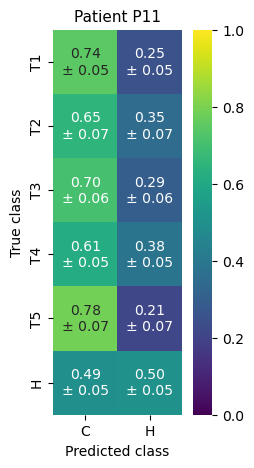

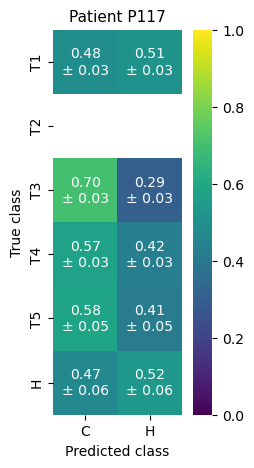

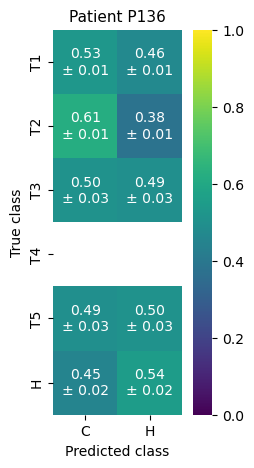

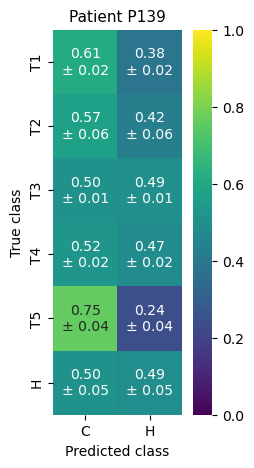

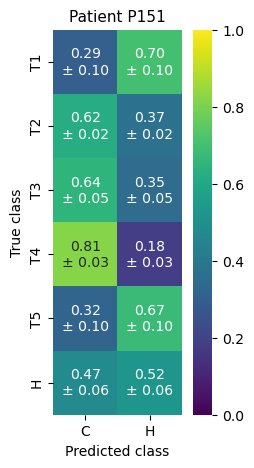

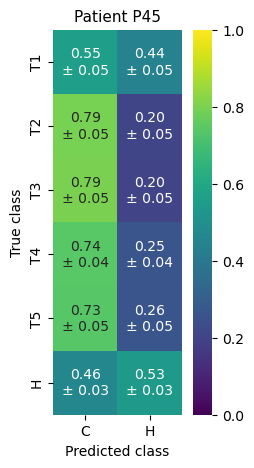

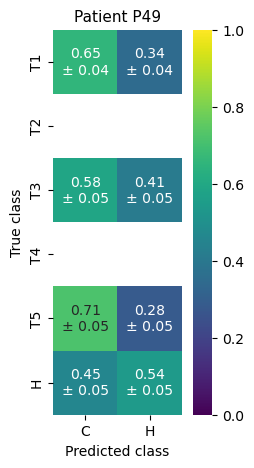

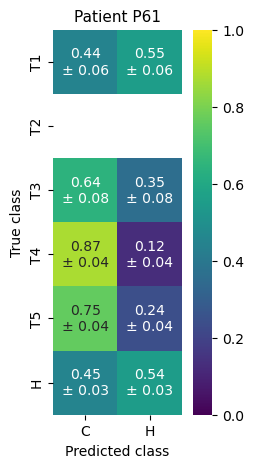

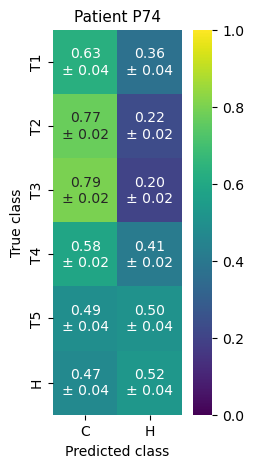

In [129]:
for p in patients:
  cms_mean = np.zeros((6, 2))
  cms_std = np.zeros((6, 2))

  for t in [1, 2, 3, 4, 5]:
    select = np.argwhere((np.array(ps) == p) & (np.array(ts) == t)).flatten()
    cms_t_mean = np.mean(np.array(cms)[select], axis=0)
    cms_t_std = np.std(np.array(cms)[select], axis=0)
    if t == 1:
      # for true label healthy
      cms_mean[-1] = cms_t_mean[1]
      cms_std[-1] = cms_t_std[1]
    # for true label disease at timepoint t
    cms_mean[t-1] = cms_t_mean[0]
    cms_std[t-1] = cms_t_std[0]

  cms_df = pd.DataFrame(cms_mean, index=['T1', 'T2', 'T3', 'T4', 'T5', 'H'], columns=['C', 'H'])
  fig, ax = plt.subplots(figsize=[3, 5])
  ax = sns.heatmap(
      cms_df,
      annot=pd.DataFrame(cms_mean.astype(str)).applymap(lambda x : x[:4]) + '\n± ' + pd.DataFrame(cms_std.astype(str)).applymap(lambda x : x[:4]),
      fmt='s',
      cmap='viridis',
      vmin=0,
      vmax=1,
      # cbar=False,
  )
  ax.set_xlabel('Predicted class')
  ax.set_ylabel('True class')
  ax.set_title(f'Patient {p}', size=11)
  ax.set_aspect(1)
  fig.show()

## Plate 15

In [134]:
plate_id = 15
m = 200
data = PlateDataset([plate_id], strict_discard=False)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.41it/s]


In [135]:
counts = data.info.groupby(['patient', 'time'])[['cell']].count().rename(columns={'cell':'count'})
few = counts[counts['count'] < m]
print(few)
enough = counts[counts['count'] >= m].index.copy()
enough = counts.loc[enough].reset_index()
print(enough.groupby('time').count())  # check that healty is smallest group
enough_samples = (enough['patient'] + '_' + enough['time'].apply(str)).str.split('_0', expand=True)[0].values
print(enough_samples)

              count
patient time       
P26     1        39
        2        70
      patient  count
time                
0           4      4
1          10     10
2           9      9
3           9      9
4           7      7
5           7      7
['H13' 'H15' 'H18' 'H45' 'P103_1' 'P103_2' 'P103_3' 'P121_1' 'P121_2'
 'P121_3' 'P121_4' 'P121_5' 'P140_1' 'P140_2' 'P140_3' 'P140_4' 'P140_5'
 'P146_1' 'P146_2' 'P146_3' 'P146_4' 'P159_1' 'P159_2' 'P159_3' 'P159_4'
 'P159_5' 'P26_3' 'P26_5' 'P34_1' 'P34_2' 'P40_1' 'P40_2' 'P40_3' 'P40_4'
 'P40_5' 'P85_1' 'P85_2' 'P85_3' 'P85_4' 'P85_5' 'P88_1' 'P97_1' 'P97_2'
 'P97_3' 'P97_4' 'P97_5']


In [136]:
enough[enough['time'] == 1]

patient  time  count
4     P103     1   3859
7     P121     1   2672
12    P140     1   1968
17    P146     1   3554
21    P159     1   4323
28     P34     1   1104
30     P40     1   3521
35     P85     1   8386
40     P88     1   1592
41     P97     1   2956

In [137]:
enough[enough['time'] == 0]

patient  time  count
0     H13     0   2995
1     H15     0   3406
2     H18     0   2426
3     H45     0   1510

In [138]:
healthy = enough[enough['time'] == 0]['patient'].unique()
patients = enough[enough['time'] == 1]['patient'].unique()
nc, nh = how_many_cells_per_condition_patient(patients, healthy, enough)
nc, nh

(604, 1510)

In [139]:
labels = torch.from_numpy((data.info['group'] == 'healthy').values).float()
dataset = TensorDataset(T.CenterCrop(28)(data.imgs), labels)

np.random.seed(13423)
confusion = {}
cms = []
enough = enough.reset_index()
enough = enough.set_index(['patient', 'time'])
for h, p in tqdm(list(product(healthy, patients))):
  healthy_train = healthy[healthy != h]
  patients_train = patients[patients != p]
  train_idx = np.concatenate([np.random.choice(np.argwhere(
      ((data.info['time'].values == 1) & (data.info['patient'].values == x))).flatten(),
                                                size=nc, replace=False) for x in patients_train]
              + [np.random.choice(np.argwhere(
                                  (data.info['patient'].values == x)).flatten(),
                                                size=nh, replace=False) for x in healthy_train])
  train_dataset = Subset(dataset, train_idx.tolist())
  print(h, p, ': training dataset size: ', len(train_dataset))

  k = min(enough.loc[(p, 1), 'count'], enough.loc[(h, 0), 'count'])
  test_idx = np.concatenate([np.random.choice(np.argwhere(
      ((data.info['time'] == 1) & (data.info['patient'] == p)).values).flatten(), size=k, replace=False),
                              np.random.choice(np.argwhere(
                                  (data.info['patient'] == h).values).flatten(), size=k, replace=False)])
  test_dataset = Subset(dataset, test_idx)

  model = Classifier().to(device)
  _ = train_model_with_datasets(model, train_dataset, val_dataset=test_dataset, fname=f'patch_plate{plate_id}_t1_{p}_{h}_{patients_train[0]}_{patients_train[1]}_{patients_train[2]}',
                  plot=False, save_model=False, num_epochs=30, batch_size=64, lr=0.001, device=device)

  for t in [1, 2, 3, 4, 5]:
    if not (p, t) in set(enough.index.values):
      continue
    test_idx = np.concatenate([np.argwhere(((data.info['time'] == t) & (data.info['patient'] == p)).values).flatten(),
                               np.argwhere((data.info['patient'] == h).values).flatten()])

    test_dataset = Subset(dataset, test_idx)
    preds, labs = eval_model_on_dataset(model, test_dataset, device=device)
    cms.append((h, p, t, patients_train, confusion_matrix(labs, preds, normalize='true')))

  0%|                                                                                                                                                                                          | 0/40 [00:00<?, ?it/s]

H13 P103 : training dataset size:  9966


epoch: 29; train loss: 0.09531868; val loss: 0.98259922; train accuracy: 0.96457957; val accuracy: 0.74106845 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:10<00:00,  2.76it/s]
  2%|████▍                                                                                                                                                                             | 1/40 [00:11<07:15, 11.16s/it]

H13 P121 : training dataset size:  9966


epoch: 29; train loss: 0.09178684; val loss: 1.12526731; train accuracy: 0.96758981; val accuracy: 0.70359281 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:10<00:00,  2.80it/s]
  5%|████████▉                                                                                                                                                                         | 2/40 [00:22<07:02, 11.13s/it]

H13 P140 : training dataset size:  9966


epoch: 29; train loss: 0.08288304; val loss: 2.14775395; train accuracy: 0.97019868; val accuracy: 0.50762195 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:10<00:00,  2.88it/s]
  8%|█████████████▎                                                                                                                                                                    | 3/40 [00:33<06:46, 10.98s/it]

H13 P146 : training dataset size:  9966


epoch: 29; train loss: 0.10407667; val loss: 1.34419195; train accuracy: 0.96227172; val accuracy: 0.61502504 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:10<00:00,  2.90it/s]
 10%|█████████████████▊                                                                                                                                                                | 4/40 [00:43<06:30, 10.84s/it]

H13 P159 : training dataset size:  9966


epoch: 29; train loss: 0.10376227; val loss: 2.00141698; train accuracy: 0.96036524; val accuracy: 0.61485810 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:10<00:00,  2.91it/s]
 12%|██████████████████████▎                                                                                                                                                           | 5/40 [00:54<06:17, 10.79s/it]

H13 P34 : training dataset size:  9966


epoch: 29; train loss: 0.07566276; val loss: 0.93867815; train accuracy: 0.97361027; val accuracy: 0.80163043 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:09<00:00,  3.18it/s]
 15%|██████████████████████████▋                                                                                                                                                       | 6/40 [01:03<05:52, 10.38s/it]

H13 P40 : training dataset size:  9966


epoch: 29; train loss: 0.07838702; val loss: 0.98459468; train accuracy: 0.97210516; val accuracy: 0.73989983 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:10<00:00,  2.92it/s]
 18%|███████████████████████████████▏                                                                                                                                                  | 7/40 [01:14<05:44, 10.44s/it]

H13 P85 : training dataset size:  9966


epoch: 29; train loss: 0.10086128; val loss: 1.02704962; train accuracy: 0.96307445; val accuracy: 0.71035058 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:10<00:00,  2.94it/s]
 20%|███████████████████████████████████▌                                                                                                                                              | 8/40 [01:25<05:35, 10.48s/it]

H13 P88 : training dataset size:  9966


epoch: 29; train loss: 0.07966866; val loss: 0.97237360; train accuracy: 0.97060004; val accuracy: 0.79051508 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:09<00:00,  3.09it/s]
 22%|████████████████████████████████████████                                                                                                                                          | 9/40 [01:34<05:18, 10.27s/it]

H13 P97 : training dataset size:  9966


epoch: 29; train loss: 0.07586399; val loss: 0.97519670; train accuracy: 0.97350993; val accuracy: 0.76995940 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:10<00:00,  2.92it/s]
 25%|████████████████████████████████████████████▎                                                                                                                                    | 10/40 [01:45<05:11, 10.38s/it]

H15 P103 : training dataset size:  9966


epoch: 29; train loss: 0.09888373; val loss: 0.92931512; train accuracy: 0.96327514; val accuracy: 0.75058720 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:10<00:00,  2.90it/s]
 28%|████████████████████████████████████████████████▋                                                                                                                                | 11/40 [01:56<05:02, 10.45s/it]

H15 P121 : training dataset size:  9966


epoch: 29; train loss: 0.08988425; val loss: 1.19029371; train accuracy: 0.96618503; val accuracy: 0.68619012 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:09<00:00,  3.01it/s]
 30%|█████████████████████████████████████████████████████                                                                                                                            | 12/40 [02:06<04:51, 10.42s/it]

H15 P140 : training dataset size:  9966


epoch: 29; train loss: 0.08188486; val loss: 2.00105855; train accuracy: 0.96929561; val accuracy: 0.56529472 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:09<00:00,  3.05it/s]
 32%|█████████████████████████████████████████████████████████▌                                                                                                                       | 13/40 [02:16<04:39, 10.36s/it]

H15 P146 : training dataset size:  9966


epoch: 29; train loss: 0.09833600; val loss: 1.44972581; train accuracy: 0.96076661; val accuracy: 0.65193776 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:10<00:00,  2.91it/s]
 35%|█████████████████████████████████████████████████████████████▉                                                                                                                   | 14/40 [02:27<04:31, 10.43s/it]

H15 P159 : training dataset size:  9966


epoch: 29; train loss: 0.07296125; val loss: 1.50090410; train accuracy: 0.97451335; val accuracy: 0.65825015 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:09<00:00,  3.03it/s]
 38%|██████████████████████████████████████████████████████████████████▍                                                                                                              | 15/40 [02:38<04:22, 10.51s/it]

H15 P34 : training dataset size:  9966


epoch: 29; train loss: 0.09738843; val loss: 0.83013222; train accuracy: 0.96297411; val accuracy: 0.82336957 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:09<00:00,  3.29it/s]
 40%|██████████████████████████████████████████████████████████████████████▊                                                                                                          | 16/40 [02:47<04:03, 10.13s/it]

H15 P40 : training dataset size:  9966


epoch: 29; train loss: 0.07551258; val loss: 1.00437446; train accuracy: 0.97160345; val accuracy: 0.73561362 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:10<00:00,  2.83it/s]
 42%|███████████████████████████████████████████████████████████████████████████▏                                                                                                     | 17/40 [02:58<03:58, 10.37s/it]

H15 P85 : training dataset size:  9966


epoch: 29; train loss: 0.08001726; val loss: 0.76556438; train accuracy: 0.97210516; val accuracy: 0.79785672 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:10<00:00,  2.84it/s]
 45%|███████████████████████████████████████████████████████████████████████████████▋                                                                                                 | 18/40 [03:09<03:54, 10.64s/it]

H15 P88 : training dataset size:  9966


epoch: 29; train loss: 0.09580074; val loss: 0.85371578; train accuracy: 0.96457957; val accuracy: 0.77606784 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:09<00:00,  3.10it/s]
 48%|████████████████████████████████████████████████████████████████████████████████████                                                                                             | 19/40 [03:19<03:37, 10.38s/it]

H15 P97 : training dataset size:  9966


epoch: 29; train loss: 0.08251629; val loss: 0.81049110; train accuracy: 0.97080072; val accuracy: 0.79380920 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:11<00:00,  2.70it/s]
 50%|████████████████████████████████████████████████████████████████████████████████████████▌                                                                                        | 20/40 [03:30<03:34, 10.72s/it]

H18 P103 : training dataset size:  9966


epoch: 29; train loss: 0.07444658; val loss: 1.77873900; train accuracy: 0.97441300; val accuracy: 0.70032976 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:10<00:00,  2.76it/s]
 52%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                    | 21/40 [03:41<03:25, 10.84s/it]

H18 P121 : training dataset size:  9966


epoch: 29; train loss: 0.08237860; val loss: 1.62826729; train accuracy: 0.96909492; val accuracy: 0.66467436 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:10<00:00,  2.78it/s]
 55%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                               | 22/40 [03:52<03:16, 10.93s/it]

H18 P140 : training dataset size:  9966


epoch: 29; train loss: 0.08532415; val loss: 2.45426500; train accuracy: 0.96789083; val accuracy: 0.48704268 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:10<00:00,  2.87it/s]
 57%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                           | 23/40 [04:03<03:05, 10.90s/it]

H18 P146 : training dataset size:  9966


epoch: 29; train loss: 0.08070730; val loss: 1.90830338; train accuracy: 0.96879390; val accuracy: 0.57769992 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:10<00:00,  2.81it/s]
 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                      | 24/40 [04:14<02:54, 10.92s/it]

H18 P159 : training dataset size:  9966


epoch: 29; train loss: 0.09803637; val loss: 1.67652237; train accuracy: 0.96317479; val accuracy: 0.60511129 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:10<00:00,  2.81it/s]
 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                  | 25/40 [04:25<02:44, 10.96s/it]

H18 P34 : training dataset size:  9966


epoch: 29; train loss: 0.07386373; val loss: 1.45260701; train accuracy: 0.97310857; val accuracy: 0.76675725 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:09<00:00,  3.08it/s]
 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                              | 26/40 [04:35<02:28, 10.64s/it]

H18 P40 : training dataset size:  9966


epoch: 29; train loss: 0.09165249; val loss: 1.59954425; train accuracy: 0.96478025; val accuracy: 0.71496290 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:10<00:00,  2.82it/s]
 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 27/40 [04:46<02:19, 10.72s/it]

H18 P85 : training dataset size:  9966


epoch: 29; train loss: 0.09218561; val loss: 1.41276272; train accuracy: 0.96478025; val accuracy: 0.68755153 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:10<00:00,  2.84it/s]
 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 28/40 [04:57<02:09, 10.78s/it]

H18 P88 : training dataset size:  9966


epoch: 29; train loss: 0.09698166; val loss: 1.14660007; train accuracy: 0.96247241; val accuracy: 0.74026382 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:10<00:00,  2.95it/s]
 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 29/40 [05:07<01:56, 10.63s/it]

H18 P97 : training dataset size:  9966


epoch: 29; train loss: 0.07136521; val loss: 1.25565519; train accuracy: 0.97682119; val accuracy: 0.75123660 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:09<00:00,  3.03it/s]
 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 30/40 [05:18<01:45, 10.51s/it]

H45 P103 : training dataset size:  9966


epoch: 29; train loss: 0.06624746; val loss: 3.81656766; train accuracy: 0.97912904; val accuracy: 0.55099338 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:09<00:00,  3.23it/s]
 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 31/40 [05:27<01:31, 10.21s/it]

H45 P121 : training dataset size:  9966


epoch: 29; train loss: 0.08026950; val loss: 2.71494764; train accuracy: 0.96909492; val accuracy: 0.55397351 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:09<00:00,  3.01it/s]
 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 32/40 [05:37<01:21, 10.24s/it]

H45 P140 : training dataset size:  9966


epoch: 29; train loss: 0.09919906; val loss: 2.61910844; train accuracy: 0.96257275; val accuracy: 0.57814570 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:09<00:00,  3.19it/s]
 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 33/40 [05:47<01:10, 10.09s/it]

H45 P146 : training dataset size:  9966


epoch: 29; train loss: 0.08271091; val loss: 3.37992024; train accuracy: 0.96899458; val accuracy: 0.53046358 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:09<00:00,  3.08it/s]
 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 34/40 [05:57<01:00, 10.06s/it]

H45 P159 : training dataset size:  9966


epoch: 29; train loss: 0.07932371; val loss: 3.22332489; train accuracy: 0.97060004; val accuracy: 0.46556291 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:09<00:00,  3.13it/s]
 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 35/40 [06:07<00:50, 10.01s/it]

H45 P34 : training dataset size:  9966


epoch: 29; train loss: 0.09746754; val loss: 4.37743413; train accuracy: 0.96347582; val accuracy: 0.65353261 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:09<00:00,  3.25it/s]
 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 36/40 [06:16<00:39,  9.82s/it]

H45 P40 : training dataset size:  9966


epoch: 29; train loss: 0.07819723; val loss: 2.47436154; train accuracy: 0.97080072; val accuracy: 0.61556291 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:09<00:00,  3.10it/s]
 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 37/40 [06:26<00:29,  9.85s/it]

H45 P85 : training dataset size:  9966


epoch: 29; train loss: 0.10970421; val loss: 3.19931316; train accuracy: 0.95544852; val accuracy: 0.55099338 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:09<00:00,  3.27it/s]
 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 38/40 [06:36<00:19,  9.74s/it]

H45 P88 : training dataset size:  9966


epoch: 29; train loss: 0.09848636; val loss: 2.69111067; train accuracy: 0.96287377; val accuracy: 0.60430464 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:09<00:00,  3.07it/s]
 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 39/40 [06:46<00:09,  9.78s/it]

H45 P97 : training dataset size:  9966


epoch: 29; train loss: 0.08600932; val loss: 3.78881288; train accuracy: 0.96969697; val accuracy: 0.55960265 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:09<00:00,  3.23it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [06:55<00:00, 10.39s/it]


In [140]:
import pickle

confusion = cms
with open(f'/ewsc/hschluet/models/pbmc5/rerun/plate_{plate_id}_confusion_t1_new.pkl', 'wb') as handle:
    pickle.dump(confusion, handle, protocol=pickle.HIGHEST_PROTOCOL)

# with open('filename.pickle', 'rb') as handle:
#     b = pickle.load(handle)

In [141]:
hs, ps, ts, _, cms = zip(*confusion)
cms_dfs = []

pats = np.unique(ps)
for p in pats:
    cms_mean = np.zeros((6, 2))
    cms_std = np.zeros((6, 2))

    for t in [1, 2, 3, 4, 5]:
        select = np.argwhere((np.array(ps) == p) & (np.array(ts) == t)).flatten()
        cms_t_mean = np.mean(np.array(cms)[select], axis=0)
        cms_t_std = np.std(np.array(cms)[select], axis=0)
        if t == 1:
            # for true label healthy
            cms_mean[-1] = cms_t_mean[1]
            cms_std[-1] = cms_t_std[1]
        # for true label disease at timepoint t
        cms_mean[t-1] = cms_t_mean[0]
        cms_std[t-1] = cms_t_std[0]


    cms_df = pd.DataFrame(cms_mean, index=['T1', 'T2', 'T3', 'T4', 'T5', 'H'], columns=['C', 'H']).drop(columns=['C'])
    cms_df['std'] = cms_std[:, 0]
    cms_df['pred H %'] = cms_df['H']
    cms_df['score'] = cms_df['H'] / cms_df.loc['H', 'H']
    cms_df['patient'] = p
    cms_df['plate'] = plate_id
    cms_df.index.name = 'TP'
    cms_df = cms_df.reset_index()
    cms_df['time'] = cms_df['TP'].replace({'T1' : 1, 'T2' : 2, 'T3':3, 'T4':4, 'T5':5, 'H':0})
    cms_df.loc[cms_df['time'] == 0, 'patient'] = 'H???'
    cms_dfs.append(cms_df.drop(columns=['H', 'TP']))

cms_df = pd.concat(cms_dfs, ignore_index=True)
cms_df = cms_df.rename(columns={'H':'pred H %'}).sort_values(by=['patient', 'time']).reset_index(drop=True)
cms_df.to_csv(f'/ewsc/hschluet/models/pbmc5/rerun/within_plate_{plate_id}_from_scratch_results.csv')
cms_df

/local_home/hschluet/anaconda3/envs/img-39/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/local_home/hschluet/anaconda3/envs/img-39/lib/python3.9/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/local_home/hschluet/anaconda3/envs/img-39/lib/python3.9/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/local_home/hschluet/anaconda3/envs/img-39/lib/python3.9/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/local_home/hschluet/anaconda3/envs/img-39/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/tmp/ipykernel_2628142/1678

std  pred H %     score patient  plate  time
0   0.140491  0.607125  1.000000    H???     15     0
1   0.102641  0.578974  1.000000    H???     15     0
2   0.081360  0.665205  1.000000    H???     15     0
3   0.099007  0.612640  1.000000    H???     15     0
4   0.126670  0.692885  1.000000    H???     15     0
5   0.149145  0.613254  1.000000    H???     15     0
6   0.101026  0.600965  1.000000    H???     15     0
7   0.152102  0.585909  1.000000    H???     15     0
8   0.156873  0.634540  1.000000    H???     15     0
9   0.145793  0.576871  1.000000    H???     15     0
10  0.057559  0.238209  0.392356    P103     15     1
11  0.079194  0.529391  0.871964    P103     15     2
12  0.075702  0.467037  0.769261    P103     15     3
13       NaN       NaN       NaN    P103     15     4
14       NaN       NaN       NaN    P103     15     5
15  0.047359  0.277601  0.479471    P121     15     1
16  0.040439  0.195404  0.337501    P121     15     2
17  0.307769  0.597374  1.031781    P121     15     3
18  0.062261  0.429978  0.742656    P121     15     4
19  0.059833  0.378604  0.653923    P121     15     5
20  0.110373  0.597434  0.898120    P140     15     1
21  0.041368  0.466446  0.701206    P140     15     2
22  0.043015  0.453082  0.681116    P140     15     3
23  0.054392  0.466962  0.701982    P140     15     4
24  0.112498  0.607938  0.913911    P140     15     5
25  0.033134  0.423467  0.691216    P146     15     1
26  0.035802  0.319784  0.521976    P146     15     2
27  0.254437  0.444185  0.725034    P146     15     3
28  0.072328  0.516173  0.842538    P146     15     4
29       NaN       NaN       NaN    P146     15     5
30  0.062807  0.521166  0.752168    P159     15     1
31  0.071967  0.599608  0.865379    P159     15     2
32  0.074683  0.674150  0.972960    P159     15     3
33  0.042803  0.815869  1.177495    P159     15     4
34  0.067243  0.722996  1.043457    P159     15     5
35  0.036285  0.093976  0.153242     P34     15     1
36  0.052960  0.205046  0.334356     P34     15     2
37       NaN       NaN       NaN     P34     15     3
38       NaN       NaN       NaN     P34     15     4
39       NaN       NaN       NaN     P34     15     5
40  0.059875  0.197955  0.329395     P40     15     1
41  0.059064  0.263022  0.437667     P40     15     2
42  0.079626  0.250681  0.417131     P40     15     3
43  0.065331  0.204340  0.340019     P40     15     4
44  0.095144  0.355758  0.591978     P40     15     5
45  0.032821  0.208562  0.355963     P85     15     1
46  0.061029  0.248290  0.423768     P85     15     2
47  0.053094  0.226258  0.386167     P85     15     3
48  0.037209  0.205374  0.350522     P85     15     4
49  0.028930  0.422818  0.721644     P85     15     5
50  0.043665  0.177450  0.279651     P88     15     1
51       NaN       NaN       NaN     P88     15     2
52       NaN       NaN       NaN     P88     15     3
53       NaN       NaN       NaN     P88     15     4
54       NaN       NaN       NaN     P88     15     5
55  0.050355  0.142084  0.246301     P97     15     1
56  0.044354  0.131805  0.228483     P97     15     2
57  0.040109  0.151420  0.262484     P97     15     3
58  0.044676  0.351455  0.609244     P97     15     4
59  0.091659  0.475311  0.823947     P97     15     5

/local_home/hschluet/anaconda3/envs/img-39/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/local_home/hschluet/anaconda3/envs/img-39/lib/python3.9/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/local_home/hschluet/anaconda3/envs/img-39/lib/python3.9/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/local_home/hschluet/anaconda3/envs/img-39/lib/python3.9/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/local_home/hschluet/anaconda3/envs/img-39/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/tmp/ipykernel_2628142/1479

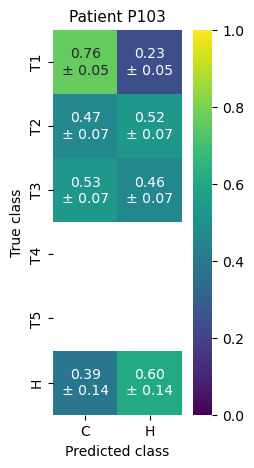

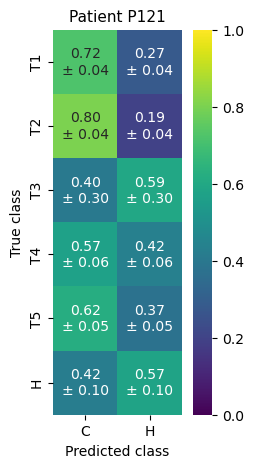

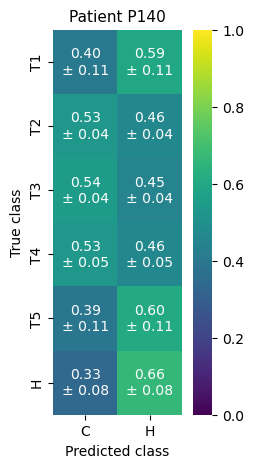

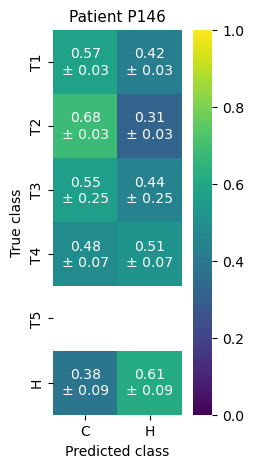

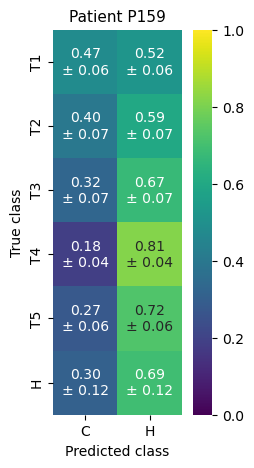

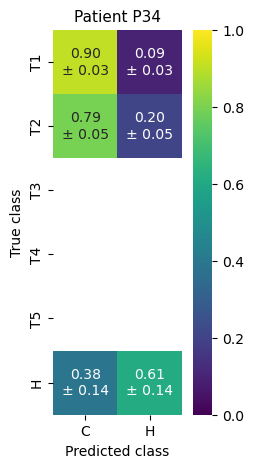

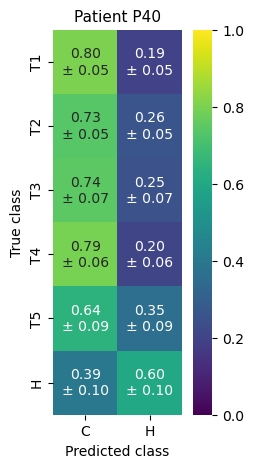

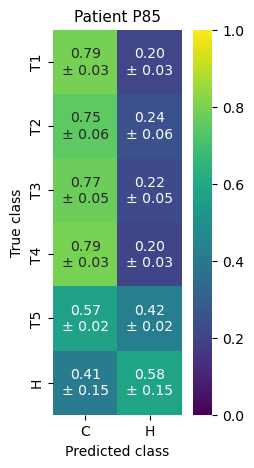

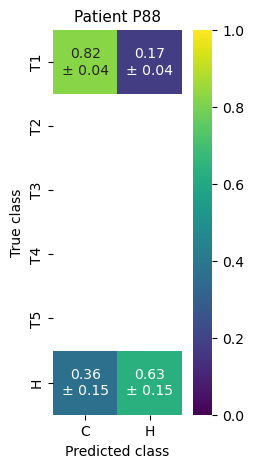

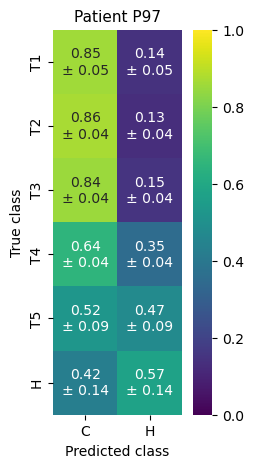

In [142]:
for p in patients:
  cms_mean = np.zeros((6, 2))
  cms_std = np.zeros((6, 2))

  for t in [1, 2, 3, 4, 5]:
    select = np.argwhere((np.array(ps) == p) & (np.array(ts) == t)).flatten()
    cms_t_mean = np.mean(np.array(cms)[select], axis=0)
    cms_t_std = np.std(np.array(cms)[select], axis=0)
    if t == 1:
      # for true label healthy
      cms_mean[-1] = cms_t_mean[1]
      cms_std[-1] = cms_t_std[1]
    # for true label disease at timepoint t
    cms_mean[t-1] = cms_t_mean[0]
    cms_std[t-1] = cms_t_std[0]

  cms_df = pd.DataFrame(cms_mean, index=['T1', 'T2', 'T3', 'T4', 'T5', 'H'], columns=['C', 'H'])
  fig, ax = plt.subplots(figsize=[3, 5])
  ax = sns.heatmap(
      cms_df,
      annot=pd.DataFrame(cms_mean.astype(str)).applymap(lambda x : x[:4]) + '\n± ' + pd.DataFrame(cms_std.astype(str)).applymap(lambda x : x[:4]),
      fmt='s',
      cmap='viridis',
      vmin=0,
      vmax=1,
      # cbar=False,
  )
  ax.set_xlabel('Predicted class')
  ax.set_ylabel('True class')
  ax.set_title(f'Patient {p}', size=11)
  ax.set_aspect(1)
  fig.show()

## Plate 14

In [32]:
plate_id = 14
m = 200
data = PlateDataset([plate_id], strict_discard=False)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.40it/s]


In [ ]:
counts = data.info.groupby(['patient', 'time'])[['cell']].count().rename(columns={'cell':'count'})
few = counts[counts['count'] < m]
print(few)
enough = counts[counts['count'] >= m].index.copy()
enough = counts.loc[enough].reset_index()
print(enough.groupby('time').count())  # check that healty is smallest group
enough_samples = (enough['patient'] + '_' + enough['time'].apply(str)).str.split('_0', expand=True)[0].values
print(enough_samples)

Empty DataFrame
Columns: [count]
Index: []
      patient  count
time                
0           4      4
1          10     10
2          10     10
3          10     10
4           7      7
5           6      6
['H18' 'H25' 'H45' 'H48' 'P113_1' 'P113_2' 'P113_3' 'P113_5' 'P158_1'
 'P158_2' 'P158_3' 'P158_5' 'P167_1' 'P167_2' 'P167_3' 'P19_1' 'P19_2'
 'P19_3' 'P19_4' 'P19_5' 'P30_1' 'P30_2' 'P30_3' 'P30_4' 'P30_5' 'P35_1'
 'P35_2' 'P35_3' 'P35_4' 'P53_1' 'P53_2' 'P53_3' 'P53_4' 'P53_5' 'P54_1'
 'P54_2' 'P54_3' 'P54_4' 'P66_1' 'P66_2' 'P66_3' 'P66_4' 'P91_1' 'P91_2'
 'P91_3' 'P91_4' 'P91_5']


In [56]:
enough[enough['time'] == 1]

patient  time  count
4     P113     1   1228
8     P158     1   9024
12    P167     1   5476
15     P19     1   2658
20     P30     1   5770
25     P35     1   3960
29     P53     1    441
34     P54     1   2032
38     P66     1    269
42     P91     1   1449

In [57]:
enough[enough['time'] == 0]

patient  time  count
0     H18     0   3518
1     H25     0   3644
2     H45     0   5149
3     H48     0   6793

In [58]:
healthy = enough[enough['time'] == 0]['patient'].unique()
patients = enough[enough['time'] == 1]['patient'].unique()
nc, nh = how_many_cells_per_condition_patient(patients, healthy, enough)
nc, nh

(268, 670)

In [101]:
labels = torch.from_numpy((data.info['group'] == 'healthy').values).float()
dataset = TensorDataset(T.CenterCrop(28)(data.imgs), labels)

np.random.seed(13423)
confusion = {}
cms = []
enough = enough.reset_index()
enough = enough.set_index(['patient', 'time'])
for h, p in tqdm(list(product(healthy, patients))):
  healthy_train = healthy[healthy != h]
  patients_train = patients[patients != p]
  train_idx = np.concatenate([np.random.choice(np.argwhere(
      ((data.info['time'].values == 1) & (data.info['patient'].values == x))).flatten(),
                                                size=nc, replace=False) for x in patients_train]
              + [np.random.choice(np.argwhere(
                                  (data.info['patient'].values == x)).flatten(),
                                                size=nh, replace=False) for x in healthy_train])
  train_dataset = Subset(dataset, train_idx.tolist())
  print(h, p, ': training dataset size: ', len(train_dataset))

  k = min(enough.loc[(p, 1), 'count'], enough.loc[(h, 0), 'count'])
  test_idx = np.concatenate([np.random.choice(np.argwhere(
      ((data.info['time'] == 1) & (data.info['patient'] == p)).values).flatten(), size=k, replace=False),
                              np.random.choice(np.argwhere(
                                  (data.info['patient'] == h).values).flatten(), size=k, replace=False)])
  test_dataset = Subset(dataset, test_idx)

  model = Classifier().to(device)
  _ = train_model_with_datasets(model, train_dataset, val_dataset=test_dataset, fname=f'patch_plate{plate_id}_t1_{p}_{h}_{patients_train[0]}_{patients_train[1]}_{patients_train[2]}',
                  plot=False, save_model=False, num_epochs=30, batch_size=64, lr=0.001, device=device)

  for t in [1, 2, 3, 4, 5]:
    if not (p, t) in set(enough.index.values):
      continue
    test_idx = np.concatenate([np.argwhere(((data.info['time'] == t) & (data.info['patient'] == p)).values).flatten(),
                               np.argwhere((data.info['patient'] == h).values).flatten()])

    test_dataset = Subset(dataset, test_idx)
    preds, labs = eval_model_on_dataset(model, test_dataset, device=device)
    cms.append((h, p, t, patients_train, confusion_matrix(labs, preds, normalize='true')))

  0%|                                                                                                                                                                                          | 0/40 [00:00<?, ?it/s]

H18 P113 : training dataset size:  4422


epoch: 29; train loss: 0.11185840; val loss: 0.58012193; train accuracy: 0.96178200; val accuracy: 0.84446254 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:04<00:00,  6.16it/s]
  2%|████▍                                                                                                                                                                             | 1/40 [00:05<03:24,  5.24s/it]

H18 P158 : training dataset size:  4422


epoch: 29; train loss: 0.03546275; val loss: 2.51452330; train accuracy: 0.99321574; val accuracy: 0.43305856 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:06<00:00,  4.92it/s]
  5%|████████▉                                                                                                                                                                         | 2/40 [00:12<03:54,  6.18s/it]

H18 P167 : training dataset size:  4422


epoch: 29; train loss: 0.06836230; val loss: 1.68704428; train accuracy: 0.97535052; val accuracy: 0.59280841 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:06<00:00,  4.99it/s]
  8%|█████████████▎                                                                                                                                                                    | 3/40 [00:18<03:50,  6.23s/it]

H18 P19 : training dataset size:  4422


epoch: 29; train loss: 0.05165650; val loss: 1.24469850; train accuracy: 0.98597919; val accuracy: 0.68698269 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:05<00:00,  5.20it/s]
 10%|█████████████████▊                                                                                                                                                                | 4/40 [00:24<03:43,  6.21s/it]

H18 P30 : training dataset size:  4422


epoch: 29; train loss: 0.04370253; val loss: 1.19336672; train accuracy: 0.98710991; val accuracy: 0.71304719 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:06<00:00,  4.90it/s]
 12%|██████████████████████▎                                                                                                                                                           | 5/40 [00:31<03:41,  6.31s/it]

H18 P35 : training dataset size:  4422


epoch: 29; train loss: 0.06427747; val loss: 1.67244901; train accuracy: 0.98145635; val accuracy: 0.70537237 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:06<00:00,  4.65it/s]
 15%|██████████████████████████▋                                                                                                                                                       | 6/40 [00:37<03:41,  6.50s/it]

H18 P53 : training dataset size:  4422


epoch: 29; train loss: 0.05905230; val loss: 1.33348560; train accuracy: 0.98462234; val accuracy: 0.75396825 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:04<00:00,  6.69it/s]
 18%|███████████████████████████████▏                                                                                                                                                  | 7/40 [00:42<03:17,  5.98s/it]

H18 P54 : training dataset size:  4422


epoch: 29; train loss: 0.05355983; val loss: 1.10467998; train accuracy: 0.98552691; val accuracy: 0.73868110 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:05<00:00,  5.54it/s]
 20%|███████████████████████████████████▌                                                                                                                                              | 8/40 [00:48<03:08,  5.89s/it]

H18 P66 : training dataset size:  4422


epoch: 29; train loss: 0.04939875; val loss: 1.26511908; train accuracy: 0.98733605; val accuracy: 0.68959108 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:04<00:00,  6.84it/s]
 22%|████████████████████████████████████████                                                                                                                                          | 9/40 [00:53<02:50,  5.51s/it]

H18 P91 : training dataset size:  4422


epoch: 29; train loss: 0.10668195; val loss: 1.66584128; train accuracy: 0.96223428; val accuracy: 0.68599034 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:04<00:00,  6.20it/s]
 25%|████████████████████████████████████████████▎                                                                                                                                    | 10/40 [00:58<02:42,  5.43s/it]

H25 P113 : training dataset size:  4422


epoch: 29; train loss: 0.07192366; val loss: 1.12160248; train accuracy: 0.97512438; val accuracy: 0.79478827 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:05<00:00,  5.89it/s]
 28%|████████████████████████████████████████████████▋                                                                                                                                | 11/40 [01:03<02:37,  5.43s/it]

H25 P158 : training dataset size:  4422


epoch: 29; train loss: 0.02242775; val loss: 2.42132923; train accuracy: 0.99683401; val accuracy: 0.44593853 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:05<00:00,  5.00it/s]
 30%|█████████████████████████████████████████████████████                                                                                                                            | 12/40 [01:10<02:40,  5.72s/it]

H25 P167 : training dataset size:  4422


epoch: 29; train loss: 0.06166189; val loss: 1.50382763; train accuracy: 0.97851651; val accuracy: 0.60798573 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:06<00:00,  4.71it/s]
 32%|█████████████████████████████████████████████████████████▌                                                                                                                       | 13/40 [01:16<02:42,  6.00s/it]

H25 P19 : training dataset size:  4422


epoch: 29; train loss: 0.06054630; val loss: 1.31227253; train accuracy: 0.98213478; val accuracy: 0.69544771 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:05<00:00,  5.29it/s]
 35%|█████████████████████████████████████████████████████████████▉                                                                                                                   | 14/40 [01:23<02:36,  6.04s/it]

H25 P30 : training dataset size:  4422


epoch: 29; train loss: 0.06155481; val loss: 1.17770097; train accuracy: 0.97806422; val accuracy: 0.71240395 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:06<00:00,  4.96it/s]
 38%|██████████████████████████████████████████████████████████████████▍                                                                                                              | 15/40 [01:29<02:33,  6.16s/it]

H25 P35 : training dataset size:  4422


epoch: 29; train loss: 0.07340117; val loss: 1.03047178; train accuracy: 0.97715966; val accuracy: 0.74231614 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:06<00:00,  4.71it/s]
 40%|██████████████████████████████████████████████████████████████████████▊                                                                                                          | 16/40 [01:36<02:32,  6.34s/it]

H25 P53 : training dataset size:  4422


epoch: 29; train loss: 0.09282453; val loss: 0.73062348; train accuracy: 0.96766169; val accuracy: 0.78571429 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:04<00:00,  6.71it/s]
 42%|███████████████████████████████████████████████████████████████████████████▏                                                                                                     | 17/40 [01:41<02:15,  5.91s/it]

H25 P54 : training dataset size:  4422


epoch: 29; train loss: 0.03496137; val loss: 0.89309646; train accuracy: 0.99321574; val accuracy: 0.77386811 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:05<00:00,  5.54it/s]
 45%|███████████████████████████████████████████████████████████████████████████████▋                                                                                                 | 18/40 [01:46<02:08,  5.84s/it]

H25 P66 : training dataset size:  4422


epoch: 29; train loss: 0.05295419; val loss: 0.80399442; train accuracy: 0.98575305; val accuracy: 0.79182156 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:04<00:00,  6.83it/s]
 48%|████████████████████████████████████████████████████████████████████████████████████                                                                                             | 19/40 [01:51<01:55,  5.49s/it]

H25 P91 : training dataset size:  4422


epoch: 29; train loss: 0.05175999; val loss: 1.03898519; train accuracy: 0.98303935; val accuracy: 0.75224293 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:05<00:00,  5.78it/s]
 50%|████████████████████████████████████████████████████████████████████████████████████████▌                                                                                        | 20/40 [01:57<01:50,  5.52s/it]

H45 P113 : training dataset size:  4422


epoch: 29; train loss: 0.07277792; val loss: 0.98560670; train accuracy: 0.97806422; val accuracy: 0.84364821 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:04<00:00,  6.30it/s]
 52%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                    | 21/40 [02:02<01:42,  5.40s/it]

H45 P158 : training dataset size:  4422


epoch: 29; train loss: 0.03131101; val loss: 2.05996206; train accuracy: 0.99570330; val accuracy: 0.49368809 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:06<00:00,  4.32it/s]
 55%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                               | 22/40 [02:09<01:47,  5.99s/it]

H45 P167 : training dataset size:  4422


epoch: 29; train loss: 0.04654511; val loss: 1.30990284; train accuracy: 0.98688376; val accuracy: 0.62682074 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:06<00:00,  4.32it/s]
 57%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                           | 23/40 [02:16<01:48,  6.37s/it]

H45 P19 : training dataset size:  4422


epoch: 29; train loss: 0.06898824; val loss: 0.88630550; train accuracy: 0.97942108; val accuracy: 0.75470278 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:05<00:00,  5.26it/s]
 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                      | 24/40 [02:23<01:41,  6.32s/it]

H45 P30 : training dataset size:  4422


epoch: 29; train loss: 0.06118776; val loss: 0.82205174; train accuracy: 0.98145635; val accuracy: 0.75276753 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:06<00:00,  4.32it/s]
 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                  | 25/40 [02:30<01:41,  6.74s/it]

H45 P35 : training dataset size:  4422


epoch: 29; train loss: 0.09198517; val loss: 0.47316377; train accuracy: 0.96607870; val accuracy: 0.85467172 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:06<00:00,  4.89it/s]
 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                              | 26/40 [02:37<01:33,  6.69s/it]

H45 P53 : training dataset size:  4422


epoch: 29; train loss: 0.05282838; val loss: 0.57713169; train accuracy: 0.98530077; val accuracy: 0.84693878 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:04<00:00,  6.71it/s]
 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 27/40 [02:42<01:21,  6.27s/it]

H45 P54 : training dataset size:  4422


epoch: 29; train loss: 0.17311795; val loss: 0.55419248; train accuracy: 0.93147897; val accuracy: 0.79896654 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:05<00:00,  5.93it/s]
 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 28/40 [02:48<01:12,  6.00s/it]

H45 P66 : training dataset size:  4422


epoch: 29; train loss: 0.06063090; val loss: 0.52856010; train accuracy: 0.98371777; val accuracy: 0.83828996 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:04<00:00,  6.83it/s]
 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 29/40 [02:53<01:02,  5.72s/it]

H45 P91 : training dataset size:  4422


epoch: 29; train loss: 0.05328060; val loss: 0.90076911; train accuracy: 0.98733605; val accuracy: 0.75293306 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:04<00:00,  6.18it/s]
 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 30/40 [02:58<00:55,  5.60s/it]

H48 P113 : training dataset size:  4422


epoch: 29; train loss: 0.10089098; val loss: 0.77603799; train accuracy: 0.96178200; val accuracy: 0.84568404 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:05<00:00,  5.86it/s]
 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 31/40 [03:03<00:50,  5.58s/it]

H48 P158 : training dataset size:  4422


epoch: 29; train loss: 0.10582419; val loss: 1.97040181; train accuracy: 0.96155586; val accuracy: 0.48800236 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:07<00:00,  3.96it/s]
 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 32/40 [03:12<00:51,  6.43s/it]

H48 P167 : training dataset size:  4422


epoch: 29; train loss: 0.07918115; val loss: 1.21218114; train accuracy: 0.97444595; val accuracy: 0.65549671 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:07<00:00,  4.22it/s]
 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 33/40 [03:19<00:47,  6.74s/it]

H48 P19 : training dataset size:  4422


epoch: 29; train loss: 0.05963326; val loss: 0.81611657; train accuracy: 0.98190864; val accuracy: 0.75583145 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:05<00:00,  5.29it/s]
 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 34/40 [03:25<00:39,  6.58s/it]

H48 P30 : training dataset size:  4422


epoch: 29; train loss: 0.04150021; val loss: 0.78553045; train accuracy: 0.99163275; val accuracy: 0.75797227 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:07<00:00,  4.19it/s]
 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 35/40 [03:33<00:34,  6.90s/it]

H48 P35 : training dataset size:  4422


epoch: 29; train loss: 0.05586812; val loss: 0.50040217; train accuracy: 0.98597919; val accuracy: 0.85088384 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:06<00:00,  4.62it/s]
 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 36/40 [03:40<00:27,  6.93s/it]

H48 P53 : training dataset size:  4422


epoch: 29; train loss: 0.13111188; val loss: 0.44729632; train accuracy: 0.94957033; val accuracy: 0.85260771 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:04<00:00,  6.71it/s]
 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 37/40 [03:45<00:19,  6.35s/it]

H48 P54 : training dataset size:  4422


epoch: 29; train loss: 0.05767304; val loss: 0.55800763; train accuracy: 0.98575305; val accuracy: 0.83932087 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:05<00:00,  5.54it/s]
 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 38/40 [03:51<00:12,  6.18s/it]

H48 P66 : training dataset size:  4422


epoch: 29; train loss: 0.06309889; val loss: 0.61915040; train accuracy: 0.98100407; val accuracy: 0.76208178 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:04<00:00,  6.82it/s]
 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 39/40 [03:56<00:05,  5.75s/it]

H48 P91 : training dataset size:  4422


epoch: 29; train loss: 0.07647271; val loss: 0.69962189; train accuracy: 0.97489824; val accuracy: 0.79123533 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:05<00:00,  5.78it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [04:01<00:00,  6.05s/it]


In [ ]:
import pickle

confusion = cms
with open(f'/ewsc/hschluet/models/pbmc5/rerun/plate_{plate_id}_confusion_t1_new.pkl', 'wb') as handle:
    pickle.dump(confusion, handle, protocol=pickle.HIGHEST_PROTOCOL)

# with open('filename.pickle', 'rb') as handle:
#     b = pickle.load(handle)

In [119]:
hs, ps, ts, _, cms = zip(*confusion)
cms_dfs = []

pats = np.unique(ps)
for p in pats:
    cms_mean = np.zeros((6, 2))
    cms_std = np.zeros((6, 2))

    for t in [1, 2, 3, 4, 5]:
        select = np.argwhere((np.array(ps) == p) & (np.array(ts) == t)).flatten()
        cms_t_mean = np.mean(np.array(cms)[select], axis=0)
        cms_t_std = np.std(np.array(cms)[select], axis=0)
        if t == 1:
            # for true label healthy
            cms_mean[-1] = cms_t_mean[1]
            cms_std[-1] = cms_t_std[1]
        # for true label disease at timepoint t
        cms_mean[t-1] = cms_t_mean[0]
        cms_std[t-1] = cms_t_std[0]


    cms_df = pd.DataFrame(cms_mean, index=['T1', 'T2', 'T3', 'T4', 'T5', 'H'], columns=['C', 'H']).drop(columns=['C'])
    cms_df['std'] = cms_std[:, 0]
    cms_df['pred H %'] = cms_df['H']
    cms_df['score'] = cms_df['H'] / cms_df.loc['H', 'H']
    cms_df['patient'] = p
    cms_df['plate'] = plate_id
    cms_df.index.name = 'TP'
    cms_df = cms_df.reset_index()
    cms_df['time'] = cms_df['TP'].replace({'T1' : 1, 'T2' : 2, 'T3':3, 'T4':4, 'T5':5, 'H':0})
    cms_df.loc[cms_df['time'] == 0, 'patient'] = 'H???'
    cms_dfs.append(cms_df.drop(columns=['H', 'TP']))

cms_df = pd.concat(cms_dfs, ignore_index=True)
cms_df = cms_df.rename(columns={'H':'pred H %'}).sort_values(by=['patient', 'time']).reset_index(drop=True)
cms_df.to_csv(f'/ewsc/hschluet/models/pbmc5/rerun/within_plate_{plate_id}_from_scratch_results.csv')
cms_df

/local_home/hschluet/anaconda3/envs/img-39/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/local_home/hschluet/anaconda3/envs/img-39/lib/python3.9/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/local_home/hschluet/anaconda3/envs/img-39/lib/python3.9/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/local_home/hschluet/anaconda3/envs/img-39/lib/python3.9/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/local_home/hschluet/anaconda3/envs/img-39/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/tmp/ipykernel_2628142/1678

std  pred H %     score patient  plate  time
0   0.058138  0.682543  1.000000    H???     14     0
1   0.061210  0.767110  1.000000    H???     14     0
2   0.075331  0.751990  1.000000    H???     14     0
3   0.139612  0.696422  1.000000    H???     14     0
4   0.088956  0.689150  1.000000    H???     14     0
5   0.168976  0.642103  1.000000    H???     14     0
6   0.077855  0.680563  1.000000    H???     14     0
7   0.083939  0.664383  1.000000    H???     14     0
8   0.094011  0.675983  1.000000    H???     14     0
9   0.101785  0.651693  1.000000    H???     14     0
10  0.013963  0.022801  0.033406    P113     14     1
11  0.067256  0.231191  0.338720    P113     14     2
12  0.029629  0.093158  0.136487    P113     14     3
13       NaN       NaN       NaN    P113     14     4
14  0.066277  0.426659  0.625102    P113     14     5
15  0.021916  0.836547  1.090518    P158     14     1
16  0.024732  0.581528  0.758077    P158     14     2
17  0.009689  0.900477  1.173857    P158     14     3
18       NaN       NaN       NaN    P158     14     4
19  0.049107  0.643723  0.839153    P158     14     5
20  0.071515  0.512053  0.680930    P167     14     1
21  0.094708  0.753314  1.001761    P167     14     2
22  0.041824  0.231089  0.307304    P167     14     3
23       NaN       NaN       NaN    P167     14     4
24       NaN       NaN       NaN    P167     14     5
25  0.075939  0.251411  0.361004     P19     14     1
26  0.083956  0.310498  0.445847     P19     14     2
27  0.016069  0.055511  0.079709     P19     14     3
28  0.005200  0.010604  0.015226     P19     14     4
29  0.090387  0.594433  0.853553     P19     14     5
30  0.048739  0.219367  0.318316     P30     14     1
31  0.014281  0.065015  0.094341     P30     14     2
32  0.006246  0.546560  0.793092     P30     14     3
33  0.012111  0.040386  0.058603     P30     14     4
34  0.012098  0.139791  0.202846     P30     14     5
35  0.039058  0.067551  0.105202     P35     14     1
36  0.109383  0.608784  0.948110     P35     14     2
37  0.088010  0.595600  0.927578     P35     14     3
38  0.097445  0.233917  0.364299     P35     14     4
39       NaN       NaN       NaN     P35     14     5
40  0.025879  0.051020  0.074968     P53     14     1
41  0.033685  0.131987  0.193938     P53     14     2
42  0.030989  0.311336  0.457468     P53     14     3
43  0.050274  0.140470  0.206403     P53     14     4
44  0.021380  0.063406  0.093168     P53     14     5
45  0.018912  0.088829  0.133701     P54     14     1
46  0.030949  0.104237  0.156893     P54     14     2
47  0.025423  0.067432  0.101495     P54     14     3
48  0.045472  0.257786  0.388008     P54     14     4
49       NaN       NaN       NaN     P54     14     5
50  0.075107  0.119888  0.177354     P66     14     1
51  0.032537  0.176622  0.261282     P66     14     2
52  0.010918  0.032468  0.048030     P66     14     3
53  0.013990  0.027778  0.041092     P66     14     4
54       NaN       NaN       NaN     P66     14     5
55  0.026735  0.159765  0.245154     P91     14     1
56  0.012007  0.053448  0.082015     P91     14     2
57  0.057955  0.506932  0.777870     P91     14     3
58  0.061963  0.452890  0.694945     P91     14     4
59  0.045014  0.232372  0.356567     P91     14     5

/local_home/hschluet/anaconda3/envs/img-39/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/local_home/hschluet/anaconda3/envs/img-39/lib/python3.9/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/local_home/hschluet/anaconda3/envs/img-39/lib/python3.9/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/local_home/hschluet/anaconda3/envs/img-39/lib/python3.9/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/local_home/hschluet/anaconda3/envs/img-39/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/tmp/ipykernel_2628142/1479

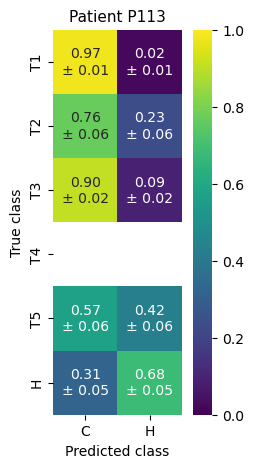

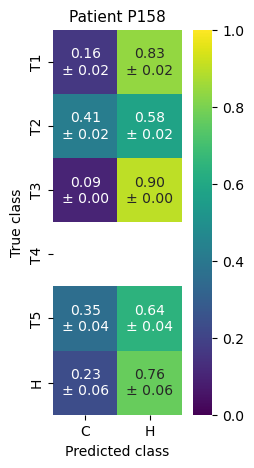

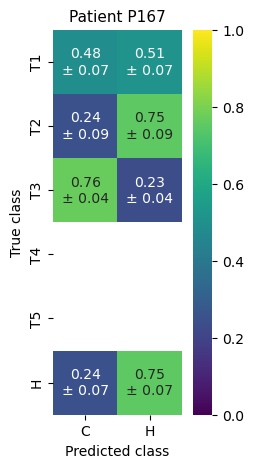

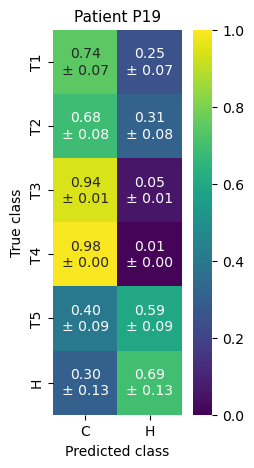

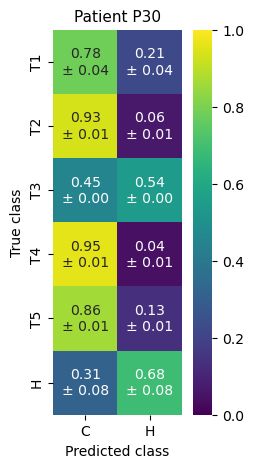

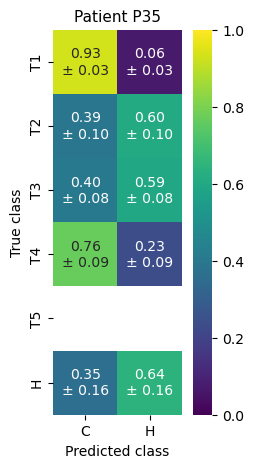

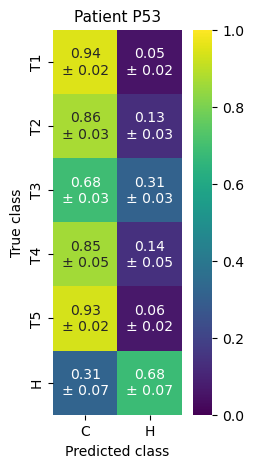

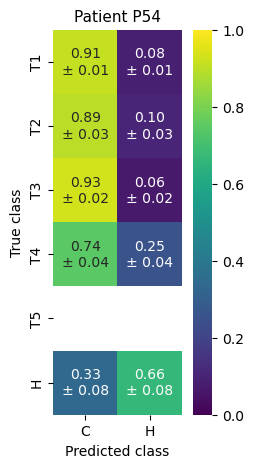

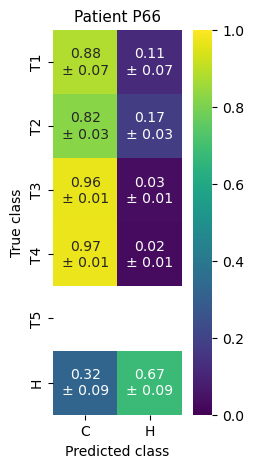

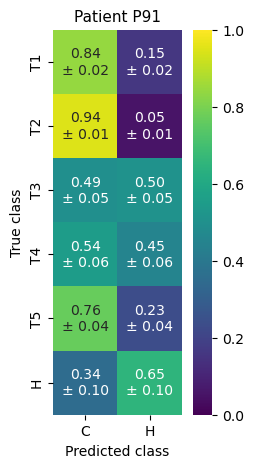

In [120]:
for p in patients:
  cms_mean = np.zeros((6, 2))
  cms_std = np.zeros((6, 2))

  for t in [1, 2, 3, 4, 5]:
    select = np.argwhere((np.array(ps) == p) & (np.array(ts) == t)).flatten()
    cms_t_mean = np.mean(np.array(cms)[select], axis=0)
    cms_t_std = np.std(np.array(cms)[select], axis=0)
    if t == 1:
      # for true label healthy
      cms_mean[-1] = cms_t_mean[1]
      cms_std[-1] = cms_t_std[1]
    # for true label disease at timepoint t
    cms_mean[t-1] = cms_t_mean[0]
    cms_std[t-1] = cms_t_std[0]

  cms_df = pd.DataFrame(cms_mean, index=['T1', 'T2', 'T3', 'T4', 'T5', 'H'], columns=['C', 'H'])
  fig, ax = plt.subplots(figsize=[3, 5])
  ax = sns.heatmap(
      cms_df,
      annot=pd.DataFrame(cms_mean.astype(str)).applymap(lambda x : x[:4]) + '\n± ' + pd.DataFrame(cms_std.astype(str)).applymap(lambda x : x[:4]),
      fmt='s',
      cmap='viridis',
      vmin=0,
      vmax=1,
      # cbar=False,
  )
  ax.set_xlabel('Predicted class')
  ax.set_ylabel('True class')
  ax.set_title(f'Patient {p}', size=11)
  ax.set_aspect(1)
  fig.show()

## Plate 13

In [144]:
plate_id = 13
m = 200
data = PlateDataset([plate_id], strict_discard=False)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.93it/s]


In [145]:
counts = data.info.groupby(['patient', 'time'])[['cell']].count().rename(columns={'cell':'count'})
few = counts[counts['count'] < m]
print(few)
enough = counts[counts['count'] >= m].index.copy()
enough = counts.loc[enough].reset_index()
print(enough.groupby('time').count())  # check that healty is smallest group
enough_samples = (enough['patient'] + '_' + enough['time'].apply(str)).str.split('_0', expand=True)[0].values
print(enough_samples)

Empty DataFrame
Columns: [count]
Index: []
      patient  count
time                
0           4      4
1           9      9
2           9      9
3           9      9
4           8      8
5           9      9
['H09' 'H25' 'H48' 'H49' 'P111_1' 'P111_2' 'P111_3' 'P111_4' 'P111_5'
 'P123_1' 'P123_2' 'P123_3' 'P123_4' 'P123_5' 'P127_1' 'P127_2' 'P127_3'
 'P127_4' 'P127_5' 'P20_1' 'P20_2' 'P20_3' 'P20_5' 'P28_1' 'P28_2' 'P28_3'
 'P28_4' 'P28_5' 'P60_1' 'P60_2' 'P60_3' 'P60_4' 'P60_5' 'P75_1' 'P75_2'
 'P75_3' 'P75_4' 'P75_5' 'P87_1' 'P87_2' 'P87_3' 'P87_4' 'P87_5' 'P96_1'
 'P96_2' 'P96_3' 'P96_4' 'P96_5']


In [146]:
enough[enough['time'] == 1]

patient  time  count
4     P111     1   6643
9     P123     1   5080
14    P127     1   5796
19     P20     1   8142
23     P28     1    707
28     P60     1   2234
33     P75     1   2709
38     P87     1   1641
43     P96     1   2244

In [147]:
enough[enough['time'] == 0]

patient  time  count
0     H09     0   3358
1     H25     0   3158
2     H48     0   4624
3     H49     0   4223

In [148]:
healthy = enough[enough['time'] == 0]['patient'].unique()
patients = enough[enough['time'] == 1]['patient'].unique()
nc, nh = how_many_cells_per_condition_patient(patients, healthy, enough)
nc, nh

(704, 1584)

In [149]:
labels = torch.from_numpy((data.info['group'] == 'healthy').values).float()
dataset = TensorDataset(T.CenterCrop(28)(data.imgs), labels)

np.random.seed(13423)
confusion = {}
cms = []
enough = enough.reset_index()
enough = enough.set_index(['patient', 'time'])
for h, p in tqdm(list(product(healthy, patients))):
  healthy_train = healthy[healthy != h]
  patients_train = patients[patients != p]
  train_idx = np.concatenate([np.random.choice(np.argwhere(
      ((data.info['time'].values == 1) & (data.info['patient'].values == x))).flatten(),
                                                size=nc, replace=False) for x in patients_train]
              + [np.random.choice(np.argwhere(
                                  (data.info['patient'].values == x)).flatten(),
                                                size=nh, replace=False) for x in healthy_train])
  train_dataset = Subset(dataset, train_idx.tolist())
  print(h, p, ': training dataset size: ', len(train_dataset))

  k = min(enough.loc[(p, 1), 'count'], enough.loc[(h, 0), 'count'])
  test_idx = np.concatenate([np.random.choice(np.argwhere(
      ((data.info['time'] == 1) & (data.info['patient'] == p)).values).flatten(), size=k, replace=False),
                              np.random.choice(np.argwhere(
                                  (data.info['patient'] == h).values).flatten(), size=k, replace=False)])
  test_dataset = Subset(dataset, test_idx)

  model = Classifier().to(device)
  _ = train_model_with_datasets(model, train_dataset, val_dataset=test_dataset, fname=f'patch_plate{plate_id}_t1_{p}_{h}_{patients_train[0]}_{patients_train[1]}_{patients_train[2]}',
                  plot=False, save_model=False, num_epochs=30, batch_size=64, lr=0.001, device=device)

  for t in [1, 2, 3, 4, 5]:
    if not (p, t) in set(enough.index.values):
      continue
    test_idx = np.concatenate([np.argwhere(((data.info['time'] == t) & (data.info['patient'] == p)).values).flatten(),
                               np.argwhere((data.info['patient'] == h).values).flatten()])

    test_dataset = Subset(dataset, test_idx)
    preds, labs = eval_model_on_dataset(model, test_dataset, device=device)
    cms.append((h, p, t, patients_train, confusion_matrix(labs, preds, normalize='true')))

  0%|                                                                                                                                                                                          | 0/36 [00:00<?, ?it/s]

H09 P111 : training dataset size:  10384


epoch: 29; train loss: 0.07675143; val loss: 3.44523589; train accuracy: 0.97236133; val accuracy: 0.60497320 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:11<00:00,  2.71it/s]
  3%|████▉                                                                                                                                                                             | 1/36 [00:11<06:57, 11.92s/it]

H09 P123 : training dataset size:  10384


epoch: 29; train loss: 0.04996951; val loss: 2.20355277; train accuracy: 0.98276194; val accuracy: 0.61733175 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:10<00:00,  2.74it/s]
  6%|█████████▉                                                                                                                                                                        | 2/36 [00:23<06:34, 11.59s/it]

H09 P127 : training dataset size:  10384


epoch: 29; train loss: 0.04908625; val loss: 2.80656023; train accuracy: 0.98276194; val accuracy: 0.63519952 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:11<00:00,  2.64it/s]
  8%|██████████████▊                                                                                                                                                                   | 3/36 [00:35<06:25, 11.69s/it]

H09 P20 : training dataset size:  10384


epoch: 29; train loss: 0.06779829; val loss: 1.32658993; train accuracy: 0.97380586; val accuracy: 0.65128052 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:11<00:00,  2.58it/s]
 11%|███████████████████▊                                                                                                                                                              | 4/36 [00:47<06:17, 11.81s/it]

H09 P28 : training dataset size:  10384


epoch: 29; train loss: 0.06078232; val loss: 0.63470918; train accuracy: 0.97871726; val accuracy: 0.85360679 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:09<00:00,  3.01it/s]
 14%|████████████████████████▋                                                                                                                                                         | 5/36 [00:57<05:49, 11.28s/it]

H09 P60 : training dataset size:  10384


epoch: 29; train loss: 0.07483357; val loss: 0.78570881; train accuracy: 0.97024268; val accuracy: 0.84601611 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:10<00:00,  2.74it/s]
 17%|█████████████████████████████▋                                                                                                                                                    | 6/36 [01:08<05:38, 11.30s/it]

H09 P75 : training dataset size:  10384


epoch: 29; train loss: 0.07470023; val loss: 1.00369410; train accuracy: 0.97293914; val accuracy: 0.76338132 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:10<00:00,  2.85it/s]
 19%|██████████████████████████████████▌                                                                                                                                               | 7/36 [01:19<05:23, 11.16s/it]

H09 P87 : training dataset size:  10384


epoch: 29; train loss: 0.06230112; val loss: 0.66706564; train accuracy: 0.97794684; val accuracy: 0.86441194 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:09<00:00,  3.07it/s]
 22%|███████████████████████████████████████▌                                                                                                                                          | 8/36 [01:29<05:03, 10.84s/it]

H09 P96 : training dataset size:  10384


epoch: 29; train loss: 0.07068343; val loss: 0.73454315; train accuracy: 0.97419106; val accuracy: 0.84893048 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:10<00:00,  2.87it/s]
 25%|████████████████████████████████████████████▌                                                                                                                                     | 9/36 [01:40<04:52, 10.82s/it]

H25 P111 : training dataset size:  10384


epoch: 29; train loss: 0.04993875; val loss: 2.71438122; train accuracy: 0.98199153; val accuracy: 0.55003167 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:10<00:00,  2.80it/s]
 28%|█████████████████████████████████████████████████▏                                                                                                                               | 10/36 [01:51<04:44, 10.92s/it]

H25 P123 : training dataset size:  10384


epoch: 29; train loss: 0.05201937; val loss: 2.44809639; train accuracy: 0.98285824; val accuracy: 0.49588347 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:10<00:00,  2.81it/s]
 31%|██████████████████████████████████████████████████████                                                                                                                           | 11/36 [02:03<04:36, 11.07s/it]

H25 P127 : training dataset size:  10384


epoch: 29; train loss: 0.04362115; val loss: 2.60257024; train accuracy: 0.98613251; val accuracy: 0.56538949 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:10<00:00,  2.83it/s]
 33%|███████████████████████████████████████████████████████████                                                                                                                      | 12/36 [02:14<04:24, 11.04s/it]

H25 P20 : training dataset size:  10384


epoch: 29; train loss: 0.05816339; val loss: 1.47776556; train accuracy: 0.97929507; val accuracy: 0.60592147 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:10<00:00,  2.82it/s]
 36%|███████████████████████████████████████████████████████████████▉                                                                                                                 | 13/36 [02:25<04:13, 11.02s/it]

H25 P28 : training dataset size:  10384


epoch: 29; train loss: 0.05727169; val loss: 0.88899833; train accuracy: 0.97968028; val accuracy: 0.82319661 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:09<00:00,  3.20it/s]
 39%|████████████████████████████████████████████████████████████████████▊                                                                                                            | 14/36 [02:34<03:53, 10.63s/it]

H25 P60 : training dataset size:  10384


epoch: 29; train loss: 0.06943285; val loss: 1.21185344; train accuracy: 0.97534669; val accuracy: 0.79341987 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:10<00:00,  2.91it/s]
 42%|█████████████████████████████████████████████████████████████████████████▊                                                                                                       | 15/36 [02:45<03:43, 10.64s/it]

H25 P75 : training dataset size:  10384


epoch: 29; train loss: 0.05226817; val loss: 1.31116025; train accuracy: 0.98179892; val accuracy: 0.69490587 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:10<00:00,  2.90it/s]
 44%|██████████████████████████████████████████████████████████████████████████████▋                                                                                                  | 16/36 [02:56<03:33, 10.66s/it]

H25 P87 : training dataset size:  10384


epoch: 29; train loss: 0.06992178; val loss: 1.16231444; train accuracy: 0.97534669; val accuracy: 0.80682511 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:10<00:00,  2.99it/s]
 47%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                             | 17/36 [03:06<03:21, 10.59s/it]

H25 P96 : training dataset size:  10384


epoch: 29; train loss: 0.06407453; val loss: 1.30341874; train accuracy: 0.97794684; val accuracy: 0.79500891 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:10<00:00,  2.93it/s]
 50%|████████████████████████████████████████████████████████████████████████████████████████▌                                                                                        | 18/36 [03:17<03:10, 10.58s/it]

H48 P111 : training dataset size:  10384


epoch: 29; train loss: 0.08054382; val loss: 2.31658564; train accuracy: 0.96918336; val accuracy: 0.63483997 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:11<00:00,  2.72it/s]
 53%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                   | 19/36 [03:28<03:06, 10.96s/it]

H48 P123 : training dataset size:  10384


epoch: 29; train loss: 0.05131757; val loss: 3.02835250; train accuracy: 0.98179892; val accuracy: 0.59861592 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:11<00:00,  2.72it/s]
 56%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                              | 20/36 [03:40<02:57, 11.11s/it]

H48 P127 : training dataset size:  10384


epoch: 29; train loss: 0.06902901; val loss: 2.70039170; train accuracy: 0.97525039; val accuracy: 0.60175173 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:11<00:00,  2.63it/s]
 58%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                         | 21/36 [03:52<02:49, 11.33s/it]

H48 P20 : training dataset size:  10384


epoch: 29; train loss: 0.05872327; val loss: 1.56030860; train accuracy: 0.97987288; val accuracy: 0.63159602 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:11<00:00,  2.62it/s]
 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                    | 22/36 [04:04<02:40, 11.48s/it]

H48 P28 : training dataset size:  10384


epoch: 29; train loss: 0.10550659; val loss: 1.08140802; train accuracy: 0.95801233; val accuracy: 0.79702970 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:09<00:00,  3.23it/s]
 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                | 23/36 [04:13<02:22, 10.94s/it]

H48 P60 : training dataset size:  10384


epoch: 29; train loss: 0.07909373; val loss: 0.90503037; train accuracy: 0.97072419; val accuracy: 0.84019696 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:10<00:00,  2.76it/s]
 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                           | 24/36 [04:25<02:12, 11.05s/it]

H48 P75 : training dataset size:  10384


epoch: 29; train loss: 0.05280520; val loss: 1.27124854; train accuracy: 0.98256934; val accuracy: 0.72665190 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:11<00:00,  2.69it/s]
 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                      | 25/36 [04:36<02:03, 11.22s/it]

H48 P87 : training dataset size:  10384


epoch: 29; train loss: 0.05850540; val loss: 1.72466469; train accuracy: 0.97910247; val accuracy: 0.75776965 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:10<00:00,  2.89it/s]
 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 26/36 [04:47<01:52, 11.22s/it]

H48 P96 : training dataset size:  10384


epoch: 29; train loss: 0.09279943; val loss: 1.43885192; train accuracy: 0.96639060; val accuracy: 0.74754902 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:11<00:00,  2.72it/s]
 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 27/36 [04:59<01:41, 11.29s/it]

H49 P111 : training dataset size:  10384


epoch: 29; train loss: 0.03838749; val loss: 1.98034745; train accuracy: 0.98825116; val accuracy: 0.61188728 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:12<00:00,  2.43it/s]
 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 28/36 [05:12<01:34, 11.85s/it]

H49 P123 : training dataset size:  10384


epoch: 29; train loss: 0.09032202; val loss: 0.96467013; train accuracy: 0.96629430; val accuracy: 0.70589628 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:12<00:00,  2.41it/s]
 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 29/36 [05:25<01:25, 12.16s/it]

H49 P127 : training dataset size:  10384


epoch: 29; train loss: 0.07123543; val loss: 2.20902928; train accuracy: 0.97370955; val accuracy: 0.61946484 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:12<00:00,  2.40it/s]
 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 30/36 [05:38<01:14, 12.41s/it]

H49 P20 : training dataset size:  10384


epoch: 29; train loss: 0.06333585; val loss: 1.24177266; train accuracy: 0.97871726; val accuracy: 0.63544873 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:12<00:00,  2.40it/s]
 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 31/36 [05:51<01:02, 12.56s/it]

H49 P28 : training dataset size:  10384


epoch: 29; train loss: 0.08500956; val loss: 0.50717783; train accuracy: 0.96956857; val accuracy: 0.90523338 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:09<00:00,  3.01it/s]
 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 32/36 [06:01<00:47, 11.89s/it]

H49 P60 : training dataset size:  10384


epoch: 29; train loss: 0.06865370; val loss: 0.38152261; train accuracy: 0.97582820; val accuracy: 0.89637422 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:11<00:00,  2.60it/s]
 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 33/36 [06:13<00:35, 11.91s/it]

H49 P75 : training dataset size:  10384


epoch: 29; train loss: 0.06744345; val loss: 0.85459832; train accuracy: 0.97602080; val accuracy: 0.75046142 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:11<00:00,  2.63it/s]
 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 34/36 [06:25<00:23, 11.89s/it]

H49 P87 : training dataset size:  10384


epoch: 29; train loss: 0.06233514; val loss: 0.59698525; train accuracy: 0.97804314; val accuracy: 0.86014625 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:11<00:00,  2.71it/s]
 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 35/36 [06:37<00:11, 11.78s/it]

H49 P96 : training dataset size:  10384


epoch: 29; train loss: 0.05331320; val loss: 0.52787802; train accuracy: 0.98439908; val accuracy: 0.86274510 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:11<00:00,  2.71it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 36/36 [06:48<00:00, 11.35s/it]


In [150]:
import pickle

confusion = cms
with open(f'/ewsc/hschluet/models/pbmc5/rerun/plate_{plate_id}_confusion_t1_new.pkl', 'wb') as handle:
    pickle.dump(confusion, handle, protocol=pickle.HIGHEST_PROTOCOL)

# with open('filename.pickle', 'rb') as handle:
#     b = pickle.load(handle)

In [151]:
hs, ps, ts, _, cms = zip(*confusion)
cms_dfs = []

pats = np.unique(ps)
for p in pats:
    cms_mean = np.zeros((6, 2))
    cms_std = np.zeros((6, 2))

    for t in [1, 2, 3, 4, 5]:
        select = np.argwhere((np.array(ps) == p) & (np.array(ts) == t)).flatten()
        cms_t_mean = np.mean(np.array(cms)[select], axis=0)
        cms_t_std = np.std(np.array(cms)[select], axis=0)
        if t == 1:
            # for true label healthy
            cms_mean[-1] = cms_t_mean[1]
            cms_std[-1] = cms_t_std[1]
        # for true label disease at timepoint t
        cms_mean[t-1] = cms_t_mean[0]
        cms_std[t-1] = cms_t_std[0]


    cms_df = pd.DataFrame(cms_mean, index=['T1', 'T2', 'T3', 'T4', 'T5', 'H'], columns=['C', 'H']).drop(columns=['C'])
    cms_df['std'] = cms_std[:, 0]
    cms_df['pred H %'] = cms_df['H']
    cms_df['score'] = cms_df['H'] / cms_df.loc['H', 'H']
    cms_df['patient'] = p
    cms_df['plate'] = plate_id
    cms_df.index.name = 'TP'
    cms_df = cms_df.reset_index()
    cms_df['time'] = cms_df['TP'].replace({'T1' : 1, 'T2' : 2, 'T3':3, 'T4':4, 'T5':5, 'H':0})
    cms_df.loc[cms_df['time'] == 0, 'patient'] = 'H???'
    cms_dfs.append(cms_df.drop(columns=['H', 'TP']))

cms_df = pd.concat(cms_dfs, ignore_index=True)
cms_df = cms_df.rename(columns={'H':'pred H %'}).sort_values(by=['patient', 'time']).reset_index(drop=True)
cms_df.to_csv(f'/ewsc/hschluet/models/pbmc5/rerun/within_plate_{plate_id}_from_scratch_results.csv')
cms_df

/tmp/ipykernel_2628142/1678131924.py:30: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cms_df['time'] = cms_df['TP'].replace({'T1' : 1, 'T2' : 2, 'T3':3, 'T4':4, 'T5':5, 'H':0})
/tmp/ipykernel_2628142/1678131924.py:30: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cms_df['time'] = cms_df['TP'].replace({'T1' : 1, 'T2' : 2, 'T3':3, 'T4':4, 'T5':5, 'H':0})
/tmp/ipykernel_2628142/1678131924.py:30: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explici

std  pred H %     score patient  plate  time
0   0.136537  0.714491  1.000000    H???     13     0
1   0.126253  0.765060  1.000000    H???     13     0
2   0.073115  0.739103  1.000000    H???     13     0
3   0.074838  0.752825  1.000000    H???     13     0
4   0.102861  0.707214  1.000000    H???     13     0
5   0.075802  0.747461  1.000000    H???     13     0
6   0.033398  0.748749  1.000000    H???     13     0
7   0.095807  0.673459  1.000000    H???     13     0
8   0.113684  0.670110  1.000000    H???     13     0
9   0.090831  0.513510  0.718708    P111     13     1
10  0.089799  0.280389  0.392432    P111     13     2
11  0.100271  0.512287  0.716995    P111     13     3
12  0.108579  0.648093  0.907070    P111     13     4
13  0.103488  0.607931  0.850858    P111     13     5
14  0.045833  0.556890  0.727904    P123     13     1
15  0.016737  0.044245  0.057832    P123     13     2
16  0.037978  0.125061  0.163466    P123     13     3
17  0.048537  0.169704  0.221818    P123     13     4
18  0.087322  0.494577  0.646456    P123     13     5
19  0.042923  0.526958  0.712970    P127     13     1
20  0.042752  0.223196  0.301982    P127     13     2
21  0.059957  0.736681  0.996723    P127     13     3
22  0.032810  0.487480  0.659556    P127     13     4
23  0.053085  0.304069  0.411402    P127     13     5
24  0.050278  0.487288  0.647280     P20     13     1
25  0.034965  0.477248  0.633943     P20     13     2
26  0.014977  0.059932  0.079609     P20     13     3
27       NaN       NaN       NaN     P20     13     4
28  0.047013  0.158574  0.210638     P20     13     5
29  0.008633  0.021924  0.031000     P28     13     1
30  0.081870  0.364391  0.515248     P28     13     2
31  0.021920  0.049503  0.069997     P28     13     3
32  0.017418  0.040108  0.056713     P28     13     4
33  0.027240  0.079014  0.111726     P28     13     5
34  0.018463  0.054722  0.073211     P60     13     1
35  0.053621  0.199628  0.267075     P60     13     2
36  0.058773  0.352024  0.470960     P60     13     3
37  0.035619  0.164577  0.220181     P60     13     4
38  0.011977  0.428923  0.573840     P60     13     5
39  0.062591  0.278331  0.371729     P75     13     1
40  0.011013  0.035544  0.047472     P75     13     2
41  0.023537  0.058496  0.078125     P75     13     3
42  0.053223  0.251353  0.335697     P75     13     4
43  0.062108  0.359157  0.479677     P75     13     5
44  0.012191  0.030165  0.044790     P87     13     1
45  0.043285  0.162816  0.241761     P87     13     2
46  0.082266  0.403234  0.598751     P87     13     3
47  0.107725  0.537915  0.798735     P87     13     4
48  0.060763  0.350061  0.519796     P87     13     5
49  0.020227  0.039327  0.058688     P96     13     1
50  0.016814  0.040210  0.060005     P96     13     2
51  0.019853  0.039884  0.059519     P96     13     3
52  0.007228  0.029395  0.043867     P96     13     4
53  0.055474  0.528498  0.788673     P96     13     5

/tmp/ipykernel_2628142/1479086869.py:21: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  annot=pd.DataFrame(cms_mean.astype(str)).applymap(lambda x : x[:4]) + '\n± ' + pd.DataFrame(cms_std.astype(str)).applymap(lambda x : x[:4]),
/tmp/ipykernel_2628142/1479086869.py:21: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  annot=pd.DataFrame(cms_mean.astype(str)).applymap(lambda x : x[:4]) + '\n± ' + pd.DataFrame(cms_std.astype(str)).applymap(lambda x : x[:4]),
/tmp/ipykernel_2628142/1479086869.py:21: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  annot=pd.DataFrame(cms_mean.astype(str)).applymap(lambda x : x[:4]) + '\n± ' + pd.DataFrame(cms_std.astype(str)).applymap(lambda x : x[:4]),
/local_home/hschluet/anaconda3/envs/img-39/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/local_home

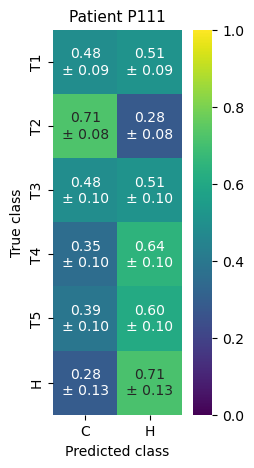

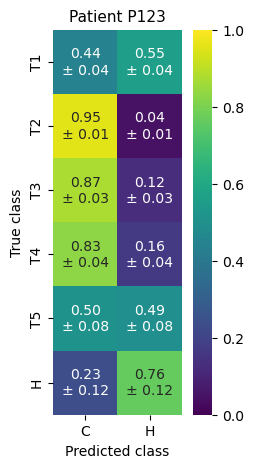

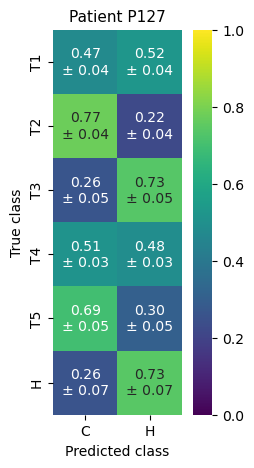

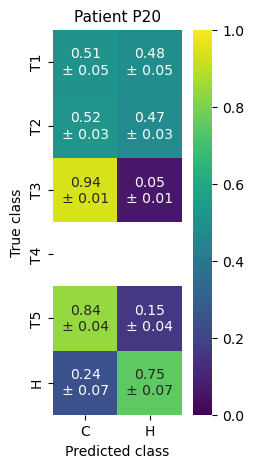

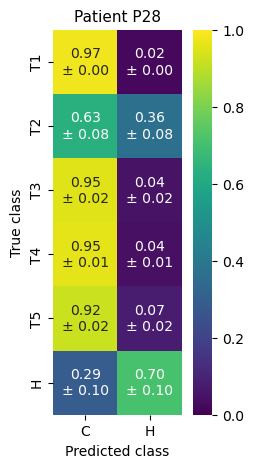

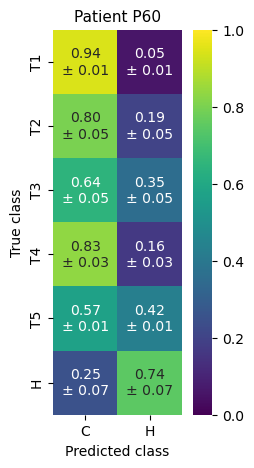

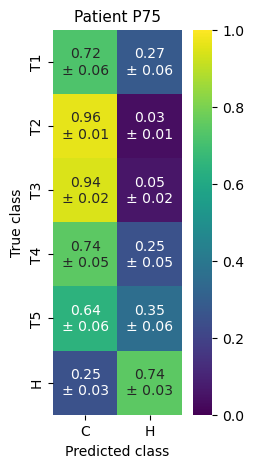

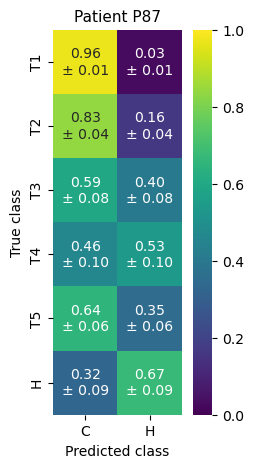

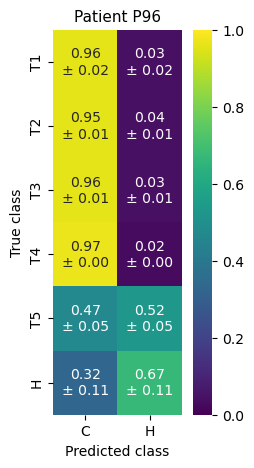

In [152]:
for p in patients:
  cms_mean = np.zeros((6, 2))
  cms_std = np.zeros((6, 2))

  for t in [1, 2, 3, 4, 5]:
    select = np.argwhere((np.array(ps) == p) & (np.array(ts) == t)).flatten()
    cms_t_mean = np.mean(np.array(cms)[select], axis=0)
    cms_t_std = np.std(np.array(cms)[select], axis=0)
    if t == 1:
      # for true label healthy
      cms_mean[-1] = cms_t_mean[1]
      cms_std[-1] = cms_t_std[1]
    # for true label disease at timepoint t
    cms_mean[t-1] = cms_t_mean[0]
    cms_std[t-1] = cms_t_std[0]

  cms_df = pd.DataFrame(cms_mean, index=['T1', 'T2', 'T3', 'T4', 'T5', 'H'], columns=['C', 'H'])
  fig, ax = plt.subplots(figsize=[3, 5])
  ax = sns.heatmap(
      cms_df,
      annot=pd.DataFrame(cms_mean.astype(str)).applymap(lambda x : x[:4]) + '\n± ' + pd.DataFrame(cms_std.astype(str)).applymap(lambda x : x[:4]),
      fmt='s',
      cmap='viridis',
      vmin=0,
      vmax=1,
      # cbar=False,
  )
  ax.set_xlabel('Predicted class')
  ax.set_ylabel('True class')
  ax.set_title(f'Patient {p}', size=11)
  ax.set_aspect(1)
  fig.show()

## Plate 12

In [153]:
plate_id = 12
m = 200
data = PlateDataset([plate_id], strict_discard=False)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.61it/s]


In [154]:
counts = data.info.groupby(['patient', 'time'])[['cell']].count().rename(columns={'cell':'count'})
few = counts[counts['count'] < m]
print(few)
enough = counts[counts['count'] >= m].index.copy()
enough = counts.loc[enough].reset_index()
print(enough.groupby('time').count())  # check that healty is smallest group
enough_samples = (enough['patient'] + '_' + enough['time'].apply(str)).str.split('_0', expand=True)[0].values
print(enough_samples)

Empty DataFrame
Columns: [count]
Index: []
      patient  count
time                
0           4      4
1          10     10
2          10     10
3          10     10
4           6      6
5           8      8
['H09' 'H19' 'H43' 'H49' 'P118_1' 'P118_2' 'P118_3' 'P118_4' 'P118_5'
 'P155_1' 'P155_2' 'P155_3' 'P164_1' 'P164_2' 'P164_3' 'P164_4' 'P164_5'
 'P21_1' 'P21_2' 'P21_3' 'P21_5' 'P71_1' 'P71_2' 'P71_3' 'P73_1' 'P73_2'
 'P73_3' 'P73_4' 'P73_5' 'P80_1' 'P80_2' 'P80_3' 'P80_4' 'P80_5' 'P82_1'
 'P82_2' 'P82_3' 'P82_5' 'P89_1' 'P89_2' 'P89_3' 'P89_4' 'P89_5' 'P95_1'
 'P95_2' 'P95_3' 'P95_4' 'P95_5']


In [155]:
enough[enough['time'] == 1]

patient  time  count
4     P118     1   7729
9     P155     1   5973
12    P164     1   5570
17     P21     1   2452
21     P71     1    821
24     P73     1   2796
29     P80     1   3353
34     P82     1   1482
38     P89     1    780
43     P95     1   5727

In [156]:
enough[enough['time'] == 0]

patient  time  count
0     H09     0   4958
1     H19     0   3237
2     H43     0   4233
3     H49     0   5081

In [157]:
healthy = enough[enough['time'] == 0]['patient'].unique()
patients = enough[enough['time'] == 1]['patient'].unique()
nc, nh = how_many_cells_per_condition_patient(patients, healthy, enough)
nc, nh

(780, 1950)

In [158]:
labels = torch.from_numpy((data.info['group'] == 'healthy').values).float()
dataset = TensorDataset(T.CenterCrop(28)(data.imgs), labels)

np.random.seed(13423)
confusion = {}
cms = []
enough = enough.reset_index()
enough = enough.set_index(['patient', 'time'])
for h, p in tqdm(list(product(healthy, patients))):
  healthy_train = healthy[healthy != h]
  patients_train = patients[patients != p]
  train_idx = np.concatenate([np.random.choice(np.argwhere(
      ((data.info['time'].values == 1) & (data.info['patient'].values == x))).flatten(),
                                                size=nc, replace=False) for x in patients_train]
              + [np.random.choice(np.argwhere(
                                  (data.info['patient'].values == x)).flatten(),
                                                size=nh, replace=False) for x in healthy_train])
  train_dataset = Subset(dataset, train_idx.tolist())
  print(h, p, ': training dataset size: ', len(train_dataset))

  k = min(enough.loc[(p, 1), 'count'], enough.loc[(h, 0), 'count'])
  test_idx = np.concatenate([np.random.choice(np.argwhere(
      ((data.info['time'] == 1) & (data.info['patient'] == p)).values).flatten(), size=k, replace=False),
                              np.random.choice(np.argwhere(
                                  (data.info['patient'] == h).values).flatten(), size=k, replace=False)])
  test_dataset = Subset(dataset, test_idx)

  model = Classifier().to(device)
  _ = train_model_with_datasets(model, train_dataset, val_dataset=test_dataset, fname=f'patch_plate{plate_id}_t1_{p}_{h}_{patients_train[0]}_{patients_train[1]}_{patients_train[2]}',
                  plot=False, save_model=False, num_epochs=30, batch_size=64, lr=0.001, device=device)

  for t in [1, 2, 3, 4, 5]:
    if not (p, t) in set(enough.index.values):
      continue
    test_idx = np.concatenate([np.argwhere(((data.info['time'] == t) & (data.info['patient'] == p)).values).flatten(),
                               np.argwhere((data.info['patient'] == h).values).flatten()])

    test_dataset = Subset(dataset, test_idx)
    preds, labs = eval_model_on_dataset(model, test_dataset, device=device)
    cms.append((h, p, t, patients_train, confusion_matrix(labs, preds, normalize='true')))

  0%|                                                                                                                                                                                          | 0/40 [00:00<?, ?it/s]

H09 P118 : training dataset size:  12870


epoch: 29; train loss: 0.07878139; val loss: 1.13084130; train accuracy: 0.97031857; val accuracy: 0.69433239 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:15<00:00,  1.97it/s]
  2%|████▍                                                                                                                                                                             | 1/40 [00:15<10:20, 15.91s/it]

H09 P155 : training dataset size:  12870


epoch: 29; train loss: 0.09279636; val loss: 1.72413286; train accuracy: 0.96231546; val accuracy: 0.62323518 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:17<00:00,  1.67it/s]
  5%|████████▉                                                                                                                                                                         | 2/40 [00:34<10:57, 17.32s/it]

H09 P164 : training dataset size:  12870


epoch: 29; train loss: 0.06646923; val loss: 1.24134522; train accuracy: 0.97567988; val accuracy: 0.68414683 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:15<00:00,  1.92it/s]
  8%|█████████████▎                                                                                                                                                                    | 3/40 [00:50<10:21, 16.79s/it]

H09 P21 : training dataset size:  12870


epoch: 29; train loss: 0.07172655; val loss: 0.70022287; train accuracy: 0.97187257; val accuracy: 0.81810767 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:14<00:00,  2.01it/s]
 10%|█████████████████▊                                                                                                                                                                | 4/40 [01:05<09:43, 16.20s/it]

H09 P71 : training dataset size:  12870


epoch: 29; train loss: 0.07441800; val loss: 0.32328328; train accuracy: 0.97125097; val accuracy: 0.90742996 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:13<00:00,  2.26it/s]
 12%|██████████████████████▎                                                                                                                                                           | 5/40 [01:19<08:53, 15.25s/it]

H09 P73 : training dataset size:  12870


epoch: 29; train loss: 0.08281477; val loss: 0.42297713; train accuracy: 0.96822067; val accuracy: 0.89574392 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:12<00:00,  2.34it/s]
 15%|██████████████████████████▋                                                                                                                                                       | 6/40 [01:32<08:20, 14.72s/it]

H09 P80 : training dataset size:  12870


epoch: 29; train loss: 0.08224157; val loss: 0.52363286; train accuracy: 0.96946387; val accuracy: 0.89606323 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:15<00:00,  1.93it/s]
 18%|███████████████████████████████▏                                                                                                                                                  | 7/40 [01:48<08:19, 15.14s/it]

H09 P82 : training dataset size:  12870


epoch: 29; train loss: 0.07086992; val loss: 0.45832046; train accuracy: 0.97435897; val accuracy: 0.91565452 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:13<00:00,  2.28it/s]
 20%|███████████████████████████████████▌                                                                                                                                              | 8/40 [02:02<07:48, 14.66s/it]

H09 P89 : training dataset size:  12870


epoch: 29; train loss: 0.07911400; val loss: 0.36279246; train accuracy: 0.97202797; val accuracy: 0.90769231 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:12<00:00,  2.36it/s]
 22%|████████████████████████████████████████                                                                                                                                          | 9/40 [02:16<07:28, 14.46s/it]

H09 P95 : training dataset size:  12870


epoch: 29; train loss: 0.07231917; val loss: 0.95780827; train accuracy: 0.97202797; val accuracy: 0.74173054 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:14<00:00,  2.01it/s]
 25%|████████████████████████████████████████████▎                                                                                                                                    | 10/40 [02:32<07:26, 14.87s/it]

H19 P118 : training dataset size:  12870


epoch: 29; train loss: 0.04696498; val loss: 1.58502349; train accuracy: 0.98368298; val accuracy: 0.70682731 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:14<00:00,  2.10it/s]
 28%|████████████████████████████████████████████████▋                                                                                                                                | 11/40 [02:47<07:11, 14.86s/it]

H19 P155 : training dataset size:  12870


epoch: 29; train loss: 0.04338097; val loss: 1.77419493; train accuracy: 0.98539239; val accuracy: 0.59345073 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:13<00:00,  2.21it/s]
 30%|█████████████████████████████████████████████████████                                                                                                                            | 12/40 [03:01<06:48, 14.57s/it]

H19 P164 : training dataset size:  12870


epoch: 29; train loss: 0.04932504; val loss: 1.60735551; train accuracy: 0.98298368; val accuracy: 0.60812481 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:13<00:00,  2.19it/s]
 32%|█████████████████████████████████████████████████████████▌                                                                                                                       | 13/40 [03:15<06:33, 14.57s/it]

H19 P21 : training dataset size:  12870


epoch: 29; train loss: 0.05002005; val loss: 1.83354449; train accuracy: 0.98290598; val accuracy: 0.71818923 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:12<00:00,  2.32it/s]
 35%|█████████████████████████████████████████████████████████████▉                                                                                                                   | 14/40 [03:28<06:08, 14.17s/it]

H19 P71 : training dataset size:  12870


epoch: 29; train loss: 0.06763728; val loss: 0.85935700; train accuracy: 0.97676768; val accuracy: 0.81242387 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:12<00:00,  2.34it/s]
 38%|██████████████████████████████████████████████████████████████████▍                                                                                                              | 15/40 [03:41<05:45, 13.84s/it]

H19 P73 : training dataset size:  12870


epoch: 29; train loss: 0.06845919; val loss: 0.79849828; train accuracy: 0.97420357; val accuracy: 0.83637339 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:13<00:00,  2.21it/s]
 40%|██████████████████████████████████████████████████████████████████████▊                                                                                                          | 16/40 [03:55<05:33, 13.88s/it]

H19 P80 : training dataset size:  12870


epoch: 29; train loss: 0.09333276; val loss: 1.32847948; train accuracy: 0.96332556; val accuracy: 0.74884152 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:13<00:00,  2.18it/s]
 42%|███████████████████████████████████████████████████████████████████████████▏                                                                                                     | 17/40 [04:10<05:21, 13.96s/it]

H19 P82 : training dataset size:  12870


epoch: 29; train loss: 0.07662795; val loss: 0.98219903; train accuracy: 0.97171717; val accuracy: 0.82692308 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:12<00:00,  2.31it/s]
 45%|███████████████████████████████████████████████████████████████████████████████▋                                                                                                 | 18/40 [04:23<05:03, 13.77s/it]

H19 P89 : training dataset size:  12870


epoch: 29; train loss: 0.07159018; val loss: 0.59110719; train accuracy: 0.97202797; val accuracy: 0.86666667 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:12<00:00,  2.45it/s]
 48%|████████████████████████████████████████████████████████████████████████████████████                                                                                             | 19/40 [04:36<04:42, 13.43s/it]

H19 P95 : training dataset size:  12870


epoch: 29; train loss: 0.04451465; val loss: 1.65121245; train accuracy: 0.98523699; val accuracy: 0.66388631 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:13<00:00,  2.18it/s]
 50%|████████████████████████████████████████████████████████████████████████████████████████▌                                                                                        | 20/40 [04:50<04:33, 13.67s/it]

H43 P118 : training dataset size:  12870


epoch: 29; train loss: 0.07570324; val loss: 0.96525140; train accuracy: 0.97218337; val accuracy: 0.74332625 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:14<00:00,  2.07it/s]
 52%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                    | 21/40 [05:05<04:27, 14.09s/it]

H43 P155 : training dataset size:  12870


epoch: 29; train loss: 0.07260108; val loss: 1.39056987; train accuracy: 0.97171717; val accuracy: 0.63619183 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:14<00:00,  2.07it/s]
 55%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                               | 22/40 [05:20<04:17, 14.31s/it]

H43 P164 : training dataset size:  12870


epoch: 29; train loss: 0.06619490; val loss: 1.23535731; train accuracy: 0.97567988; val accuracy: 0.64764942 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:14<00:00,  2.13it/s]
 57%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                           | 23/40 [05:34<04:04, 14.39s/it]

H43 P21 : training dataset size:  12870


epoch: 29; train loss: 0.07255688; val loss: 0.61481112; train accuracy: 0.97264957; val accuracy: 0.84339315 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:13<00:00,  2.26it/s]
 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                      | 24/40 [05:48<03:46, 14.16s/it]

H43 P71 : training dataset size:  12870


epoch: 29; train loss: 0.08323322; val loss: 0.43118373; train accuracy: 0.96728827; val accuracy: 0.88306943 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:12<00:00,  2.37it/s]
 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                  | 25/40 [06:01<03:26, 13.79s/it]

H43 P73 : training dataset size:  12870


epoch: 29; train loss: 0.06347385; val loss: 0.41661680; train accuracy: 0.97700078; val accuracy: 0.89234621 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:13<00:00,  2.23it/s]
 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                              | 26/40 [06:15<03:13, 13.83s/it]

H43 P80 : training dataset size:  12870


epoch: 29; train loss: 0.06169901; val loss: 0.42276426; train accuracy: 0.97785548; val accuracy: 0.90053683 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:14<00:00,  2.14it/s]
 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 27/40 [06:29<03:02, 14.02s/it]

H43 P82 : training dataset size:  12870


epoch: 29; train loss: 0.07337778; val loss: 0.34580807; train accuracy: 0.97241647; val accuracy: 0.92982456 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:12<00:00,  2.39it/s]
 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 28/40 [06:42<02:44, 13.69s/it]

H43 P89 : training dataset size:  12870


epoch: 29; train loss: 0.08053379; val loss: 0.35666570; train accuracy: 0.97086247; val accuracy: 0.90064103 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:12<00:00,  2.36it/s]
 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 29/40 [06:55<02:28, 13.52s/it]

H43 P95 : training dataset size:  12870


epoch: 29; train loss: 0.08797146; val loss: 0.84020288; train accuracy: 0.96604507; val accuracy: 0.76281597 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:14<00:00,  2.13it/s]
 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 30/40 [07:10<02:19, 13.94s/it]

H49 P118 : training dataset size:  12870


epoch: 29; train loss: 0.07066659; val loss: 1.01652653; train accuracy: 0.97319347; val accuracy: 0.76421964 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:14<00:00,  2.05it/s]
 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 31/40 [07:25<02:09, 14.34s/it]

H49 P155 : training dataset size:  12870


epoch: 29; train loss: 0.06779833; val loss: 1.60227874; train accuracy: 0.97544678; val accuracy: 0.63589845 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:14<00:00,  2.03it/s]
 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 32/40 [07:41<01:56, 14.57s/it]

H49 P164 : training dataset size:  12870


epoch: 29; train loss: 0.07008249; val loss: 1.51730036; train accuracy: 0.97466977; val accuracy: 0.61670931 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:14<00:00,  2.04it/s]
 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 33/40 [07:56<01:43, 14.77s/it]

H49 P21 : training dataset size:  12870


epoch: 29; train loss: 0.08079752; val loss: 0.70103554; train accuracy: 0.96752137; val accuracy: 0.83095432 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:13<00:00,  2.27it/s]
 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 34/40 [08:09<01:26, 14.42s/it]

H49 P71 : training dataset size:  12870


epoch: 29; train loss: 0.09113753; val loss: 0.29162562; train accuracy: 0.96550117; val accuracy: 0.90925700 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:12<00:00,  2.46it/s]
 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 35/40 [08:22<01:09, 13.84s/it]

H49 P73 : training dataset size:  12870


epoch: 29; train loss: 0.08270548; val loss: 0.34318488; train accuracy: 0.96946387; val accuracy: 0.91809728 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:13<00:00,  2.23it/s]
 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 36/40 [08:36<00:55, 13.86s/it]

H49 P80 : training dataset size:  12870


epoch: 29; train loss: 0.08243162; val loss: 0.58128548; train accuracy: 0.96736597; val accuracy: 0.87891441 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:14<00:00,  2.14it/s]
 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 37/40 [08:50<00:42, 14.04s/it]

H49 P82 : training dataset size:  12870


epoch: 29; train loss: 0.08587926; val loss: 0.26462238; train accuracy: 0.96658897; val accuracy: 0.94095816 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:12<00:00,  2.39it/s]
 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 38/40 [09:03<00:27, 13.72s/it]

H49 P89 : training dataset size:  12870


epoch: 29; train loss: 0.08035481; val loss: 0.35067755; train accuracy: 0.96907537; val accuracy: 0.91025641 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:12<00:00,  2.38it/s]
 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 39/40 [09:16<00:13, 13.52s/it]

H49 P95 : training dataset size:  12870


epoch: 29; train loss: 0.07373536; val loss: 1.05839846; train accuracy: 0.97218337; val accuracy: 0.71964180 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:14<00:00,  2.04it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [09:32<00:00, 14.30s/it]


In [159]:
import pickle

confusion = cms
with open(f'/ewsc/hschluet/models/pbmc5/rerun/plate_{plate_id}_confusion_t1_new.pkl', 'wb') as handle:
    pickle.dump(confusion, handle, protocol=pickle.HIGHEST_PROTOCOL)

# with open('filename.pickle', 'rb') as handle:
#     b = pickle.load(handle)

In [160]:
hs, ps, ts, _, cms = zip(*confusion)
cms_dfs = []

pats = np.unique(ps)
for p in pats:
    cms_mean = np.zeros((6, 2))
    cms_std = np.zeros((6, 2))

    for t in [1, 2, 3, 4, 5]:
        select = np.argwhere((np.array(ps) == p) & (np.array(ts) == t)).flatten()
        cms_t_mean = np.mean(np.array(cms)[select], axis=0)
        cms_t_std = np.std(np.array(cms)[select], axis=0)
        if t == 1:
            # for true label healthy
            cms_mean[-1] = cms_t_mean[1]
            cms_std[-1] = cms_t_std[1]
        # for true label disease at timepoint t
        cms_mean[t-1] = cms_t_mean[0]
        cms_std[t-1] = cms_t_std[0]


    cms_df = pd.DataFrame(cms_mean, index=['T1', 'T2', 'T3', 'T4', 'T5', 'H'], columns=['C', 'H']).drop(columns=['C'])
    cms_df['std'] = cms_std[:, 0]
    cms_df['pred H %'] = cms_df['H']
    cms_df['score'] = cms_df['H'] / cms_df.loc['H', 'H']
    cms_df['patient'] = p
    cms_df['plate'] = plate_id
    cms_df.index.name = 'TP'
    cms_df = cms_df.reset_index()
    cms_df['time'] = cms_df['TP'].replace({'T1' : 1, 'T2' : 2, 'T3':3, 'T4':4, 'T5':5, 'H':0})
    cms_df.loc[cms_df['time'] == 0, 'patient'] = 'H???'
    cms_dfs.append(cms_df.drop(columns=['H', 'TP']))

cms_df = pd.concat(cms_dfs, ignore_index=True)
cms_df = cms_df.rename(columns={'H':'pred H %'}).sort_values(by=['patient', 'time']).reset_index(drop=True)
cms_df.to_csv(f'/ewsc/hschluet/models/pbmc5/rerun/within_plate_{plate_id}_from_scratch_results.csv')
cms_df

/tmp/ipykernel_2628142/1678131924.py:30: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cms_df['time'] = cms_df['TP'].replace({'T1' : 1, 'T2' : 2, 'T3':3, 'T4':4, 'T5':5, 'H':0})
/local_home/hschluet/anaconda3/envs/img-39/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/local_home/hschluet/anaconda3/envs/img-39/lib/python3.9/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/local_home/hschluet/anaconda3/envs/img-39/lib/python3.9/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/local_home/hsc

std  pred H %     score patient  plate  time
0   0.098578  0.771860  1.000000    H???     12     0
1   0.090377  0.845592  1.000000    H???     12     0
2   0.093077  0.846117  1.000000    H???     12     0
3   0.142367  0.753686  1.000000    H???     12     0
4   0.092832  0.779233  1.000000    H???     12     0
5   0.065756  0.805363  1.000000    H???     12     0
6   0.129901  0.726035  1.000000    H???     12     0
7   0.096540  0.813808  1.000000    H???     12     0
8   0.040120  0.840820  1.000000    H???     12     0
9   0.068302  0.814082  1.000000    H???     12     0
10  0.079328  0.316309  0.409800    P118     12     1
11  0.056687  0.438561  0.568187    P118     12     2
12  0.051516  0.501874  0.650214    P118     12     3
13  0.047097  0.579907  0.751311    P118     12     4
14  0.037193  0.922472  1.195127    P118     12     5
15  0.064916  0.597648  0.706780    P155     12     1
16  0.004328  0.967581  1.144264    P155     12     2
17  0.015953  0.781352  0.924029    P155     12     3
18       NaN       NaN       NaN    P155     12     4
19       NaN       NaN       NaN    P155     12     5
20  0.086289  0.566876  0.669974    P164     12     1
21  0.101850  0.540697  0.639033    P164     12     2
22  0.017997  0.969546  1.145877    P164     12     3
23  0.066359  0.709884  0.838991    P164     12     4
24  0.090496  0.502878  0.594336    P164     12     5
25  0.049609  0.148858  0.197507     P21     12     1
26  0.012603  0.981948  1.302861     P21     12     2
27  0.009056  0.022385  0.029700     P21     12     3
28       NaN       NaN       NaN     P21     12     4
29  0.077038  0.306063  0.406088     P21     12     5
30  0.011603  0.033496  0.042986     P71     12     1
31  0.054102  0.574846  0.737708     P71     12     2
32  0.052569  0.298456  0.383013     P71     12     3
33       NaN       NaN       NaN     P71     12     4
34       NaN       NaN       NaN     P71     12     5
35  0.006891  0.028791  0.035749     P73     12     1
36  0.005156  0.015235  0.018917     P73     12     2
37  0.022303  0.123302  0.153101     P73     12     3
38  0.018111  0.317527  0.394266     P73     12     4
39  0.015259  0.474859  0.589621     P73     12     5
40  0.006077  0.012973  0.017869     P80     12     1
41  0.015376  0.059833  0.082411     P80     12     2
42  0.011626  0.038971  0.053676     P80     12     3
43  0.021107  0.063710  0.087750     P80     12     4
44  0.062149  0.415987  0.572956     P80     12     5
45  0.003538  0.011471  0.014095     P82     12     1
46  0.040199  0.654158  0.803823     P82     12     2
47  0.021720  0.088700  0.108994     P82     12     3
48       NaN       NaN       NaN     P82     12     4
49  0.027894  0.860771  1.057707     P82     12     5
50  0.008813  0.048077  0.057179     P89     12     1
51  0.025092  0.614677  0.731045     P89     12     2
52  0.018898  0.341917  0.406647     P89     12     3
53  0.049028  0.734016  0.872976     P89     12     4
54  0.012591  0.144518  0.171877     P89     12     5
55  0.059514  0.370526  0.455145     P95     12     1
56  0.019765  0.060302  0.074073     P95     12     2
57  0.058137  0.483996  0.594530     P95     12     3
58  0.027180  0.872541  1.071809     P95     12     4
59  0.035395  0.802876  0.986234     P95     12     5

/tmp/ipykernel_2628142/1479086869.py:21: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  annot=pd.DataFrame(cms_mean.astype(str)).applymap(lambda x : x[:4]) + '\n± ' + pd.DataFrame(cms_std.astype(str)).applymap(lambda x : x[:4]),
/local_home/hschluet/anaconda3/envs/img-39/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/local_home/hschluet/anaconda3/envs/img-39/lib/python3.9/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/local_home/hschluet/anaconda3/envs/img-39/lib/python3.9/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/local_home/hschluet/anaconda3/envs/img-39/lib/python3.9/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmea

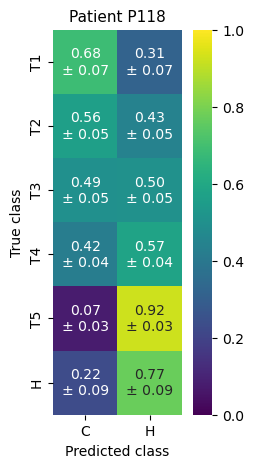

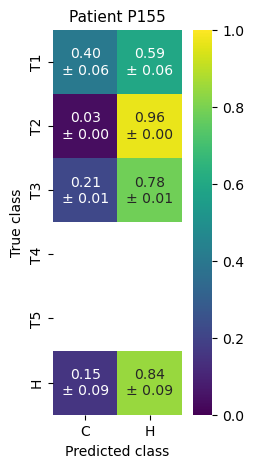

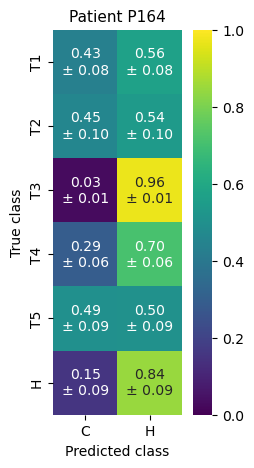

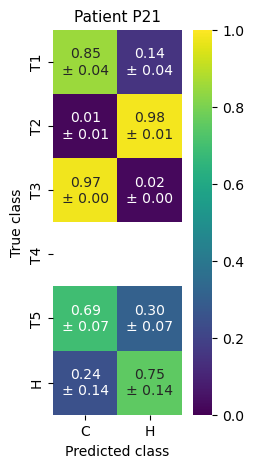

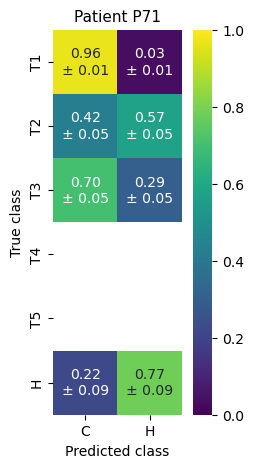

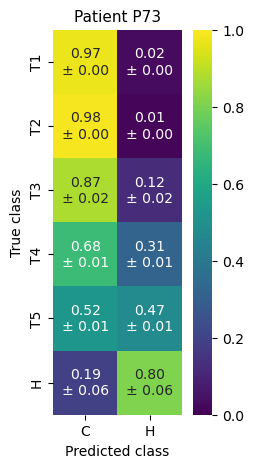

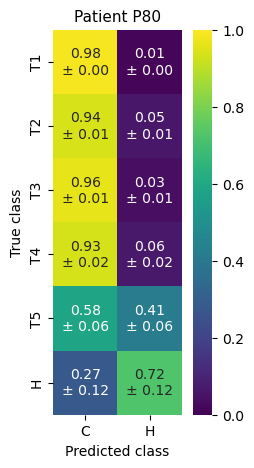

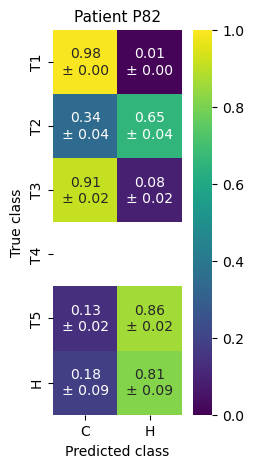

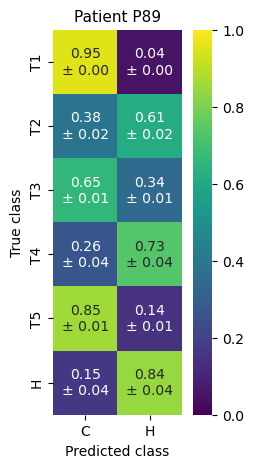

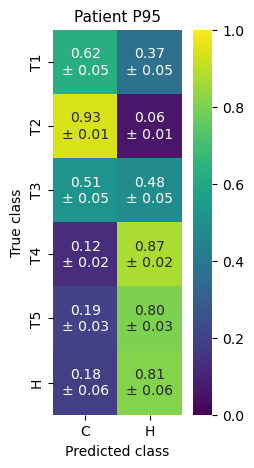

In [161]:
for p in patients:
  cms_mean = np.zeros((6, 2))
  cms_std = np.zeros((6, 2))

  for t in [1, 2, 3, 4, 5]:
    select = np.argwhere((np.array(ps) == p) & (np.array(ts) == t)).flatten()
    cms_t_mean = np.mean(np.array(cms)[select], axis=0)
    cms_t_std = np.std(np.array(cms)[select], axis=0)
    if t == 1:
      # for true label healthy
      cms_mean[-1] = cms_t_mean[1]
      cms_std[-1] = cms_t_std[1]
    # for true label disease at timepoint t
    cms_mean[t-1] = cms_t_mean[0]
    cms_std[t-1] = cms_t_std[0]

  cms_df = pd.DataFrame(cms_mean, index=['T1', 'T2', 'T3', 'T4', 'T5', 'H'], columns=['C', 'H'])
  fig, ax = plt.subplots(figsize=[3, 5])
  ax = sns.heatmap(
      cms_df,
      annot=pd.DataFrame(cms_mean.astype(str)).applymap(lambda x : x[:4]) + '\n± ' + pd.DataFrame(cms_std.astype(str)).applymap(lambda x : x[:4]),
      fmt='s',
      cmap='viridis',
      vmin=0,
      vmax=1,
      # cbar=False,
  )
  ax.set_xlabel('Predicted class')
  ax.set_ylabel('True class')
  ax.set_title(f'Patient {p}', size=11)
  ax.set_aspect(1)
  fig.show()

## Plate 11

In [162]:
plate_id = 11
m = 200
data = PlateDataset([plate_id], strict_discard=False)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.36it/s]


In [163]:
counts = data.info.groupby(['patient', 'time'])[['cell']].count().rename(columns={'cell':'count'})
few = counts[counts['count'] < m]
print(few)
enough = counts[counts['count'] >= m].index.copy()
enough = counts.loc[enough].reset_index()
print(enough.groupby('time').count())  # check that healty is smallest group
enough_samples = (enough['patient'] + '_' + enough['time'].apply(str)).str.split('_0', expand=True)[0].values
print(enough_samples)

              count
patient time       
P160    5        67
P165    3       146
P92     5       180
      patient  count
time                
0           4      4
1           9      9
2           9      9
3           8      8
4           8      8
5           6      6
['H16' 'H19' 'H29' 'H43' 'P143_1' 'P143_2' 'P143_3' 'P143_4' 'P143_5'
 'P152_1' 'P152_2' 'P152_3' 'P152_4' 'P152_5' 'P160_1' 'P160_2' 'P160_3'
 'P163_1' 'P163_2' 'P163_3' 'P163_4' 'P165_1' 'P165_2' 'P165_4' 'P165_5'
 'P23_1' 'P23_2' 'P23_3' 'P23_4' 'P23_5' 'P25_1' 'P25_2' 'P25_3' 'P25_4'
 'P25_5' 'P69_1' 'P69_2' 'P69_3' 'P69_4' 'P69_5' 'P92_1' 'P92_2' 'P92_3'
 'P92_4']


In [164]:
enough[enough['time'] == 1]

patient  time  count
4     P143     1    406
9     P152     1   1752
14    P160     1    488
17    P163     1   1736
21    P165     1   2253
25     P23     1   1434
30     P25     1   4299
35     P69     1   2518
40     P92     1   2318

In [165]:
enough[enough['time'] == 0]

patient  time  count
0     H16     0   1074
1     H19     0   1344
2     H29     0    893
3     H43     0    953

In [166]:
healthy = enough[enough['time'] == 0]['patient'].unique()
patients = enough[enough['time'] == 1]['patient'].unique()
nc, nh = how_many_cells_per_condition_patient(patients, healthy, enough)
nc, nh

(396, 891)

In [167]:
labels = torch.from_numpy((data.info['group'] == 'healthy').values).float()
dataset = TensorDataset(T.CenterCrop(28)(data.imgs), labels)

np.random.seed(13423)
confusion = {}
cms = []
enough = enough.reset_index()
enough = enough.set_index(['patient', 'time'])
for h, p in tqdm(list(product(healthy, patients))):
  healthy_train = healthy[healthy != h]
  patients_train = patients[patients != p]
  train_idx = np.concatenate([np.random.choice(np.argwhere(
      ((data.info['time'].values == 1) & (data.info['patient'].values == x))).flatten(),
                                                size=nc, replace=False) for x in patients_train]
              + [np.random.choice(np.argwhere(
                                  (data.info['patient'].values == x)).flatten(),
                                                size=nh, replace=False) for x in healthy_train])
  train_dataset = Subset(dataset, train_idx.tolist())
  print(h, p, ': training dataset size: ', len(train_dataset))

  k = min(enough.loc[(p, 1), 'count'], enough.loc[(h, 0), 'count'])
  test_idx = np.concatenate([np.random.choice(np.argwhere(
      ((data.info['time'] == 1) & (data.info['patient'] == p)).values).flatten(), size=k, replace=False),
                              np.random.choice(np.argwhere(
                                  (data.info['patient'] == h).values).flatten(), size=k, replace=False)])
  test_dataset = Subset(dataset, test_idx)

  model = Classifier().to(device)
  _ = train_model_with_datasets(model, train_dataset, val_dataset=test_dataset, fname=f'patch_plate{plate_id}_t1_{p}_{h}_{patients_train[0]}_{patients_train[1]}_{patients_train[2]}',
                  plot=False, save_model=False, num_epochs=30, batch_size=64, lr=0.001, device=device)

  for t in [1, 2, 3, 4, 5]:
    if not (p, t) in set(enough.index.values):
      continue
    test_idx = np.concatenate([np.argwhere(((data.info['time'] == t) & (data.info['patient'] == p)).values).flatten(),
                               np.argwhere((data.info['patient'] == h).values).flatten()])

    test_dataset = Subset(dataset, test_idx)
    preds, labs = eval_model_on_dataset(model, test_dataset, device=device)
    cms.append((h, p, t, patients_train, confusion_matrix(labs, preds, normalize='true')))

  0%|                                                                                                                                                                                          | 0/36 [00:00<?, ?it/s]

H16 P143 : training dataset size:  5841


epoch: 29; train loss: 0.03539047; val loss: 2.92836928; train accuracy: 0.99246704; val accuracy: 0.56157635 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:05<00:00,  5.03it/s]
  3%|████▉                                                                                                                                                                             | 1/36 [00:06<03:34,  6.12s/it]

H16 P152 : training dataset size:  5841


epoch: 29; train loss: 0.01318757; val loss: 3.57088196; train accuracy: 0.99931519; val accuracy: 0.49581006 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:06<00:00,  4.87it/s]
  6%|█████████▉                                                                                                                                                                        | 2/36 [00:12<03:40,  6.49s/it]

H16 P160 : training dataset size:  5841


epoch: 29; train loss: 0.04725903; val loss: 1.69262338; train accuracy: 0.98561890; val accuracy: 0.69364754 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:05<00:00,  5.12it/s]
  8%|██████████████▊                                                                                                                                                                   | 3/36 [00:18<03:26,  6.25s/it]

H16 P163 : training dataset size:  5841


epoch: 29; train loss: 0.01166960; val loss: 4.78223157; train accuracy: 0.99948639; val accuracy: 0.38594041 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:06<00:00,  4.88it/s]
 11%|███████████████████▊                                                                                                                                                              | 4/36 [00:25<03:20,  6.27s/it]

H16 P165 : training dataset size:  5841


epoch: 29; train loss: 0.06458421; val loss: 4.16890621; train accuracy: 0.97911317; val accuracy: 0.54795158 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:06<00:00,  4.89it/s]
 14%|████████████████████████▋                                                                                                                                                         | 5/36 [00:31<03:18,  6.41s/it]

H16 P23 : training dataset size:  5841


epoch: 29; train loss: 0.04613003; val loss: 3.62749505; train accuracy: 0.99007019; val accuracy: 0.71927374 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:06<00:00,  4.92it/s]
 17%|█████████████████████████████▋                                                                                                                                                    | 6/36 [00:38<03:10,  6.36s/it]

H16 P25 : training dataset size:  5841


epoch: 29; train loss: 0.02037522; val loss: 2.96818197; train accuracy: 0.99811676; val accuracy: 0.69972067 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:06<00:00,  4.90it/s]
 19%|██████████████████████████████████▌                                                                                                                                               | 7/36 [00:44<03:04,  6.37s/it]

H16 P69 : training dataset size:  5841


epoch: 29; train loss: 0.03219821; val loss: 2.40940237; train accuracy: 0.99315186; val accuracy: 0.75977654 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:06<00:00,  4.62it/s]
 22%|███████████████████████████████████████▌                                                                                                                                          | 8/36 [00:51<03:01,  6.46s/it]

H16 P92 : training dataset size:  5841


epoch: 29; train loss: 0.03010528; val loss: 2.43485188; train accuracy: 0.99469269; val accuracy: 0.76489758 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:06<00:00,  4.88it/s]
 25%|████████████████████████████████████████████▌                                                                                                                                     | 9/36 [00:57<02:53,  6.41s/it]

H19 P143 : training dataset size:  5841


epoch: 29; train loss: 0.09085234; val loss: 0.74954224; train accuracy: 0.96986817; val accuracy: 0.74507389 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:05<00:00,  5.18it/s]
 28%|█████████████████████████████████████████████████▏                                                                                                                               | 10/36 [01:03<02:43,  6.27s/it]

H19 P152 : training dataset size:  5841


epoch: 29; train loss: 0.03261210; val loss: 1.74794251; train accuracy: 0.99349426; val accuracy: 0.60305060 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:06<00:00,  4.54it/s]
 31%|██████████████████████████████████████████████████████                                                                                                                           | 11/36 [01:10<02:40,  6.43s/it]

H19 P160 : training dataset size:  5841


epoch: 29; train loss: 0.10543615; val loss: 0.72099030; train accuracy: 0.96079438; val accuracy: 0.78586066 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:05<00:00,  5.11it/s]
 33%|███████████████████████████████████████████████████████████                                                                                                                      | 12/36 [01:16<02:31,  6.29s/it]

H19 P163 : training dataset size:  5841


epoch: 29; train loss: 0.05562530; val loss: 2.02423647; train accuracy: 0.98339325; val accuracy: 0.53608631 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:06<00:00,  4.81it/s]
 36%|███████████████████████████████████████████████████████████████▉                                                                                                                 | 13/36 [01:22<02:27,  6.43s/it]

H19 P165 : training dataset size:  5841


epoch: 29; train loss: 0.07346913; val loss: 2.33119056; train accuracy: 0.97722993; val accuracy: 0.62351190 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:06<00:00,  4.81it/s]
 39%|████████████████████████████████████████████████████████████████████▊                                                                                                            | 14/36 [01:29<02:21,  6.42s/it]

H19 P23 : training dataset size:  5841


epoch: 29; train loss: 0.07332944; val loss: 0.96611831; train accuracy: 0.97671632; val accuracy: 0.79910714 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:06<00:00,  4.79it/s]
 42%|█████████████████████████████████████████████████████████████████████████▊                                                                                                       | 15/36 [01:35<02:15,  6.43s/it]

H19 P25 : training dataset size:  5841


epoch: 29; train loss: 0.06377820; val loss: 0.75454938; train accuracy: 0.98185242; val accuracy: 0.80208333 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:06<00:00,  4.55it/s]
 44%|██████████████████████████████████████████████████████████████████████████████▋                                                                                                  | 16/36 [01:42<02:11,  6.55s/it]

H19 P69 : training dataset size:  5841


epoch: 29; train loss: 0.09549135; val loss: 0.80308050; train accuracy: 0.96507447; val accuracy: 0.82589286 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:06<00:00,  4.82it/s]
 47%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                             | 17/36 [01:49<02:03,  6.52s/it]

H19 P92 : training dataset size:  5841


epoch: 29; train loss: 0.07719780; val loss: 0.84705740; train accuracy: 0.97551789; val accuracy: 0.82663690 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:06<00:00,  4.50it/s]
 50%|████████████████████████████████████████████████████████████████████████████████████████▌                                                                                        | 18/36 [01:55<01:59,  6.61s/it]

H29 P143 : training dataset size:  5841


epoch: 29; train loss: 0.06513882; val loss: 0.93184274; train accuracy: 0.98322205; val accuracy: 0.68719212 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:05<00:00,  5.15it/s]
 53%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                   | 19/36 [02:01<01:49,  6.42s/it]

H29 P152 : training dataset size:  5841


epoch: 29; train loss: 0.03454527; val loss: 2.01095653; train accuracy: 0.99058380; val accuracy: 0.55095185 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:06<00:00,  4.97it/s]
 56%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                              | 20/36 [02:08<01:41,  6.36s/it]

H29 P160 : training dataset size:  5841


epoch: 29; train loss: 0.09046437; val loss: 0.89809102; train accuracy: 0.96952577; val accuracy: 0.72540984 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:05<00:00,  5.10it/s]
 58%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                         | 21/36 [02:14<01:33,  6.25s/it]

H29 P163 : training dataset size:  5841


epoch: 29; train loss: 0.02614143; val loss: 2.48242235; train accuracy: 0.99503510; val accuracy: 0.51679731 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:06<00:00,  4.68it/s]
 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                    | 22/36 [02:20<01:28,  6.34s/it]

H29 P165 : training dataset size:  5841


epoch: 29; train loss: 0.03481653; val loss: 3.11619902; train accuracy: 0.99383667; val accuracy: 0.44120941 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:06<00:00,  4.99it/s]
 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                | 23/36 [02:26<01:21,  6.28s/it]

H29 P23 : training dataset size:  5841


epoch: 29; train loss: 0.05881430; val loss: 1.04836881; train accuracy: 0.98031159; val accuracy: 0.75139978 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:06<00:00,  4.97it/s]
 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                           | 24/36 [02:32<01:15,  6.26s/it]

H29 P25 : training dataset size:  5841


epoch: 29; train loss: 0.08231840; val loss: 1.33476949; train accuracy: 0.97329224; val accuracy: 0.69260918 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:06<00:00,  4.77it/s]
 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                      | 25/36 [02:39<01:09,  6.34s/it]

H29 P69 : training dataset size:  5841


epoch: 29; train loss: 0.05630356; val loss: 0.84010386; train accuracy: 0.98270844; val accuracy: 0.76315789 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:05<00:00,  5.12it/s]
 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 26/36 [02:45<01:02,  6.25s/it]

H29 P92 : training dataset size:  5841


epoch: 29; train loss: 0.14904392; val loss: 0.49526599; train accuracy: 0.94453005; val accuracy: 0.78723404 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:05<00:00,  5.12it/s]
 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 27/36 [02:51<00:56,  6.30s/it]

H43 P143 : training dataset size:  5841


epoch: 29; train loss: 0.12672729; val loss: 0.73123288; train accuracy: 0.95497346; val accuracy: 0.70320197 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:05<00:00,  5.43it/s]
 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 28/36 [02:57<00:48,  6.11s/it]

H43 P152 : training dataset size:  5841


epoch: 29; train loss: 0.06310086; val loss: 1.64932907; train accuracy: 0.98065400; val accuracy: 0.59968520 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:05<00:00,  5.15it/s]
 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 29/36 [03:03<00:42,  6.07s/it]

H43 P160 : training dataset size:  5841


epoch: 29; train loss: 0.09727612; val loss: 0.72353393; train accuracy: 0.96610169; val accuracy: 0.74487705 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:05<00:00,  5.26it/s]
 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 30/36 [03:09<00:35,  5.99s/it]

H43 P163 : training dataset size:  5841


epoch: 29; train loss: 0.03669178; val loss: 2.18352890; train accuracy: 0.99178223; val accuracy: 0.53462749 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:05<00:00,  5.10it/s]
 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 31/36 [03:15<00:30,  6.00s/it]

H43 P165 : training dataset size:  5841


epoch: 29; train loss: 0.09034158; val loss: 3.10061383; train accuracy: 0.97123780; val accuracy: 0.55508919 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:06<00:00,  4.83it/s]
 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 32/36 [03:21<00:24,  6.10s/it]

H43 P23 : training dataset size:  5841


epoch: 29; train loss: 0.14757405; val loss: 0.62629193; train accuracy: 0.94949495; val accuracy: 0.79538300 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:05<00:00,  5.14it/s]
 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 33/36 [03:27<00:18,  6.08s/it]

H43 P25 : training dataset size:  5841


epoch: 29; train loss: 0.09999641; val loss: 0.57761967; train accuracy: 0.96644410; val accuracy: 0.77597062 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:06<00:00,  4.82it/s]
 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 34/36 [03:34<00:12,  6.19s/it]

H43 P69 : training dataset size:  5841


epoch: 29; train loss: 0.08474701; val loss: 0.46464756; train accuracy: 0.97329224; val accuracy: 0.83997901 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:05<00:00,  5.13it/s]
 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 35/36 [03:40<00:06,  6.14s/it]

H43 P92 : training dataset size:  5841


epoch: 29; train loss: 0.11830546; val loss: 0.43963352; train accuracy: 0.95873994; val accuracy: 0.85624344 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:05<00:00,  5.13it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 36/36 [03:46<00:00,  6.28s/it]


In [168]:
import pickle

confusion = cms
with open(f'/ewsc/hschluet/models/pbmc5/rerun/plate_{plate_id}_confusion_t1_new.pkl', 'wb') as handle:
    pickle.dump(confusion, handle, protocol=pickle.HIGHEST_PROTOCOL)

# with open('filename.pickle', 'rb') as handle:
#     b = pickle.load(handle)

In [169]:
hs, ps, ts, _, cms = zip(*confusion)
cms_dfs = []

pats = np.unique(ps)
for p in pats:
    cms_mean = np.zeros((6, 2))
    cms_std = np.zeros((6, 2))

    for t in [1, 2, 3, 4, 5]:
        select = np.argwhere((np.array(ps) == p) & (np.array(ts) == t)).flatten()
        cms_t_mean = np.mean(np.array(cms)[select], axis=0)
        cms_t_std = np.std(np.array(cms)[select], axis=0)
        if t == 1:
            # for true label healthy
            cms_mean[-1] = cms_t_mean[1]
            cms_std[-1] = cms_t_std[1]
        # for true label disease at timepoint t
        cms_mean[t-1] = cms_t_mean[0]
        cms_std[t-1] = cms_t_std[0]


    cms_df = pd.DataFrame(cms_mean, index=['T1', 'T2', 'T3', 'T4', 'T5', 'H'], columns=['C', 'H']).drop(columns=['C'])
    cms_df['std'] = cms_std[:, 0]
    cms_df['pred H %'] = cms_df['H']
    cms_df['score'] = cms_df['H'] / cms_df.loc['H', 'H']
    cms_df['patient'] = p
    cms_df['plate'] = plate_id
    cms_df.index.name = 'TP'
    cms_df = cms_df.reset_index()
    cms_df['time'] = cms_df['TP'].replace({'T1' : 1, 'T2' : 2, 'T3':3, 'T4':4, 'T5':5, 'H':0})
    cms_df.loc[cms_df['time'] == 0, 'patient'] = 'H???'
    cms_dfs.append(cms_df.drop(columns=['H', 'TP']))

cms_df = pd.concat(cms_dfs, ignore_index=True)
cms_df = cms_df.rename(columns={'H':'pred H %'}).sort_values(by=['patient', 'time']).reset_index(drop=True)
cms_df.to_csv(f'/ewsc/hschluet/models/pbmc5/rerun/within_plate_{plate_id}_from_scratch_results.csv')
cms_df

/tmp/ipykernel_2628142/1678131924.py:30: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cms_df['time'] = cms_df['TP'].replace({'T1' : 1, 'T2' : 2, 'T3':3, 'T4':4, 'T5':5, 'H':0})
/tmp/ipykernel_2628142/1678131924.py:30: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cms_df['time'] = cms_df['TP'].replace({'T1' : 1, 'T2' : 2, 'T3':3, 'T4':4, 'T5':5, 'H':0})
/local_home/hschluet/anaconda3/envs/img-39/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dt

std  pred H %     score patient  plate  time
0   0.122852  0.640013  1.000000    H???     11     0
1   0.112883  0.692324  1.000000    H???     11     0
2   0.074736  0.631204  1.000000    H???     11     0
3   0.143551  0.740075  1.000000    H???     11     0
4   0.154178  0.634119  1.000000    H???     11     0
5   0.103946  0.677521  1.000000    H???     11     0
6   0.138366  0.644494  1.000000    H???     11     0
7   0.063240  0.688210  1.000000    H???     11     0
8   0.092368  0.696405  1.000000    H???     11     0
9   0.065038  0.279557  0.436799    P143     11     1
10  0.050660  0.207286  0.323879    P143     11     2
11  0.064456  0.281633  0.440042    P143     11     3
12  0.032687  0.089558  0.139931    P143     11     4
13  0.052609  0.225527  0.352378    P143     11     5
14  0.028365  0.570063  0.823404    P152     11     1
15  0.032569  0.343687  0.496425    P152     11     2
16  0.028898  0.096626  0.139567    P152     11     3
17  0.026650  0.084967  0.122728    P152     11     4
18  0.023242  0.600274  0.867041    P152     11     5
19  0.060381  0.154713  0.245108    P160     11     1
20  0.059433  0.122549  0.194151    P160     11     2
21  0.026839  0.406920  0.644672    P160     11     3
22       NaN       NaN       NaN    P160     11     4
23       NaN       NaN       NaN    P160     11     5
24  0.063641  0.747552  1.010102    P163     11     1
25  0.062131  0.315814  0.426733    P163     11     2
26  0.077874  0.398754  0.538802    P163     11     3
27  0.134583  0.412521  0.557405    P163     11     4
28       NaN       NaN       NaN    P163     11     5
29  0.088594  0.549157  0.866016    P165     11     1
30  0.058782  0.332718  0.524693    P165     11     2
31       NaN       NaN       NaN    P165     11     3
32  0.078557  0.378351  0.596656    P165     11     4
33  0.080419  0.479294  0.755844    P165     11     5
34  0.042201  0.146792  0.216661     P23     11     1
35  0.049718  0.192673  0.284379     P23     11     2
36  0.045603  0.120348  0.177631     P23     11     3
37  0.070781  0.242181  0.357452     P23     11     4
38  0.043026  0.284281  0.419590     P23     11     5
39  0.052094  0.155792  0.241728     P25     11     1
40  0.053248  0.166336  0.258087     P25     11     2
41  0.020018  0.071403  0.110789     P25     11     3
42  0.025746  0.143832  0.223170     P25     11     4
43  0.013233  0.041616  0.064571     P25     11     5
44  0.012513  0.097101  0.141092     P69     11     1
45  0.011125  0.096571  0.140322     P69     11     2
46  0.012318  0.092670  0.134654     P69     11     3
47  0.007068  0.057337  0.083314     P69     11     4
48  0.004897  0.020029  0.029103     P69     11     5
49  0.021995  0.081967  0.117700     P92     11     1
50  0.062231  0.255447  0.366808     P92     11     2
51  0.040097  0.645573  0.927008     P92     11     3
52  0.013357  0.050094  0.071932     P92     11     4
53       NaN       NaN       NaN     P92     11     5

/tmp/ipykernel_2628142/1479086869.py:21: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  annot=pd.DataFrame(cms_mean.astype(str)).applymap(lambda x : x[:4]) + '\n± ' + pd.DataFrame(cms_std.astype(str)).applymap(lambda x : x[:4]),
/tmp/ipykernel_2628142/1479086869.py:21: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  annot=pd.DataFrame(cms_mean.astype(str)).applymap(lambda x : x[:4]) + '\n± ' + pd.DataFrame(cms_std.astype(str)).applymap(lambda x : x[:4]),
/local_home/hschluet/anaconda3/envs/img-39/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/local_home/hschluet/anaconda3/envs/img-39/lib/python3.9/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/local_home/hschluet/anaconda3/envs/img-39/lib/python3.9/site-packages/numpy/core/_methods.py:265: Run

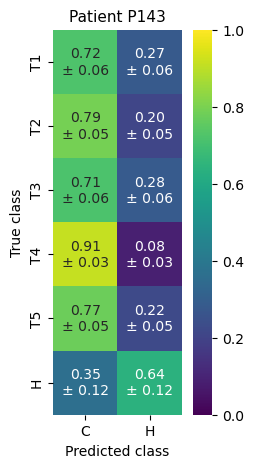

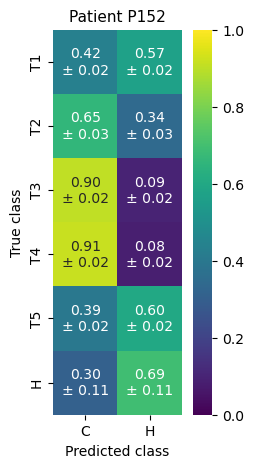

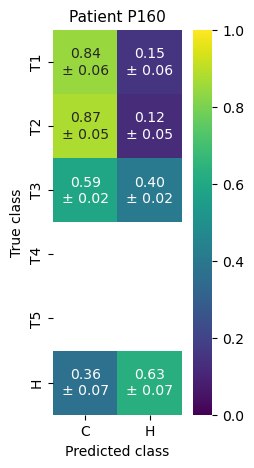

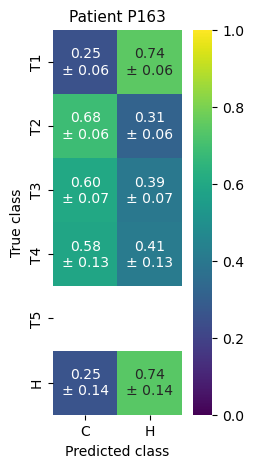

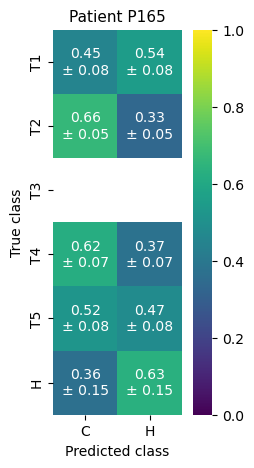

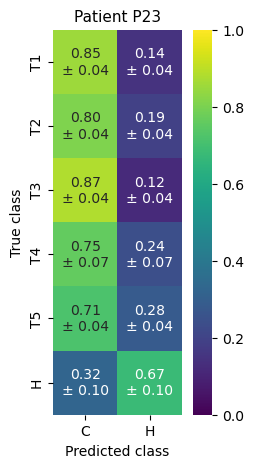

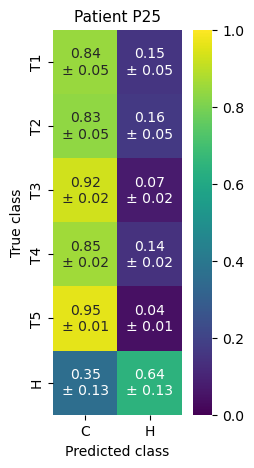

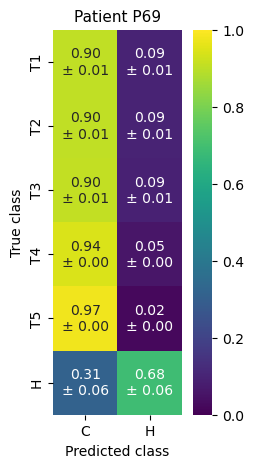

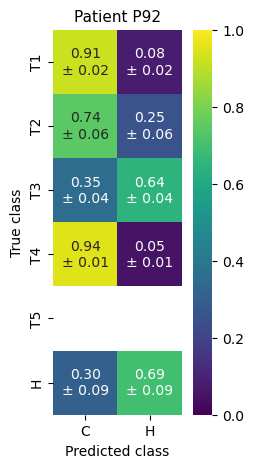

In [170]:
for p in patients:
  cms_mean = np.zeros((6, 2))
  cms_std = np.zeros((6, 2))

  for t in [1, 2, 3, 4, 5]:
    select = np.argwhere((np.array(ps) == p) & (np.array(ts) == t)).flatten()
    cms_t_mean = np.mean(np.array(cms)[select], axis=0)
    cms_t_std = np.std(np.array(cms)[select], axis=0)
    if t == 1:
      # for true label healthy
      cms_mean[-1] = cms_t_mean[1]
      cms_std[-1] = cms_t_std[1]
    # for true label disease at timepoint t
    cms_mean[t-1] = cms_t_mean[0]
    cms_std[t-1] = cms_t_std[0]

  cms_df = pd.DataFrame(cms_mean, index=['T1', 'T2', 'T3', 'T4', 'T5', 'H'], columns=['C', 'H'])
  fig, ax = plt.subplots(figsize=[3, 5])
  ax = sns.heatmap(
      cms_df,
      annot=pd.DataFrame(cms_mean.astype(str)).applymap(lambda x : x[:4]) + '\n± ' + pd.DataFrame(cms_std.astype(str)).applymap(lambda x : x[:4]),
      fmt='s',
      cmap='viridis',
      vmin=0,
      vmax=1,
      # cbar=False,
  )
  ax.set_xlabel('Predicted class')
  ax.set_ylabel('True class')
  ax.set_title(f'Patient {p}', size=11)
  ax.set_aspect(1)
  fig.show()

## Plate 10

In [171]:
plate_id = 10
m = 200
data = PlateDataset([plate_id], strict_discard=False)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.92it/s]


In [172]:
counts = data.info.groupby(['patient', 'time'])[['cell']].count().rename(columns={'cell':'count'})
few = counts[counts['count'] < m]
print(few)
enough = counts[counts['count'] >= m].index.copy()
enough = counts.loc[enough].reset_index()
print(enough.groupby('time').count())  # check that healty is smallest group
enough_samples = (enough['patient'] + '_' + enough['time'].apply(str)).str.split('_0', expand=True)[0].values
print(enough_samples)

Empty DataFrame
Columns: [count]
Index: []
      patient  count
time                
0           4      4
1           9      9
2           9      9
3           9      9
4           8      8
5           8      8
['H16' 'H29' 'H32' 'H33' 'P112_1' 'P112_2' 'P112_3' 'P112_4' 'P112_5'
 'P126_1' 'P126_2' 'P126_3' 'P126_4' 'P126_5' 'P131_1' 'P131_2' 'P131_3'
 'P131_4' 'P131_5' 'P138_1' 'P138_2' 'P138_3' 'P138_4' 'P138_5' 'P144_1'
 'P144_2' 'P144_3' 'P144_4' 'P43_1' 'P43_2' 'P43_3' 'P43_4' 'P43_5'
 'P76_1' 'P76_2' 'P76_3' 'P76_5' 'P90_1' 'P90_2' 'P90_3' 'P90_4' 'P90_5'
 'P99_1' 'P99_2' 'P99_3' 'P99_4' 'P99_5']


In [173]:
enough[enough['time'] == 1]

patient  time  count
4     P112     1   8130
9     P126     1   1550
14    P131     1   4875
19    P138     1   1881
24    P144     1   3361
28     P43     1    661
33     P76     1    473
37     P90     1   1779
42     P99     1    550

In [174]:
enough[enough['time'] == 0]

patient  time  count
0     H16     0   2338
1     H29     0   2286
2     H32     0   1966
3     H33     0   2564

In [175]:
healthy = enough[enough['time'] == 0]['patient'].unique()
patients = enough[enough['time'] == 1]['patient'].unique()
nc, nh = how_many_cells_per_condition_patient(patients, healthy, enough)
nc, nh

(472, 1062)

In [176]:
labels = torch.from_numpy((data.info['group'] == 'healthy').values).float()
dataset = TensorDataset(T.CenterCrop(28)(data.imgs), labels)

np.random.seed(13423)
confusion = {}
cms = []
enough = enough.reset_index()
enough = enough.set_index(['patient', 'time'])
for h, p in tqdm(list(product(healthy, patients))):
  healthy_train = healthy[healthy != h]
  patients_train = patients[patients != p]
  train_idx = np.concatenate([np.random.choice(np.argwhere(
      ((data.info['time'].values == 1) & (data.info['patient'].values == x))).flatten(),
                                                size=nc, replace=False) for x in patients_train]
              + [np.random.choice(np.argwhere(
                                  (data.info['patient'].values == x)).flatten(),
                                                size=nh, replace=False) for x in healthy_train])
  train_dataset = Subset(dataset, train_idx.tolist())
  print(h, p, ': training dataset size: ', len(train_dataset))

  k = min(enough.loc[(p, 1), 'count'], enough.loc[(h, 0), 'count'])
  test_idx = np.concatenate([np.random.choice(np.argwhere(
      ((data.info['time'] == 1) & (data.info['patient'] == p)).values).flatten(), size=k, replace=False),
                              np.random.choice(np.argwhere(
                                  (data.info['patient'] == h).values).flatten(), size=k, replace=False)])
  test_dataset = Subset(dataset, test_idx)

  model = Classifier().to(device)
  _ = train_model_with_datasets(model, train_dataset, val_dataset=test_dataset, fname=f'patch_plate{plate_id}_t1_{p}_{h}_{patients_train[0]}_{patients_train[1]}_{patients_train[2]}',
                  plot=False, save_model=False, num_epochs=30, batch_size=64, lr=0.001, device=device)

  for t in [1, 2, 3, 4, 5]:
    if not (p, t) in set(enough.index.values):
      continue
    test_idx = np.concatenate([np.argwhere(((data.info['time'] == t) & (data.info['patient'] == p)).values).flatten(),
                               np.argwhere((data.info['patient'] == h).values).flatten()])

    test_dataset = Subset(dataset, test_idx)
    preds, labs = eval_model_on_dataset(model, test_dataset, device=device)
    cms.append((h, p, t, patients_train, confusion_matrix(labs, preds, normalize='true')))

  0%|                                                                                                                                                                                          | 0/36 [00:00<?, ?it/s]

H16 P112 : training dataset size:  6962


epoch: 29; train loss: 0.14306433; val loss: 1.71106643; train accuracy: 0.94441253; val accuracy: 0.72604790 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:08<00:00,  3.65it/s]
  3%|████▉                                                                                                                                                                             | 1/36 [00:08<04:59,  8.57s/it]

H16 P126 : training dataset size:  6962


epoch: 29; train loss: 0.10985599; val loss: 1.94085503; train accuracy: 0.95676530; val accuracy: 0.60322581 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:07<00:00,  3.88it/s]
  6%|█████████▉                                                                                                                                                                        | 2/36 [00:16<04:40,  8.25s/it]

H16 P131 : training dataset size:  6962


epoch: 29; train loss: 0.09153137; val loss: 1.88934592; train accuracy: 0.96624533; val accuracy: 0.42899914 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:08<00:00,  3.69it/s]
  8%|██████████████▊                                                                                                                                                                   | 3/36 [00:25<04:36,  8.38s/it]

H16 P138 : training dataset size:  6962


epoch: 29; train loss: 0.10441378; val loss: 1.45615897; train accuracy: 0.96107440; val accuracy: 0.73471558 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:07<00:00,  3.78it/s]
 11%|███████████████████▊                                                                                                                                                              | 4/36 [00:33<04:26,  8.32s/it]

H16 P144 : training dataset size:  6962


epoch: 29; train loss: 0.12283095; val loss: 2.19330223; train accuracy: 0.95274346; val accuracy: 0.42023097 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:08<00:00,  3.67it/s]
 14%|████████████████████████▋                                                                                                                                                         | 5/36 [00:41<04:18,  8.35s/it]

H16 P43 : training dataset size:  6962


epoch: 29; train loss: 0.14257490; val loss: 1.30719197; train accuracy: 0.94340707; val accuracy: 0.77534039 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:06<00:00,  4.30it/s]
 17%|█████████████████████████████▋                                                                                                                                                    | 6/36 [00:48<03:58,  7.96s/it]

H16 P76 : training dataset size:  6962


epoch: 29; train loss: 0.14297398; val loss: 1.57587063; train accuracy: 0.94039069; val accuracy: 0.71775899 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:06<00:00,  4.33it/s]
 19%|██████████████████████████████████▌                                                                                                                                               | 7/36 [00:56<03:43,  7.69s/it]

H16 P90 : training dataset size:  6962


epoch: 29; train loss: 0.12298839; val loss: 1.61076625; train accuracy: 0.95303074; val accuracy: 0.72681282 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:07<00:00,  3.81it/s]
 22%|███████████████████████████████████████▌                                                                                                                                          | 8/36 [01:04<03:39,  7.82s/it]

H16 P99 : training dataset size:  6962


epoch: 29; train loss: 0.12451675; val loss: 1.13582540; train accuracy: 0.95145073; val accuracy: 0.76636364 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:06<00:00,  4.34it/s]
 25%|████████████████████████████████████████████▌                                                                                                                                     | 9/36 [01:11<03:25,  7.62s/it]

H29 P112 : training dataset size:  6962


epoch: 29; train loss: 0.14223060; val loss: 0.54179694; train accuracy: 0.94110888; val accuracy: 0.81124234 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:08<00:00,  3.69it/s]
 28%|█████████████████████████████████████████████████▏                                                                                                                               | 10/36 [01:19<03:25,  7.89s/it]

H29 P126 : training dataset size:  6962


epoch: 29; train loss: 0.15344327; val loss: 0.84781276; train accuracy: 0.93579431; val accuracy: 0.65903226 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:07<00:00,  4.08it/s]
 31%|██████████████████████████████████████████████████████                                                                                                                           | 11/36 [01:27<03:15,  7.81s/it]

H29 P131 : training dataset size:  6962


epoch: 29; train loss: 0.10392975; val loss: 0.96058289; train accuracy: 0.95935076; val accuracy: 0.54374453 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:07<00:00,  3.86it/s]
 33%|███████████████████████████████████████████████████████████                                                                                                                      | 12/36 [01:35<03:09,  7.91s/it]

H29 P138 : training dataset size:  6962


epoch: 29; train loss: 0.11818090; val loss: 0.55519876; train accuracy: 0.95259983; val accuracy: 0.84662414 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:07<00:00,  3.83it/s]
 36%|███████████████████████████████████████████████████████████████▉                                                                                                                 | 13/36 [01:43<03:03,  7.98s/it]

H29 P144 : training dataset size:  6962


epoch: 29; train loss: 0.08322902; val loss: 1.32861737; train accuracy: 0.96725079; val accuracy: 0.53215223 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:10<00:00,  2.88it/s]
 39%|████████████████████████████████████████████████████████████████████▊                                                                                                            | 14/36 [01:54<03:14,  8.82s/it]

H29 P43 : training dataset size:  6962


epoch: 29; train loss: 0.13792670; val loss: 0.40660429; train accuracy: 0.94699799; val accuracy: 0.82299546 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:09<00:00,  3.14it/s]
 42%|█████████████████████████████████████████████████████████████████████████▊                                                                                                       | 15/36 [02:04<03:12,  9.15s/it]

H29 P76 : training dataset size:  6962


epoch: 29; train loss: 0.16857670; val loss: 0.23427202; train accuracy: 0.93105429; val accuracy: 0.88372093 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:08<00:00,  3.34it/s]
 44%|██████████████████████████████████████████████████████████████████████████████▋                                                                                                  | 16/36 [02:13<03:03,  9.19s/it]

H29 P90 : training dataset size:  6962


epoch: 29; train loss: 0.14374587; val loss: 0.46006836; train accuracy: 0.94024706; val accuracy: 0.82855537 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:09<00:00,  3.11it/s]
 47%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                             | 17/36 [02:23<02:58,  9.41s/it]

H29 P99 : training dataset size:  6962


epoch: 29; train loss: 0.14799312; val loss: 0.93532252; train accuracy: 0.94383798; val accuracy: 0.81363636 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:08<00:00,  3.56it/s]
 50%|████████████████████████████████████████████████████████████████████████████████████████▌                                                                                        | 18/36 [02:32<02:48,  9.33s/it]

H32 P112 : training dataset size:  6962


epoch: 29; train loss: 0.07006117; val loss: 0.76225623; train accuracy: 0.97558173; val accuracy: 0.72787386 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:09<00:00,  3.03it/s]
 53%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                   | 19/36 [02:43<02:43,  9.64s/it]

H32 P126 : training dataset size:  6962


epoch: 29; train loss: 0.10057764; val loss: 1.32769877; train accuracy: 0.96351623; val accuracy: 0.53935484 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:10<00:00,  2.98it/s]
 56%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                              | 20/36 [02:53<02:38,  9.89s/it]

H32 P131 : training dataset size:  6962


epoch: 29; train loss: 0.13504789; val loss: 0.92273964; train accuracy: 0.94053433; val accuracy: 0.57273652 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:10<00:00,  2.91it/s]
 58%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                         | 21/36 [03:04<02:32, 10.18s/it]

H32 P138 : training dataset size:  6962


epoch: 29; train loss: 0.11957542; val loss: 0.68832684; train accuracy: 0.95619075; val accuracy: 0.74322169 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:09<00:00,  3.03it/s]
 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                    | 22/36 [03:14<02:22, 10.18s/it]

H32 P144 : training dataset size:  6962


epoch: 29; train loss: 0.06508826; val loss: 1.70190501; train accuracy: 0.97787992; val accuracy: 0.50915565 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:06<00:00,  4.30it/s]
 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                | 23/36 [03:21<02:00,  9.29s/it]

H32 P43 : training dataset size:  6962


epoch: 29; train loss: 0.12132863; val loss: 0.48460969; train accuracy: 0.95259983; val accuracy: 0.78895613 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:07<00:00,  3.92it/s]
 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                           | 24/36 [03:30<01:47,  8.96s/it]

H32 P76 : training dataset size:  6962


epoch: 29; train loss: 0.10632953; val loss: 0.52970117; train accuracy: 0.96021258; val accuracy: 0.77061311 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:06<00:00,  4.45it/s]
 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                      | 25/36 [03:37<01:31,  8.35s/it]

H32 P90 : training dataset size:  6962


epoch: 29; train loss: 0.10547287; val loss: 0.80862500; train accuracy: 0.96236714; val accuracy: 0.70994941 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:07<00:00,  3.99it/s]
 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 26/36 [03:44<01:21,  8.17s/it]

H32 P99 : training dataset size:  6962


epoch: 29; train loss: 0.10112747; val loss: 0.85124916; train accuracy: 0.96251077; val accuracy: 0.68090909 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:07<00:00,  4.12it/s]
 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 27/36 [03:52<01:11,  7.97s/it]

H33 P112 : training dataset size:  6962


epoch: 29; train loss: 0.17407362; val loss: 0.79765026; train accuracy: 0.93249066; val accuracy: 0.81123245 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:07<00:00,  3.86it/s]
 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 28/36 [04:00<01:04,  8.11s/it]

H33 P126 : training dataset size:  6962


epoch: 29; train loss: 0.11049852; val loss: 1.44359452; train accuracy: 0.95935076; val accuracy: 0.65935484 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:07<00:00,  4.08it/s]
 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 29/36 [04:08<00:55,  7.97s/it]

H33 P131 : training dataset size:  6962


epoch: 29; train loss: 0.10165805; val loss: 1.66381927; train accuracy: 0.96179259; val accuracy: 0.47776911 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:08<00:00,  3.66it/s]
 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 30/36 [04:16<00:48,  8.15s/it]

H33 P138 : training dataset size:  6962


epoch: 29; train loss: 0.11959358; val loss: 1.06806001; train accuracy: 0.95475438; val accuracy: 0.77937267 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:07<00:00,  3.88it/s]
 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 31/36 [04:24<00:40,  8.11s/it]

H33 P144 : training dataset size:  6962


epoch: 29; train loss: 0.11134482; val loss: 1.53136881; train accuracy: 0.95633439; val accuracy: 0.52301092 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:07<00:00,  3.79it/s]
 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 32/36 [04:33<00:32,  8.12s/it]

H33 P43 : training dataset size:  6962


epoch: 29; train loss: 0.09322560; val loss: 1.04489541; train accuracy: 0.96538351; val accuracy: 0.80105900 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:06<00:00,  4.47it/s]
 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 33/36 [04:40<00:23,  7.77s/it]

H33 P76 : training dataset size:  6962


epoch: 29; train loss: 0.11728255; val loss: 0.80933827; train accuracy: 0.95403620; val accuracy: 0.84778013 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:06<00:00,  4.51it/s]
 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 34/36 [04:46<00:14,  7.49s/it]

H33 P90 : training dataset size:  6962


epoch: 29; train loss: 0.11417037; val loss: 1.33390449; train accuracy: 0.95604711; val accuracy: 0.76082069 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:07<00:00,  3.98it/s]
 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 35/36 [04:54<00:07,  7.58s/it]

H33 P99 : training dataset size:  6962


epoch: 29; train loss: 0.10453725; val loss: 1.00292575; train accuracy: 0.96078713; val accuracy: 0.77818182 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:06<00:00,  4.34it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 36/36 [05:01<00:00,  8.38s/it]


In [177]:
import pickle

confusion = cms
with open(f'/ewsc/hschluet/models/pbmc5/rerun/plate_{plate_id}_confusion_t1_new.pkl', 'wb') as handle:
    pickle.dump(confusion, handle, protocol=pickle.HIGHEST_PROTOCOL)

# with open('filename.pickle', 'rb') as handle:
#     b = pickle.load(handle)

In [178]:
hs, ps, ts, _, cms = zip(*confusion)
cms_dfs = []

pats = np.unique(ps)
for p in pats:
    cms_mean = np.zeros((6, 2))
    cms_std = np.zeros((6, 2))

    for t in [1, 2, 3, 4, 5]:
        select = np.argwhere((np.array(ps) == p) & (np.array(ts) == t)).flatten()
        cms_t_mean = np.mean(np.array(cms)[select], axis=0)
        cms_t_std = np.std(np.array(cms)[select], axis=0)
        if t == 1:
            # for true label healthy
            cms_mean[-1] = cms_t_mean[1]
            cms_std[-1] = cms_t_std[1]
        # for true label disease at timepoint t
        cms_mean[t-1] = cms_t_mean[0]
        cms_std[t-1] = cms_t_std[0]


    cms_df = pd.DataFrame(cms_mean, index=['T1', 'T2', 'T3', 'T4', 'T5', 'H'], columns=['C', 'H']).drop(columns=['C'])
    cms_df['std'] = cms_std[:, 0]
    cms_df['pred H %'] = cms_df['H']
    cms_df['score'] = cms_df['H'] / cms_df.loc['H', 'H']
    cms_df['patient'] = p
    cms_df['plate'] = plate_id
    cms_df.index.name = 'TP'
    cms_df = cms_df.reset_index()
    cms_df['time'] = cms_df['TP'].replace({'T1' : 1, 'T2' : 2, 'T3':3, 'T4':4, 'T5':5, 'H':0})
    cms_df.loc[cms_df['time'] == 0, 'patient'] = 'H???'
    cms_dfs.append(cms_df.drop(columns=['H', 'TP']))

cms_df = pd.concat(cms_dfs, ignore_index=True)
cms_df = cms_df.rename(columns={'H':'pred H %'}).sort_values(by=['patient', 'time']).reset_index(drop=True)
cms_df.to_csv(f'/ewsc/hschluet/models/pbmc5/rerun/within_plate_{plate_id}_from_scratch_results.csv')
cms_df

/tmp/ipykernel_2628142/1678131924.py:30: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cms_df['time'] = cms_df['TP'].replace({'T1' : 1, 'T2' : 2, 'T3':3, 'T4':4, 'T5':5, 'H':0})
/tmp/ipykernel_2628142/1678131924.py:30: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cms_df['time'] = cms_df['TP'].replace({'T1' : 1, 'T2' : 2, 'T3':3, 'T4':4, 'T5':5, 'H':0})
/tmp/ipykernel_2628142/1678131924.py:30: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explici

std  pred H %     score patient  plate  time
0   0.096456  0.638739  1.000000    H???     10     0
1   0.091912  0.693954  1.000000    H???     10     0
2   0.142253  0.759695  1.000000    H???     10     0
3   0.092930  0.660462  1.000000    H???     10     0
4   0.086110  0.770671  1.000000    H???     10     0
5   0.072331  0.626964  1.000000    H???     10     0
6   0.131018  0.614711  1.000000    H???     10     0
7   0.090069  0.585936  1.000000    H???     10     0
8   0.133470  0.628903  1.000000    H???     10     0
9   0.042621  0.104520  0.163635    P112     10     1
10  0.051758  0.642949  1.006592    P112     10     2
11  0.088985  0.531303  0.831800    P112     10     3
12  0.091535  0.494833  0.774703    P112     10     4
13  0.039284  0.734823  1.150428    P112     10     5
14  0.009431  0.463387  0.667749    P126     10     1
15  0.165736  0.397907  0.573391    P126     10     2
16  0.085762  0.535298  0.771374    P126     10     3
17  0.078554  0.790035  1.138453    P126     10     4
18  0.100107  0.671407  0.967508    P126     10     5
19  0.069651  0.747846  0.984403    P131     10     1
20  0.077243  0.754984  0.993799    P131     10     2
21  0.111890  0.483431  0.636349    P131     10     3
22  0.072269  0.792886  1.043690    P131     10     4
23  0.092322  0.731274  0.962588    P131     10     5
24  0.031797  0.110181  0.166824    P138     10     1
25  0.104242  0.371355  0.562265    P138     10     2
26  0.149202  0.527778  0.799104    P138     10     3
27  0.039824  0.151632  0.229585    P138     10     4
28  0.107420  0.422783  0.640132    P138     10     5
29  0.023825  0.779604  1.011592    P144     10     1
30  0.003448  0.015032  0.019505    P144     10     2
31  0.047391  0.575194  0.746355    P144     10     3
32  0.038320  0.435110  0.564586    P144     10     4
33       NaN       NaN       NaN    P144     10     5
34  0.029781  0.049924  0.079629     P43     10     1
35  0.014526  0.025458  0.040605     P43     10     2
36  0.009554  0.055970  0.089272     P43     10     3
37  0.080896  0.200885  0.320409     P43     10     4
38  0.035656  0.079941  0.127505     P43     10     5
39  0.002304  0.002643  0.004299     P76     10     1
40  0.022195  0.073529  0.119616     P76     10     2
41  0.043063  0.112482  0.182984     P76     10     3
42       NaN       NaN       NaN     P76     10     4
43  0.104842  0.356763  0.580376     P76     10     5
44  0.021358  0.072091  0.123036     P90     10     1
45  0.008748  0.022619  0.038603     P90     10     2
46  0.007112  0.025000  0.042667     P90     10     3
47  0.102083  0.317935  0.542610     P90     10     4
48  0.076252  0.665531  1.135843     P90     10     5
49  0.061165  0.109545  0.174185     P99     10     1
50  0.100070  0.235597  0.374616     P99     10     2
51  0.139768  0.403146  0.641030     P99     10     3
52  0.172621  0.473893  0.753524     P99     10     4
53  0.112835  0.285920  0.454632     P99     10     5

/tmp/ipykernel_2628142/1479086869.py:21: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  annot=pd.DataFrame(cms_mean.astype(str)).applymap(lambda x : x[:4]) + '\n± ' + pd.DataFrame(cms_std.astype(str)).applymap(lambda x : x[:4]),
/tmp/ipykernel_2628142/1479086869.py:21: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  annot=pd.DataFrame(cms_mean.astype(str)).applymap(lambda x : x[:4]) + '\n± ' + pd.DataFrame(cms_std.astype(str)).applymap(lambda x : x[:4]),
/tmp/ipykernel_2628142/1479086869.py:21: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  annot=pd.DataFrame(cms_mean.astype(str)).applymap(lambda x : x[:4]) + '\n± ' + pd.DataFrame(cms_std.astype(str)).applymap(lambda x : x[:4]),
/tmp/ipykernel_2628142/1479086869.py:21: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  annot=pd.DataFrame(cms_mean.astype(str)).applymap(lambda x : x[:4]) + '\n± ' 

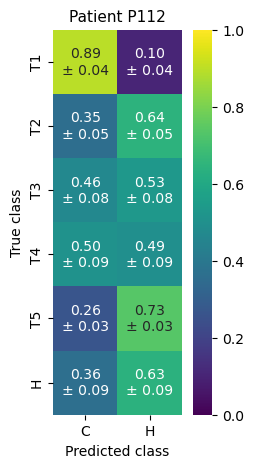

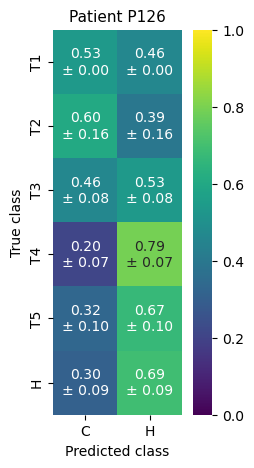

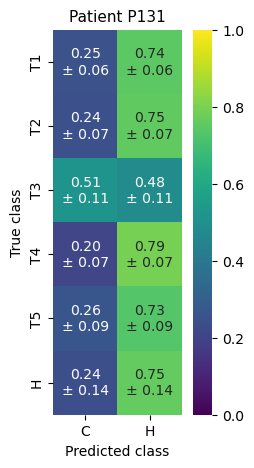

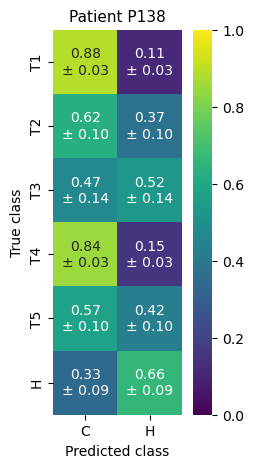

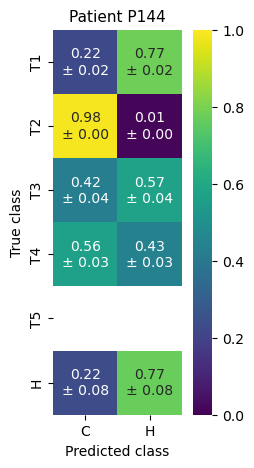

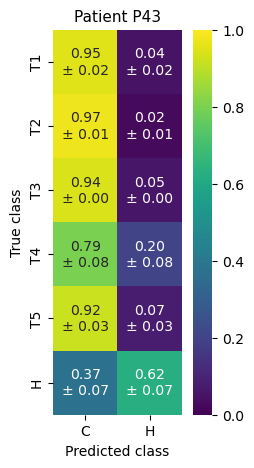

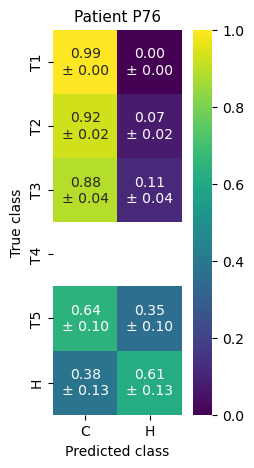

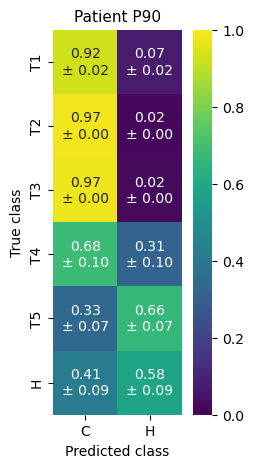

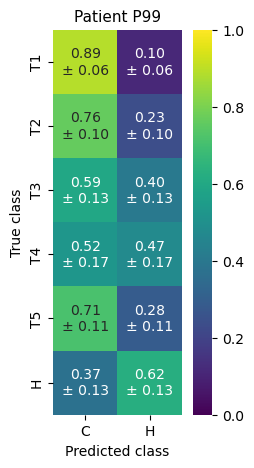

In [179]:
for p in patients:
  cms_mean = np.zeros((6, 2))
  cms_std = np.zeros((6, 2))

  for t in [1, 2, 3, 4, 5]:
    select = np.argwhere((np.array(ps) == p) & (np.array(ts) == t)).flatten()
    cms_t_mean = np.mean(np.array(cms)[select], axis=0)
    cms_t_std = np.std(np.array(cms)[select], axis=0)
    if t == 1:
      # for true label healthy
      cms_mean[-1] = cms_t_mean[1]
      cms_std[-1] = cms_t_std[1]
    # for true label disease at timepoint t
    cms_mean[t-1] = cms_t_mean[0]
    cms_std[t-1] = cms_t_std[0]

  cms_df = pd.DataFrame(cms_mean, index=['T1', 'T2', 'T3', 'T4', 'T5', 'H'], columns=['C', 'H'])
  fig, ax = plt.subplots(figsize=[3, 5])
  ax = sns.heatmap(
      cms_df,
      annot=pd.DataFrame(cms_mean.astype(str)).applymap(lambda x : x[:4]) + '\n± ' + pd.DataFrame(cms_std.astype(str)).applymap(lambda x : x[:4]),
      fmt='s',
      cmap='viridis',
      vmin=0,
      vmax=1,
      # cbar=False,
  )
  ax.set_xlabel('Predicted class')
  ax.set_ylabel('True class')
  ax.set_title(f'Patient {p}', size=11)
  ax.set_aspect(1)
  fig.show()

## Plate 9

In [180]:
plate_id = 9
m = 200
data = PlateDataset([plate_id], strict_discard=False)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.96it/s]


In [181]:
counts = data.info.groupby(['patient', 'time'])[['cell']].count().rename(columns={'cell':'count'})
few = counts[counts['count'] < m]
print(few)
enough = counts[counts['count'] >= m].index.copy()
enough = counts.loc[enough].reset_index()
print(enough.groupby('time').count())  # check that healty is smallest group
enough_samples = (enough['patient'] + '_' + enough['time'].apply(str)).str.split('_0', expand=True)[0].values
print(enough_samples)

              count
patient time       
P38     3       174
      patient  count
time                
0           4      4
1           9      9
2           9      9
3           8      8
4           9      9
5           8      8
['H20' 'H32' 'H33' 'H36' 'P133_1' 'P133_2' 'P133_3' 'P133_4' 'P133_5'
 'P156_1' 'P156_2' 'P156_3' 'P156_4' 'P156_5' 'P157_1' 'P157_2' 'P157_3'
 'P157_4' 'P157_5' 'P33_1' 'P33_2' 'P33_3' 'P33_4' 'P33_5' 'P38_1' 'P38_2'
 'P38_4' 'P38_5' 'P39_1' 'P39_2' 'P39_3' 'P39_4' 'P39_5' 'P62_1' 'P62_2'
 'P62_3' 'P62_4' 'P62_5' 'P64_1' 'P64_2' 'P64_3' 'P64_4' 'P64_5' 'P86_1'
 'P86_2' 'P86_3' 'P86_4']


In [182]:
enough[enough['time'] == 1]

patient  time  count
4     P133     1    300
9     P156     1   3301
14    P157     1   1220
19     P33     1   4052
24     P38     1   2791
28     P39     1   3384
33     P62     1   4186
38     P64     1   1433
43     P86     1   1843

In [183]:
enough[enough['time'] == 0]

patient  time  count
0     H20     0   1944
1     H32     0   2901
2     H33     0   3765
3     H36     0   1510

In [184]:
healthy = enough[enough['time'] == 0]['patient'].unique()
patients = enough[enough['time'] == 1]['patient'].unique()
nc, nh = how_many_cells_per_condition_patient(patients, healthy, enough)
nc, nh

(300, 675)

In [185]:
labels = torch.from_numpy((data.info['group'] == 'healthy').values).float()
dataset = TensorDataset(T.CenterCrop(28)(data.imgs), labels)

np.random.seed(13423)
confusion = {}
cms = []
enough = enough.reset_index()
enough = enough.set_index(['patient', 'time'])
for h, p in tqdm(list(product(healthy, patients))):
  healthy_train = healthy[healthy != h]
  patients_train = patients[patients != p]
  train_idx = np.concatenate([np.random.choice(np.argwhere(
      ((data.info['time'].values == 1) & (data.info['patient'].values == x))).flatten(),
                                                size=nc, replace=False) for x in patients_train]
              + [np.random.choice(np.argwhere(
                                  (data.info['patient'].values == x)).flatten(),
                                                size=nh, replace=False) for x in healthy_train])
  train_dataset = Subset(dataset, train_idx.tolist())
  print(h, p, ': training dataset size: ', len(train_dataset))

  k = min(enough.loc[(p, 1), 'count'], enough.loc[(h, 0), 'count'])
  test_idx = np.concatenate([np.random.choice(np.argwhere(
      ((data.info['time'] == 1) & (data.info['patient'] == p)).values).flatten(), size=k, replace=False),
                              np.random.choice(np.argwhere(
                                  (data.info['patient'] == h).values).flatten(), size=k, replace=False)])
  test_dataset = Subset(dataset, test_idx)

  model = Classifier().to(device)
  _ = train_model_with_datasets(model, train_dataset, val_dataset=test_dataset, fname=f'patch_plate{plate_id}_t1_{p}_{h}_{patients_train[0]}_{patients_train[1]}_{patients_train[2]}',
                  plot=False, save_model=False, num_epochs=30, batch_size=64, lr=0.001, device=device)

  for t in [1, 2, 3, 4, 5]:
    if not (p, t) in set(enough.index.values):
      continue
    test_idx = np.concatenate([np.argwhere(((data.info['time'] == t) & (data.info['patient'] == p)).values).flatten(),
                               np.argwhere((data.info['patient'] == h).values).flatten()])

    test_dataset = Subset(dataset, test_idx)
    preds, labs = eval_model_on_dataset(model, test_dataset, device=device)
    cms.append((h, p, t, patients_train, confusion_matrix(labs, preds, normalize='true')))

  0%|                                                                                                                                                                                          | 0/36 [00:00<?, ?it/s]

H20 P133 : training dataset size:  4425


epoch: 29; train loss: 0.16087002; val loss: 2.52564979; train accuracy: 0.93355932; val accuracy: 0.35666667 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:04<00:00,  6.65it/s]
  3%|████▉                                                                                                                                                                             | 1/36 [00:04<02:45,  4.72s/it]

H20 P156 : training dataset size:  4425


epoch: 29; train loss: 0.15156123; val loss: 1.44847769; train accuracy: 0.93672316; val accuracy: 0.64840535 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:05<00:00,  5.43it/s]
  6%|█████████▉                                                                                                                                                                        | 2/36 [00:10<03:02,  5.38s/it]

H20 P157 : training dataset size:  4425


epoch: 29; train loss: 0.03822617; val loss: 3.01985776; train accuracy: 0.99028249; val accuracy: 0.34795082 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:05<00:00,  5.74it/s]
  8%|██████████████▊                                                                                                                                                                   | 3/36 [00:16<02:58,  5.41s/it]

H20 P33 : training dataset size:  4425


epoch: 29; train loss: 0.15197771; val loss: 1.52415237; train accuracy: 0.94079096; val accuracy: 0.62242798 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:05<00:00,  5.55it/s]
 11%|███████████████████▊                                                                                                                                                              | 4/36 [00:21<02:57,  5.55s/it]

H20 P38 : training dataset size:  4425


epoch: 29; train loss: 0.17160123; val loss: 1.09073486; train accuracy: 0.93333333; val accuracy: 0.75951646 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:07<00:00,  4.01it/s]
 14%|████████████████████████▋                                                                                                                                                         | 5/36 [00:29<03:16,  6.34s/it]

H20 P39 : training dataset size:  4425


epoch: 29; train loss: 0.12556997; val loss: 1.14540821; train accuracy: 0.95661017; val accuracy: 0.74151235 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:07<00:00,  4.04it/s]
 17%|█████████████████████████████▋                                                                                                                                                    | 6/36 [00:37<03:25,  6.84s/it]

H20 P62 : training dataset size:  4425


epoch: 29; train loss: 0.20795791; val loss: 1.47632068; train accuracy: 0.91050847; val accuracy: 0.55144033 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:07<00:00,  4.23it/s]
 19%|██████████████████████████████████▌                                                                                                                                               | 7/36 [00:44<03:24,  7.04s/it]

H20 P64 : training dataset size:  4425


epoch: 29; train loss: 0.15772791; val loss: 1.06469139; train accuracy: 0.93514124; val accuracy: 0.77983252 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:06<00:00,  4.93it/s]
 22%|███████████████████████████████████████▌                                                                                                                                          | 8/36 [00:51<03:11,  6.82s/it]

H20 P86 : training dataset size:  4425


epoch: 29; train loss: 0.14915733; val loss: 0.82123169; train accuracy: 0.94259887; val accuracy: 0.81090613 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:06<00:00,  4.57it/s]
 25%|████████████████████████████████████████████▌                                                                                                                                     | 9/36 [00:57<03:03,  6.80s/it]

H32 P133 : training dataset size:  4425


epoch: 29; train loss: 0.15068414; val loss: 0.74997163; train accuracy: 0.93898305; val accuracy: 0.62166667 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:04<00:00,  7.07it/s]
 28%|█████████████████████████████████████████████████▏                                                                                                                               | 10/36 [01:02<02:38,  6.08s/it]

H32 P156 : training dataset size:  4425


epoch: 29; train loss: 0.12505822; val loss: 0.90293360; train accuracy: 0.95344633; val accuracy: 0.73198897 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:05<00:00,  5.32it/s]
 31%|██████████████████████████████████████████████████████                                                                                                                           | 11/36 [01:08<02:31,  6.05s/it]

H32 P157 : training dataset size:  4425


epoch: 29; train loss: 0.11067781; val loss: 1.56538498; train accuracy: 0.95909605; val accuracy: 0.49180328 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:04<00:00,  6.35it/s]
 33%|███████████████████████████████████████████████████████████                                                                                                                      | 12/36 [01:13<02:20,  5.84s/it]

H32 P33 : training dataset size:  4425


epoch: 29; train loss: 0.12681945; val loss: 0.88441238; train accuracy: 0.95570621; val accuracy: 0.69458807 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:05<00:00,  5.15it/s]
 36%|███████████████████████████████████████████████████████████████▉                                                                                                                 | 13/36 [01:19<02:16,  5.91s/it]

H32 P38 : training dataset size:  4425


epoch: 29; train loss: 0.18852287; val loss: 0.39941665; train accuracy: 0.92406780; val accuracy: 0.84897886 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:05<00:00,  5.36it/s]
 39%|████████████████████████████████████████████████████████████████████▊                                                                                                            | 14/36 [01:25<02:09,  5.88s/it]

H32 P39 : training dataset size:  4425


epoch: 29; train loss: 0.11601923; val loss: 0.63125658; train accuracy: 0.95774011; val accuracy: 0.80127542 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:05<00:00,  5.32it/s]
 42%|█████████████████████████████████████████████████████████████████████████▊                                                                                                       | 15/36 [01:31<02:03,  5.89s/it]

H32 P62 : training dataset size:  4425


epoch: 29; train loss: 0.12273227; val loss: 1.26505620; train accuracy: 0.95502825; val accuracy: 0.58893485 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:05<00:00,  5.26it/s]
 44%|██████████████████████████████████████████████████████████████████████████████▋                                                                                                  | 16/36 [01:37<01:58,  5.92s/it]

H32 P64 : training dataset size:  4425


epoch: 29; train loss: 0.10493013; val loss: 0.62652905; train accuracy: 0.96723164; val accuracy: 0.77529658 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:05<00:00,  5.90it/s]
 47%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                             | 17/36 [01:42<01:49,  5.75s/it]

H32 P86 : training dataset size:  4425


epoch: 29; train loss: 0.14682795; val loss: 0.36791225; train accuracy: 0.94621469; val accuracy: 0.87628866 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:04<00:00,  6.14it/s]
 50%|████████████████████████████████████████████████████████████████████████████████████████▌                                                                                        | 18/36 [01:47<01:40,  5.56s/it]

H33 P133 : training dataset size:  4425


epoch: 29; train loss: 0.14559615; val loss: 1.58556914; train accuracy: 0.94124294; val accuracy: 0.42833333 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:04<00:00,  6.52it/s]
 53%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                   | 19/36 [01:52<01:30,  5.35s/it]

H33 P156 : training dataset size:  4425


epoch: 29; train loss: 0.10634156; val loss: 1.37734856; train accuracy: 0.95683616; val accuracy: 0.72220539 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:05<00:00,  5.06it/s]
 56%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                              | 20/36 [01:59<01:30,  5.64s/it]

H33 P157 : training dataset size:  4425


epoch: 29; train loss: 0.06672333; val loss: 2.39890811; train accuracy: 0.97559322; val accuracy: 0.41721311 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:04<00:00,  6.47it/s]
 58%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                         | 21/36 [02:04<01:23,  5.53s/it]

H33 P33 : training dataset size:  4425


epoch: 29; train loss: 0.21313545; val loss: 1.25743547; train accuracy: 0.91209040; val accuracy: 0.60783533 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:06<00:00,  4.95it/s]
 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                    | 22/36 [02:10<01:20,  5.78s/it]

H33 P38 : training dataset size:  4425


epoch: 29; train loss: 0.17155198; val loss: 0.83561246; train accuracy: 0.93468927; val accuracy: 0.80544608 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:05<00:00,  5.18it/s]
 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                | 23/36 [02:16<01:16,  5.86s/it]

H33 P39 : training dataset size:  4425


epoch: 29; train loss: 0.12247752; val loss: 0.79242638; train accuracy: 0.95570621; val accuracy: 0.79092790 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:06<00:00,  4.69it/s]
 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                           | 24/36 [02:23<01:13,  6.11s/it]

H33 P62 : training dataset size:  4425


epoch: 29; train loss: 0.11389656; val loss: 1.44277886; train accuracy: 0.95796610; val accuracy: 0.59362550 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:06<00:00,  4.94it/s]
 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                      | 25/36 [02:30<01:09,  6.29s/it]

H33 P64 : training dataset size:  4425


epoch: 29; train loss: 0.20649076; val loss: 0.60521615; train accuracy: 0.91389831; val accuracy: 0.79309142 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:05<00:00,  5.22it/s]
 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 26/36 [02:36<01:02,  6.27s/it]

H33 P86 : training dataset size:  4425


epoch: 29; train loss: 0.11754539; val loss: 0.64957663; train accuracy: 0.95932203; val accuracy: 0.84454693 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:06<00:00,  4.56it/s]
 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 27/36 [02:43<00:58,  6.45s/it]

H36 P133 : training dataset size:  4425


epoch: 29; train loss: 0.12007094; val loss: 0.84529859; train accuracy: 0.95276836; val accuracy: 0.60166667 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:05<00:00,  5.97it/s]
 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 28/36 [02:48<00:48,  6.08s/it]

H36 P156 : training dataset size:  4425


epoch: 29; train loss: 0.10736824; val loss: 1.11999089; train accuracy: 0.96090395; val accuracy: 0.60960265 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:05<00:00,  5.27it/s]
 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 29/36 [02:54<00:43,  6.17s/it]

H36 P157 : training dataset size:  4425


epoch: 29; train loss: 0.05196225; val loss: 1.11798526; train accuracy: 0.98892655; val accuracy: 0.57827869 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:05<00:00,  5.47it/s]
 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 30/36 [03:00<00:36,  6.03s/it]

H36 P33 : training dataset size:  4425


epoch: 29; train loss: 0.11679454; val loss: 1.29161215; train accuracy: 0.95638418; val accuracy: 0.51225166 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:05<00:00,  5.08it/s]
 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 31/36 [03:06<00:30,  6.06s/it]

H36 P38 : training dataset size:  4425


epoch: 29; train loss: 0.07775611; val loss: 0.89317739; train accuracy: 0.97717514; val accuracy: 0.72086093 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:04<00:00,  6.13it/s]
 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 32/36 [03:11<00:23,  5.76s/it]

H36 P39 : training dataset size:  4425


epoch: 29; train loss: 0.11332936; val loss: 1.16888452; train accuracy: 0.96135593; val accuracy: 0.59238411 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:05<00:00,  5.74it/s]
 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 33/36 [03:17<00:17,  5.67s/it]

H36 P62 : training dataset size:  4425


epoch: 29; train loss: 0.10595735; val loss: 1.41298229; train accuracy: 0.96225989; val accuracy: 0.45860927 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:04<00:00,  6.12it/s]
 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 34/36 [03:22<00:11,  5.50s/it]

H36 P64 : training dataset size:  4425


epoch: 29; train loss: 0.12866065; val loss: 0.48886573; train accuracy: 0.95231638; val accuracy: 0.79413817 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:05<00:00,  5.76it/s]
 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 35/36 [03:27<00:05,  5.49s/it]

H36 P86 : training dataset size:  4425


epoch: 29; train loss: 0.07328377; val loss: 0.79387024; train accuracy: 0.97807910; val accuracy: 0.76788079 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:04<00:00,  6.12it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 36/36 [03:32<00:00,  5.91s/it]


In [186]:
import pickle

confusion = cms
with open(f'/ewsc/hschluet/models/pbmc5/rerun/plate_{plate_id}_confusion_t1_new.pkl', 'wb') as handle:
    pickle.dump(confusion, handle, protocol=pickle.HIGHEST_PROTOCOL)

# with open('filename.pickle', 'rb') as handle:
#     b = pickle.load(handle)

In [187]:
hs, ps, ts, _, cms = zip(*confusion)
cms_dfs = []

pats = np.unique(ps)
for p in pats:
    cms_mean = np.zeros((6, 2))
    cms_std = np.zeros((6, 2))

    for t in [1, 2, 3, 4, 5]:
        select = np.argwhere((np.array(ps) == p) & (np.array(ts) == t)).flatten()
        cms_t_mean = np.mean(np.array(cms)[select], axis=0)
        cms_t_std = np.std(np.array(cms)[select], axis=0)
        if t == 1:
            # for true label healthy
            cms_mean[-1] = cms_t_mean[1]
            cms_std[-1] = cms_t_std[1]
        # for true label disease at timepoint t
        cms_mean[t-1] = cms_t_mean[0]
        cms_std[t-1] = cms_t_std[0]


    cms_df = pd.DataFrame(cms_mean, index=['T1', 'T2', 'T3', 'T4', 'T5', 'H'], columns=['C', 'H']).drop(columns=['C'])
    cms_df['std'] = cms_std[:, 0]
    cms_df['pred H %'] = cms_df['H']
    cms_df['score'] = cms_df['H'] / cms_df.loc['H', 'H']
    cms_df['patient'] = p
    cms_df['plate'] = plate_id
    cms_df.index.name = 'TP'
    cms_df = cms_df.reset_index()
    cms_df['time'] = cms_df['TP'].replace({'T1' : 1, 'T2' : 2, 'T3':3, 'T4':4, 'T5':5, 'H':0})
    cms_df.loc[cms_df['time'] == 0, 'patient'] = 'H???'
    cms_dfs.append(cms_df.drop(columns=['H', 'TP']))

cms_df = pd.concat(cms_dfs, ignore_index=True)
cms_df = cms_df.rename(columns={'H':'pred H %'}).sort_values(by=['patient', 'time']).reset_index(drop=True)
cms_df.to_csv(f'/ewsc/hschluet/models/pbmc5/rerun/within_plate_{plate_id}_from_scratch_results.csv')
cms_df

/tmp/ipykernel_2628142/1678131924.py:30: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cms_df['time'] = cms_df['TP'].replace({'T1' : 1, 'T2' : 2, 'T3':3, 'T4':4, 'T5':5, 'H':0})
/tmp/ipykernel_2628142/1678131924.py:30: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cms_df['time'] = cms_df['TP'].replace({'T1' : 1, 'T2' : 2, 'T3':3, 'T4':4, 'T5':5, 'H':0})
/tmp/ipykernel_2628142/1678131924.py:30: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explici

std  pred H %     score patient  plate  time
0   0.150401  0.637734  1.000000    H???      9     0
1   0.078950  0.556640  1.000000    H???      9     0
2   0.133406  0.731713  1.000000    H???      9     0
3   0.118955  0.665907  1.000000    H???      9     0
4   0.130721  0.625737  1.000000    H???      9     0
5   0.128735  0.659920  1.000000    H???      9     0
6   0.092871  0.711887  1.000000    H???      9     0
7   0.065847  0.740083  1.000000    H???      9     0
8   0.077104  0.701103  1.000000    H???      9     0
9   0.146534  0.620000  0.972192    P133      9     1
10  0.083277  0.704656  1.104937    P133      9     2
11  0.054565  0.180221  0.282596    P133      9     3
12  0.177705  0.580474  0.910213    P133      9     4
13  0.167823  0.526546  0.825651    P133      9     5
14  0.060808  0.196001  0.352115    P156      9     1
15  0.125727  0.419505  0.753638    P156      9     2
16  0.083877  0.543388  0.976193    P156      9     3
17  0.095226  0.452194  0.812363    P156      9     4
18  0.060144  0.528020  0.948584    P156      9     5
19  0.067159  0.811066  1.108448    P157      9     1
20  0.024469  0.091871  0.125556    P157      9     2
21  0.064653  0.804444  1.099399    P157      9     3
22  0.059998  0.822839  1.124538    P157      9     4
23  0.050155  0.397399  0.543108    P157      9     5
24  0.092557  0.446878  0.671082     P33      9     1
25  0.023303  0.040489  0.060803     P33      9     2
26  0.082064  0.351916  0.528476     P33      9     3
27  0.082153  0.215661  0.323860     P33      9     4
28  0.047097  0.085766  0.128796     P33      9     5
29  0.045297  0.061000  0.097485     P38      9     1
30  0.041996  0.064815  0.103582     P38      9     2
31       NaN       NaN       NaN     P38      9     3
32  0.062386  0.093775  0.149864     P38      9     4
33  0.041114  0.063144  0.100912     P38      9     5
34  0.040648  0.190012  0.287932     P39      9     1
35  0.044757  0.251705  0.381418     P39      9     2
36  0.050294  0.465359  0.705175     P39      9     3
37  0.044278  0.155635  0.235840     P39      9     4
38  0.165492  0.566163  0.857927     P39      9     5
39  0.074141  0.617176  0.866959     P62      9     1
40  0.007221  0.020289  0.028501     P62      9     2
41  0.020831  0.118924  0.167055     P62      9     3
42  0.021456  0.139488  0.195942     P62      9     4
43  0.050329  0.633663  0.890118     P62      9     5
44  0.073787  0.174808  0.236201     P64      9     1
45  0.043000  0.112619  0.152171     P64      9     2
46  0.074564  0.210149  0.283954     P64      9     3
47  0.070239  0.230410  0.311329     P64      9     4
48  0.058245  0.708238  0.956971     P64      9     5
49  0.002574  0.052089  0.074296     P86      9     1
50  0.091867  0.767621  1.094877     P86      9     2
51  0.026006  0.127018  0.181168     P86      9     3
52  0.038177  0.438500  0.625443     P86      9     4
53       NaN       NaN       NaN     P86      9     5

/tmp/ipykernel_2628142/1479086869.py:21: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  annot=pd.DataFrame(cms_mean.astype(str)).applymap(lambda x : x[:4]) + '\n± ' + pd.DataFrame(cms_std.astype(str)).applymap(lambda x : x[:4]),
/tmp/ipykernel_2628142/1479086869.py:21: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  annot=pd.DataFrame(cms_mean.astype(str)).applymap(lambda x : x[:4]) + '\n± ' + pd.DataFrame(cms_std.astype(str)).applymap(lambda x : x[:4]),
/tmp/ipykernel_2628142/1479086869.py:21: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  annot=pd.DataFrame(cms_mean.astype(str)).applymap(lambda x : x[:4]) + '\n± ' + pd.DataFrame(cms_std.astype(str)).applymap(lambda x : x[:4]),
/tmp/ipykernel_2628142/1479086869.py:21: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  annot=pd.DataFrame(cms_mean.astype(str)).applymap(lambda x : x[:4]) + '\n± ' 

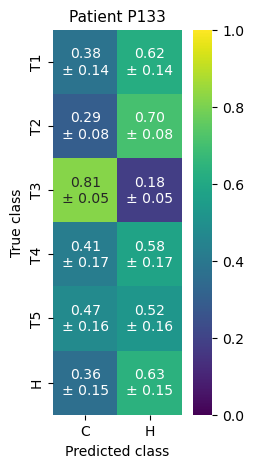

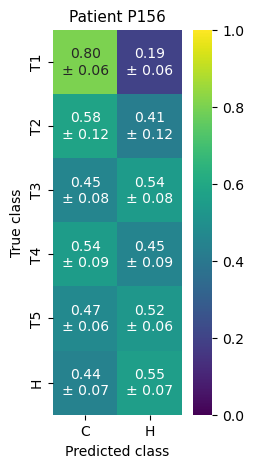

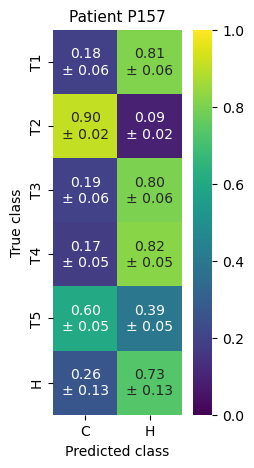

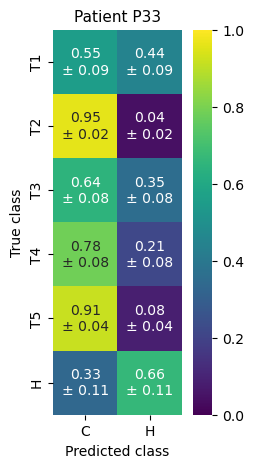

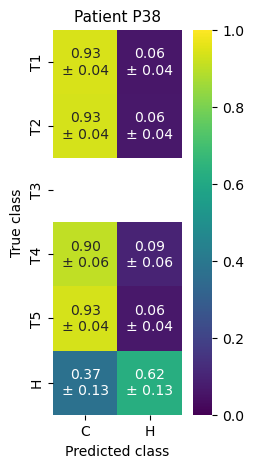

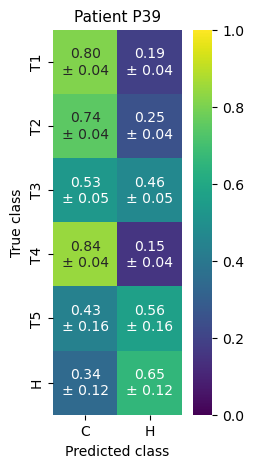

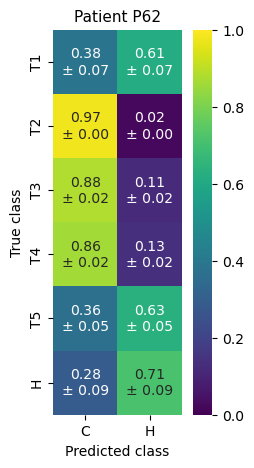

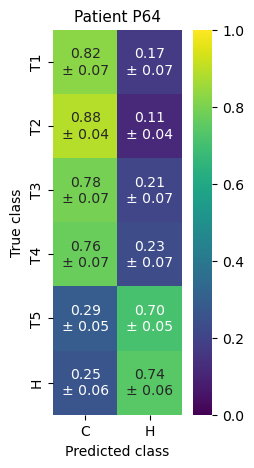

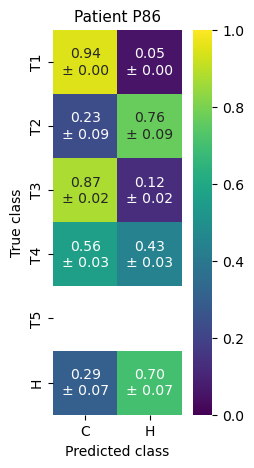

In [188]:
for p in patients:
  cms_mean = np.zeros((6, 2))
  cms_std = np.zeros((6, 2))

  for t in [1, 2, 3, 4, 5]:
    select = np.argwhere((np.array(ps) == p) & (np.array(ts) == t)).flatten()
    cms_t_mean = np.mean(np.array(cms)[select], axis=0)
    cms_t_std = np.std(np.array(cms)[select], axis=0)
    if t == 1:
      # for true label healthy
      cms_mean[-1] = cms_t_mean[1]
      cms_std[-1] = cms_t_std[1]
    # for true label disease at timepoint t
    cms_mean[t-1] = cms_t_mean[0]
    cms_std[t-1] = cms_t_std[0]

  cms_df = pd.DataFrame(cms_mean, index=['T1', 'T2', 'T3', 'T4', 'T5', 'H'], columns=['C', 'H'])
  fig, ax = plt.subplots(figsize=[3, 5])
  ax = sns.heatmap(
      cms_df,
      annot=pd.DataFrame(cms_mean.astype(str)).applymap(lambda x : x[:4]) + '\n± ' + pd.DataFrame(cms_std.astype(str)).applymap(lambda x : x[:4]),
      fmt='s',
      cmap='viridis',
      vmin=0,
      vmax=1,
      # cbar=False,
  )
  ax.set_xlabel('Predicted class')
  ax.set_ylabel('True class')
  ax.set_title(f'Patient {p}', size=11)
  ax.set_aspect(1)
  fig.show()

## Plate 8

In [189]:
plate_id = 8
m = 200
data = PlateDataset([plate_id], strict_discard=False)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.45it/s]


In [190]:
counts = data.info.groupby(['patient', 'time'])[['cell']].count().rename(columns={'cell':'count'})
few = counts[counts['count'] < m]
print(few)
enough = counts[counts['count'] >= m].index.copy()
enough = counts.loc[enough].reset_index()
print(enough.groupby('time').count())  # check that healty is smallest group
enough_samples = (enough['patient'] + '_' + enough['time'].apply(str)).str.split('_0', expand=True)[0].values
print(enough_samples)

              count
patient time       
P13     3        54
P17     1       171
      patient  count
time                
0           4      4
1           9      9
2           8      8
3          10     10
4           6      6
5           7      7
['H20' 'H26' 'H36' 'H47' 'P109_1' 'P109_3' 'P109_4' 'P109_5' 'P13_1'
 'P13_2' 'P13_4' 'P13_5' 'P162_1' 'P162_2' 'P162_3' 'P162_4' 'P162_5'
 'P17_2' 'P17_3' 'P27_1' 'P27_2' 'P27_3' 'P32_1' 'P32_2' 'P32_3' 'P36_3'
 'P36_4' 'P36_5' 'P37_1' 'P37_2' 'P37_3' 'P42_1' 'P42_2' 'P42_3' 'P42_4'
 'P42_5' 'P58_1' 'P58_2' 'P58_3' 'P58_4' 'P58_5' 'P65_1' 'P65_3' 'P65_5']


In [191]:
enough[enough['time'] == 1]

patient  time  count
4     P109     1   6799
8      P13     1   4343
12    P162     1    276
19     P27     1   6148
22     P32     1   1186
28     P37     1   1573
31     P42     1    947
36     P58     1   5100
41     P65     1   2646

In [192]:
enough[enough['time'] == 0]

patient  time  count
0     H20     0   1813
1     H26     0   3737
2     H36     0   3264
3     H47     0   5131

In [193]:
healthy = enough[enough['time'] == 0]['patient'].unique()
patients = enough[enough['time'] == 1]['patient'].unique()
nc, nh = how_many_cells_per_condition_patient(patients, healthy, enough)
nc, nh

(276, 621)

In [194]:
labels = torch.from_numpy((data.info['group'] == 'healthy').values).float()
dataset = TensorDataset(T.CenterCrop(28)(data.imgs), labels)

np.random.seed(13423)
confusion = {}
cms = []
enough = enough.reset_index()
enough = enough.set_index(['patient', 'time'])
for h, p in tqdm(list(product(healthy, patients))):
  healthy_train = healthy[healthy != h]
  patients_train = patients[patients != p]
  train_idx = np.concatenate([np.random.choice(np.argwhere(
      ((data.info['time'].values == 1) & (data.info['patient'].values == x))).flatten(),
                                                size=nc, replace=False) for x in patients_train]
              + [np.random.choice(np.argwhere(
                                  (data.info['patient'].values == x)).flatten(),
                                                size=nh, replace=False) for x in healthy_train])
  train_dataset = Subset(dataset, train_idx.tolist())
  print(h, p, ': training dataset size: ', len(train_dataset))

  k = min(enough.loc[(p, 1), 'count'], enough.loc[(h, 0), 'count'])
  test_idx = np.concatenate([np.random.choice(np.argwhere(
      ((data.info['time'] == 1) & (data.info['patient'] == p)).values).flatten(), size=k, replace=False),
                              np.random.choice(np.argwhere(
                                  (data.info['patient'] == h).values).flatten(), size=k, replace=False)])
  test_dataset = Subset(dataset, test_idx)

  model = Classifier().to(device)
  _ = train_model_with_datasets(model, train_dataset, val_dataset=test_dataset, fname=f'patch_plate{plate_id}_t1_{p}_{h}_{patients_train[0]}_{patients_train[1]}_{patients_train[2]}',
                  plot=False, save_model=False, num_epochs=30, batch_size=64, lr=0.001, device=device)

  for t in [1, 2, 3, 4, 5]:
    if not (p, t) in set(enough.index.values):
      continue
    test_idx = np.concatenate([np.argwhere(((data.info['time'] == t) & (data.info['patient'] == p)).values).flatten(),
                               np.argwhere((data.info['patient'] == h).values).flatten()])

    test_dataset = Subset(dataset, test_idx)
    preds, labs = eval_model_on_dataset(model, test_dataset, device=device)
    cms.append((h, p, t, patients_train, confusion_matrix(labs, preds, normalize='true')))

  0%|                                                                                                                                                                                          | 0/36 [00:00<?, ?it/s]

H20 P109 : training dataset size:  4071


epoch: 29; train loss: 0.04763647; val loss: 2.43348253; train accuracy: 0.99189388; val accuracy: 0.47738555 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:05<00:00,  5.64it/s]
  3%|████▉                                                                                                                                                                             | 1/36 [00:05<03:18,  5.66s/it]

H20 P13 : training dataset size:  4071


epoch: 29; train loss: 0.01998712; val loss: 2.84350801; train accuracy: 0.99901744; val accuracy: 0.46718147 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:05<00:00,  5.67it/s]
  6%|█████████▉                                                                                                                                                                        | 2/36 [00:11<03:09,  5.59s/it]

H20 P162 : training dataset size:  4071


epoch: 29; train loss: 0.05023123; val loss: 2.03291059; train accuracy: 0.98845493; val accuracy: 0.62681159 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:04<00:00,  7.18it/s]
  8%|██████████████▊                                                                                                                                                                   | 3/36 [00:15<02:47,  5.09s/it]

H20 P27 : training dataset size:  4071


epoch: 29; train loss: 0.03600763; val loss: 2.60158753; train accuracy: 0.99459592; val accuracy: 0.53998897 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:05<00:00,  5.69it/s]
 11%|███████████████████▊                                                                                                                                                              | 4/36 [00:21<02:48,  5.27s/it]

H20 P32 : training dataset size:  4071


epoch: 29; train loss: 0.05128592; val loss: 2.79451466; train accuracy: 0.99042004; val accuracy: 0.63575042 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:04<00:00,  6.50it/s]
 14%|████████████████████████▋                                                                                                                                                         | 5/36 [00:26<02:38,  5.10s/it]

H20 P37 : training dataset size:  4071


epoch: 29; train loss: 0.03364956; val loss: 2.46143842; train accuracy: 0.99680668; val accuracy: 0.66338207 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:04<00:00,  6.27it/s]
 17%|█████████████████████████████▋                                                                                                                                                    | 6/36 [00:31<02:31,  5.06s/it]

H20 P42 : training dataset size:  4071


epoch: 29; train loss: 0.04633293; val loss: 2.36549950; train accuracy: 0.99017440; val accuracy: 0.47518479 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:05<00:00,  5.15it/s]
 19%|██████████████████████████████████▌                                                                                                                                               | 7/36 [00:37<02:37,  5.44s/it]

H20 P58 : training dataset size:  4071


epoch: 29; train loss: 0.07827208; val loss: 2.13130033; train accuracy: 0.98108573; val accuracy: 0.48510756 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:06<00:00,  4.69it/s]
 22%|███████████████████████████████████████▌                                                                                                                                          | 8/36 [00:44<02:44,  5.88s/it]

H20 P65 : training dataset size:  4071


epoch: 29; train loss: 0.05817844; val loss: 1.90230811; train accuracy: 0.98698109; val accuracy: 0.67622725 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:06<00:00,  4.70it/s]
 25%|████████████████████████████████████████████▌                                                                                                                                     | 9/36 [00:50<02:45,  6.11s/it]

H26 P109 : training dataset size:  4071


epoch: 29; train loss: 0.10252874; val loss: 1.59922402; train accuracy: 0.96487350; val accuracy: 0.59325662 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:06<00:00,  4.74it/s]
 28%|█████████████████████████████████████████████████▏                                                                                                                               | 10/36 [00:57<02:43,  6.29s/it]

H26 P13 : training dataset size:  4071


epoch: 29; train loss: 0.04241521; val loss: 2.65052819; train accuracy: 0.99238516; val accuracy: 0.48769066 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:05<00:00,  5.01it/s]
 31%|██████████████████████████████████████████████████████                                                                                                                           | 11/36 [01:03<02:37,  6.28s/it]

H26 P162 : training dataset size:  4071


epoch: 29; train loss: 0.05047620; val loss: 1.57299221; train accuracy: 0.99115696; val accuracy: 0.69927536 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:04<00:00,  7.48it/s]
 33%|███████████████████████████████████████████████████████████                                                                                                                      | 12/36 [01:08<02:16,  5.70s/it]

H26 P27 : training dataset size:  4071


epoch: 29; train loss: 0.08484559; val loss: 1.94701692; train accuracy: 0.97224269; val accuracy: 0.57211667 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:06<00:00,  4.89it/s]
 36%|███████████████████████████████████████████████████████████████▉                                                                                                                 | 13/36 [01:14<02:16,  5.92s/it]

H26 P32 : training dataset size:  4071


epoch: 29; train loss: 0.12522249; val loss: 1.30558991; train accuracy: 0.95627610; val accuracy: 0.71753794 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:04<00:00,  6.89it/s]
 39%|████████████████████████████████████████████████████████████████████▊                                                                                                            | 14/36 [01:18<02:01,  5.51s/it]

H26 P37 : training dataset size:  4071


epoch: 29; train loss: 0.16487328; val loss: 1.54480022; train accuracy: 0.93318595; val accuracy: 0.66497139 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:04<00:00,  6.62it/s]
 42%|█████████████████████████████████████████████████████████████████████████▊                                                                                                       | 15/36 [01:23<01:50,  5.28s/it]

H26 P42 : training dataset size:  4071


epoch: 29; train loss: 0.06891394; val loss: 2.14134550; train accuracy: 0.97887497; val accuracy: 0.51108765 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:04<00:00,  6.51it/s]
 44%|██████████████████████████████████████████████████████████████████████████████▋                                                                                                  | 16/36 [01:28<01:43,  5.18s/it]

H26 P58 : training dataset size:  4071


epoch: 29; train loss: 0.08911221; val loss: 1.69664431; train accuracy: 0.97224269; val accuracy: 0.50508429 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:05<00:00,  5.19it/s]
 47%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                             | 17/36 [01:34<01:43,  5.47s/it]

H26 P65 : training dataset size:  4071


epoch: 29; train loss: 0.08646836; val loss: 1.33728460; train accuracy: 0.97936625; val accuracy: 0.72732426 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:05<00:00,  5.65it/s]
 50%|████████████████████████████████████████████████████████████████████████████████████████▌                                                                                        | 18/36 [01:40<01:38,  5.50s/it]

H36 P109 : training dataset size:  4071


epoch: 29; train loss: 0.03453069; val loss: 1.48498526; train accuracy: 0.99606976; val accuracy: 0.53553922 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:05<00:00,  5.34it/s]
 53%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                   | 19/36 [01:46<01:37,  5.74s/it]

H36 P13 : training dataset size:  4071


epoch: 29; train loss: 0.08124711; val loss: 1.80678651; train accuracy: 0.97150577; val accuracy: 0.48606005 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:05<00:00,  5.31it/s]
 56%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                              | 20/36 [01:52<01:32,  5.80s/it]

H36 P162 : training dataset size:  4071


epoch: 29; train loss: 0.06489845; val loss: 1.44052446; train accuracy: 0.98255957; val accuracy: 0.61231884 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:05<00:00,  5.69it/s]
 58%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                         | 21/36 [01:58<01:26,  5.79s/it]

H36 P27 : training dataset size:  4071


epoch: 29; train loss: 0.02778597; val loss: 2.27794290; train accuracy: 0.99828052; val accuracy: 0.46246936 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:07<00:00,  3.95it/s]
 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                    | 22/36 [02:06<01:30,  6.45s/it]

H36 P32 : training dataset size:  4071


epoch: 29; train loss: 0.07865850; val loss: 1.60901302; train accuracy: 0.97813805; val accuracy: 0.57040472 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:04<00:00,  6.05it/s]
 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                | 23/36 [02:11<01:19,  6.08s/it]

H36 P37 : training dataset size:  4071


epoch: 29; train loss: 0.03683667; val loss: 1.61242616; train accuracy: 0.99484156; val accuracy: 0.61792753 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:05<00:00,  5.40it/s]
 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                           | 24/36 [02:17<01:11,  5.99s/it]

H36 P42 : training dataset size:  4071


epoch: 29; train loss: 0.09961199; val loss: 1.51566136; train accuracy: 0.96806681; val accuracy: 0.51055966 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:04<00:00,  6.80it/s]
 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                      | 25/36 [02:22<01:01,  5.62s/it]

H36 P58 : training dataset size:  4071


epoch: 29; train loss: 0.11408075; val loss: 1.17522553; train accuracy: 0.96143454; val accuracy: 0.54963235 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:05<00:00,  5.10it/s]
 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 26/36 [02:28<00:57,  5.79s/it]

H36 P65 : training dataset size:  4071


epoch: 29; train loss: 0.09303270; val loss: 1.07890254; train accuracy: 0.97027757; val accuracy: 0.66685563 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:04<00:00,  6.07it/s]
 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 27/36 [02:33<00:51,  5.73s/it]

H47 P109 : training dataset size:  4071


epoch: 29; train loss: 0.03657573; val loss: 1.37924131; train accuracy: 0.99484156; val accuracy: 0.58702007 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:06<00:00,  4.53it/s]
 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 28/36 [02:40<00:48,  6.11s/it]

H47 P13 : training dataset size:  4071


epoch: 29; train loss: 0.02790925; val loss: 2.16493733; train accuracy: 0.99803488; val accuracy: 0.49907898 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:06<00:00,  4.96it/s]
 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 29/36 [02:47<00:43,  6.19s/it]

H47 P162 : training dataset size:  4071


epoch: 29; train loss: 0.07361308; val loss: 1.19515336; train accuracy: 0.98280521; val accuracy: 0.68478261 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:03<00:00,  7.62it/s]
 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 30/36 [02:51<00:34,  5.74s/it]

H47 P27 : training dataset size:  4071


epoch: 29; train loss: 0.06775445; val loss: 1.58591082; train accuracy: 0.98427905; val accuracy: 0.61313584 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:06<00:00,  4.57it/s]
 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 31/36 [02:58<00:30,  6.08s/it]

H47 P32 : training dataset size:  4071


epoch: 29; train loss: 0.09163816; val loss: 1.15279710; train accuracy: 0.97420781; val accuracy: 0.70615514 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:04<00:00,  7.00it/s]
 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 32/36 [03:03<00:22,  5.62s/it]

H47 P37 : training dataset size:  4071


epoch: 29; train loss: 0.06550631; val loss: 1.27608898; train accuracy: 0.98796365; val accuracy: 0.69612206 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:04<00:00,  6.74it/s]
 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 33/36 [03:08<00:16,  5.34s/it]

H47 P42 : training dataset size:  4071


epoch: 29; train loss: 0.05520765; val loss: 1.59699917; train accuracy: 0.98894620; val accuracy: 0.54382260 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:04<00:00,  6.54it/s]
 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 34/36 [03:13<00:10,  5.23s/it]

H47 P58 : training dataset size:  4071


epoch: 29; train loss: 0.06313216; val loss: 1.59529240; train accuracy: 0.98698109; val accuracy: 0.54274510 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:06<00:00,  4.49it/s]
 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 35/36 [03:20<00:05,  5.78s/it]

H47 P65 : training dataset size:  4071


epoch: 29; train loss: 0.05301774; val loss: 1.05063625; train accuracy: 0.99115696; val accuracy: 0.73696145 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:05<00:00,  5.66it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 36/36 [03:25<00:00,  5.71s/it]


In [195]:
import pickle

confusion = cms
with open(f'/ewsc/hschluet/models/pbmc5/rerun/plate_{plate_id}_confusion_t1_new.pkl', 'wb') as handle:
    pickle.dump(confusion, handle, protocol=pickle.HIGHEST_PROTOCOL)

# with open('filename.pickle', 'rb') as handle:
#     b = pickle.load(handle)

In [196]:
hs, ps, ts, _, cms = zip(*confusion)
cms_dfs = []

pats = np.unique(ps)
for p in pats:
    cms_mean = np.zeros((6, 2))
    cms_std = np.zeros((6, 2))

    for t in [1, 2, 3, 4, 5]:
        select = np.argwhere((np.array(ps) == p) & (np.array(ts) == t)).flatten()
        cms_t_mean = np.mean(np.array(cms)[select], axis=0)
        cms_t_std = np.std(np.array(cms)[select], axis=0)
        if t == 1:
            # for true label healthy
            cms_mean[-1] = cms_t_mean[1]
            cms_std[-1] = cms_t_std[1]
        # for true label disease at timepoint t
        cms_mean[t-1] = cms_t_mean[0]
        cms_std[t-1] = cms_t_std[0]


    cms_df = pd.DataFrame(cms_mean, index=['T1', 'T2', 'T3', 'T4', 'T5', 'H'], columns=['C', 'H']).drop(columns=['C'])
    cms_df['std'] = cms_std[:, 0]
    cms_df['pred H %'] = cms_df['H']
    cms_df['score'] = cms_df['H'] / cms_df.loc['H', 'H']
    cms_df['patient'] = p
    cms_df['plate'] = plate_id
    cms_df.index.name = 'TP'
    cms_df = cms_df.reset_index()
    cms_df['time'] = cms_df['TP'].replace({'T1' : 1, 'T2' : 2, 'T3':3, 'T4':4, 'T5':5, 'H':0})
    cms_df.loc[cms_df['time'] == 0, 'patient'] = 'H???'
    cms_dfs.append(cms_df.drop(columns=['H', 'TP']))

cms_df = pd.concat(cms_dfs, ignore_index=True)
cms_df = cms_df.rename(columns={'H':'pred H %'}).sort_values(by=['patient', 'time']).reset_index(drop=True)
cms_df.to_csv(f'/ewsc/hschluet/models/pbmc5/rerun/within_plate_{plate_id}_from_scratch_results.csv')
cms_df

/local_home/hschluet/anaconda3/envs/img-39/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/local_home/hschluet/anaconda3/envs/img-39/lib/python3.9/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/local_home/hschluet/anaconda3/envs/img-39/lib/python3.9/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/local_home/hschluet/anaconda3/envs/img-39/lib/python3.9/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/local_home/hschluet/anaconda3/envs/img-39/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/tmp/ipykernel_2628142/1678

std  pred H %     score patient  plate  time
0   0.084537  0.536906  1.000000    H???      8     0
1   0.038869  0.556947  1.000000    H???      8     0
2   0.085850  0.472698  1.000000    H???      8     0
3   0.072527  0.478588  1.000000    H???      8     0
4   0.106228  0.486746  1.000000    H???      8     0
5   0.080918  0.420156  1.000000    H???      8     0
6   0.090873  0.556673  1.000000    H???      8     0
7   0.068962  0.550564  1.000000    H???      8     0
8   0.068798  0.474972  1.000000    H???      8     0
9   0.066337  0.442197  0.823603    P109      8     1
10       NaN       NaN       NaN    P109      8     2
11  0.035955  0.528739  0.984788    P109      8     3
12  0.061786  0.249803  0.465264    P109      8     4
13  0.139623  0.510993  0.951737    P109      8     5
14  0.030434  0.588188  1.056093     P13      8     1
15  0.041253  0.230330  0.413558     P13      8     2
16       NaN       NaN       NaN     P13      8     3
17  0.089034  0.517647  0.929437     P13      8     4
18  0.047263  0.205128  0.368308     P13      8     5
19  0.025811  0.157609  0.333423    P162      8     1
20  0.193935  0.496146  1.049603    P162      8     2
21  0.068051  0.452455  0.957175    P162      8     3
22  0.030218  0.522870  1.106139    P162      8     4
23  0.042075  0.181692  0.384373    P162      8     5
24  0.058262  0.385247  0.804966     P27      8     1
25  0.022247  0.062463  0.130515     P27      8     2
26  0.022872  0.320185  0.669019     P27      8     3
27       NaN       NaN       NaN     P27      8     4
28       NaN       NaN       NaN     P27      8     5
29  0.067477  0.176223  0.362042     P32      8     1
30  0.027338  0.341933  0.702488     P32      8     2
31  0.074298  0.167164  0.343432     P32      8     3
32       NaN       NaN       NaN     P32      8     4
33       NaN       NaN       NaN     P32      8     5
34  0.043605  0.104736  0.249279     P37      8     1
35  0.133660  0.355578  0.846301     P37      8     2
36  0.046317  0.096436  0.229524     P37      8     3
37       NaN       NaN       NaN     P37      8     4
38       NaN       NaN       NaN     P37      8     5
39  0.078963  0.523495  0.940400     P42      8     1
40  0.052201  0.475646  0.854445     P42      8     2
41  0.048327  0.199674  0.358692     P42      8     3
42  0.021480  0.287170  0.515868     P42      8     4
43  0.114199  0.611955  1.099308     P42      8     5
44  0.067224  0.509069  0.924631     P58      8     1
45  0.035449  0.290397  0.527454     P58      8     2
46  0.022148  0.075513  0.137155     P58      8     3
47  0.026411  0.120532  0.218925     P58      8     4
48  0.042841  0.359358  0.652708     P58      8     5
49  0.021876  0.073602  0.154960     P65      8     1
50       NaN       NaN       NaN     P65      8     2
51  0.017703  0.247293  0.520648     P65      8     3
52       NaN       NaN       NaN     P65      8     4
53  0.021277  0.283505  0.596887     P65      8     5

/local_home/hschluet/anaconda3/envs/img-39/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/local_home/hschluet/anaconda3/envs/img-39/lib/python3.9/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/local_home/hschluet/anaconda3/envs/img-39/lib/python3.9/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/local_home/hschluet/anaconda3/envs/img-39/lib/python3.9/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/local_home/hschluet/anaconda3/envs/img-39/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/tmp/ipykernel_2628142/1479

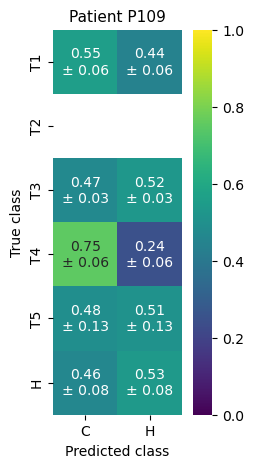

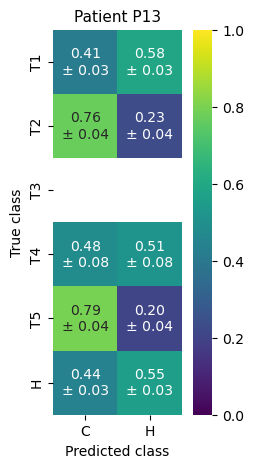

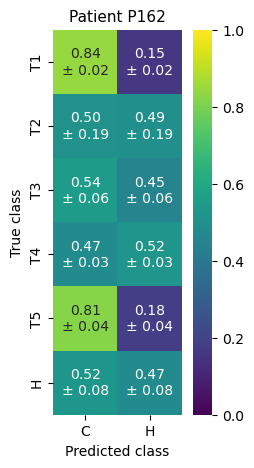

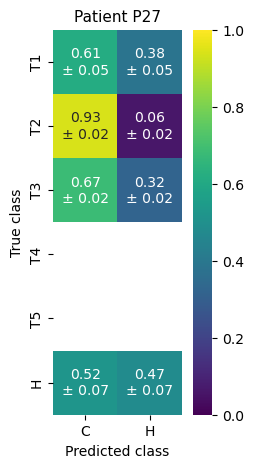

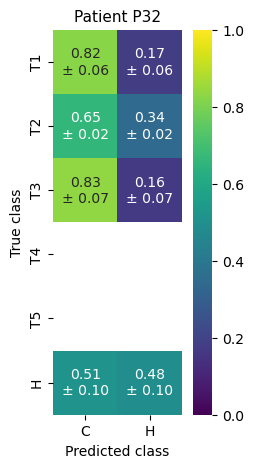

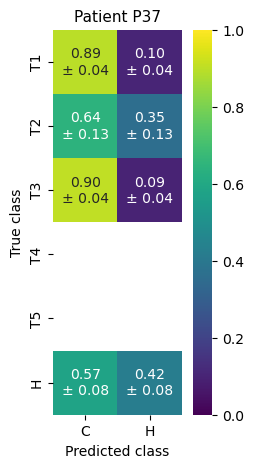

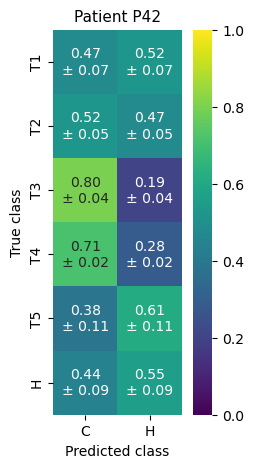

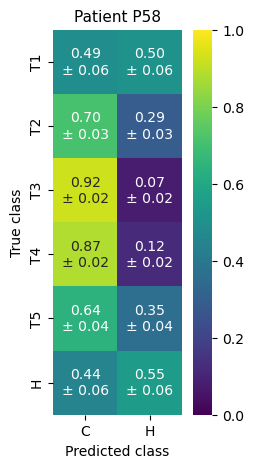

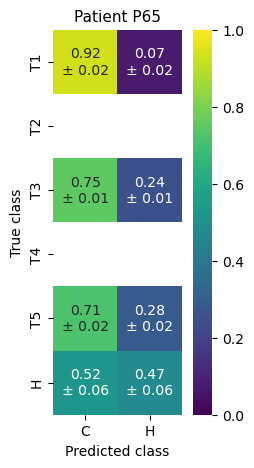

In [197]:
for p in patients:
  cms_mean = np.zeros((6, 2))
  cms_std = np.zeros((6, 2))

  for t in [1, 2, 3, 4, 5]:
    select = np.argwhere((np.array(ps) == p) & (np.array(ts) == t)).flatten()
    cms_t_mean = np.mean(np.array(cms)[select], axis=0)
    cms_t_std = np.std(np.array(cms)[select], axis=0)
    if t == 1:
      # for true label healthy
      cms_mean[-1] = cms_t_mean[1]
      cms_std[-1] = cms_t_std[1]
    # for true label disease at timepoint t
    cms_mean[t-1] = cms_t_mean[0]
    cms_std[t-1] = cms_t_std[0]

  cms_df = pd.DataFrame(cms_mean, index=['T1', 'T2', 'T3', 'T4', 'T5', 'H'], columns=['C', 'H'])
  fig, ax = plt.subplots(figsize=[3, 5])
  ax = sns.heatmap(
      cms_df,
      annot=pd.DataFrame(cms_mean.astype(str)).applymap(lambda x : x[:4]) + '\n± ' + pd.DataFrame(cms_std.astype(str)).applymap(lambda x : x[:4]),
      fmt='s',
      cmap='viridis',
      vmin=0,
      vmax=1,
      # cbar=False,
  )
  ax.set_xlabel('Predicted class')
  ax.set_ylabel('True class')
  ax.set_title(f'Patient {p}', size=11)
  ax.set_aspect(1)
  fig.show()

## Plate 7

In [198]:
plate_id = 7
m = 200
data = PlateDataset([plate_id], strict_discard=False)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.38it/s]


In [199]:
counts = data.info.groupby(['patient', 'time'])[['cell']].count().rename(columns={'cell':'count'})
few = counts[counts['count'] < m]
print(few)
enough = counts[counts['count'] >= m].index.copy()
enough = counts.loc[enough].reset_index()
print(enough.groupby('time').count())  # check that healty is smallest group
enough_samples = (enough['patient'] + '_' + enough['time'].apply(str)).str.split('_0', expand=True)[0].values
print(enough_samples)

Empty DataFrame
Columns: [count]
Index: []
      patient  count
time                
0           4      4
1           9      9
2           9      9
3           9      9
4           9      9
5           8      8
['H22' 'H26' 'H37' 'H47' 'P102_1' 'P102_2' 'P102_3' 'P102_4' 'P105_1'
 'P105_2' 'P105_3' 'P105_4' 'P105_5' 'P119_1' 'P119_2' 'P119_3' 'P119_4'
 'P119_5' 'P128_1' 'P128_2' 'P128_3' 'P128_4' 'P128_5' 'P134_1' 'P134_2'
 'P134_3' 'P134_4' 'P134_5' 'P48_1' 'P48_2' 'P48_3' 'P48_4' 'P48_5'
 'P59_1' 'P59_2' 'P59_3' 'P59_4' 'P59_5' 'P70_1' 'P70_2' 'P70_3' 'P70_4'
 'P70_5' 'P83_1' 'P83_2' 'P83_3' 'P83_4' 'P83_5']


In [200]:
enough[enough['time'] == 1]

patient  time  count
4     P102     1   1079
8     P105     1   7776
13    P119     1   3540
18    P128     1   3886
23    P134     1   1676
28     P48     1   1647
33     P59     1   2607
38     P70     1   3159
43     P83     1   1430

In [201]:
enough[enough['time'] == 0]

patient  time  count
0     H22     0   2675
1     H26     0   4884
2     H37     0   4620
3     H47     0   6830

In [202]:
healthy = enough[enough['time'] == 0]['patient'].unique()
patients = enough[enough['time'] == 1]['patient'].unique()
nc, nh = how_many_cells_per_condition_patient(patients, healthy, enough)
nc, nh

(1076, 2421)

In [203]:
labels = torch.from_numpy((data.info['group'] == 'healthy').values).float()
dataset = TensorDataset(T.CenterCrop(28)(data.imgs), labels)

np.random.seed(13423)
confusion = {}
cms = []
enough = enough.reset_index()
enough = enough.set_index(['patient', 'time'])
for h, p in tqdm(list(product(healthy, patients))):
  healthy_train = healthy[healthy != h]
  patients_train = patients[patients != p]
  train_idx = np.concatenate([np.random.choice(np.argwhere(
      ((data.info['time'].values == 1) & (data.info['patient'].values == x))).flatten(),
                                                size=nc, replace=False) for x in patients_train]
              + [np.random.choice(np.argwhere(
                                  (data.info['patient'].values == x)).flatten(),
                                                size=nh, replace=False) for x in healthy_train])
  train_dataset = Subset(dataset, train_idx.tolist())
  print(h, p, ': training dataset size: ', len(train_dataset))

  k = min(enough.loc[(p, 1), 'count'], enough.loc[(h, 0), 'count'])
  test_idx = np.concatenate([np.random.choice(np.argwhere(
      ((data.info['time'] == 1) & (data.info['patient'] == p)).values).flatten(), size=k, replace=False),
                              np.random.choice(np.argwhere(
                                  (data.info['patient'] == h).values).flatten(), size=k, replace=False)])
  test_dataset = Subset(dataset, test_idx)

  model = Classifier().to(device)
  _ = train_model_with_datasets(model, train_dataset, val_dataset=test_dataset, fname=f'patch_plate{plate_id}_t1_{p}_{h}_{patients_train[0]}_{patients_train[1]}_{patients_train[2]}',
                  plot=False, save_model=False, num_epochs=30, batch_size=64, lr=0.001, device=device)

  for t in [1, 2, 3, 4, 5]:
    if not (p, t) in set(enough.index.values):
      continue
    test_idx = np.concatenate([np.argwhere(((data.info['time'] == t) & (data.info['patient'] == p)).values).flatten(),
                               np.argwhere((data.info['patient'] == h).values).flatten()])

    test_dataset = Subset(dataset, test_idx)
    preds, labs = eval_model_on_dataset(model, test_dataset, device=device)
    cms.append((h, p, t, patients_train, confusion_matrix(labs, preds, normalize='true')))

  0%|                                                                                                                                                                                          | 0/36 [00:00<?, ?it/s]

H22 P102 : training dataset size:  15871


epoch: 29; train loss: 0.13854706; val loss: 1.89663368; train accuracy: 0.94524605; val accuracy: 0.74652456 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:15<00:00,  1.93it/s]
  3%|████▉                                                                                                                                                                             | 1/36 [00:16<09:27, 16.21s/it]

H22 P105 : training dataset size:  15871


epoch: 29; train loss: 0.10499981; val loss: 1.86487806; train accuracy: 0.95885577; val accuracy: 0.61551402 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:16<00:00,  1.85it/s]
  6%|█████████▉                                                                                                                                                                        | 2/36 [00:33<09:25, 16.64s/it]

H22 P119 : training dataset size:  15871


epoch: 29; train loss: 0.09738426; val loss: 2.43399906; train accuracy: 0.96307731; val accuracy: 0.55158879 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:16<00:00,  1.81it/s]
  8%|██████████████▊                                                                                                                                                                   | 3/36 [00:50<09:12, 16.76s/it]

H22 P128 : training dataset size:  15871


epoch: 29; train loss: 0.09958162; val loss: 2.03219308; train accuracy: 0.96244723; val accuracy: 0.66747664 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:16<00:00,  1.81it/s]
 11%|███████████████████▊                                                                                                                                                              | 4/36 [01:06<08:58, 16.82s/it]

H22 P134 : training dataset size:  15871


epoch: 29; train loss: 0.06028506; val loss: 4.95888138; train accuracy: 0.97763216; val accuracy: 0.33293556 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:15<00:00,  1.90it/s]
 14%|████████████████████████▋                                                                                                                                                         | 5/36 [01:23<08:34, 16.59s/it]

H22 P48 : training dataset size:  15871


epoch: 29; train loss: 0.12601280; val loss: 1.52530566; train accuracy: 0.95097977; val accuracy: 0.74499089 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:16<00:00,  1.81it/s]
 17%|█████████████████████████████▋                                                                                                                                                    | 6/36 [01:39<08:20, 16.67s/it]

H22 P59 : training dataset size:  15871


epoch: 29; train loss: 0.09632274; val loss: 2.17258533; train accuracy: 0.96364438; val accuracy: 0.60414269 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:16<00:00,  1.77it/s]
 19%|██████████████████████████████████▌                                                                                                                                               | 7/36 [01:57<08:08, 16.86s/it]

H22 P70 : training dataset size:  15871


epoch: 29; train loss: 0.13295643; val loss: 1.65513816; train accuracy: 0.94795539; val accuracy: 0.72336449 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:16<00:00,  1.77it/s]
 22%|███████████████████████████████████████▌                                                                                                                                          | 8/36 [02:14<07:55, 16.98s/it]

H22 P83 : training dataset size:  15871


epoch: 29; train loss: 0.11105611; val loss: 1.38233891; train accuracy: 0.95784765; val accuracy: 0.77202797 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:15<00:00,  1.88it/s]
 25%|████████████████████████████████████████████▌                                                                                                                                     | 9/36 [02:30<07:32, 16.76s/it]

H26 P102 : training dataset size:  15871


epoch: 29; train loss: 0.12312431; val loss: 0.68971163; train accuracy: 0.95324806; val accuracy: 0.79657090 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:16<00:00,  1.87it/s]
 28%|█████████████████████████████████████████████████▏                                                                                                                               | 10/36 [02:47<07:12, 16.64s/it]

H26 P105 : training dataset size:  15871


epoch: 29; train loss: 0.08866473; val loss: 1.16724581; train accuracy: 0.96862201; val accuracy: 0.66144554 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:18<00:00,  1.66it/s]
 31%|██████████████████████████████████████████████████████                                                                                                                           | 11/36 [03:05<07:10, 17.21s/it]

H26 P119 : training dataset size:  15871


epoch: 29; train loss: 0.10576144; val loss: 1.55849643; train accuracy: 0.96049398; val accuracy: 0.55141243 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:16<00:00,  1.84it/s]
 33%|███████████████████████████████████████████████████████████                                                                                                                      | 12/36 [03:22<06:49, 17.08s/it]

H26 P128 : training dataset size:  15871


epoch: 29; train loss: 0.10118120; val loss: 1.03699884; train accuracy: 0.96326633; val accuracy: 0.70959856 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:16<00:00,  1.79it/s]
 36%|███████████████████████████████████████████████████████████████▉                                                                                                                 | 13/36 [03:39<06:33, 17.11s/it]

H26 P134 : training dataset size:  15871


epoch: 29; train loss: 0.08756744; val loss: 1.73401962; train accuracy: 0.96673177; val accuracy: 0.53221957 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:15<00:00,  1.97it/s]
 39%|████████████████████████████████████████████████████████████████████▊                                                                                                            | 14/36 [03:55<06:06, 16.67s/it]

H26 P48 : training dataset size:  15871


epoch: 29; train loss: 0.11460780; val loss: 0.68992302; train accuracy: 0.95822569; val accuracy: 0.81876138 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:15<00:00,  1.92it/s]
 42%|█████████████████████████████████████████████████████████████████████████▊                                                                                                       | 15/36 [04:11<05:45, 16.45s/it]

H26 P59 : training dataset size:  15871


epoch: 29; train loss: 0.11434110; val loss: 1.18354503; train accuracy: 0.95526432; val accuracy: 0.64441887 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:16<00:00,  1.87it/s]
 44%|██████████████████████████████████████████████████████████████████████████████▋                                                                                                  | 16/36 [04:27<05:28, 16.44s/it]

H26 P70 : training dataset size:  15871


epoch: 29; train loss: 0.14226665; val loss: 0.59458788; train accuracy: 0.94241069; val accuracy: 0.78996518 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:16<00:00,  1.85it/s]
 47%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                             | 17/36 [04:44<05:13, 16.48s/it]

H26 P83 : training dataset size:  15871


epoch: 29; train loss: 0.11994999; val loss: 0.63909635; train accuracy: 0.95198790; val accuracy: 0.82937063 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:15<00:00,  1.94it/s]
 50%|████████████████████████████████████████████████████████████████████████████████████████▌                                                                                        | 18/36 [05:00<04:53, 16.30s/it]

H37 P102 : training dataset size:  15871


epoch: 29; train loss: 0.12145818; val loss: 0.84790367; train accuracy: 0.95198790; val accuracy: 0.82020389 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:14<00:00,  2.00it/s]
 53%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                   | 19/36 [05:15<04:31, 16.00s/it]

H37 P105 : training dataset size:  15871


epoch: 29; train loss: 0.11818743; val loss: 1.29620427; train accuracy: 0.95431920; val accuracy: 0.62932900 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:17<00:00,  1.74it/s]
 56%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                              | 20/36 [05:32<04:23, 16.49s/it]

H37 P119 : training dataset size:  15871


epoch: 29; train loss: 0.11527392; val loss: 1.28522502; train accuracy: 0.95677651; val accuracy: 0.62146893 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:16<00:00,  1.80it/s]
 58%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                         | 21/36 [05:50<04:10, 16.67s/it]

H37 P128 : training dataset size:  15871


epoch: 29; train loss: 0.10507900; val loss: 1.17923349; train accuracy: 0.96093504; val accuracy: 0.70509521 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:16<00:00,  1.83it/s]
 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                    | 22/36 [06:06<03:53, 16.71s/it]

H37 P134 : training dataset size:  15871


epoch: 29; train loss: 0.07831438; val loss: 2.69701794; train accuracy: 0.97152038; val accuracy: 0.47583532 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:15<00:00,  1.93it/s]
 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                | 23/36 [06:22<03:34, 16.48s/it]

H37 P48 : training dataset size:  15871


epoch: 29; train loss: 0.13170959; val loss: 0.83966756; train accuracy: 0.94707328; val accuracy: 0.77625987 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:15<00:00,  1.97it/s]
 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                           | 24/36 [06:38<03:14, 16.19s/it]

H37 P59 : training dataset size:  15871


epoch: 29; train loss: 0.10558236; val loss: 1.41287903; train accuracy: 0.95948585; val accuracy: 0.63406214 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:15<00:00,  1.88it/s]
 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                      | 25/36 [06:55<02:59, 16.35s/it]

H37 P70 : training dataset size:  15871


epoch: 29; train loss: 0.12908536; val loss: 0.86973706; train accuracy: 0.94808141; val accuracy: 0.79423868 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:16<00:00,  1.86it/s]
 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 26/36 [07:11<02:43, 16.39s/it]

H37 P83 : training dataset size:  15871


epoch: 29; train loss: 0.12022070; val loss: 0.72197509; train accuracy: 0.95476025; val accuracy: 0.84265734 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:15<00:00,  1.98it/s]
 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 27/36 [07:27<02:25, 16.12s/it]

H47 P102 : training dataset size:  15871


epoch: 29; train loss: 0.09440686; val loss: 2.32639921; train accuracy: 0.96282528; val accuracy: 0.73076923 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:15<00:00,  1.96it/s]
 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 28/36 [07:42<02:07, 15.99s/it]

H47 P105 : training dataset size:  15871


epoch: 29; train loss: 0.12740232; val loss: 1.63798331; train accuracy: 0.95047571; val accuracy: 0.62474378 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:18<00:00,  1.63it/s]
 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 29/36 [08:01<01:57, 16.85s/it]

H47 P119 : training dataset size:  15871


epoch: 29; train loss: 0.08184557; val loss: 1.95003930; train accuracy: 0.96988218; val accuracy: 0.59901130 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:16<00:00,  1.84it/s]
 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 30/36 [08:18<01:41, 16.85s/it]

H47 P128 : training dataset size:  15871


epoch: 29; train loss: 0.13009914; val loss: 1.62961665; train accuracy: 0.94896352; val accuracy: 0.66636644 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:16<00:00,  1.79it/s]
 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 31/36 [08:35<01:24, 16.96s/it]

H47 P134 : training dataset size:  15871


epoch: 29; train loss: 0.08301562; val loss: 3.67454094; train accuracy: 0.96937811; val accuracy: 0.36873508 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:15<00:00,  1.94it/s]
 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 32/36 [08:51<01:06, 16.66s/it]

H47 P48 : training dataset size:  15871


epoch: 29; train loss: 0.12590793; val loss: 1.57332838; train accuracy: 0.95142083; val accuracy: 0.73284760 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:15<00:00,  1.97it/s]
 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 33/36 [09:07<00:49, 16.34s/it]

H47 P59 : training dataset size:  15871


epoch: 29; train loss: 0.09893916; val loss: 1.91838757; train accuracy: 0.96188016; val accuracy: 0.64345992 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:16<00:00,  1.87it/s]
 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 34/36 [09:23<00:32, 16.40s/it]

H47 P70 : training dataset size:  15871


epoch: 29; train loss: 0.13667754; val loss: 1.20748302; train accuracy: 0.94480499; val accuracy: 0.76748971 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:16<00:00,  1.85it/s]
 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 35/36 [09:40<00:16, 16.57s/it]

H47 P83 : training dataset size:  15871


epoch: 29; train loss: 0.10303053; val loss: 1.05900770; train accuracy: 0.96080902; val accuracy: 0.81363636 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:15<00:00,  1.99it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 36/36 [09:56<00:00, 16.56s/it]


In [204]:
import pickle

confusion = cms
with open(f'/ewsc/hschluet/models/pbmc5/rerun/plate_{plate_id}_confusion_t1_new.pkl', 'wb') as handle:
    pickle.dump(confusion, handle, protocol=pickle.HIGHEST_PROTOCOL)

# with open('filename.pickle', 'rb') as handle:
#     b = pickle.load(handle)

In [205]:
hs, ps, ts, _, cms = zip(*confusion)
cms_dfs = []

pats = np.unique(ps)
for p in pats:
    cms_mean = np.zeros((6, 2))
    cms_std = np.zeros((6, 2))

    for t in [1, 2, 3, 4, 5]:
        select = np.argwhere((np.array(ps) == p) & (np.array(ts) == t)).flatten()
        cms_t_mean = np.mean(np.array(cms)[select], axis=0)
        cms_t_std = np.std(np.array(cms)[select], axis=0)
        if t == 1:
            # for true label healthy
            cms_mean[-1] = cms_t_mean[1]
            cms_std[-1] = cms_t_std[1]
        # for true label disease at timepoint t
        cms_mean[t-1] = cms_t_mean[0]
        cms_std[t-1] = cms_t_std[0]


    cms_df = pd.DataFrame(cms_mean, index=['T1', 'T2', 'T3', 'T4', 'T5', 'H'], columns=['C', 'H']).drop(columns=['C'])
    cms_df['std'] = cms_std[:, 0]
    cms_df['pred H %'] = cms_df['H']
    cms_df['score'] = cms_df['H'] / cms_df.loc['H', 'H']
    cms_df['patient'] = p
    cms_df['plate'] = plate_id
    cms_df.index.name = 'TP'
    cms_df = cms_df.reset_index()
    cms_df['time'] = cms_df['TP'].replace({'T1' : 1, 'T2' : 2, 'T3':3, 'T4':4, 'T5':5, 'H':0})
    cms_df.loc[cms_df['time'] == 0, 'patient'] = 'H???'
    cms_dfs.append(cms_df.drop(columns=['H', 'TP']))

cms_df = pd.concat(cms_dfs, ignore_index=True)
cms_df = cms_df.rename(columns={'H':'pred H %'}).sort_values(by=['patient', 'time']).reset_index(drop=True)
cms_df.to_csv(f'/ewsc/hschluet/models/pbmc5/rerun/within_plate_{plate_id}_from_scratch_results.csv')
cms_df

/local_home/hschluet/anaconda3/envs/img-39/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/local_home/hschluet/anaconda3/envs/img-39/lib/python3.9/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/local_home/hschluet/anaconda3/envs/img-39/lib/python3.9/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/local_home/hschluet/anaconda3/envs/img-39/lib/python3.9/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/local_home/hschluet/anaconda3/envs/img-39/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/tmp/ipykernel_2628142/1678

std  pred H %     score patient  plate  time
0   0.085989  0.594153  1.000000    H???      7     0
1   0.062165  0.697435  1.000000    H???      7     0
2   0.069691  0.690056  1.000000    H???      7     0
3   0.069137  0.648205  1.000000    H???      7     0
4   0.144151  0.690083  1.000000    H???      7     0
5   0.082381  0.614577  1.000000    H???      7     0
6   0.063138  0.619323  1.000000    H???      7     0
7   0.075925  0.617890  1.000000    H???      7     0
8   0.058440  0.659074  1.000000    H???      7     0
9   0.026453  0.038693  0.065123    P102      7     1
10  0.029017  0.064217  0.108082    P102      7     2
11  0.085841  0.601020  1.011557    P102      7     3
12  0.032211  0.057590  0.096928    P102      7     4
13       NaN       NaN       NaN    P102      7     5
14  0.032090  0.431745  0.619047    P105      7     1
15  0.080301  0.659091  0.945021    P105      7     2
16  0.146332  0.546758  0.783956    P105      7     3
17  0.019906  0.045886  0.065793    P105      7     4
18  0.059901  0.514668  0.737944    P105      7     5
19  0.045712  0.529096  0.766744    P119      7     1
20  0.028194  0.178345  0.258451    P119      7     2
21  0.016114  0.067791  0.098240    P119      7     3
22  0.049269  0.451084  0.653692    P119      7     4
23  0.060167  0.730527  1.058650    P119      7     5
24  0.036710  0.270651  0.417539    P128      7     1
25  0.033162  0.139179  0.214715    P128      7     2
26  0.048307  0.635757  0.980795    P128      7     3
27  0.019966  0.515588  0.795409    P128      7     4
28  0.028073  0.638706  0.985344    P128      7     5
29  0.034987  0.833532  1.207872    P134      7     1
30  0.016101  0.294643  0.426967    P134      7     2
31  0.045917  0.760575  1.102150    P134      7     3
32  0.030461  0.856596  1.241294    P134      7     4
33  0.041907  0.332827  0.482300    P134      7     5
34  0.017519  0.081967  0.133372     P48      7     1
35  0.010599  0.045238  0.073608     P48      7     2
36  0.011018  0.026119  0.042500     P48      7     3
37  0.003875  0.021918  0.035663     P48      7     4
38  0.040210  0.128596  0.209244     P48      7     5
39  0.057378  0.356252  0.575229     P59      7     1
40  0.014188  0.055307  0.089303     P59      7     2
41  0.023888  0.144688  0.233623     P59      7     3
42  0.028635  0.053730  0.086757     P59      7     4
43  0.039068  0.156110  0.252066     P59      7     5
44  0.035648  0.082779  0.133971     P70      7     1
45  0.052563  0.088401  0.143069     P70      7     2
46  0.013464  0.041298  0.066837     P70      7     3
47  0.016432  0.026452  0.042810     P70      7     4
48  0.042548  0.548692  0.888010     P70      7     5
49  0.007803  0.034965  0.053052     P83      7     1
50  0.019142  0.382685  0.580639     P83      7     2
51  0.007330  0.066704  0.101209     P83      7     3
52  0.021278  0.104145  0.158017     P83      7     4
53  0.016377  0.540071  0.819439     P83      7     5

/local_home/hschluet/anaconda3/envs/img-39/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/local_home/hschluet/anaconda3/envs/img-39/lib/python3.9/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/local_home/hschluet/anaconda3/envs/img-39/lib/python3.9/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/local_home/hschluet/anaconda3/envs/img-39/lib/python3.9/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/local_home/hschluet/anaconda3/envs/img-39/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/tmp/ipykernel_2628142/1479

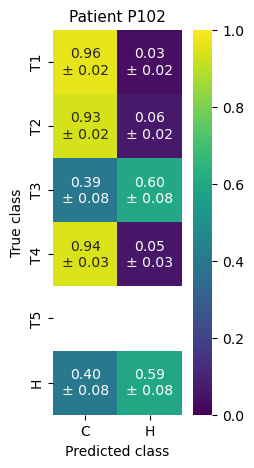

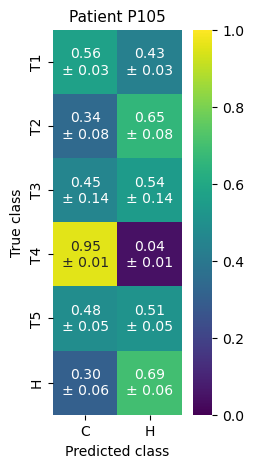

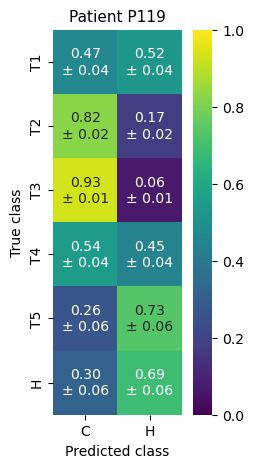

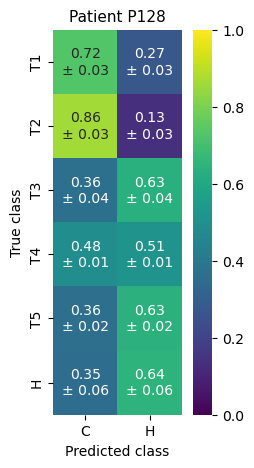

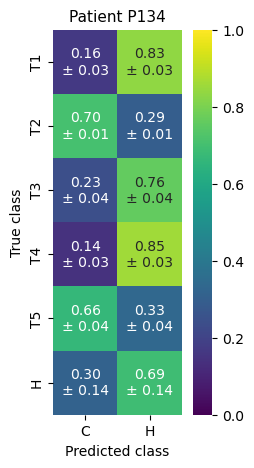

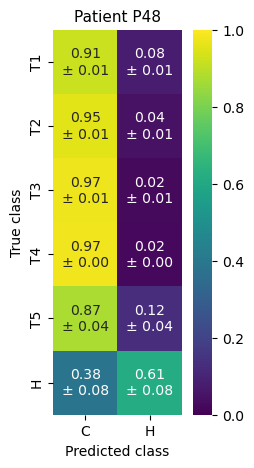

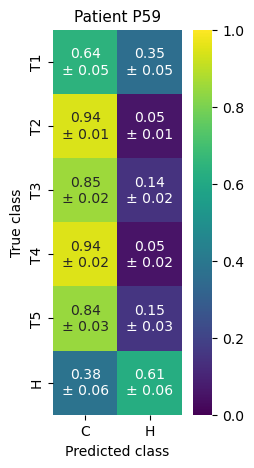

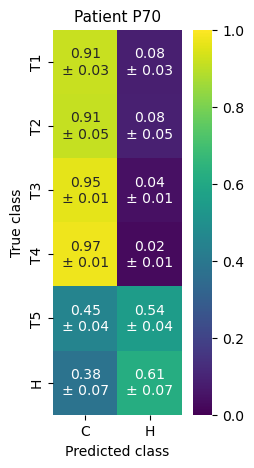

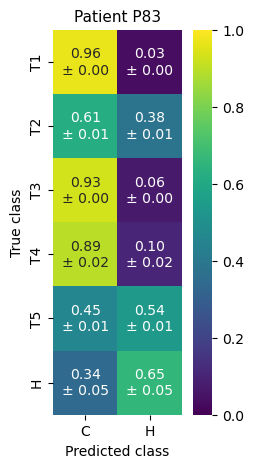

In [206]:
for p in patients:
  cms_mean = np.zeros((6, 2))
  cms_std = np.zeros((6, 2))

  for t in [1, 2, 3, 4, 5]:
    select = np.argwhere((np.array(ps) == p) & (np.array(ts) == t)).flatten()
    cms_t_mean = np.mean(np.array(cms)[select], axis=0)
    cms_t_std = np.std(np.array(cms)[select], axis=0)
    if t == 1:
      # for true label healthy
      cms_mean[-1] = cms_t_mean[1]
      cms_std[-1] = cms_t_std[1]
    # for true label disease at timepoint t
    cms_mean[t-1] = cms_t_mean[0]
    cms_std[t-1] = cms_t_std[0]

  cms_df = pd.DataFrame(cms_mean, index=['T1', 'T2', 'T3', 'T4', 'T5', 'H'], columns=['C', 'H'])
  fig, ax = plt.subplots(figsize=[3, 5])
  ax = sns.heatmap(
      cms_df,
      annot=pd.DataFrame(cms_mean.astype(str)).applymap(lambda x : x[:4]) + '\n± ' + pd.DataFrame(cms_std.astype(str)).applymap(lambda x : x[:4]),
      fmt='s',
      cmap='viridis',
      vmin=0,
      vmax=1,
      # cbar=False,
  )
  ax.set_xlabel('Predicted class')
  ax.set_ylabel('True class')
  ax.set_title(f'Patient {p}', size=11)
  ax.set_aspect(1)
  fig.show()

## Plate 6

In [207]:
plate_id = 6
m = 200
data = PlateDataset([plate_id], strict_discard=False)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.06it/s]


In [208]:
counts = data.info.groupby(['patient', 'time'])[['cell']].count().rename(columns={'cell':'count'})
few = counts[counts['count'] < m]
print(few)
enough = counts[counts['count'] >= m].index.copy()
enough = counts.loc[enough].reset_index()
print(enough.groupby('time').count())  # check that healty is smallest group
enough_samples = (enough['patient'] + '_' + enough['time'].apply(str)).str.split('_0', expand=True)[0].values
print(enough_samples)

Empty DataFrame
Columns: [count]
Index: []
      patient  count
time                
0           4      4
1          10     10
2           9      9
3          10     10
4           7      7
5           7      7
['H22' 'H31' 'H37' 'H39' 'P106_1' 'P106_3' 'P110_1' 'P110_2' 'P110_3'
 'P110_4' 'P110_5' 'P14_1' 'P14_2' 'P14_3' 'P14_4' 'P14_5' 'P147_1'
 'P147_2' 'P147_3' 'P154_1' 'P154_2' 'P154_3' 'P154_4' 'P154_5' 'P166_1'
 'P166_2' 'P166_3' 'P166_4' 'P166_5' 'P44_1' 'P44_2' 'P44_3' 'P55_1'
 'P55_2' 'P55_3' 'P55_4' 'P55_5' 'P94_1' 'P94_2' 'P94_3' 'P94_4' 'P94_5'
 'P98_1' 'P98_2' 'P98_3' 'P98_4' 'P98_5']


In [209]:
enough[enough['time'] == 1]

patient  time  count
4     P106     1   1887
6     P110     1   1703
11     P14     1   7336
16    P147     1   1962
19    P154     1   5040
24    P166     1   6089
29     P44     1   1786
32     P55     1   2863
37     P94     1   3124
42     P98     1    356

In [210]:
enough[enough['time'] == 0]

patient  time  count
0     H22     0   1652
1     H31     0   3179
2     H37     0   2363
3     H39     0   3168

In [211]:
healthy = enough[enough['time'] == 0]['patient'].unique()
patients = enough[enough['time'] == 1]['patient'].unique()
nc, nh = how_many_cells_per_condition_patient(patients, healthy, enough)
nc, nh

(356, 890)

In [212]:
labels = torch.from_numpy((data.info['group'] == 'healthy').values).float()
dataset = TensorDataset(T.CenterCrop(28)(data.imgs), labels)

np.random.seed(13423)
confusion = {}
cms = []
enough = enough.reset_index()
enough = enough.set_index(['patient', 'time'])
for h, p in tqdm(list(product(healthy, patients))):
  healthy_train = healthy[healthy != h]
  patients_train = patients[patients != p]
  train_idx = np.concatenate([np.random.choice(np.argwhere(
      ((data.info['time'].values == 1) & (data.info['patient'].values == x))).flatten(),
                                                size=nc, replace=False) for x in patients_train]
              + [np.random.choice(np.argwhere(
                                  (data.info['patient'].values == x)).flatten(),
                                                size=nh, replace=False) for x in healthy_train])
  train_dataset = Subset(dataset, train_idx.tolist())
  print(h, p, ': training dataset size: ', len(train_dataset))

  k = min(enough.loc[(p, 1), 'count'], enough.loc[(h, 0), 'count'])
  test_idx = np.concatenate([np.random.choice(np.argwhere(
      ((data.info['time'] == 1) & (data.info['patient'] == p)).values).flatten(), size=k, replace=False),
                              np.random.choice(np.argwhere(
                                  (data.info['patient'] == h).values).flatten(), size=k, replace=False)])
  test_dataset = Subset(dataset, test_idx)

  model = Classifier().to(device)
  _ = train_model_with_datasets(model, train_dataset, val_dataset=test_dataset, fname=f'patch_plate{plate_id}_t1_{p}_{h}_{patients_train[0]}_{patients_train[1]}_{patients_train[2]}',
                  plot=False, save_model=False, num_epochs=30, batch_size=64, lr=0.001, device=device)

  for t in [1, 2, 3, 4, 5]:
    if not (p, t) in set(enough.index.values):
      continue
    test_idx = np.concatenate([np.argwhere(((data.info['time'] == t) & (data.info['patient'] == p)).values).flatten(),
                               np.argwhere((data.info['patient'] == h).values).flatten()])

    test_dataset = Subset(dataset, test_idx)
    preds, labs = eval_model_on_dataset(model, test_dataset, device=device)
    cms.append((h, p, t, patients_train, confusion_matrix(labs, preds, normalize='true')))

  0%|                                                                                                                                                                                          | 0/40 [00:00<?, ?it/s]

H22 P106 : training dataset size:  5874


epoch: 29; train loss: 0.06399238; val loss: 1.34122056; train accuracy: 0.97923051; val accuracy: 0.77693705 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:06<00:00,  4.33it/s]
  2%|████▍                                                                                                                                                                             | 1/40 [00:07<04:36,  7.08s/it]

H22 P110 : training dataset size:  5874


epoch: 29; train loss: 0.06512531; val loss: 1.33761555; train accuracy: 0.98127341; val accuracy: 0.76755448 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:06<00:00,  4.44it/s]
  5%|████████▉                                                                                                                                                                         | 2/40 [00:14<04:28,  7.05s/it]

H22 P14 : training dataset size:  5874


epoch: 29; train loss: 0.03233786; val loss: 1.97466779; train accuracy: 0.99489275; val accuracy: 0.58989104 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:06<00:00,  4.72it/s]
  8%|█████████████▎                                                                                                                                                                    | 3/40 [00:21<04:20,  7.04s/it]

H22 P147 : training dataset size:  5874


epoch: 29; train loss: 0.05833609; val loss: 1.43100661; train accuracy: 0.98263534; val accuracy: 0.76785714 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:06<00:00,  4.73it/s]
 10%|█████████████████▊                                                                                                                                                                | 4/40 [00:27<04:06,  6.84s/it]

H22 P154 : training dataset size:  5874


epoch: 29; train loss: 0.12469526; val loss: 3.09633160; train accuracy: 0.95539666; val accuracy: 0.35956416 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:06<00:00,  4.69it/s]
 12%|██████████████████████▎                                                                                                                                                           | 5/40 [00:34<04:02,  6.94s/it]

H22 P166 : training dataset size:  5874


epoch: 29; train loss: 0.03335690; val loss: 2.57190239; train accuracy: 0.99302009; val accuracy: 0.50847458 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:06<00:00,  4.72it/s]
 15%|██████████████████████████▋                                                                                                                                                       | 6/40 [00:41<03:53,  6.86s/it]

H22 P44 : training dataset size:  5874


epoch: 29; train loss: 0.06953280; val loss: 1.32456648; train accuracy: 0.97854954; val accuracy: 0.71912833 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:06<00:00,  4.75it/s]
 18%|███████████████████████████████▏                                                                                                                                                  | 7/40 [00:48<03:46,  6.86s/it]

H22 P55 : training dataset size:  5874


epoch: 29; train loss: 0.04865682; val loss: 1.87582588; train accuracy: 0.98467824; val accuracy: 0.67615012 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:06<00:00,  4.95it/s]
 20%|███████████████████████████████████▌                                                                                                                                              | 8/40 [00:54<03:33,  6.68s/it]

H22 P94 : training dataset size:  5874


epoch: 29; train loss: 0.08357595; val loss: 1.59321690; train accuracy: 0.96952673; val accuracy: 0.72639225 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:06<00:00,  4.96it/s]
 22%|████████████████████████████████████████                                                                                                                                          | 9/40 [01:00<03:23,  6.56s/it]

H22 P98 : training dataset size:  5874


epoch: 29; train loss: 0.06319654; val loss: 0.96632713; train accuracy: 0.98144365; val accuracy: 0.79634831 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:05<00:00,  5.07it/s]
 25%|████████████████████████████████████████████▎                                                                                                                                    | 10/40 [01:07<03:13,  6.46s/it]

H31 P106 : training dataset size:  5874


epoch: 29; train loss: 0.05175110; val loss: 1.15278053; train accuracy: 0.98331631; val accuracy: 0.77795443 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:06<00:00,  4.85it/s]
 28%|████████████████████████████████████████████████▋                                                                                                                                | 11/40 [01:13<03:06,  6.43s/it]

H31 P110 : training dataset size:  5874


epoch: 29; train loss: 0.04356532; val loss: 0.91079602; train accuracy: 0.99046646; val accuracy: 0.80534351 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:06<00:00,  4.64it/s]
 30%|█████████████████████████████████████████████████████                                                                                                                            | 12/40 [01:20<03:03,  6.54s/it]

H31 P14 : training dataset size:  5874


epoch: 29; train loss: 0.06169459; val loss: 1.15630907; train accuracy: 0.97974123; val accuracy: 0.68905316 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:07<00:00,  4.23it/s]
 32%|█████████████████████████████████████████████████████████▌                                                                                                                       | 13/40 [01:27<03:04,  6.82s/it]

H31 P147 : training dataset size:  5874


epoch: 29; train loss: 0.05646572; val loss: 0.83468567; train accuracy: 0.98416752; val accuracy: 0.81523955 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:06<00:00,  4.58it/s]
 35%|█████████████████████████████████████████████████████████████▉                                                                                                                   | 14/40 [01:34<02:57,  6.81s/it]

H31 P154 : training dataset size:  5874


epoch: 29; train loss: 0.10717388; val loss: 1.54442745; train accuracy: 0.95914198; val accuracy: 0.56212645 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:07<00:00,  4.23it/s]
 38%|██████████████████████████████████████████████████████████████████▍                                                                                                              | 15/40 [01:42<02:55,  7.01s/it]

H31 P166 : training dataset size:  5874


epoch: 29; train loss: 0.06338236; val loss: 1.86294404; train accuracy: 0.97974123; val accuracy: 0.53287197 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:07<00:00,  4.23it/s]
 40%|██████████████████████████████████████████████████████████████████████▊                                                                                                          | 16/40 [01:49<02:51,  7.15s/it]

H31 P44 : training dataset size:  5874


epoch: 29; train loss: 0.05805307; val loss: 1.02402684; train accuracy: 0.98331631; val accuracy: 0.77771557 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:06<00:00,  4.63it/s]
 42%|███████████████████████████████████████████████████████████████████████████▏                                                                                                     | 17/40 [01:56<02:41,  7.02s/it]

H31 P55 : training dataset size:  5874


epoch: 29; train loss: 0.04515407; val loss: 1.32137330; train accuracy: 0.98876404; val accuracy: 0.68529514 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:06<00:00,  4.29it/s]
 45%|███████████████████████████████████████████████████████████████████████████████▋                                                                                                 | 18/40 [02:03<02:36,  7.11s/it]

H31 P94 : training dataset size:  5874


epoch: 29; train loss: 0.04521222; val loss: 1.15771033; train accuracy: 0.98808308; val accuracy: 0.75464149 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:07<00:00,  4.23it/s]
 48%|████████████████████████████████████████████████████████████████████████████████████                                                                                             | 19/40 [02:10<02:31,  7.19s/it]

H31 P98 : training dataset size:  5874


epoch: 29; train loss: 0.04047755; val loss: 0.84982234; train accuracy: 0.99148791; val accuracy: 0.81460674 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:05<00:00,  5.08it/s]
 50%|████████████████████████████████████████████████████████████████████████████████████████▌                                                                                        | 20/40 [02:17<02:18,  6.92s/it]

H37 P106 : training dataset size:  5874


epoch: 29; train loss: 0.04407396; val loss: 0.73102307; train accuracy: 0.98876404; val accuracy: 0.81664017 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:06<00:00,  4.86it/s]
 52%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                    | 21/40 [02:23<02:08,  6.74s/it]

H37 P110 : training dataset size:  5874


epoch: 29; train loss: 0.06736616; val loss: 0.68381995; train accuracy: 0.97854954; val accuracy: 0.83294187 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:06<00:00,  4.62it/s]
 55%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                               | 22/40 [02:30<02:01,  6.76s/it]

H37 P14 : training dataset size:  5874


epoch: 29; train loss: 0.06013587; val loss: 0.63934350; train accuracy: 0.98008172; val accuracy: 0.79009733 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:06<00:00,  4.44it/s]
 57%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                           | 23/40 [02:37<01:56,  6.86s/it]

H37 P147 : training dataset size:  5874


epoch: 29; train loss: 0.04526773; val loss: 0.72930819; train accuracy: 0.98995574; val accuracy: 0.82543323 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:06<00:00,  4.80it/s]
 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                      | 24/40 [02:44<01:49,  6.84s/it]

H37 P154 : training dataset size:  5874


epoch: 29; train loss: 0.05043322; val loss: 0.92629759; train accuracy: 0.98621042; val accuracy: 0.69889970 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:06<00:00,  4.68it/s]
 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                  | 25/40 [02:51<01:42,  6.81s/it]

H37 P166 : training dataset size:  5874


epoch: 29; train loss: 0.02035472; val loss: 2.64365305; train accuracy: 0.99761662; val accuracy: 0.53575963 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:06<00:00,  4.46it/s]
 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                              | 26/40 [02:58<01:36,  6.90s/it]

H37 P44 : training dataset size:  5874


epoch: 29; train loss: 0.05332420; val loss: 0.68032116; train accuracy: 0.98552945; val accuracy: 0.82166853 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:06<00:00,  4.63it/s]
 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 27/40 [03:04<01:28,  6.84s/it]

H37 P55 : training dataset size:  5874


epoch: 29; train loss: 0.06065541; val loss: 1.12386960; train accuracy: 0.98297583; val accuracy: 0.65509945 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:06<00:00,  4.42it/s]
 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 28/40 [03:11<01:22,  6.91s/it]

H37 P94 : training dataset size:  5874


epoch: 29; train loss: 0.08455154; val loss: 0.86915036; train accuracy: 0.96901600; val accuracy: 0.74185358 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:06<00:00,  4.43it/s]
 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 29/40 [03:18<01:16,  6.95s/it]

H37 P98 : training dataset size:  5874


epoch: 29; train loss: 0.05923448; val loss: 0.66151381; train accuracy: 0.98484848; val accuracy: 0.81601124 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:05<00:00,  5.41it/s]
 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 30/40 [03:24<01:06,  6.63s/it]

H39 P106 : training dataset size:  5874


epoch: 29; train loss: 0.06892288; val loss: 0.57921958; train accuracy: 0.97889002; val accuracy: 0.84446211 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:06<00:00,  4.84it/s]
 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 31/40 [03:31<00:59,  6.66s/it]

H39 P110 : training dataset size:  5874


epoch: 29; train loss: 0.03524840; val loss: 0.75425348; train accuracy: 0.99233912; val accuracy: 0.83235467 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:06<00:00,  4.93it/s]
 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 32/40 [03:37<00:52,  6.59s/it]

H39 P14 : training dataset size:  5874


epoch: 29; train loss: 0.04868214; val loss: 1.01691104; train accuracy: 0.98706163; val accuracy: 0.69476010 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:07<00:00,  4.23it/s]
 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 33/40 [03:45<00:47,  6.85s/it]

H39 P147 : training dataset size:  5874


epoch: 29; train loss: 0.05429429; val loss: 0.58855447; train accuracy: 0.98604018; val accuracy: 0.85244648 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:06<00:00,  4.56it/s]
 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 34/40 [03:52<00:41,  6.84s/it]

H39 P154 : training dataset size:  5874


epoch: 29; train loss: 0.06240112; val loss: 1.09370398; train accuracy: 0.98042220; val accuracy: 0.63478535 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:07<00:00,  4.21it/s]
 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 35/40 [03:59<00:35,  7.04s/it]

H39 P166 : training dataset size:  5874


epoch: 29; train loss: 0.04934150; val loss: 1.83979137; train accuracy: 0.98569969; val accuracy: 0.55287247 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:07<00:00,  4.23it/s]
 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 36/40 [04:07<00:29,  7.28s/it]

H39 P44 : training dataset size:  5874


epoch: 29; train loss: 0.06684347; val loss: 0.72342198; train accuracy: 0.97837930; val accuracy: 0.80347144 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:06<00:00,  4.88it/s]
 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 37/40 [04:13<00:21,  7.01s/it]

H39 P55 : training dataset size:  5874


epoch: 29; train loss: 0.05971430; val loss: 0.98395459; train accuracy: 0.97957099; val accuracy: 0.73943416 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:07<00:00,  4.28it/s]
 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 38/40 [04:21<00:14,  7.10s/it]

H39 P94 : training dataset size:  5874


epoch: 29; train loss: 0.07591554; val loss: 0.78745258; train accuracy: 0.97395301; val accuracy: 0.79273367 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:07<00:00,  4.04it/s]
 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 39/40 [04:29<00:07,  7.29s/it]

H39 P98 : training dataset size:  5874


epoch: 29; train loss: 0.06577086; val loss: 0.58735478; train accuracy: 0.98008172; val accuracy: 0.85393258 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:05<00:00,  5.40it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [04:34<00:00,  6.87s/it]


In [213]:
import pickle

confusion = cms
with open(f'/ewsc/hschluet/models/pbmc5/rerun/plate_{plate_id}_confusion_t1_new.pkl', 'wb') as handle:
    pickle.dump(confusion, handle, protocol=pickle.HIGHEST_PROTOCOL)

# with open('filename.pickle', 'rb') as handle:
#     b = pickle.load(handle)

In [214]:
hs, ps, ts, _, cms = zip(*confusion)
cms_dfs = []

pats = np.unique(ps)
for p in pats:
    cms_mean = np.zeros((6, 2))
    cms_std = np.zeros((6, 2))

    for t in [1, 2, 3, 4, 5]:
        select = np.argwhere((np.array(ps) == p) & (np.array(ts) == t)).flatten()
        cms_t_mean = np.mean(np.array(cms)[select], axis=0)
        cms_t_std = np.std(np.array(cms)[select], axis=0)
        if t == 1:
            # for true label healthy
            cms_mean[-1] = cms_t_mean[1]
            cms_std[-1] = cms_t_std[1]
        # for true label disease at timepoint t
        cms_mean[t-1] = cms_t_mean[0]
        cms_std[t-1] = cms_t_std[0]


    cms_df = pd.DataFrame(cms_mean, index=['T1', 'T2', 'T3', 'T4', 'T5', 'H'], columns=['C', 'H']).drop(columns=['C'])
    cms_df['std'] = cms_std[:, 0]
    cms_df['pred H %'] = cms_df['H']
    cms_df['score'] = cms_df['H'] / cms_df.loc['H', 'H']
    cms_df['patient'] = p
    cms_df['plate'] = plate_id
    cms_df.index.name = 'TP'
    cms_df = cms_df.reset_index()
    cms_df['time'] = cms_df['TP'].replace({'T1' : 1, 'T2' : 2, 'T3':3, 'T4':4, 'T5':5, 'H':0})
    cms_df.loc[cms_df['time'] == 0, 'patient'] = 'H???'
    cms_dfs.append(cms_df.drop(columns=['H', 'TP']))

cms_df = pd.concat(cms_dfs, ignore_index=True)
cms_df = cms_df.rename(columns={'H':'pred H %'}).sort_values(by=['patient', 'time']).reset_index(drop=True)
cms_df.to_csv(f'/ewsc/hschluet/models/pbmc5/rerun/within_plate_{plate_id}_from_scratch_results.csv')
cms_df

/local_home/hschluet/anaconda3/envs/img-39/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/local_home/hschluet/anaconda3/envs/img-39/lib/python3.9/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/local_home/hschluet/anaconda3/envs/img-39/lib/python3.9/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/local_home/hschluet/anaconda3/envs/img-39/lib/python3.9/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/local_home/hschluet/anaconda3/envs/img-39/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/tmp/ipykernel_2628142/1678

std  pred H %     score patient  plate  time
0   0.065785  0.683436  1.000000    H???      6     0
1   0.077382  0.710313  1.000000    H???      6     0
2   0.074560  0.720530  1.000000    H???      6     0
3   0.084884  0.706390  1.000000    H???      6     0
4   0.175904  0.658744  1.000000    H???      6     0
5   0.046040  0.796618  1.000000    H???      6     0
6   0.073694  0.790984  1.000000    H???      6     0
7   0.068993  0.713016  1.000000    H???      6     0
8   0.063029  0.690486  1.000000    H???      6     0
9   0.075420  0.723410  1.000000    H???      6     0
10  0.006473  0.073529  0.107588    P106      6     1
11       NaN       NaN       NaN    P106      6     2
12  0.048166  0.226573  0.331521    P106      6     3
13       NaN       NaN       NaN    P106      6     4
14       NaN       NaN       NaN    P106      6     5
15  0.027070  0.089988  0.126688    P110      6     1
16  0.006972  0.575974  0.810874    P110      6     2
17  0.045742  0.388983  0.547622    P110      6     3
18  0.036593  0.181768  0.255898    P110      6     4
19  0.057097  0.366316  0.515711    P110      6     5
20  0.065514  0.342080  0.474762     P14      6     1
21  0.010704  0.024524  0.034036     P14      6     2
22  0.022178  0.048843  0.067787     P14      6     3
23  0.076546  0.496106  0.688530     P14      6     4
24  0.086134  0.393858  0.546623     P14      6     5
25  0.023918  0.076070  0.107689    P147      6     1
26  0.040180  0.215327  0.304827    P147      6     2
27  0.063666  0.501759  0.710314    P147      6     3
28       NaN       NaN       NaN    P147      6     4
29       NaN       NaN       NaN    P147      6     5
30  0.105585  0.528819  0.802769    P154      6     1
31  0.086429  0.263644  0.400222    P154      6     2
32  0.070230  0.653375  0.991849    P154      6     3
33  0.068018  0.516856  0.784607    P154      6     4
34  0.120763  0.572236  0.868677    P154      6     5
35  0.041674  0.730457  0.916947    P166      6     1
36  0.047800  0.471121  0.591401    P166      6     2
37  0.060401  0.573853  0.720361    P166      6     3
38  0.042560  0.282657  0.354821    P166      6     4
39  0.042123  0.549407  0.689674    P166      6     5
40  0.030002  0.227184  0.287216     P44      6     1
41  0.061505  0.389728  0.492713     P44      6     2
42  0.034001  0.445538  0.563270     P44      6     3
43       NaN       NaN       NaN     P44      6     4
44       NaN       NaN       NaN     P44      6     5
45  0.061968  0.331994  0.465620     P55      6     1
46  0.070855  0.338471  0.474704     P55      6     2
47  0.056763  0.547805  0.768293     P55      6     3
48  0.037258  0.146280  0.205156     P55      6     4
49  0.052864  0.274326  0.384740     P55      6     5
50  0.065826  0.182298  0.264015     P94      6     1
51  0.019333  0.025000  0.036206     P94      6     2
52  0.041368  0.067536  0.097809     P94      6     3
53  0.027100  0.370620  0.536752     P94      6     4
54  0.050774  0.664849  0.962871     P94      6     5
55  0.027843  0.099719  0.137846     P98      6     1
56  0.041322  0.140648  0.194424     P98      6     2
57  0.047793  0.529702  0.732229     P98      6     3
58  0.087240  0.524867  0.725545     P98      6     4
59  0.042032  0.653279  0.903056     P98      6     5

/local_home/hschluet/anaconda3/envs/img-39/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/local_home/hschluet/anaconda3/envs/img-39/lib/python3.9/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/local_home/hschluet/anaconda3/envs/img-39/lib/python3.9/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/local_home/hschluet/anaconda3/envs/img-39/lib/python3.9/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/local_home/hschluet/anaconda3/envs/img-39/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/tmp/ipykernel_2628142/1479

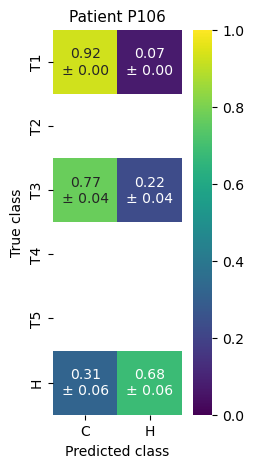

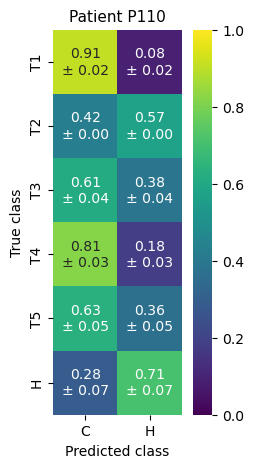

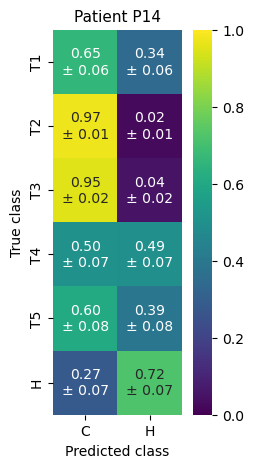

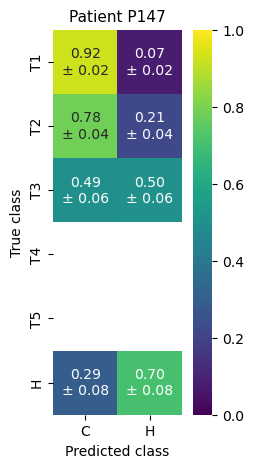

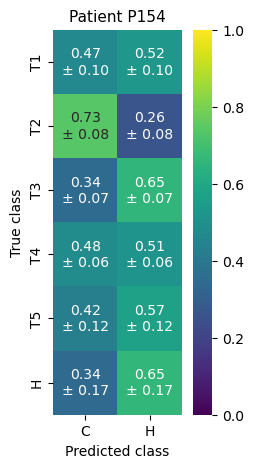

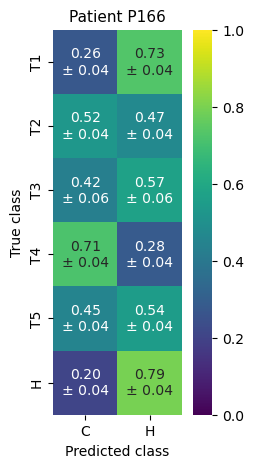

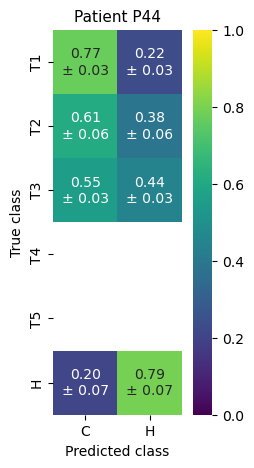

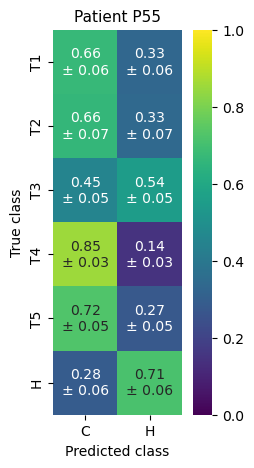

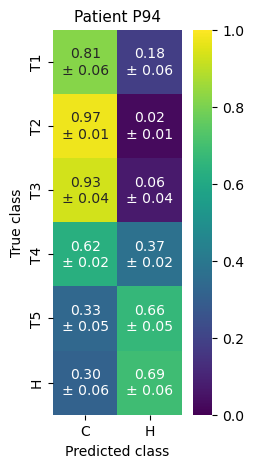

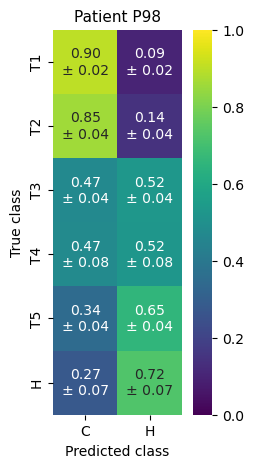

In [215]:
for p in patients:
  cms_mean = np.zeros((6, 2))
  cms_std = np.zeros((6, 2))

  for t in [1, 2, 3, 4, 5]:
    select = np.argwhere((np.array(ps) == p) & (np.array(ts) == t)).flatten()
    cms_t_mean = np.mean(np.array(cms)[select], axis=0)
    cms_t_std = np.std(np.array(cms)[select], axis=0)
    if t == 1:
      # for true label healthy
      cms_mean[-1] = cms_t_mean[1]
      cms_std[-1] = cms_t_std[1]
    # for true label disease at timepoint t
    cms_mean[t-1] = cms_t_mean[0]
    cms_std[t-1] = cms_t_std[0]

  cms_df = pd.DataFrame(cms_mean, index=['T1', 'T2', 'T3', 'T4', 'T5', 'H'], columns=['C', 'H'])
  fig, ax = plt.subplots(figsize=[3, 5])
  ax = sns.heatmap(
      cms_df,
      annot=pd.DataFrame(cms_mean.astype(str)).applymap(lambda x : x[:4]) + '\n± ' + pd.DataFrame(cms_std.astype(str)).applymap(lambda x : x[:4]),
      fmt='s',
      cmap='viridis',
      vmin=0,
      vmax=1,
      # cbar=False,
  )
  ax.set_xlabel('Predicted class')
  ax.set_ylabel('True class')
  ax.set_title(f'Patient {p}', size=11)
  ax.set_aspect(1)
  fig.show()

## Plate 5

In [216]:
plate_id = 5
m = 100
data = PlateDataset([plate_id], strict_discard=False)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.36it/s]


In [217]:
counts = data.info.groupby(['patient', 'time'])[['cell']].count().rename(columns={'cell':'count'})
few = counts[counts['count'] < m]
print(few)
enough = counts[counts['count'] >= m].index.copy()
enough = counts.loc[enough].reset_index()
print(enough.groupby('time').count())  # check that healty is smallest group
enough_samples = (enough['patient'] + '_' + enough['time'].apply(str)).str.split('_0', expand=True)[0].values
print(enough_samples)

              count
patient time       
P12     5        36
      patient  count
time                
0           4      4
1           9      9
2           9      9
3           9      9
4           7      7
5           6      6
['H10' 'H31' 'H39' 'H40' 'P12_1' 'P12_2' 'P12_3' 'P12_4' 'P135_1' 'P135_2'
 'P135_3' 'P135_4' 'P135_5' 'P142_1' 'P142_2' 'P142_3' 'P142_4' 'P142_5'
 'P148_1' 'P148_2' 'P148_3' 'P148_4' 'P148_5' 'P161_1' 'P161_2' 'P161_3'
 'P161_4' 'P18_1' 'P18_2' 'P18_3' 'P18_5' 'P24_1' 'P24_2' 'P24_3' 'P63_1'
 'P63_2' 'P63_3' 'P63_4' 'P63_5' 'P78_1' 'P78_2' 'P78_3' 'P78_4' 'P78_5']


In [218]:
enough[enough['time'] == 1]

patient  time  count
4      P12     1    278
8     P135     1   2811
13    P142     1   4008
18    P148     1   2429
23    P161     1   2274
27     P18     1   6364
31     P24     1   9257
34     P63     1   1266
39     P78     1   1925

In [219]:
enough[enough['time'] == 0]

patient  time  count
0     H10     0   2427
1     H31     0   4432
2     H39     0   2946
3     H40     0   3001

In [220]:
healthy = enough[enough['time'] == 0]['patient'].unique()
patients = enough[enough['time'] == 1]['patient'].unique()
nc, nh = how_many_cells_per_condition_patient(patients, healthy, enough)
nc, nh

(276, 621)

In [221]:
labels = torch.from_numpy((data.info['group'] == 'healthy').values).float()
dataset = TensorDataset(T.CenterCrop(28)(data.imgs), labels)

np.random.seed(13423)
confusion = {}
cms = []
enough = enough.reset_index()
enough = enough.set_index(['patient', 'time'])
for h, p in tqdm(list(product(healthy, patients))):
  healthy_train = healthy[healthy != h]
  patients_train = patients[patients != p]
  train_idx = np.concatenate([np.random.choice(np.argwhere(
      ((data.info['time'].values == 1) & (data.info['patient'].values == x))).flatten(),
                                                size=nc, replace=False) for x in patients_train]
              + [np.random.choice(np.argwhere(
                                  (data.info['patient'].values == x)).flatten(),
                                                size=nh, replace=False) for x in healthy_train])
  train_dataset = Subset(dataset, train_idx.tolist())
  print(h, p, ': training dataset size: ', len(train_dataset))

  k = min(enough.loc[(p, 1), 'count'], enough.loc[(h, 0), 'count'])
  test_idx = np.concatenate([np.random.choice(np.argwhere(
      ((data.info['time'] == 1) & (data.info['patient'] == p)).values).flatten(), size=k, replace=False),
                              np.random.choice(np.argwhere(
                                  (data.info['patient'] == h).values).flatten(), size=k, replace=False)])
  test_dataset = Subset(dataset, test_idx)

  model = Classifier().to(device)
  _ = train_model_with_datasets(model, train_dataset, val_dataset=test_dataset, fname=f'patch_plate{plate_id}_t1_{p}_{h}_{patients_train[0]}_{patients_train[1]}_{patients_train[2]}',
                  plot=False, save_model=False, num_epochs=30, batch_size=64, lr=0.001, device=device)

  for t in [1, 2, 3, 4, 5]:
    if not (p, t) in set(enough.index.values):
      continue
    test_idx = np.concatenate([np.argwhere(((data.info['time'] == t) & (data.info['patient'] == p)).values).flatten(),
                               np.argwhere((data.info['patient'] == h).values).flatten()])

    test_dataset = Subset(dataset, test_idx)
    preds, labs = eval_model_on_dataset(model, test_dataset, device=device)
    cms.append((h, p, t, patients_train, confusion_matrix(labs, preds, normalize='true')))

  0%|                                                                                                                                                                                          | 0/36 [00:00<?, ?it/s]

H10 P12 : training dataset size:  4071


epoch: 29; train loss: 0.05995569; val loss: 1.65563560; train accuracy: 0.98501597; val accuracy: 0.72482014 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:03<00:00,  7.51it/s]
  3%|████▉                                                                                                                                                                             | 1/36 [00:04<02:26,  4.19s/it]

H10 P135 : training dataset size:  4071


epoch: 29; train loss: 0.13470805; val loss: 1.88280145; train accuracy: 0.95308278; val accuracy: 0.69283066 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:05<00:00,  5.55it/s]
  6%|█████████▉                                                                                                                                                                        | 2/36 [00:09<02:53,  5.10s/it]

H10 P142 : training dataset size:  4071


epoch: 29; train loss: 0.06854941; val loss: 2.38806951; train accuracy: 0.98329649; val accuracy: 0.62608158 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:05<00:00,  5.54it/s]
  8%|██████████████▊                                                                                                                                                                   | 3/36 [00:15<02:58,  5.40s/it]

H10 P148 : training dataset size:  4071


epoch: 29; train loss: 0.10610949; val loss: 1.39364501; train accuracy: 0.96585606; val accuracy: 0.61042439 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:05<00:00,  5.55it/s]
 11%|███████████████████▊                                                                                                                                                              | 4/36 [00:21<02:56,  5.51s/it]

H10 P161 : training dataset size:  4071


epoch: 29; train loss: 0.10626820; val loss: 1.64190829; train accuracy: 0.96339966; val accuracy: 0.58992964 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:05<00:00,  5.70it/s]
 14%|████████████████████████▋                                                                                                                                                         | 5/36 [00:26<02:50,  5.50s/it]

H10 P18 : training dataset size:  4071


epoch: 29; train loss: 0.08983785; val loss: 1.43577640; train accuracy: 0.97199705; val accuracy: 0.70457355 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:05<00:00,  5.57it/s]
 17%|█████████████████████████████▋                                                                                                                                                    | 6/36 [00:32<02:47,  5.59s/it]

H10 P24 : training dataset size:  4071


epoch: 29; train loss: 0.12001321; val loss: 1.36101059; train accuracy: 0.95725866; val accuracy: 0.68994644 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:05<00:00,  5.53it/s]
 19%|██████████████████████████████████▌                                                                                                                                               | 7/36 [00:38<02:42,  5.61s/it]

H10 P63 : training dataset size:  4071


epoch: 29; train loss: 0.10007969; val loss: 1.41804552; train accuracy: 0.96806681; val accuracy: 0.70537125 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:04<00:00,  6.64it/s]
 22%|███████████████████████████████████████▌                                                                                                                                          | 8/36 [00:43<02:29,  5.34s/it]

H10 P78 : training dataset size:  4071


epoch: 29; train loss: 0.13105017; val loss: 1.09243149; train accuracy: 0.95504790; val accuracy: 0.74571429 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:05<00:00,  5.95it/s]
 25%|████████████████████████████████████████████▌                                                                                                                                     | 9/36 [00:48<02:23,  5.32s/it]

H31 P12 : training dataset size:  4071


epoch: 29; train loss: 0.07799459; val loss: 0.88261485; train accuracy: 0.97592729; val accuracy: 0.73741007 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:03<00:00,  7.60it/s]
 28%|█████████████████████████████████████████████████▏                                                                                                                               | 10/36 [00:52<02:09,  4.98s/it]

H31 P135 : training dataset size:  4071


epoch: 29; train loss: 0.06459475; val loss: 0.81084444; train accuracy: 0.98550725; val accuracy: 0.75115617 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:05<00:00,  5.60it/s]
 31%|██████████████████████████████████████████████████████                                                                                                                           | 11/36 [00:58<02:10,  5.21s/it]

H31 P142 : training dataset size:  4071


epoch: 29; train loss: 0.03930065; val loss: 0.85282856; train accuracy: 0.99361336; val accuracy: 0.72966567 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:06<00:00,  4.83it/s]
 33%|███████████████████████████████████████████████████████████                                                                                                                      | 12/36 [01:04<02:15,  5.63s/it]

H31 P148 : training dataset size:  4071


epoch: 29; train loss: 0.07508994; val loss: 0.83746509; train accuracy: 0.97690985; val accuracy: 0.70172911 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:05<00:00,  5.76it/s]
 36%|███████████████████████████████████████████████████████████████▉                                                                                                                 | 13/36 [01:10<02:08,  5.61s/it]

H31 P161 : training dataset size:  4071


epoch: 29; train loss: 0.07768740; val loss: 0.93022734; train accuracy: 0.97568165; val accuracy: 0.64401935 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:05<00:00,  5.81it/s]
 39%|████████████████████████████████████████████████████████████████████▊                                                                                                            | 14/36 [01:15<02:02,  5.55s/it]

H31 P18 : training dataset size:  4071


epoch: 29; train loss: 0.08341108; val loss: 0.60193968; train accuracy: 0.97641857; val accuracy: 0.78418321 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:06<00:00,  4.73it/s]
 42%|█████████████████████████████████████████████████████████████████████████▊                                                                                                       | 15/36 [01:22<02:04,  5.91s/it]

H31 P24 : training dataset size:  4071


epoch: 29; train loss: 0.07737397; val loss: 0.58624765; train accuracy: 0.97813805; val accuracy: 0.77696300 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:06<00:00,  4.72it/s]
 44%|██████████████████████████████████████████████████████████████████████████████▋                                                                                                  | 16/36 [01:29<02:02,  6.12s/it]

H31 P63 : training dataset size:  4071


epoch: 29; train loss: 0.14747272; val loss: 0.97722301; train accuracy: 0.94497666; val accuracy: 0.64849921 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:04<00:00,  6.90it/s]
 47%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                             | 17/36 [01:33<01:48,  5.68s/it]

H31 P78 : training dataset size:  4071


epoch: 29; train loss: 0.11955961; val loss: 0.71475971; train accuracy: 0.96168018; val accuracy: 0.74493506 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:04<00:00,  6.09it/s]
 50%|████████████████████████████████████████████████████████████████████████████████████████▌                                                                                        | 18/36 [01:39<01:39,  5.54s/it]

H39 P12 : training dataset size:  4071


epoch: 29; train loss: 0.06614344; val loss: 0.34208325; train accuracy: 0.98673545; val accuracy: 0.89028777 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:03<00:00,  7.66it/s]
 53%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                   | 19/36 [01:43<01:27,  5.12s/it]

H39 P135 : training dataset size:  4071


epoch: 29; train loss: 0.09892658; val loss: 0.71735342; train accuracy: 0.96364530; val accuracy: 0.77339025 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:05<00:00,  5.63it/s]
 56%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                              | 20/36 [01:48<01:24,  5.28s/it]

H39 P142 : training dataset size:  4071


epoch: 29; train loss: 0.06836017; val loss: 0.53063055; train accuracy: 0.98059445; val accuracy: 0.81160896 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:05<00:00,  5.56it/s]
 58%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                         | 21/36 [01:54<01:22,  5.53s/it]

H39 P148 : training dataset size:  4071


epoch: 29; train loss: 0.10076225; val loss: 0.45322951; train accuracy: 0.96487350; val accuracy: 0.80526966 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:04<00:00,  6.20it/s]
 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                    | 22/36 [02:00<01:15,  5.40s/it]

H39 P161 : training dataset size:  4071


epoch: 29; train loss: 0.10677929; val loss: 0.50563328; train accuracy: 0.96118890; val accuracy: 0.76759015 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:05<00:00,  5.81it/s]
 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                | 23/36 [02:05<01:10,  5.40s/it]

H39 P18 : training dataset size:  4071


epoch: 29; train loss: 0.09166036; val loss: 0.47635870; train accuracy: 0.97494473; val accuracy: 0.81670061 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:05<00:00,  5.54it/s]
 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                           | 24/36 [02:11<01:06,  5.51s/it]

H39 P24 : training dataset size:  4071


epoch: 29; train loss: 0.10762734; val loss: 0.49001267; train accuracy: 0.96561042; val accuracy: 0.79073320 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:05<00:00,  5.56it/s]
 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                      | 25/36 [02:16<01:00,  5.55s/it]

H39 P63 : training dataset size:  4071


epoch: 29; train loss: 0.11365579; val loss: 0.77526692; train accuracy: 0.95996070; val accuracy: 0.72788310 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:04<00:00,  6.38it/s]
 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 26/36 [02:21<00:53,  5.37s/it]

H39 P78 : training dataset size:  4071


epoch: 29; train loss: 0.14363792; val loss: 0.35909404; train accuracy: 0.94988946; val accuracy: 0.86363636 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:04<00:00,  6.56it/s]
 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 27/36 [02:26<00:46,  5.20s/it]

H40 P12 : training dataset size:  4071


epoch: 29; train loss: 0.06815370; val loss: 0.34349772; train accuracy: 0.98427905; val accuracy: 0.89028777 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:03<00:00,  7.63it/s]
 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 28/36 [02:31<00:39,  4.99s/it]

H40 P135 : training dataset size:  4071


epoch: 29; train loss: 0.11044015; val loss: 0.72485128; train accuracy: 0.96462786; val accuracy: 0.75062255 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:05<00:00,  5.62it/s]
 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 29/36 [02:36<00:36,  5.19s/it]

H40 P142 : training dataset size:  4071


epoch: 29; train loss: 0.12904563; val loss: 0.47949347; train accuracy: 0.95185458; val accuracy: 0.81539487 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:05<00:00,  5.52it/s]
 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 30/36 [02:42<00:32,  5.36s/it]

H40 P148 : training dataset size:  4071


epoch: 29; train loss: 0.09580158; val loss: 0.54698676; train accuracy: 0.96929501; val accuracy: 0.79415397 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:05<00:00,  5.73it/s]
 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 31/36 [02:48<00:27,  5.41s/it]

H40 P161 : training dataset size:  4071


epoch: 29; train loss: 0.09304389; val loss: 0.73640545; train accuracy: 0.97126013; val accuracy: 0.70844327 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:05<00:00,  5.77it/s]
 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 32/36 [02:53<00:21,  5.42s/it]

H40 P18 : training dataset size:  4071


epoch: 29; train loss: 0.10666524; val loss: 0.52514585; train accuracy: 0.96339966; val accuracy: 0.81156281 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:05<00:00,  5.44it/s]
 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 33/36 [02:59<00:16,  5.56s/it]

H40 P24 : training dataset size:  4071


epoch: 29; train loss: 0.12878214; val loss: 0.50788299; train accuracy: 0.95971506; val accuracy: 0.79456848 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:05<00:00,  5.44it/s]
 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 34/36 [03:05<00:11,  5.61s/it]

H40 P63 : training dataset size:  4071


epoch: 29; train loss: 0.12810118; val loss: 0.90772818; train accuracy: 0.95087202; val accuracy: 0.63665087 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:04<00:00,  6.83it/s]
 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 35/36 [03:10<00:05,  5.43s/it]

H40 P78 : training dataset size:  4071


epoch: 29; train loss: 0.10675113; val loss: 1.04139341; train accuracy: 0.96438222; val accuracy: 0.71688312 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:04<00:00,  6.44it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 36/36 [03:15<00:00,  5.42s/it]


In [222]:
import pickle

confusion = cms
with open(f'/ewsc/hschluet/models/pbmc5/rerun/plate_{plate_id}_confusion_t1_new.pkl', 'wb') as handle:
    pickle.dump(confusion, handle, protocol=pickle.HIGHEST_PROTOCOL)

# with open('filename.pickle', 'rb') as handle:
#     b = pickle.load(handle)

In [223]:
hs, ps, ts, _, cms = zip(*confusion)
cms_dfs = []

pats = np.unique(ps)
for p in pats:
    cms_mean = np.zeros((6, 2))
    cms_std = np.zeros((6, 2))

    for t in [1, 2, 3, 4, 5]:
        select = np.argwhere((np.array(ps) == p) & (np.array(ts) == t)).flatten()
        cms_t_mean = np.mean(np.array(cms)[select], axis=0)
        cms_t_std = np.std(np.array(cms)[select], axis=0)
        if t == 1:
            # for true label healthy
            cms_mean[-1] = cms_t_mean[1]
            cms_std[-1] = cms_t_std[1]
        # for true label disease at timepoint t
        cms_mean[t-1] = cms_t_mean[0]
        cms_std[t-1] = cms_t_std[0]


    cms_df = pd.DataFrame(cms_mean, index=['T1', 'T2', 'T3', 'T4', 'T5', 'H'], columns=['C', 'H']).drop(columns=['C'])
    cms_df['std'] = cms_std[:, 0]
    cms_df['pred H %'] = cms_df['H']
    cms_df['score'] = cms_df['H'] / cms_df.loc['H', 'H']
    cms_df['patient'] = p
    cms_df['plate'] = plate_id
    cms_df.index.name = 'TP'
    cms_df = cms_df.reset_index()
    cms_df['time'] = cms_df['TP'].replace({'T1' : 1, 'T2' : 2, 'T3':3, 'T4':4, 'T5':5, 'H':0})
    cms_df.loc[cms_df['time'] == 0, 'patient'] = 'H???'
    cms_dfs.append(cms_df.drop(columns=['H', 'TP']))

cms_df = pd.concat(cms_dfs, ignore_index=True)
cms_df = cms_df.rename(columns={'H':'pred H %'}).sort_values(by=['patient', 'time']).reset_index(drop=True)
cms_df.to_csv(f'/ewsc/hschluet/models/pbmc5/rerun/within_plate_{plate_id}_from_scratch_results.csv')
cms_df

/local_home/hschluet/anaconda3/envs/img-39/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/local_home/hschluet/anaconda3/envs/img-39/lib/python3.9/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/local_home/hschluet/anaconda3/envs/img-39/lib/python3.9/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/local_home/hschluet/anaconda3/envs/img-39/lib/python3.9/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/local_home/hschluet/anaconda3/envs/img-39/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/tmp/ipykernel_2628142/1678

std  pred H %     score patient  plate  time
0   0.174757  0.710317  1.000000    H???      5     0
1   0.152511  0.716927  1.000000    H???      5     0
2   0.157660  0.775805  1.000000    H???      5     0
3   0.118592  0.723926  1.000000    H???      5     0
4   0.168279  0.761370  1.000000    H???      5     0
5   0.112044  0.737486  1.000000    H???      5     0
6   0.080658  0.728967  1.000000    H???      5     0
7   0.091717  0.755950  1.000000    H???      5     0
8   0.135267  0.603764  1.000000    H???      5     0
9   0.034922  0.091727  0.129135     P12      5     1
10  0.143105  0.351103  0.494291     P12      5     2
11  0.047267  0.082174  0.115686     P12      5     3
12  0.157189  0.395418  0.556679     P12      5     4
13       NaN       NaN       NaN     P12      5     5
14  0.099231  0.232302  0.324024    P135      5     1
15  0.130525  0.427757  0.596653    P135      5     2
16  0.079248  0.727414  1.014628    P135      5     3
17  0.035316  0.208719  0.291129    P135      5     4
18  0.111156  0.641001  0.894095    P135      5     5
19  0.052007  0.284119  0.366225    P142      5     1
20  0.041274  0.433264  0.558471    P142      5     2
21  0.009328  0.011899  0.015337    P142      5     3
22  0.044454  0.136898  0.176459    P142      5     4
23  0.122551  0.563890  0.726845    P142      5     5
24  0.048174  0.271099  0.374485    P148      5     1
25  0.000000  0.000000  0.000000    P148      5     2
26  0.021059  0.084073  0.116135    P148      5     3
27  0.054905  0.571196  0.789026    P148      5     4
28  0.014967  0.074866  0.103417    P148      5     5
29  0.081373  0.406223  0.533542    P161      5     1
30  0.096821  0.306306  0.402310    P161      5     2
31  0.084249  0.762989  1.002126    P161      5     3
32  0.035987  0.060413  0.079347    P161      5     4
33       NaN       NaN       NaN    P161      5     5
34  0.028169  0.180036  0.244121     P18      5     1
35  0.034277  0.386272  0.523769     P18      5     2
36  0.062412  0.415430  0.563305     P18      5     3
37       NaN       NaN       NaN     P18      5     4
38  0.046824  0.290084  0.393341     P18      5     5
39  0.015097  0.197823  0.271375     P24      5     1
40  0.086361  0.420785  0.577235     P24      5     2
41  0.091326  0.451454  0.619306     P24      5     3
42       NaN       NaN       NaN     P24      5     4
43       NaN       NaN       NaN     P24      5     5
44  0.130746  0.402251  0.532113     P63      5     1
45  0.136235  0.520638  0.688720     P63      5     2
46  0.066017  0.143224  0.189462     P63      5     3
47  0.129710  0.393489  0.520522     P63      5     4
48  0.002114  0.001868  0.002471     P63      5     5
49  0.036623  0.068182  0.112928     P78      5     1
50  0.088445  0.304144  0.503747     P78      5     2
51  0.099999  0.463681  0.767984     P78      5     3
52  0.084647  0.308750  0.511375     P78      5     4
53  0.093650  0.462723  0.766397     P78      5     5

/local_home/hschluet/anaconda3/envs/img-39/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/local_home/hschluet/anaconda3/envs/img-39/lib/python3.9/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/local_home/hschluet/anaconda3/envs/img-39/lib/python3.9/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/local_home/hschluet/anaconda3/envs/img-39/lib/python3.9/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/local_home/hschluet/anaconda3/envs/img-39/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/tmp/ipykernel_2628142/1479

/tmp/ipykernel_2628142/1479086869.py:21: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  annot=pd.DataFrame(cms_mean.astype(str)).applymap(lambda x : x[:4]) + '\n± ' + pd.DataFrame(cms_std.astype(str)).applymap(lambda x : x[:4]),
/local_home/hschluet/anaconda3/envs/img-39/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/local_home/hschluet/anaconda3/envs/img-39/lib/python3.9/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/local_home/hschluet/anaconda3/envs/img-39/lib/python3.9/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/local_home/hschluet/anaconda3/envs/img-39/lib/python3.9/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmea

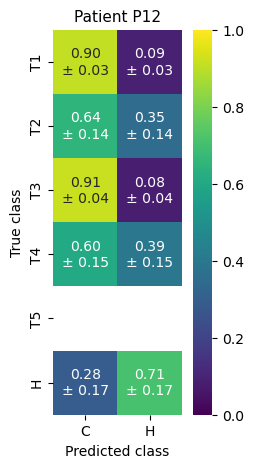

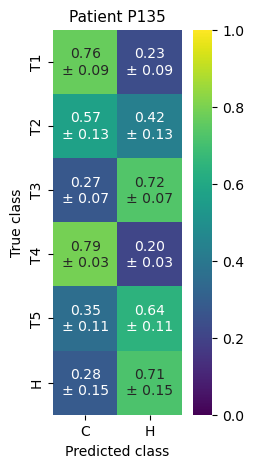

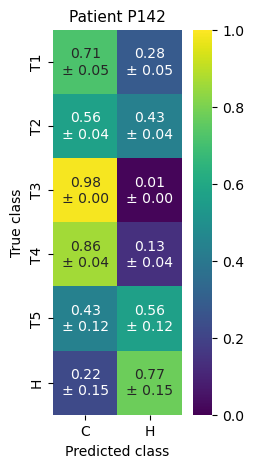

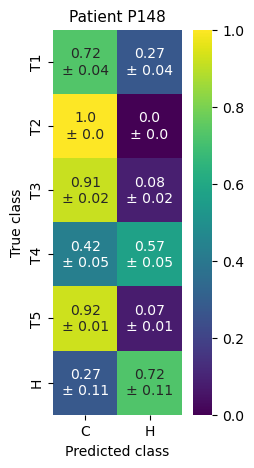

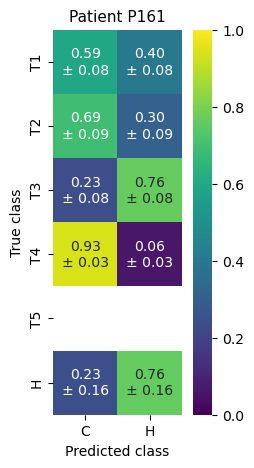

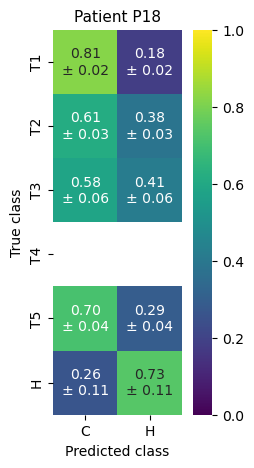

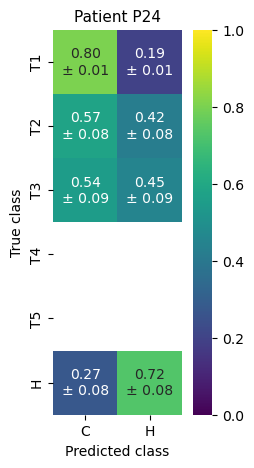

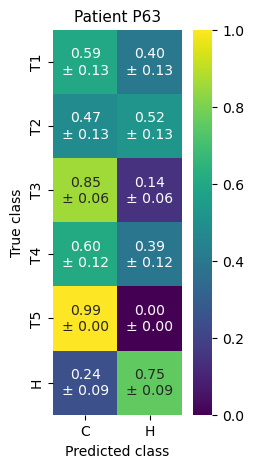

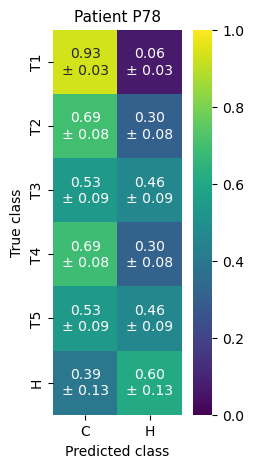

In [224]:
for p in patients:
  cms_mean = np.zeros((6, 2))
  cms_std = np.zeros((6, 2))

  for t in [1, 2, 3, 4, 5]:
    select = np.argwhere((np.array(ps) == p) & (np.array(ts) == t)).flatten()
    cms_t_mean = np.mean(np.array(cms)[select], axis=0)
    cms_t_std = np.std(np.array(cms)[select], axis=0)
    if t == 1:
      # for true label healthy
      cms_mean[-1] = cms_t_mean[1]
      cms_std[-1] = cms_t_std[1]
    # for true label disease at timepoint t
    cms_mean[t-1] = cms_t_mean[0]
    cms_std[t-1] = cms_t_std[0]

  cms_df = pd.DataFrame(cms_mean, index=['T1', 'T2', 'T3', 'T4', 'T5', 'H'], columns=['C', 'H'])
  fig, ax = plt.subplots(figsize=[3, 5])
  ax = sns.heatmap(
      cms_df,
      annot=pd.DataFrame(cms_mean.astype(str)).applymap(lambda x : x[:4]) + '\n± ' + pd.DataFrame(cms_std.astype(str)).applymap(lambda x : x[:4]),
      fmt='s',
      cmap='viridis',
      vmin=0,
      vmax=1,
      # cbar=False,
  )
  ax.set_xlabel('Predicted class')
  ax.set_ylabel('True class')
  ax.set_title(f'Patient {p}', size=11)
  ax.set_aspect(1)
  fig.show()

## Plate 4

In [225]:
plate_id = 4
m = 100
data = PlateDataset([plate_id], strict_discard=False)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.79it/s]


In [226]:
counts = data.info.groupby(['patient', 'time'])[['cell']].count().rename(columns={'cell':'count'})
few = counts[counts['count'] < m]
print(few)
enough = counts[counts['count'] >= m].index.copy()
enough = counts.loc[enough].reset_index()
print(enough.groupby('time').count())  # check that healty is smallest group
enough_samples = (enough['patient'] + '_' + enough['time'].apply(str)).str.split('_0', expand=True)[0].values
print(enough_samples)

Empty DataFrame
Columns: [count]
Index: []
      patient  count
time                
0           4      4
1           9      9
2           8      8
3           9      9
4           9      9
5           8      8
['H10' 'H23' 'H30' 'H40' 'P107_1' 'P107_2' 'P107_3' 'P107_4' 'P107_5'
 'P114_1' 'P114_2' 'P114_3' 'P114_4' 'P114_5' 'P120_1' 'P120_2' 'P120_3'
 'P120_4' 'P120_5' 'P129_1' 'P129_2' 'P129_3' 'P129_4' 'P129_5' 'P130_1'
 'P130_2' 'P130_3' 'P130_4' 'P130_5' 'P137_1' 'P137_2' 'P137_3' 'P137_4'
 'P145_1' 'P145_2' 'P145_3' 'P145_4' 'P145_5' 'P149_1' 'P149_2' 'P149_3'
 'P149_4' 'P149_5' 'P79_1' 'P79_3' 'P79_4' 'P79_5']


In [227]:
enough[enough['time'] == 1]

patient  time  count
4     P107     1   3182
9     P114     1   8658
14    P120     1   1326
19    P129     1   3780
24    P130     1   1625
29    P137     1   4355
33    P145     1   3251
38    P149     1    446
43     P79     1    782

In [228]:
enough[enough['time'] == 0]

patient  time  count
0     H10     0   2061
1     H23     0   3711
2     H30     0   4911
3     H40     0   4646

In [229]:
healthy = enough[enough['time'] == 0]['patient'].unique()
patients = enough[enough['time'] == 1]['patient'].unique()
nc, nh = how_many_cells_per_condition_patient(patients, healthy, enough)
nc, nh

(444, 999)

In [230]:
labels = torch.from_numpy((data.info['group'] == 'healthy').values).float()
dataset = TensorDataset(T.CenterCrop(28)(data.imgs), labels)

np.random.seed(13423)
confusion = {}
cms = []
enough = enough.reset_index()
enough = enough.set_index(['patient', 'time'])
for h, p in tqdm(list(product(healthy, patients))):
  healthy_train = healthy[healthy != h]
  patients_train = patients[patients != p]
  train_idx = np.concatenate([np.random.choice(np.argwhere(
      ((data.info['time'].values == 1) & (data.info['patient'].values == x))).flatten(),
                                                size=nc, replace=False) for x in patients_train]
              + [np.random.choice(np.argwhere(
                                  (data.info['patient'].values == x)).flatten(),
                                                size=nh, replace=False) for x in healthy_train])
  train_dataset = Subset(dataset, train_idx.tolist())
  print(h, p, ': training dataset size: ', len(train_dataset))

  k = min(enough.loc[(p, 1), 'count'], enough.loc[(h, 0), 'count'])
  test_idx = np.concatenate([np.random.choice(np.argwhere(
      ((data.info['time'] == 1) & (data.info['patient'] == p)).values).flatten(), size=k, replace=False),
                              np.random.choice(np.argwhere(
                                  (data.info['patient'] == h).values).flatten(), size=k, replace=False)])
  test_dataset = Subset(dataset, test_idx)

  model = Classifier().to(device)
  _ = train_model_with_datasets(model, train_dataset, val_dataset=test_dataset, fname=f'patch_plate{plate_id}_t1_{p}_{h}_{patients_train[0]}_{patients_train[1]}_{patients_train[2]}',
                  plot=False, save_model=False, num_epochs=30, batch_size=64, lr=0.001, device=device)

  for t in [1, 2, 3, 4, 5]:
    if not (p, t) in set(enough.index.values):
      continue
    test_idx = np.concatenate([np.argwhere(((data.info['time'] == t) & (data.info['patient'] == p)).values).flatten(),
                               np.argwhere((data.info['patient'] == h).values).flatten()])

    test_dataset = Subset(dataset, test_idx)
    preds, labs = eval_model_on_dataset(model, test_dataset, device=device)
    cms.append((h, p, t, patients_train, confusion_matrix(labs, preds, normalize='true')))

  0%|                                                                                                                                                                                          | 0/36 [00:00<?, ?it/s]

H10 P107 : training dataset size:  6549


epoch: 29; train loss: 0.15207368; val loss: 1.12489309; train accuracy: 0.94212857; val accuracy: 0.73168365 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:07<00:00,  3.93it/s]
  3%|████▉                                                                                                                                                                             | 1/36 [00:07<04:38,  7.97s/it]

H10 P114 : training dataset size:  6549


epoch: 29; train loss: 0.12573364; val loss: 1.08237139; train accuracy: 0.94961063; val accuracy: 0.70960699 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:07<00:00,  3.93it/s]
  6%|█████████▉                                                                                                                                                                        | 2/36 [00:16<04:33,  8.04s/it]

H10 P120 : training dataset size:  6549


epoch: 29; train loss: 0.07857711; val loss: 1.23932105; train accuracy: 0.97602687; val accuracy: 0.70361991 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:07<00:00,  4.13it/s]
  8%|██████████████▊                                                                                                                                                                   | 3/36 [00:23<04:18,  7.84s/it]

H10 P129 : training dataset size:  6549


epoch: 29; train loss: 0.13205469; val loss: 1.14050496; train accuracy: 0.94686212; val accuracy: 0.60577390 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:07<00:00,  3.88it/s]
 11%|███████████████████▊                                                                                                                                                              | 4/36 [00:31<04:14,  7.95s/it]

H10 P130 : training dataset size:  6549


epoch: 29; train loss: 0.11090220; val loss: 1.15654358; train accuracy: 0.95907772; val accuracy: 0.70738462 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:07<00:00,  4.07it/s]
 14%|████████████████████████▋                                                                                                                                                         | 5/36 [00:39<04:03,  7.86s/it]

H10 P137 : training dataset size:  6549


epoch: 29; train loss: 0.09604247; val loss: 1.05180840; train accuracy: 0.96869751; val accuracy: 0.71761281 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:07<00:00,  3.90it/s]
 17%|█████████████████████████████▋                                                                                                                                                    | 6/36 [00:47<03:57,  7.90s/it]

H10 P145 : training dataset size:  6549


epoch: 29; train loss: 0.16050797; val loss: 1.13017815; train accuracy: 0.93434112; val accuracy: 0.60456089 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:07<00:00,  3.84it/s]
 19%|██████████████████████████████████▌                                                                                                                                               | 7/36 [00:55<03:51,  8.00s/it]

H10 P149 : training dataset size:  6549


epoch: 29; train loss: 0.13695461; val loss: 1.11382401; train accuracy: 0.94976332; val accuracy: 0.71973094 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:06<00:00,  4.46it/s]
 22%|███████████████████████████████████████▌                                                                                                                                          | 8/36 [01:02<03:35,  7.69s/it]

H10 P79 : training dataset size:  6549


epoch: 29; train loss: 0.12376635; val loss: 0.67593533; train accuracy: 0.95464956; val accuracy: 0.83184143 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:06<00:00,  4.52it/s]
 25%|████████████████████████████████████████████▌                                                                                                                                     | 9/36 [01:09<03:20,  7.43s/it]

H23 P107 : training dataset size:  6549


epoch: 29; train loss: 0.15222292; val loss: 1.71874325; train accuracy: 0.94121240; val accuracy: 0.63529227 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:08<00:00,  3.63it/s]
 28%|█████████████████████████████████████████████████▏                                                                                                                               | 10/36 [01:18<03:22,  7.80s/it]

H23 P114 : training dataset size:  6549


epoch: 29; train loss: 0.09822262; val loss: 1.32484686; train accuracy: 0.96839212; val accuracy: 0.65656157 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:08<00:00,  3.64it/s]
 31%|██████████████████████████████████████████████████████                                                                                                                           | 11/36 [01:26<03:22,  8.08s/it]

H23 P120 : training dataset size:  6549


epoch: 29; train loss: 0.08560788; val loss: 1.44397914; train accuracy: 0.97251489; val accuracy: 0.68740573 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:07<00:00,  4.12it/s]
 33%|███████████████████████████████████████████████████████████                                                                                                                      | 12/36 [01:34<03:10,  7.96s/it]

H23 P129 : training dataset size:  6549


epoch: 29; train loss: 0.08699294; val loss: 1.76993436; train accuracy: 0.97083524; val accuracy: 0.57760711 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:08<00:00,  3.70it/s]
 36%|███████████████████████████████████████████████████████████████▉                                                                                                                 | 13/36 [01:43<03:07,  8.13s/it]

H23 P130 : training dataset size:  6549


epoch: 29; train loss: 0.11361201; val loss: 1.58811653; train accuracy: 0.95923042; val accuracy: 0.69046154 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:07<00:00,  4.13it/s]
 39%|████████████████████████████████████████████████████████████████████▊                                                                                                            | 14/36 [01:50<02:55,  7.99s/it]

H23 P137 : training dataset size:  6549


epoch: 29; train loss: 0.15205821; val loss: 1.03054321; train accuracy: 0.94105970; val accuracy: 0.68633791 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:08<00:00,  3.72it/s]
 42%|█████████████████████████████████████████████████████████████████████████▊                                                                                                       | 15/36 [01:59<02:50,  8.11s/it]

H23 P145 : training dataset size:  6549


epoch: 29; train loss: 0.13309899; val loss: 1.91303548; train accuracy: 0.94915254; val accuracy: 0.54398647 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:08<00:00,  3.61it/s]
 44%|██████████████████████████████████████████████████████████████████████████████▋                                                                                                  | 16/36 [02:07<02:46,  8.30s/it]

H23 P149 : training dataset size:  6549


epoch: 29; train loss: 0.09508670; val loss: 1.53864133; train accuracy: 0.96549091; val accuracy: 0.73318386 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:06<00:00,  4.70it/s]
 47%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                             | 17/36 [02:14<02:28,  7.83s/it]

H23 P79 : training dataset size:  6549


epoch: 29; train loss: 0.10511434; val loss: 0.95596057; train accuracy: 0.96320049; val accuracy: 0.76790281 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:06<00:00,  4.60it/s]
 50%|████████████████████████████████████████████████████████████████████████████████████████▌                                                                                        | 18/36 [02:21<02:15,  7.51s/it]

H30 P107 : training dataset size:  6549


epoch: 29; train loss: 0.08391549; val loss: 0.93756910; train accuracy: 0.97419453; val accuracy: 0.70333124 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:07<00:00,  3.80it/s]
 53%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                   | 19/36 [02:30<02:13,  7.85s/it]

H30 P114 : training dataset size:  6549


epoch: 29; train loss: 0.07715464; val loss: 1.24534464; train accuracy: 0.97541609; val accuracy: 0.64355528 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:08<00:00,  3.49it/s]
 56%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                              | 20/36 [02:39<02:13,  8.34s/it]

H30 P120 : training dataset size:  6549


epoch: 29; train loss: 0.03547063; val loss: 1.65411115; train accuracy: 0.99450298; val accuracy: 0.63461538 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:06<00:00,  4.44it/s]
 58%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                         | 21/36 [02:46<01:59,  7.99s/it]

H30 P129 : training dataset size:  6549


epoch: 29; train loss: 0.05563035; val loss: 1.65474963; train accuracy: 0.98549397; val accuracy: 0.60833333 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:08<00:00,  3.54it/s]
 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                    | 22/36 [02:55<01:55,  8.28s/it]

H30 P130 : training dataset size:  6549


epoch: 29; train loss: 0.08217779; val loss: 1.05949268; train accuracy: 0.97449992; val accuracy: 0.71384615 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:06<00:00,  4.36it/s]
 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                | 23/36 [03:02<01:43,  7.99s/it]

H30 P137 : training dataset size:  6549


epoch: 29; train loss: 0.10082508; val loss: 0.94862523; train accuracy: 0.96258971; val accuracy: 0.71297359 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:08<00:00,  3.42it/s]
 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                           | 24/36 [03:12<01:39,  8.33s/it]

H30 P145 : training dataset size:  6549


epoch: 29; train loss: 0.08331834; val loss: 1.26232551; train accuracy: 0.97220950; val accuracy: 0.60227622 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:07<00:00,  3.80it/s]
 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                      | 25/36 [03:20<01:31,  8.35s/it]

H30 P149 : training dataset size:  6549


epoch: 29; train loss: 0.08737883; val loss: 0.87285089; train accuracy: 0.97373645; val accuracy: 0.73206278 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:06<00:00,  4.71it/s]
 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 26/36 [03:27<01:18,  7.87s/it]

H30 P79 : training dataset size:  6549


epoch: 29; train loss: 0.08250677; val loss: 0.83387899; train accuracy: 0.97465262; val accuracy: 0.78388747 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:06<00:00,  4.36it/s]
 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 27/36 [03:34<01:08,  7.66s/it]

H40 P107 : training dataset size:  6549


epoch: 29; train loss: 0.11751635; val loss: 0.77595127; train accuracy: 0.95648191; val accuracy: 0.73475801 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:07<00:00,  3.83it/s]
 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 28/36 [03:42<01:02,  7.83s/it]

H40 P114 : training dataset size:  6549


epoch: 29; train loss: 0.11737761; val loss: 1.03058319; train accuracy: 0.95755077; val accuracy: 0.64184245 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:08<00:00,  3.40it/s]
 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 29/36 [03:51<00:57,  8.28s/it]

H40 P120 : training dataset size:  6549


epoch: 29; train loss: 0.07361536; val loss: 1.98021311; train accuracy: 0.97724843; val accuracy: 0.56862745 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:06<00:00,  4.47it/s]
 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 30/36 [03:59<00:48,  8.04s/it]

H40 P129 : training dataset size:  6549


epoch: 29; train loss: 0.09789145; val loss: 1.23413955; train accuracy: 0.96518552; val accuracy: 0.61560847 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:08<00:00,  3.72it/s]
 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 31/36 [04:07<00:40,  8.18s/it]

H40 P130 : training dataset size:  6549


epoch: 29; train loss: 0.05041765; val loss: 1.20467287; train accuracy: 0.98885326; val accuracy: 0.69784615 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:07<00:00,  4.16it/s]
 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 32/36 [04:15<00:32,  8.02s/it]

H40 P137 : training dataset size:  6549


epoch: 29; train loss: 0.08859946; val loss: 0.88246863; train accuracy: 0.96961368; val accuracy: 0.70746269 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:08<00:00,  3.62it/s]
 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 33/36 [04:24<00:24,  8.21s/it]

H40 P145 : training dataset size:  6549


epoch: 29; train loss: 0.12507429; val loss: 1.03429332; train accuracy: 0.95510765; val accuracy: 0.62119348 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:08<00:00,  3.66it/s]
 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 34/36 [04:32<00:16,  8.35s/it]

H40 P149 : training dataset size:  6549


epoch: 29; train loss: 0.08121335; val loss: 0.69067097; train accuracy: 0.97404184; val accuracy: 0.81390135 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:06<00:00,  4.72it/s]
 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 35/36 [04:39<00:07,  7.86s/it]

H40 P79 : training dataset size:  6549


epoch: 29; train loss: 0.08860752; val loss: 0.53266764; train accuracy: 0.97068255; val accuracy: 0.83695652 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:06<00:00,  4.64it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 36/36 [04:46<00:00,  7.96s/it]


In [231]:
import pickle

confusion = cms
with open(f'/ewsc/hschluet/models/pbmc5/rerun/plate_{plate_id}_confusion_t1_new.pkl', 'wb') as handle:
    pickle.dump(confusion, handle, protocol=pickle.HIGHEST_PROTOCOL)

# with open('filename.pickle', 'rb') as handle:
#     b = pickle.load(handle)

In [232]:
hs, ps, ts, _, cms = zip(*confusion)
cms_dfs = []

pats = np.unique(ps)
for p in pats:
    cms_mean = np.zeros((6, 2))
    cms_std = np.zeros((6, 2))

    for t in [1, 2, 3, 4, 5]:
        select = np.argwhere((np.array(ps) == p) & (np.array(ts) == t)).flatten()
        cms_t_mean = np.mean(np.array(cms)[select], axis=0)
        cms_t_std = np.std(np.array(cms)[select], axis=0)
        if t == 1:
            # for true label healthy
            cms_mean[-1] = cms_t_mean[1]
            cms_std[-1] = cms_t_std[1]
        # for true label disease at timepoint t
        cms_mean[t-1] = cms_t_mean[0]
        cms_std[t-1] = cms_t_std[0]


    cms_df = pd.DataFrame(cms_mean, index=['T1', 'T2', 'T3', 'T4', 'T5', 'H'], columns=['C', 'H']).drop(columns=['C'])
    cms_df['std'] = cms_std[:, 0]
    cms_df['pred H %'] = cms_df['H']
    cms_df['score'] = cms_df['H'] / cms_df.loc['H', 'H']
    cms_df['patient'] = p
    cms_df['plate'] = plate_id
    cms_df.index.name = 'TP'
    cms_df = cms_df.reset_index()
    cms_df['time'] = cms_df['TP'].replace({'T1' : 1, 'T2' : 2, 'T3':3, 'T4':4, 'T5':5, 'H':0})
    cms_df.loc[cms_df['time'] == 0, 'patient'] = 'H???'
    cms_dfs.append(cms_df.drop(columns=['H', 'TP']))

cms_df = pd.concat(cms_dfs, ignore_index=True)
cms_df = cms_df.rename(columns={'H':'pred H %'}).sort_values(by=['patient', 'time']).reset_index(drop=True)
cms_df.to_csv(f'/ewsc/hschluet/models/pbmc5/rerun/within_plate_{plate_id}_from_scratch_results.csv')
cms_df

/tmp/ipykernel_2628142/1678131924.py:30: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cms_df['time'] = cms_df['TP'].replace({'T1' : 1, 'T2' : 2, 'T3':3, 'T4':4, 'T5':5, 'H':0})
/tmp/ipykernel_2628142/1678131924.py:30: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cms_df['time'] = cms_df['TP'].replace({'T1' : 1, 'T2' : 2, 'T3':3, 'T4':4, 'T5':5, 'H':0})
/tmp/ipykernel_2628142/1678131924.py:30: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explici

std  pred H %     score patient  plate  time
0   0.101734  0.685947  1.000000    H???      4     0
1   0.046067  0.715003  1.000000    H???      4     0
2   0.013111  0.664734  1.000000    H???      4     0
3   0.069611  0.700860  1.000000    H???      4     0
4   0.086320  0.700447  1.000000    H???      4     0
5   0.033740  0.731167  1.000000    H???      4     0
6   0.110915  0.709728  1.000000    H???      4     0
7   0.111718  0.687292  1.000000    H???      4     0
8   0.075658  0.670394  1.000000    H???      4     0
9   0.025525  0.284648  0.414971    P107      4     1
10  0.022704  0.260217  0.379355    P107      4     2
11  0.035998  0.363388  0.529760    P107      4     3
12  0.077319  0.269035  0.392210    P107      4     4
13  0.056179  0.160833  0.234468    P107      4     5
14  0.047506  0.389784  0.545151    P114      4     1
15  0.038897  0.424305  0.593432    P114      4     2
16  0.050647  0.390903  0.546715    P114      4     3
17  0.039158  0.365454  0.511122    P114      4     4
18  0.032798  0.322067  0.450442    P114      4     5
19  0.093716  0.356712  0.536623    P120      4     1
20  0.038242  0.478352  0.719613    P120      4     2
21  0.080585  0.591295  0.889521    P120      4     3
22  0.063997  0.562450  0.846127    P120      4     4
23  0.028936  0.369100  0.555259    P120      4     5
24  0.055999  0.497751  0.710201    P129      4     1
25  0.064671  0.661857  0.944351    P129      4     2
26  0.071423  0.363931  0.519263    P129      4     3
27  0.071768  0.575717  0.821444    P129      4     4
28  0.066782  0.467097  0.666463    P129      4     5
29  0.062183  0.299538  0.427639    P130      4     1
30  0.034788  0.418794  0.597895    P130      4     2
31  0.081303  0.568268  0.811293    P130      4     3
32  0.048387  0.212484  0.303355    P130      4     4
33  0.049021  0.583369  0.832853    P130      4     5
34  0.052532  0.314581  0.430245    P137      4     1
35  0.059809  0.312613  0.427553    P137      4     2
36  0.055568  0.367059  0.502018    P137      4     3
37  0.043038  0.228783  0.312901    P137      4     4
38       NaN       NaN       NaN    P137      4     5
39  0.075573  0.525838  0.740901    P145      4     1
40  0.144216  0.539425  0.760044    P145      4     2
41  0.056632  0.088523  0.124727    P145      4     3
42  0.042848  0.317784  0.447755    P145      4     4
43  0.164281  0.491168  0.692052    P145      4     5
44  0.139675  0.195628  0.284636    P149      4     1
45  0.033154  0.338325  0.492259    P149      4     2
46  0.033524  0.281969  0.410262    P149      4     3
47  0.133558  0.591630  0.860814    P149      4     4
48  0.155582  0.387975  0.564499    P149      4     5
49  0.019614  0.068414  0.102051     P79      4     1
50       NaN       NaN       NaN     P79      4     2
51  0.021114  0.080008  0.119344     P79      4     3
52  0.048403  0.140443  0.209493     P79      4     4
53  0.074912  0.513689  0.766250     P79      4     5

/tmp/ipykernel_2628142/1479086869.py:21: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  annot=pd.DataFrame(cms_mean.astype(str)).applymap(lambda x : x[:4]) + '\n± ' + pd.DataFrame(cms_std.astype(str)).applymap(lambda x : x[:4]),
/tmp/ipykernel_2628142/1479086869.py:21: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  annot=pd.DataFrame(cms_mean.astype(str)).applymap(lambda x : x[:4]) + '\n± ' + pd.DataFrame(cms_std.astype(str)).applymap(lambda x : x[:4]),
/tmp/ipykernel_2628142/1479086869.py:21: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  annot=pd.DataFrame(cms_mean.astype(str)).applymap(lambda x : x[:4]) + '\n± ' + pd.DataFrame(cms_std.astype(str)).applymap(lambda x : x[:4]),
/tmp/ipykernel_2628142/1479086869.py:21: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  annot=pd.DataFrame(cms_mean.astype(str)).applymap(lambda x : x[:4]) + '\n± ' 

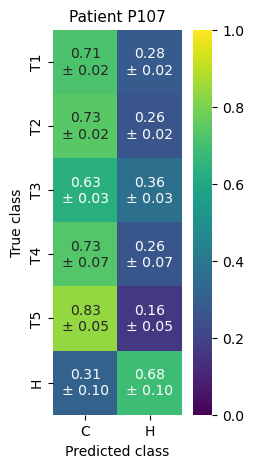

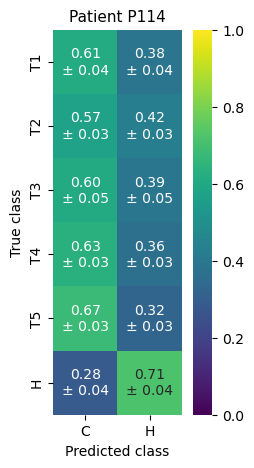

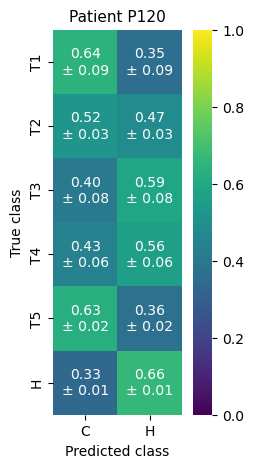

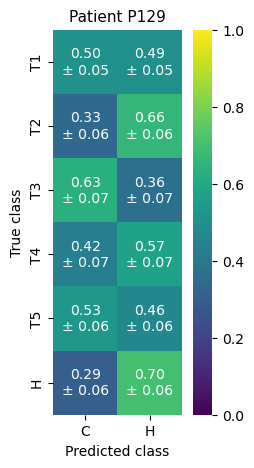

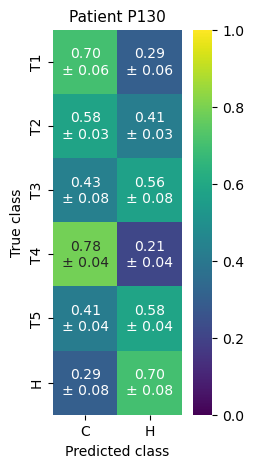

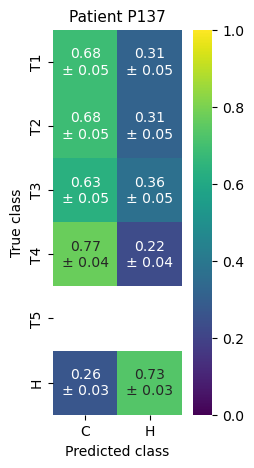

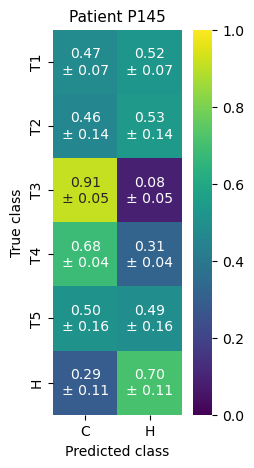

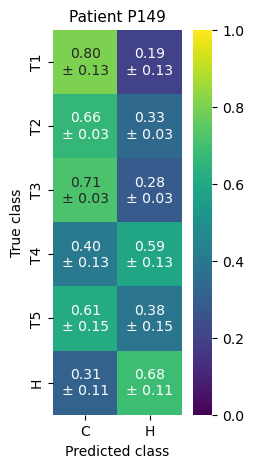

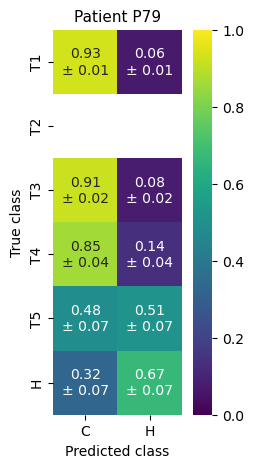

In [233]:
for p in patients:
  cms_mean = np.zeros((6, 2))
  cms_std = np.zeros((6, 2))

  for t in [1, 2, 3, 4, 5]:
    select = np.argwhere((np.array(ps) == p) & (np.array(ts) == t)).flatten()
    cms_t_mean = np.mean(np.array(cms)[select], axis=0)
    cms_t_std = np.std(np.array(cms)[select], axis=0)
    if t == 1:
      # for true label healthy
      cms_mean[-1] = cms_t_mean[1]
      cms_std[-1] = cms_t_std[1]
    # for true label disease at timepoint t
    cms_mean[t-1] = cms_t_mean[0]
    cms_std[t-1] = cms_t_std[0]

  cms_df = pd.DataFrame(cms_mean, index=['T1', 'T2', 'T3', 'T4', 'T5', 'H'], columns=['C', 'H'])
  fig, ax = plt.subplots(figsize=[3, 5])
  ax = sns.heatmap(
      cms_df,
      annot=pd.DataFrame(cms_mean.astype(str)).applymap(lambda x : x[:4]) + '\n± ' + pd.DataFrame(cms_std.astype(str)).applymap(lambda x : x[:4]),
      fmt='s',
      cmap='viridis',
      vmin=0,
      vmax=1,
      # cbar=False,
  )
  ax.set_xlabel('Predicted class')
  ax.set_ylabel('True class')
  ax.set_title(f'Patient {p}', size=11)
  ax.set_aspect(1)
  fig.show()

## Plate 3

In [234]:
plate_id = 3
m = 100
data = PlateDataset([plate_id], strict_discard=False)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.49it/s]


In [235]:
counts = data.info.groupby(['patient', 'time'])[['cell']].count().rename(columns={'cell':'count'})
few = counts[counts['count'] < m]
print(few)
enough = counts[counts['count'] >= m].index.copy()
enough = counts.loc[enough].reset_index()
print(enough.groupby('time').count())  # check that healty is smallest group
enough_samples = (enough['patient'] + '_' + enough['time'].apply(str)).str.split('_0', expand=True)[0].values
print(enough_samples)

              count
patient time       
P50     1        70
        2        67
      patient  count
time                
0           4      4
1           8      8
2           8      8
3           9      9
4           7      7
5           7      7
['H06' 'H07' 'H23' 'H30' 'P100_1' 'P100_2' 'P100_3' 'P100_4' 'P100_5'
 'P115_1' 'P115_2' 'P115_3' 'P125_1' 'P125_2' 'P125_3' 'P125_4' 'P125_5'
 'P41_1' 'P41_2' 'P41_3' 'P41_4' 'P41_5' 'P50_3' 'P50_4' 'P56_1' 'P56_2'
 'P56_3' 'P56_4' 'P56_5' 'P67_1' 'P67_2' 'P67_3' 'P67_4' 'P67_5' 'P72_1'
 'P72_2' 'P72_3' 'P72_5' 'P77_1' 'P77_2' 'P77_3' 'P77_4' 'P77_5']


In [236]:
enough[enough['time'] == 1]

patient  time  count
4     P100     1    168
9     P115     1    252
12    P125     1    496
17     P41     1    118
24     P56     1    119
29     P67     1   2594
34     P72     1    728
38     P77     1    180

In [237]:
enough[enough['time'] == 0]

patient  time  count
0     H06     0   1607
1     H07     0    578
2     H23     0    554
3     H30     0   1002

In [238]:
healthy = enough[enough['time'] == 0]['patient'].unique()
patients = enough[enough['time'] == 1]['patient'].unique()
nc, nh = how_many_cells_per_condition_patient(patients, healthy, enough)
nc, nh

(118, 236)

In [239]:
labels = torch.from_numpy((data.info['group'] == 'healthy').values).float()
dataset = TensorDataset(T.CenterCrop(28)(data.imgs), labels)

np.random.seed(13423)
confusion = {}
cms = []
enough = enough.reset_index()
enough = enough.set_index(['patient', 'time'])
for h, p in tqdm(list(product(healthy, patients))):
  healthy_train = healthy[healthy != h]
  patients_train = patients[patients != p]
  train_idx = np.concatenate([np.random.choice(np.argwhere(
      ((data.info['time'].values == 1) & (data.info['patient'].values == x))).flatten(),
                                                size=nc, replace=False) for x in patients_train]
              + [np.random.choice(np.argwhere(
                                  (data.info['patient'].values == x)).flatten(),
                                                size=nh, replace=False) for x in healthy_train])
  train_dataset = Subset(dataset, train_idx.tolist())
  print(h, p, ': training dataset size: ', len(train_dataset))

  k = min(enough.loc[(p, 1), 'count'], enough.loc[(h, 0), 'count'])
  test_idx = np.concatenate([np.random.choice(np.argwhere(
      ((data.info['time'] == 1) & (data.info['patient'] == p)).values).flatten(), size=k, replace=False),
                              np.random.choice(np.argwhere(
                                  (data.info['patient'] == h).values).flatten(), size=k, replace=False)])
  test_dataset = Subset(dataset, test_idx)

  model = Classifier().to(device)
  _ = train_model_with_datasets(model, train_dataset, val_dataset=test_dataset, fname=f'patch_plate{plate_id}_t1_{p}_{h}_{patients_train[0]}_{patients_train[1]}_{patients_train[2]}',
                  plot=False, save_model=False, num_epochs=30, batch_size=64, lr=0.001, device=device)

  for t in [1, 2, 3, 4, 5]:
    if not (p, t) in set(enough.index.values):
      continue
    test_idx = np.concatenate([np.argwhere(((data.info['time'] == t) & (data.info['patient'] == p)).values).flatten(),
                               np.argwhere((data.info['patient'] == h).values).flatten()])

    test_dataset = Subset(dataset, test_idx)
    preds, labs = eval_model_on_dataset(model, test_dataset, device=device)
    cms.append((h, p, t, patients_train, confusion_matrix(labs, preds, normalize='true')))

  0%|                                                                                                                                                                                          | 0/32 [00:00<?, ?it/s]

H06 P100 : training dataset size:  1534


epoch: 29; train loss: 0.12192693; val loss: 0.39313272; train accuracy: 0.96675359; val accuracy: 0.85416667 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 19.10it/s]
  3%|█████▌                                                                                                                                                                            | 1/32 [00:01<00:52,  1.69s/it]

H06 P115 : training dataset size:  1534


epoch: 29; train loss: 0.11308985; val loss: 0.40639800; train accuracy: 0.96740548; val accuracy: 0.84722222 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 15.18it/s]
  6%|███████████▏                                                                                                                                                                      | 2/32 [00:03<00:57,  1.92s/it]

H06 P125 : training dataset size:  1534


epoch: 29; train loss: 0.07424371; val loss: 1.38755500; train accuracy: 0.97783572; val accuracy: 0.58266129 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 17.52it/s]
  9%|████████████████▋                                                                                                                                                                 | 3/32 [00:05<00:54,  1.89s/it]

H06 P41 : training dataset size:  1534


epoch: 29; train loss: 0.08718772; val loss: 0.44603384; train accuracy: 0.97979140; val accuracy: 0.81355932 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 19.35it/s]
 12%|██████████████████████▎                                                                                                                                                           | 4/32 [00:07<00:50,  1.81s/it]

H06 P56 : training dataset size:  1534


epoch: 29; train loss: 0.07070582; val loss: 0.76490021; train accuracy: 0.98435463; val accuracy: 0.80252101 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 19.37it/s]
 16%|███████████████████████████▊                                                                                                                                                      | 5/32 [00:09<00:47,  1.77s/it]

H06 P67 : training dataset size:  1534


epoch: 29; train loss: 0.08997452; val loss: 0.57642753; train accuracy: 0.97718383; val accuracy: 0.78811450 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 13.82it/s]
 19%|█████████████████████████████████▍                                                                                                                                                | 6/32 [00:11<00:50,  1.95s/it]

H06 P72 : training dataset size:  1534


epoch: 29; train loss: 0.08093045; val loss: 0.72885954; train accuracy: 0.97327249; val accuracy: 0.74793956 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 13.55it/s]
 22%|██████████████████████████████████████▉                                                                                                                                           | 7/32 [00:13<00:51,  2.07s/it]

H06 P77 : training dataset size:  1534


epoch: 29; train loss: 0.09327096; val loss: 0.50087178; train accuracy: 0.97783572; val accuracy: 0.81666667 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 19.08it/s]
 25%|████████████████████████████████████████████▌                                                                                                                                     | 8/32 [00:15<00:46,  1.95s/it]

H07 P100 : training dataset size:  1534


epoch: 29; train loss: 0.07516314; val loss: 0.35705790; train accuracy: 0.98239896; val accuracy: 0.90178571 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 19.10it/s]
 28%|██████████████████████████████████████████████████                                                                                                                                | 9/32 [00:16<00:42,  1.86s/it]

H07 P115 : training dataset size:  1534


epoch: 29; train loss: 0.08944619; val loss: 0.25774926; train accuracy: 0.97522816; val accuracy: 0.91468254 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 18.82it/s]
 31%|███████████████████████████████████████████████████████▎                                                                                                                         | 10/32 [00:18<00:39,  1.80s/it]

H07 P125 : training dataset size:  1534


epoch: 29; train loss: 0.08988190; val loss: 1.48271596; train accuracy: 0.97913950; val accuracy: 0.56552419 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 17.70it/s]
 34%|████████████████████████████████████████████████████████████▊                                                                                                                    | 11/32 [00:20<00:37,  1.80s/it]

H07 P41 : training dataset size:  1534


epoch: 29; train loss: 0.07339938; val loss: 0.39927953; train accuracy: 0.98174707; val accuracy: 0.86016949 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 19.40it/s]
 38%|██████████████████████████████████████████████████████████████████▍                                                                                                              | 12/32 [00:22<00:35,  1.75s/it]

H07 P56 : training dataset size:  1534


epoch: 29; train loss: 0.11208638; val loss: 0.51722288; train accuracy: 0.95893090; val accuracy: 0.86554622 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 19.42it/s]
 41%|███████████████████████████████████████████████████████████████████████▉                                                                                                         | 13/32 [00:23<00:32,  1.72s/it]

H07 P67 : training dataset size:  1534


epoch: 29; train loss: 0.10208454; val loss: 0.30552116; train accuracy: 0.97457627; val accuracy: 0.88754325 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 17.24it/s]
 44%|█████████████████████████████████████████████████████████████████████████████▍                                                                                                   | 14/32 [00:25<00:31,  1.76s/it]

H07 P72 : training dataset size:  1534


epoch: 29; train loss: 0.08872413; val loss: 0.45386314; train accuracy: 0.97131682; val accuracy: 0.82525952 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 17.37it/s]
 47%|██████████████████████████████████████████████████████████████████████████████████▉                                                                                              | 15/32 [00:27<00:30,  1.77s/it]

H07 P77 : training dataset size:  1534


epoch: 29; train loss: 0.07289256; val loss: 0.38929173; train accuracy: 0.97848761; val accuracy: 0.86666667 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 19.08it/s]
 50%|████████████████████████████████████████████████████████████████████████████████████████▌                                                                                        | 16/32 [00:29<00:27,  1.74s/it]

H23 P100 : training dataset size:  1534


epoch: 29; train loss: 0.07489554; val loss: 0.81915456; train accuracy: 0.97913950; val accuracy: 0.75595238 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 19.07it/s]
 53%|██████████████████████████████████████████████████████████████████████████████████████████████                                                                                   | 17/32 [00:30<00:25,  1.71s/it]

H23 P115 : training dataset size:  1534


epoch: 29; train loss: 0.13037463; val loss: 0.56077778; train accuracy: 0.95371578; val accuracy: 0.80952381 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 18.81it/s]
 56%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                             | 18/32 [00:32<00:23,  1.70s/it]

H23 P125 : training dataset size:  1534


epoch: 29; train loss: 0.04980433; val loss: 1.80611360; train accuracy: 0.98826597; val accuracy: 0.48991935 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 17.71it/s]
 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                        | 19/32 [00:34<00:22,  1.73s/it]

H23 P41 : training dataset size:  1534


epoch: 29; train loss: 0.08311698; val loss: 0.68026251; train accuracy: 0.98109518; val accuracy: 0.77966102 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 19.42it/s]
 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                  | 20/32 [00:35<00:20,  1.70s/it]

H23 P56 : training dataset size:  1534


epoch: 29; train loss: 0.06447290; val loss: 0.85720521; train accuracy: 0.98631030; val accuracy: 0.76050420 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 19.33it/s]
 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                            | 21/32 [00:37<00:18,  1.68s/it]

H23 P67 : training dataset size:  1534


epoch: 29; train loss: 0.08010393; val loss: 0.84862947; train accuracy: 0.97913950; val accuracy: 0.74007220 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 17.39it/s]
 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                       | 22/32 [00:39<00:17,  1.73s/it]

H23 P72 : training dataset size:  1534


epoch: 29; train loss: 0.06660034; val loss: 0.97117114; train accuracy: 0.98239896; val accuracy: 0.70306859 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 14.46it/s]
 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 23/32 [00:41<00:16,  1.85s/it]

H23 P77 : training dataset size:  1534


epoch: 29; train loss: 0.05858525; val loss: 0.54018259; train accuracy: 0.98956975; val accuracy: 0.83055556 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 19.24it/s]
 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 24/32 [00:43<00:14,  1.79s/it]

H30 P100 : training dataset size:  1534


epoch: 29; train loss: 0.10749357; val loss: 0.17506036; train accuracy: 0.97392438; val accuracy: 0.92857143 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 19.09it/s]
 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 25/32 [00:44<00:12,  1.75s/it]

H30 P115 : training dataset size:  1534


epoch: 29; train loss: 0.11206630; val loss: 0.32915789; train accuracy: 0.96870926; val accuracy: 0.86111111 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 18.79it/s]
 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 26/32 [00:46<00:10,  1.73s/it]

H30 P125 : training dataset size:  1534


epoch: 29; train loss: 0.07334643; val loss: 1.33435595; train accuracy: 0.97522816; val accuracy: 0.58568548 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 17.77it/s]
 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 27/32 [00:48<00:08,  1.75s/it]

H30 P41 : training dataset size:  1534


epoch: 29; train loss: 0.06623059; val loss: 0.37375647; train accuracy: 0.98956975; val accuracy: 0.83898305 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 19.18it/s]
 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 28/32 [00:49<00:06,  1.73s/it]

H30 P56 : training dataset size:  1534


epoch: 29; train loss: 0.07771225; val loss: 0.64232814; train accuracy: 0.97783572; val accuracy: 0.82352941 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 19.43it/s]
 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 29/32 [00:51<00:05,  1.71s/it]

H30 P67 : training dataset size:  1534


epoch: 29; train loss: 0.07211156; val loss: 0.42141595; train accuracy: 0.98239896; val accuracy: 0.82934132 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 15.74it/s]
 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 30/32 [00:53<00:03,  1.80s/it]

H30 P72 : training dataset size:  1534


epoch: 29; train loss: 0.08217149; val loss: 0.52300006; train accuracy: 0.97718383; val accuracy: 0.79601648 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 13.92it/s]
 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 31/32 [00:55<00:01,  1.93s/it]

H30 P77 : training dataset size:  1534


epoch: 29; train loss: 0.09026210; val loss: 0.24751100; train accuracy: 0.97588005; val accuracy: 0.91111111 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 19.16it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:57<00:00,  1.80s/it]


In [240]:
import pickle

confusion = cms
with open(f'/ewsc/hschluet/models/pbmc5/rerun/plate_{plate_id}_confusion_t1_new.pkl', 'wb') as handle:
    pickle.dump(confusion, handle, protocol=pickle.HIGHEST_PROTOCOL)

# with open('filename.pickle', 'rb') as handle:
#     b = pickle.load(handle)

In [241]:
hs, ps, ts, _, cms = zip(*confusion)
cms_dfs = []

pats = np.unique(ps)
for p in pats:
    cms_mean = np.zeros((6, 2))
    cms_std = np.zeros((6, 2))

    for t in [1, 2, 3, 4, 5]:
        select = np.argwhere((np.array(ps) == p) & (np.array(ts) == t)).flatten()
        cms_t_mean = np.mean(np.array(cms)[select], axis=0)
        cms_t_std = np.std(np.array(cms)[select], axis=0)
        if t == 1:
            # for true label healthy
            cms_mean[-1] = cms_t_mean[1]
            cms_std[-1] = cms_t_std[1]
        # for true label disease at timepoint t
        cms_mean[t-1] = cms_t_mean[0]
        cms_std[t-1] = cms_t_std[0]


    cms_df = pd.DataFrame(cms_mean, index=['T1', 'T2', 'T3', 'T4', 'T5', 'H'], columns=['C', 'H']).drop(columns=['C'])
    cms_df['std'] = cms_std[:, 0]
    cms_df['pred H %'] = cms_df['H']
    cms_df['score'] = cms_df['H'] / cms_df.loc['H', 'H']
    cms_df['patient'] = p
    cms_df['plate'] = plate_id
    cms_df.index.name = 'TP'
    cms_df = cms_df.reset_index()
    cms_df['time'] = cms_df['TP'].replace({'T1' : 1, 'T2' : 2, 'T3':3, 'T4':4, 'T5':5, 'H':0})
    cms_df.loc[cms_df['time'] == 0, 'patient'] = 'H???'
    cms_dfs.append(cms_df.drop(columns=['H', 'TP']))

cms_df = pd.concat(cms_dfs, ignore_index=True)
cms_df = cms_df.rename(columns={'H':'pred H %'}).sort_values(by=['patient', 'time']).reset_index(drop=True)
cms_df.to_csv(f'/ewsc/hschluet/models/pbmc5/rerun/within_plate_{plate_id}_from_scratch_results.csv')
cms_df

/tmp/ipykernel_2628142/1678131924.py:30: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cms_df['time'] = cms_df['TP'].replace({'T1' : 1, 'T2' : 2, 'T3':3, 'T4':4, 'T5':5, 'H':0})
/local_home/hschluet/anaconda3/envs/img-39/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/local_home/hschluet/anaconda3/envs/img-39/lib/python3.9/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/local_home/hschluet/anaconda3/envs/img-39/lib/python3.9/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/local_home/hsc

std  pred H %     score patient  plate  time
0   0.144111  0.712187  1.000000    H???      3     0
1   0.078635  0.793015  1.000000    H???      3     0
2   0.123646  0.797371  1.000000    H???      3     0
3   0.075190  0.790739  1.000000    H???      3     0
4   0.111494  0.729552  1.000000    H???      3     0
5   0.100643  0.759920  1.000000    H???      3     0
6   0.062003  0.768576  1.000000    H???      3     0
7   0.058986  0.725449  1.000000    H???      3     0
8   0.006655  0.014881  0.020895    P100      3     1
9   0.009476  0.019565  0.027472    P100      3     2
10  0.053977  0.670901  0.942029    P100      3     3
11  0.047373  0.823171  1.155835    P100      3     4
12  0.053724  0.256144  0.359659    P100      3     5
13  0.035103  0.049603  0.062550    P115      3     1
14  0.058629  0.697912  0.880074    P115      3     2
15  0.032017  0.784241  0.988936    P115      3     3
16       NaN       NaN       NaN    P115      3     4
17       NaN       NaN       NaN    P115      3     5
18  0.088047  0.685988  0.860313    P125      3     1
19  0.064560  0.156036  0.195689    P125      3     2
20  0.084215  0.475075  0.595802    P125      3     3
21  0.096096  0.306688  0.384625    P125      3     4
22  0.094173  0.692877  0.868953    P125      3     5
23  0.026799  0.127119  0.160759     P41      3     1
24  0.026073  0.176357  0.223028     P41      3     2
25  0.024857  0.155462  0.196604     P41      3     3
26  0.016354  0.052746  0.066705     P41      3     4
27  0.013300  0.904360  1.143691     P41      3     5
28  0.030876  0.134454  0.184296     P56      3     1
29  0.041557  0.108108  0.148184     P56      3     2
30  0.007533  0.038594  0.052902     P56      3     3
31  0.027025  0.077985  0.106894     P56      3     4
32  0.040761  0.290555  0.398265     P56      3     5
33  0.017498  0.143890  0.189349     P67      3     1
34  0.020805  0.093211  0.122659     P67      3     2
35  0.054529  0.315397  0.415040     P67      3     3
36  0.018876  0.063869  0.084047     P67      3     4
37  0.030535  0.691615  0.910115     P67      3     5
38  0.051244  0.232486  0.302490     P72      3     1
39  0.012712  0.021186  0.027566     P72      3     2
40  0.002638  0.010646  0.013851     P72      3     3
41       NaN       NaN       NaN     P72      3     4
42  0.015924  0.022293  0.029006     P72      3     5
43  0.006804  0.027778  0.038290     P77      3     1
44  0.019046  0.073928  0.101906     P77      3     2
45  0.043543  0.233771  0.322243     P77      3     3
46  0.001787  0.008082  0.011141     P77      3     4
47  0.062654  0.789591  1.088417     P77      3     5

/tmp/ipykernel_2628142/1479086869.py:21: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  annot=pd.DataFrame(cms_mean.astype(str)).applymap(lambda x : x[:4]) + '\n± ' + pd.DataFrame(cms_std.astype(str)).applymap(lambda x : x[:4]),
/local_home/hschluet/anaconda3/envs/img-39/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/local_home/hschluet/anaconda3/envs/img-39/lib/python3.9/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/local_home/hschluet/anaconda3/envs/img-39/lib/python3.9/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/local_home/hschluet/anaconda3/envs/img-39/lib/python3.9/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmea

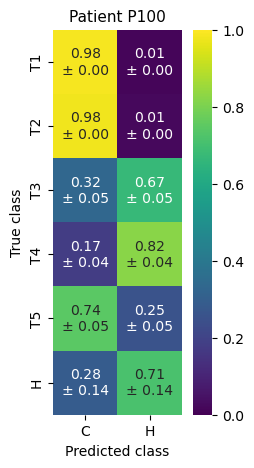

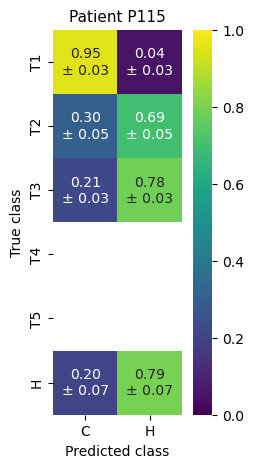

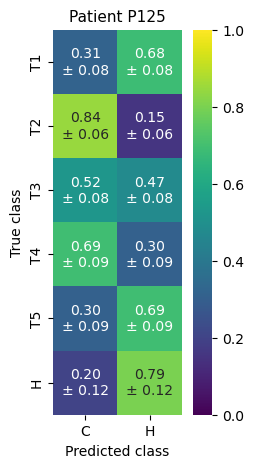

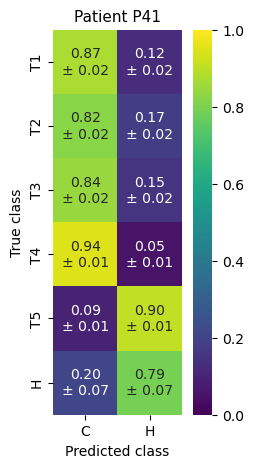

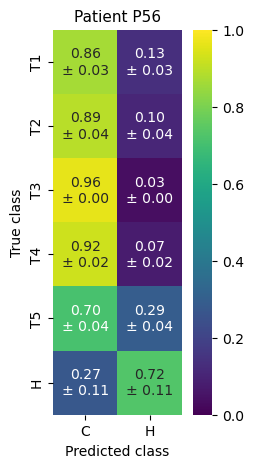

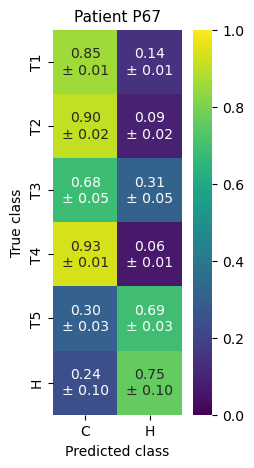

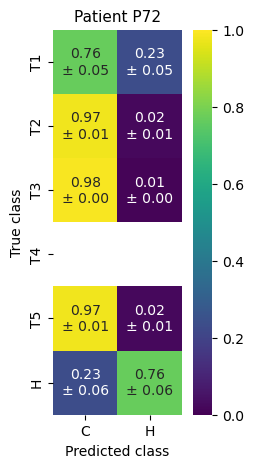

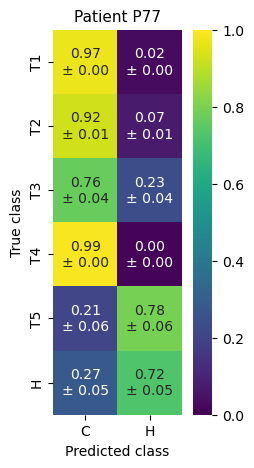

In [242]:
for p in patients:
  cms_mean = np.zeros((6, 2))
  cms_std = np.zeros((6, 2))

  for t in [1, 2, 3, 4, 5]:
    select = np.argwhere((np.array(ps) == p) & (np.array(ts) == t)).flatten()
    cms_t_mean = np.mean(np.array(cms)[select], axis=0)
    cms_t_std = np.std(np.array(cms)[select], axis=0)
    if t == 1:
      # for true label healthy
      cms_mean[-1] = cms_t_mean[1]
      cms_std[-1] = cms_t_std[1]
    # for true label disease at timepoint t
    cms_mean[t-1] = cms_t_mean[0]
    cms_std[t-1] = cms_t_std[0]

  cms_df = pd.DataFrame(cms_mean, index=['T1', 'T2', 'T3', 'T4', 'T5', 'H'], columns=['C', 'H'])
  fig, ax = plt.subplots(figsize=[3, 5])
  ax = sns.heatmap(
      cms_df,
      annot=pd.DataFrame(cms_mean.astype(str)).applymap(lambda x : x[:4]) + '\n± ' + pd.DataFrame(cms_std.astype(str)).applymap(lambda x : x[:4]),
      fmt='s',
      cmap='viridis',
      vmin=0,
      vmax=1,
      # cbar=False,
  )
  ax.set_xlabel('Predicted class')
  ax.set_ylabel('True class')
  ax.set_title(f'Patient {p}', size=11)
  ax.set_aspect(1)
  fig.show()

## Plate 2

In [243]:
plate_id = 2
m = 100
data = PlateDataset([plate_id], strict_discard=False)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.28it/s]


In [244]:
counts = data.info.groupby(['patient', 'time'])[['cell']].count().rename(columns={'cell':'count'})
few = counts[counts['count'] < m]
print(few)
enough = counts[counts['count'] >= m].index.copy()
enough = counts.loc[enough].reset_index()
print(enough.groupby('time').count())  # check that healty is smallest group
enough_samples = (enough['patient'] + '_' + enough['time'].apply(str)).str.split('_0', expand=True)[0].values
print(enough_samples)

Empty DataFrame
Columns: [count]
Index: []
      patient  count
time                
0           4      4
1           9      9
2           9      9
3           8      8
4           8      8
5           9      9
['H04' 'H05' 'H06' 'H07' 'P104_1' 'P104_2' 'P104_3' 'P104_4' 'P104_5'
 'P116_1' 'P116_2' 'P116_3' 'P116_4' 'P116_5' 'P124_1' 'P124_2' 'P124_3'
 'P124_4' 'P124_5' 'P15_1' 'P15_2' 'P15_3' 'P15_4' 'P15_5' 'P16_1' 'P16_2'
 'P16_3' 'P16_5' 'P22_1' 'P22_2' 'P22_3' 'P22_4' 'P22_5' 'P29_1' 'P29_2'
 'P29_3' 'P29_4' 'P29_5' 'P52_1' 'P52_2' 'P52_3' 'P52_4' 'P52_5' 'P84_1'
 'P84_2' 'P84_4' 'P84_5']


In [245]:
enough[enough['time'] == 1]

patient  time  count
4     P104     1   1412
9     P116     1   2933
14    P124     1   3724
19     P15     1   4435
24     P16     1   2572
28     P22     1   6154
33     P29     1   8510
38     P52     1   1272
43     P84     1   2572

In [246]:
enough[enough['time'] == 0]

patient  time  count
0     H04     0   3655
1     H05     0   3732
2     H06     0   4011
3     H07     0   2393

In [247]:
healthy = enough[enough['time'] == 0]['patient'].unique()
patients = enough[enough['time'] == 1]['patient'].unique()
nc, nh = how_many_cells_per_condition_patient(patients, healthy, enough)
nc, nh

(1060, 2385)

In [248]:
labels = torch.from_numpy((data.info['group'] == 'healthy').values).float()
dataset = TensorDataset(T.CenterCrop(28)(data.imgs), labels)

np.random.seed(13423)
confusion = {}
cms = []
enough = enough.reset_index()
enough = enough.set_index(['patient', 'time'])
for h, p in tqdm(list(product(healthy, patients))):
  healthy_train = healthy[healthy != h]
  patients_train = patients[patients != p]
  train_idx = np.concatenate([np.random.choice(np.argwhere(
      ((data.info['time'].values == 1) & (data.info['patient'].values == x))).flatten(),
                                                size=nc, replace=False) for x in patients_train]
              + [np.random.choice(np.argwhere(
                                  (data.info['patient'].values == x)).flatten(),
                                                size=nh, replace=False) for x in healthy_train])
  train_dataset = Subset(dataset, train_idx.tolist())
  print(h, p, ': training dataset size: ', len(train_dataset))

  k = min(enough.loc[(p, 1), 'count'], enough.loc[(h, 0), 'count'])
  test_idx = np.concatenate([np.random.choice(np.argwhere(
      ((data.info['time'] == 1) & (data.info['patient'] == p)).values).flatten(), size=k, replace=False),
                              np.random.choice(np.argwhere(
                                  (data.info['patient'] == h).values).flatten(), size=k, replace=False)])
  test_dataset = Subset(dataset, test_idx)

  model = Classifier().to(device)
  _ = train_model_with_datasets(model, train_dataset, val_dataset=test_dataset, fname=f'patch_plate{plate_id}_t1_{p}_{h}_{patients_train[0]}_{patients_train[1]}_{patients_train[2]}',
                  plot=False, save_model=False, num_epochs=30, batch_size=64, lr=0.001, device=device)

  for t in [1, 2, 3, 4, 5]:
    if not (p, t) in set(enough.index.values):
      continue
    test_idx = np.concatenate([np.argwhere(((data.info['time'] == t) & (data.info['patient'] == p)).values).flatten(),
                               np.argwhere((data.info['patient'] == h).values).flatten()])

    test_dataset = Subset(dataset, test_idx)
    preds, labs = eval_model_on_dataset(model, test_dataset, device=device)
    cms.append((h, p, t, patients_train, confusion_matrix(labs, preds, normalize='true')))

  0%|                                                                                                                                                                                          | 0/36 [00:00<?, ?it/s]

H04 P104 : training dataset size:  15635


epoch: 29; train loss: 0.08338228; val loss: 0.84287190; train accuracy: 0.96808443; val accuracy: 0.84206799 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:15<00:00,  1.95it/s]
  3%|████▉                                                                                                                                                                             | 1/36 [00:15<09:11, 15.75s/it]

H04 P116 : training dataset size:  15635


epoch: 29; train loss: 0.07807213; val loss: 1.07025665; train accuracy: 0.97019508; val accuracy: 0.73678827 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:16<00:00,  1.85it/s]
  6%|█████████▉                                                                                                                                                                        | 2/36 [00:32<09:19, 16.46s/it]

H04 P124 : training dataset size:  15635


epoch: 29; train loss: 0.06874039; val loss: 0.49533132; train accuracy: 0.97416054; val accuracy: 0.87961696 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:16<00:00,  1.82it/s]
  8%|██████████████▊                                                                                                                                                                   | 3/36 [00:49<09:08, 16.63s/it]

H04 P15 : training dataset size:  15635


epoch: 29; train loss: 0.05975296; val loss: 1.11386132; train accuracy: 0.97870163; val accuracy: 0.71258550 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:16<00:00,  1.83it/s]
 11%|███████████████████▊                                                                                                                                                              | 4/36 [01:06<08:54, 16.69s/it]

H04 P16 : training dataset size:  15635


epoch: 29; train loss: 0.11350282; val loss: 0.53813722; train accuracy: 0.95433323; val accuracy: 0.87461120 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:15<00:00,  1.88it/s]
 14%|████████████████████████▋                                                                                                                                                         | 5/36 [01:22<08:32, 16.53s/it]

H04 P22 : training dataset size:  15635


epoch: 29; train loss: 0.05083502; val loss: 1.19849256; train accuracy: 0.98317877; val accuracy: 0.73255814 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:16<00:00,  1.78it/s]
 17%|█████████████████████████████▋                                                                                                                                                    | 6/36 [01:39<08:22, 16.75s/it]

H04 P29 : training dataset size:  15635


epoch: 29; train loss: 0.05807840; val loss: 1.03209850; train accuracy: 0.97940518; val accuracy: 0.78932969 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:16<00:00,  1.82it/s]
 19%|██████████████████████████████████▌                                                                                                                                               | 7/36 [01:56<08:07, 16.80s/it]

H04 P52 : training dataset size:  15635


epoch: 29; train loss: 0.10318923; val loss: 0.77839571; train accuracy: 0.96028142; val accuracy: 0.78459119 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:15<00:00,  1.94it/s]
 22%|███████████████████████████████████████▌                                                                                                                                          | 8/36 [02:12<07:41, 16.48s/it]

H04 P84 : training dataset size:  15635


epoch: 29; train loss: 0.08280789; val loss: 1.07464178; train accuracy: 0.96821234; val accuracy: 0.71150855 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:15<00:00,  1.93it/s]
 25%|████████████████████████████████████████████▌                                                                                                                                     | 9/36 [02:28<07:19, 16.28s/it]

H05 P104 : training dataset size:  15635


epoch: 29; train loss: 0.11961516; val loss: 0.74031591; train accuracy: 0.95267029; val accuracy: 0.82365439 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:15<00:00,  1.94it/s]
 28%|█████████████████████████████████████████████████▏                                                                                                                               | 10/36 [02:44<06:59, 16.15s/it]

H05 P116 : training dataset size:  15635


epoch: 29; train loss: 0.07145231; val loss: 1.29751070; train accuracy: 0.97467221; val accuracy: 0.70201159 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:16<00:00,  1.86it/s]
 31%|██████████████████████████████████████████████████████                                                                                                                           | 11/36 [03:00<06:46, 16.26s/it]

H05 P124 : training dataset size:  15635


epoch: 29; train loss: 0.06300441; val loss: 0.76501206; train accuracy: 0.97863767; val accuracy: 0.84935553 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:16<00:00,  1.78it/s]
 33%|███████████████████████████████████████████████████████████                                                                                                                      | 12/36 [03:17<06:37, 16.58s/it]

H05 P15 : training dataset size:  15635


epoch: 29; train loss: 0.07609216; val loss: 1.21832854; train accuracy: 0.97198593; val accuracy: 0.68756699 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:16<00:00,  1.82it/s]
 36%|███████████████████████████████████████████████████████████████▉                                                                                                                 | 13/36 [03:34<06:22, 16.65s/it]

H05 P16 : training dataset size:  15635


epoch: 29; train loss: 0.06908422; val loss: 0.66230790; train accuracy: 0.97518388; val accuracy: 0.87208398 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:15<00:00,  1.88it/s]
 39%|████████████████████████████████████████████████████████████████████▊                                                                                                            | 14/36 [03:51<06:03, 16.54s/it]

H05 P22 : training dataset size:  15635


epoch: 29; train loss: 0.09455580; val loss: 1.20064932; train accuracy: 0.96232811; val accuracy: 0.71771168 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:16<00:00,  1.83it/s]
 42%|█████████████████████████████████████████████████████████████████████████▊                                                                                                       | 15/36 [04:08<05:51, 16.73s/it]

H05 P29 : training dataset size:  15635


epoch: 29; train loss: 0.09299960; val loss: 0.73997852; train accuracy: 0.96405500; val accuracy: 0.78469989 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:16<00:00,  1.82it/s]
 44%|██████████████████████████████████████████████████████████████████████████████▋                                                                                                  | 16/36 [04:25<05:35, 16.77s/it]

H05 P52 : training dataset size:  15635


epoch: 29; train loss: 0.10290171; val loss: 1.40589830; train accuracy: 0.95996162; val accuracy: 0.73270440 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:15<00:00,  1.99it/s]
 47%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                             | 17/36 [04:40<05:12, 16.46s/it]

H05 P84 : training dataset size:  15635


epoch: 29; train loss: 0.08292357; val loss: 1.20387149; train accuracy: 0.96674129; val accuracy: 0.71500778 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:15<00:00,  1.92it/s]
 50%|████████████████████████████████████████████████████████████████████████████████████████▌                                                                                        | 18/36 [04:56<04:53, 16.29s/it]

H06 P104 : training dataset size:  15635


epoch: 29; train loss: 0.09280693; val loss: 0.65936679; train accuracy: 0.96533419; val accuracy: 0.83781870 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:15<00:00,  1.94it/s]
 53%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                   | 19/36 [05:12<04:34, 16.17s/it]

H06 P116 : training dataset size:  15635


epoch: 29; train loss: 0.07547307; val loss: 1.09286213; train accuracy: 0.97134634; val accuracy: 0.72690078 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:16<00:00,  1.85it/s]
 56%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                              | 20/36 [05:29<04:20, 16.29s/it]

H06 P124 : training dataset size:  15635


epoch: 29; train loss: 0.08591503; val loss: 0.63606778; train accuracy: 0.96622961; val accuracy: 0.84895274 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:16<00:00,  1.79it/s]
 58%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                         | 21/36 [05:46<04:08, 16.57s/it]

H06 P15 : training dataset size:  15635


epoch: 29; train loss: 0.06083074; val loss: 1.08824274; train accuracy: 0.97742245; val accuracy: 0.70568437 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:16<00:00,  1.82it/s]
 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                    | 22/36 [06:03<03:53, 16.66s/it]

H06 P16 : training dataset size:  15635


epoch: 29; train loss: 0.09528750; val loss: 0.47996339; train accuracy: 0.96117685; val accuracy: 0.88394246 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:15<00:00,  1.89it/s]
 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                | 23/36 [06:19<03:34, 16.52s/it]

H06 P22 : training dataset size:  15635


epoch: 29; train loss: 0.05106499; val loss: 1.03115675; train accuracy: 0.98298689; val accuracy: 0.74756918 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:16<00:00,  1.78it/s]
 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                           | 24/36 [06:36<03:20, 16.75s/it]

H06 P29 : training dataset size:  15635


epoch: 29; train loss: 0.07439377; val loss: 0.64629126; train accuracy: 0.97230572; val accuracy: 0.81737721 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:16<00:00,  1.78it/s]
 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                      | 25/36 [06:53<03:05, 16.89s/it]

H06 P52 : training dataset size:  15635


epoch: 29; train loss: 0.08470417; val loss: 0.51795278; train accuracy: 0.96859610; val accuracy: 0.82665094 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:15<00:00,  1.99it/s]
 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 26/36 [07:09<02:44, 16.44s/it]

H06 P84 : training dataset size:  15635


epoch: 29; train loss: 0.07405699; val loss: 1.41819459; train accuracy: 0.97307323; val accuracy: 0.64541213 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:15<00:00,  1.88it/s]
 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 27/36 [07:25<02:27, 16.38s/it]

H07 P104 : training dataset size:  15635


epoch: 29; train loss: 0.07687554; val loss: 0.60166870; train accuracy: 0.97275344; val accuracy: 0.86189802 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:15<00:00,  1.94it/s]
 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 28/36 [07:41<02:09, 16.22s/it]

H07 P116 : training dataset size:  15635


epoch: 29; train loss: 0.07140748; val loss: 0.90668772; train accuracy: 0.97262552; val accuracy: 0.72356874 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:15<00:00,  1.93it/s]
 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 29/36 [07:57<01:53, 16.23s/it]

H07 P124 : training dataset size:  15635


epoch: 29; train loss: 0.08975573; val loss: 0.49043821; train accuracy: 0.96315958; val accuracy: 0.87735061 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:15<00:00,  1.94it/s]
 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 30/36 [08:13<01:36, 16.11s/it]

H07 P15 : training dataset size:  15635


epoch: 29; train loss: 0.09135032; val loss: 0.82404419; train accuracy: 0.96559002; val accuracy: 0.74341830 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:15<00:00,  1.89it/s]
 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 31/36 [08:29<01:20, 16.13s/it]

H07 P16 : training dataset size:  15635


epoch: 29; train loss: 0.09318696; val loss: 0.49141198; train accuracy: 0.96456668; val accuracy: 0.87902215 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:15<00:00,  1.90it/s]
 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 32/36 [08:45<01:04, 16.12s/it]

H07 P22 : training dataset size:  15635


epoch: 29; train loss: 0.07312953; val loss: 0.80931008; train accuracy: 0.97128238; val accuracy: 0.74404513 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:15<00:00,  1.90it/s]
 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 33/36 [09:01<00:48, 16.12s/it]

H07 P29 : training dataset size:  15635


epoch: 29; train loss: 0.07660649; val loss: 0.61410482; train accuracy: 0.97128238; val accuracy: 0.78750522 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:15<00:00,  1.89it/s]
 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 34/36 [09:18<00:32, 16.15s/it]

H07 P52 : training dataset size:  15635


epoch: 29; train loss: 0.12004345; val loss: 0.60918620; train accuracy: 0.94985609; val accuracy: 0.81682390 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:15<00:00,  1.95it/s]
 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 35/36 [09:33<00:15, 16.00s/it]

H07 P84 : training dataset size:  15635


epoch: 29; train loss: 0.07268022; val loss: 1.09021833; train accuracy: 0.97294531; val accuracy: 0.69995821 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:15<00:00,  1.94it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 36/36 [09:49<00:00, 16.38s/it]


In [249]:
import pickle

confusion = cms
with open(f'/ewsc/hschluet/models/pbmc5/rerun/plate_{plate_id}_confusion_t1_new.pkl', 'wb') as handle:
    pickle.dump(confusion, handle, protocol=pickle.HIGHEST_PROTOCOL)

# with open('filename.pickle', 'rb') as handle:
#     b = pickle.load(handle)

In [250]:
hs, ps, ts, _, cms = zip(*confusion)
cms_dfs = []

pats = np.unique(ps)
for p in pats:
    cms_mean = np.zeros((6, 2))
    cms_std = np.zeros((6, 2))

    for t in [1, 2, 3, 4, 5]:
        select = np.argwhere((np.array(ps) == p) & (np.array(ts) == t)).flatten()
        cms_t_mean = np.mean(np.array(cms)[select], axis=0)
        cms_t_std = np.std(np.array(cms)[select], axis=0)
        if t == 1:
            # for true label healthy
            cms_mean[-1] = cms_t_mean[1]
            cms_std[-1] = cms_t_std[1]
        # for true label disease at timepoint t
        cms_mean[t-1] = cms_t_mean[0]
        cms_std[t-1] = cms_t_std[0]


    cms_df = pd.DataFrame(cms_mean, index=['T1', 'T2', 'T3', 'T4', 'T5', 'H'], columns=['C', 'H']).drop(columns=['C'])
    cms_df['std'] = cms_std[:, 0]
    cms_df['pred H %'] = cms_df['H']
    cms_df['score'] = cms_df['H'] / cms_df.loc['H', 'H']
    cms_df['patient'] = p
    cms_df['plate'] = plate_id
    cms_df.index.name = 'TP'
    cms_df = cms_df.reset_index()
    cms_df['time'] = cms_df['TP'].replace({'T1' : 1, 'T2' : 2, 'T3':3, 'T4':4, 'T5':5, 'H':0})
    cms_df.loc[cms_df['time'] == 0, 'patient'] = 'H???'
    cms_dfs.append(cms_df.drop(columns=['H', 'TP']))

cms_df = pd.concat(cms_dfs, ignore_index=True)
cms_df = cms_df.rename(columns={'H':'pred H %'}).sort_values(by=['patient', 'time']).reset_index(drop=True)
cms_df.to_csv(f'/ewsc/hschluet/models/pbmc5/rerun/within_plate_{plate_id}_from_scratch_results.csv')
cms_df

/tmp/ipykernel_2628142/1678131924.py:30: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cms_df['time'] = cms_df['TP'].replace({'T1' : 1, 'T2' : 2, 'T3':3, 'T4':4, 'T5':5, 'H':0})
/tmp/ipykernel_2628142/1678131924.py:30: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cms_df['time'] = cms_df['TP'].replace({'T1' : 1, 'T2' : 2, 'T3':3, 'T4':4, 'T5':5, 'H':0})
/tmp/ipykernel_2628142/1678131924.py:30: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explici

std  pred H %     score patient  plate  time
0   0.049895  0.808633  1.000000    H???      2     0
1   0.102439  0.750948  1.000000    H???      2     0
2   0.045311  0.767914  1.000000    H???      2     0
3   0.043200  0.734684  1.000000    H???      2     0
4   0.009039  0.753165  1.000000    H???      2     0
5   0.069648  0.725112  1.000000    H???      2     0
6   0.057156  0.791818  1.000000    H???      2     0
7   0.078560  0.759760  1.000000    H???      2     0
8   0.085257  0.812762  1.000000    H???      2     0
9   0.030232  0.123761  0.153049    P104      2     1
10  0.050862  0.413326  0.511142    P104      2     2
11  0.007176  0.031828  0.039360    P104      2     3
12  0.038355  0.309067  0.382209    P104      2     4
13  0.018560  0.141652  0.175175    P104      2     5
14  0.080720  0.306938  0.408734    P116      2     1
15  0.077211  0.477599  0.635994    P116      2     2
16  0.055745  0.286622  0.381681    P116      2     3
17  0.047014  0.125573  0.167219    P116      2     4
18  0.147514  0.512069  0.681897    P116      2     5
19  0.015850  0.039944  0.052016    P124      2     1
20  0.078384  0.339969  0.442717    P124      2     2
21  0.063222  0.332104  0.432475    P124      2     3
22  0.058772  0.223480  0.291022    P124      2     4
23  0.000548  0.000930  0.001212    P124      2     5
24  0.033422  0.311838  0.424452     P15      2     1
25  0.042800  0.177694  0.241865     P15      2     2
26  0.042653  0.423789  0.576832     P15      2     3
27  0.025914  0.056041  0.076280     P15      2     4
28  0.019594  0.092334  0.125679     P15      2     5
29  0.000583  0.000583  0.000774     P16      2     1
30  0.026836  0.188803  0.250680     P16      2     2
31  0.007273  0.028509  0.037852     P16      2     3
32       NaN       NaN       NaN     P16      2     4
33  0.017899  0.097350  0.129255     P16      2     5
34  0.047565  0.251950  0.347463     P22      2     1
35  0.005136  0.019142  0.026399     P22      2     2
36  0.045856  0.235112  0.324242     P22      2     3
37  0.075656  0.330855  0.456281     P22      2     4
38  0.027847  0.177778  0.245173     P22      2     5
39  0.073719  0.205347  0.259336     P29      2     1
40  0.010379  0.027646  0.034914     P29      2     2
41  0.061435  0.268375  0.338935     P29      2     3
42  0.027636  0.118626  0.149815     P29      2     4
43  0.073789  0.387525  0.489411     P29      2     5
44  0.031469  0.174135  0.229198     P52      2     1
45  0.070954  0.400171  0.526707     P52      2     2
46  0.061435  0.290359  0.382172     P52      2     3
47  0.048000  0.274167  0.360860     P52      2     4
48  0.035840  0.113953  0.149986     P52      2     5
49  0.132900  0.427780  0.526329     P84      2     1
50  0.059833  0.109663  0.134926     P84      2     2
51       NaN       NaN       NaN     P84      2     3
52  0.092491  0.217705  0.267858     P84      2     4
53  0.079719  0.695559  0.855797     P84      2     5

/tmp/ipykernel_2628142/1479086869.py:21: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  annot=pd.DataFrame(cms_mean.astype(str)).applymap(lambda x : x[:4]) + '\n± ' + pd.DataFrame(cms_std.astype(str)).applymap(lambda x : x[:4]),
/tmp/ipykernel_2628142/1479086869.py:21: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  annot=pd.DataFrame(cms_mean.astype(str)).applymap(lambda x : x[:4]) + '\n± ' + pd.DataFrame(cms_std.astype(str)).applymap(lambda x : x[:4]),
/tmp/ipykernel_2628142/1479086869.py:21: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  annot=pd.DataFrame(cms_mean.astype(str)).applymap(lambda x : x[:4]) + '\n± ' + pd.DataFrame(cms_std.astype(str)).applymap(lambda x : x[:4]),
/tmp/ipykernel_2628142/1479086869.py:21: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  annot=pd.DataFrame(cms_mean.astype(str)).applymap(lambda x : x[:4]) + '\n± ' 

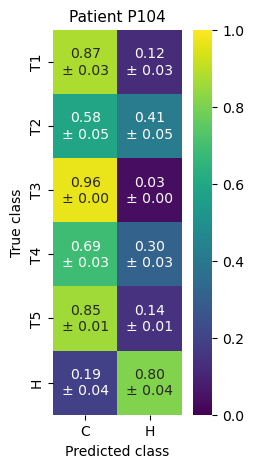

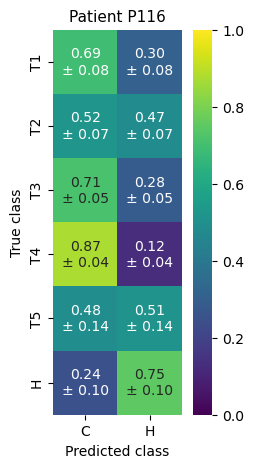

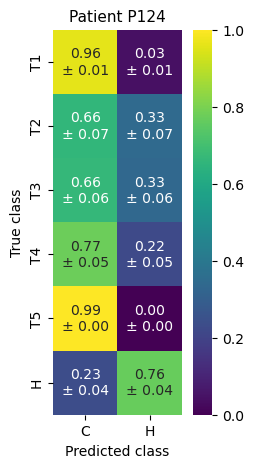

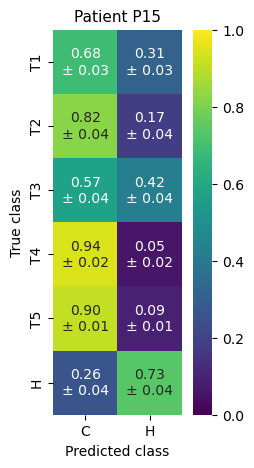

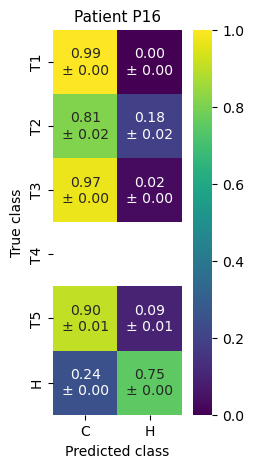

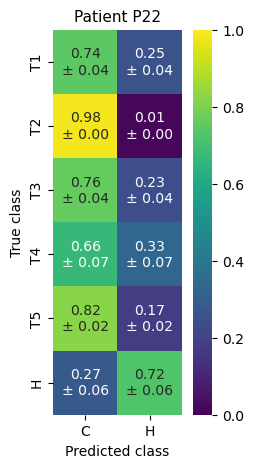

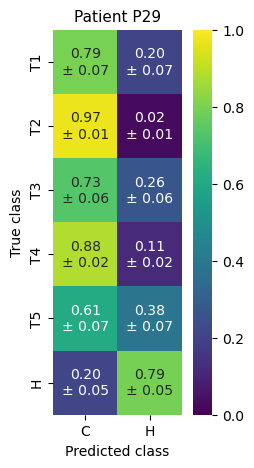

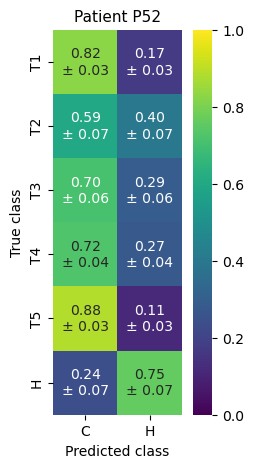

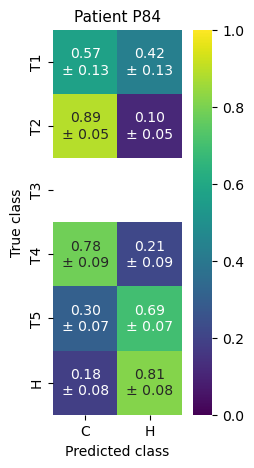

In [251]:
for p in patients:
  cms_mean = np.zeros((6, 2))
  cms_std = np.zeros((6, 2))

  for t in [1, 2, 3, 4, 5]:
    select = np.argwhere((np.array(ps) == p) & (np.array(ts) == t)).flatten()
    cms_t_mean = np.mean(np.array(cms)[select], axis=0)
    cms_t_std = np.std(np.array(cms)[select], axis=0)
    if t == 1:
      # for true label healthy
      cms_mean[-1] = cms_t_mean[1]
      cms_std[-1] = cms_t_std[1]
    # for true label disease at timepoint t
    cms_mean[t-1] = cms_t_mean[0]
    cms_std[t-1] = cms_t_std[0]

  cms_df = pd.DataFrame(cms_mean, index=['T1', 'T2', 'T3', 'T4', 'T5', 'H'], columns=['C', 'H'])
  fig, ax = plt.subplots(figsize=[3, 5])
  ax = sns.heatmap(
      cms_df,
      annot=pd.DataFrame(cms_mean.astype(str)).applymap(lambda x : x[:4]) + '\n± ' + pd.DataFrame(cms_std.astype(str)).applymap(lambda x : x[:4]),
      fmt='s',
      cmap='viridis',
      vmin=0,
      vmax=1,
      # cbar=False,
  )
  ax.set_xlabel('Predicted class')
  ax.set_ylabel('True class')
  ax.set_title(f'Patient {p}', size=11)
  ax.set_aspect(1)
  fig.show()

## Plate 1

In [252]:
plate_id = 1
m = 100
data = PlateDataset([plate_id], strict_discard=False)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.89it/s]


In [253]:
counts = data.info.groupby(['patient', 'time'])[['cell']].count().rename(columns={'cell':'count'})
few = counts[counts['count'] < m]
print(few)
enough = counts[counts['count'] >= m].index.copy()
enough = counts.loc[enough].reset_index()
print(enough.groupby('time').count())  # check that healty is smallest group
enough_samples = (enough['patient'] + '_' + enough['time'].apply(str)).str.split('_0', expand=True)[0].values
print(enough_samples)

              count
patient time       
P51     3        14
      patient  count
time                
0           5      5
1           8      8
2           8      8
3           7      7
4           8      8
5           8      8
['H01' 'H02' 'H03' 'H04' 'H05' 'P108_1' 'P108_2' 'P108_3' 'P108_4'
 'P108_5' 'P132_1' 'P132_2' 'P132_3' 'P132_4' 'P132_5' 'P150_1' 'P150_2'
 'P150_3' 'P150_4' 'P150_5' 'P46_1' 'P46_2' 'P46_3' 'P46_4' 'P46_5'
 'P47_1' 'P47_2' 'P47_3' 'P47_4' 'P47_5' 'P51_1' 'P51_2' 'P51_4' 'P51_5'
 'P57_1' 'P57_2' 'P57_3' 'P57_4' 'P57_5' 'P68_1' 'P68_2' 'P68_3' 'P68_4'
 'P68_5']


In [254]:
enough[enough['time'] == 1]

patient  time  count
5     P108     1    129
10    P132     1    967
15    P150     1    294
20     P46     1   3079
25     P47     1   3571
30     P51     1    961
34     P57     1    964
39     P68     1   1150

In [255]:
enough[enough['time'] == 0]

patient  time  count
0     H01     0   3986
1     H02     0   2672
2     H03     0   1641
3     H04     0   3035
4     H05     0   2986

In [256]:
healthy = enough[enough['time'] == 0]['patient'].unique()
patients = enough[enough['time'] == 1]['patient'].unique()
nc, nh = how_many_cells_per_condition_patient(patients, healthy, enough)
nc, nh

(125, 200)

In [257]:
labels = torch.from_numpy((data.info['group'] == 'healthy').values).float()
dataset = TensorDataset(T.CenterCrop(28)(data.imgs), labels)

np.random.seed(13423)
confusion = {}
cms = []
enough = enough.reset_index()
enough = enough.set_index(['patient', 'time'])
for h, p in tqdm(list(product(healthy, patients))):
  healthy_train = healthy[healthy != h]
  patients_train = patients[patients != p]
  train_idx = np.concatenate([np.random.choice(np.argwhere(
      ((data.info['time'].values == 1) & (data.info['patient'].values == x))).flatten(),
                                                size=nc, replace=False) for x in patients_train]
              + [np.random.choice(np.argwhere(
                                  (data.info['patient'].values == x)).flatten(),
                                                size=nh, replace=False) for x in healthy_train])
  train_dataset = Subset(dataset, train_idx.tolist())
  print(h, p, ': training dataset size: ', len(train_dataset))

  k = min(enough.loc[(p, 1), 'count'], enough.loc[(h, 0), 'count'])
  test_idx = np.concatenate([np.random.choice(np.argwhere(
      ((data.info['time'] == 1) & (data.info['patient'] == p)).values).flatten(), size=k, replace=False),
                              np.random.choice(np.argwhere(
                                  (data.info['patient'] == h).values).flatten(), size=k, replace=False)])
  test_dataset = Subset(dataset, test_idx)

  model = Classifier().to(device)
  _ = train_model_with_datasets(model, train_dataset, val_dataset=test_dataset, fname=f'patch_plate{plate_id}_t1_{p}_{h}_{patients_train[0]}_{patients_train[1]}_{patients_train[2]}',
                  plot=False, save_model=False, num_epochs=30, batch_size=64, lr=0.001, device=device)

  for t in [1, 2, 3, 4, 5]:
    if not (p, t) in set(enough.index.values):
      continue
    test_idx = np.concatenate([np.argwhere(((data.info['time'] == t) & (data.info['patient'] == p)).values).flatten(),
                               np.argwhere((data.info['patient'] == h).values).flatten()])

    test_dataset = Subset(dataset, test_idx)
    preds, labs = eval_model_on_dataset(model, test_dataset, device=device)
    cms.append((h, p, t, patients_train, confusion_matrix(labs, preds, normalize='true')))

  0%|                                                                                                                                                                                          | 0/40 [00:00<?, ?it/s]

H01 P108 : training dataset size:  1675


epoch: 29; train loss: 0.08000713; val loss: 4.58824921; train accuracy: 0.97313433; val accuracy: 0.39147287 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 17.33it/s]
  2%|████▍                                                                                                                                                                             | 1/40 [00:02<01:18,  2.01s/it]

H01 P132 : training dataset size:  1675


epoch: 29; train loss: 0.18156713; val loss: 0.30919066; train accuracy: 0.93074627; val accuracy: 0.87849018 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 14.67it/s]
  5%|████████▉                                                                                                                                                                         | 2/40 [00:04<01:23,  2.20s/it]

H01 P150 : training dataset size:  1675


epoch: 29; train loss: 0.14157490; val loss: 0.49250361; train accuracy: 0.94805970; val accuracy: 0.84863946 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 17.10it/s]
  8%|█████████████▎                                                                                                                                                                    | 3/40 [00:06<01:18,  2.11s/it]

H01 P46 : training dataset size:  1675


epoch: 29; train loss: 0.15796313; val loss: 0.59749086; train accuracy: 0.93611940; val accuracy: 0.81049042 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:03<00:00,  8.12it/s]
 10%|█████████████████▊                                                                                                                                                                | 4/40 [00:10<01:43,  2.87s/it]

H01 P47 : training dataset size:  1675


epoch: 29; train loss: 0.11844095; val loss: 0.87364183; train accuracy: 0.95701493; val accuracy: 0.62923551 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:03<00:00,  8.65it/s]
 12%|██████████████████████▎                                                                                                                                                           | 5/40 [00:14<01:51,  3.19s/it]

H01 P51 : training dataset size:  1675


epoch: 29; train loss: 0.14053171; val loss: 0.31567466; train accuracy: 0.93970149; val accuracy: 0.88449532 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 14.74it/s]
 15%|██████████████████████████▋                                                                                                                                                       | 6/40 [00:16<01:37,  2.86s/it]

H01 P57 : training dataset size:  1675


epoch: 29; train loss: 0.12276530; val loss: 0.37421215; train accuracy: 0.95582090; val accuracy: 0.89107884 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 12.42it/s]
 18%|███████████████████████████████▏                                                                                                                                                  | 7/40 [00:19<01:32,  2.80s/it]

H01 P68 : training dataset size:  1675


epoch: 29; train loss: 0.13869149; val loss: 0.53831610; train accuracy: 0.94567164; val accuracy: 0.87869565 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 12.01it/s]
 20%|███████████████████████████████████▌                                                                                                                                              | 8/40 [00:21<01:29,  2.79s/it]

H02 P108 : training dataset size:  1675


epoch: 29; train loss: 0.08691699; val loss: 4.62917852; train accuracy: 0.97194030; val accuracy: 0.46899225 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 17.65it/s]
 22%|████████████████████████████████████████                                                                                                                                          | 9/40 [00:23<01:18,  2.52s/it]

H02 P132 : training dataset size:  1675


epoch: 29; train loss: 0.12890553; val loss: 0.30990186; train accuracy: 0.95044776; val accuracy: 0.88883144 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 14.75it/s]
 25%|████████████████████████████████████████████▎                                                                                                                                    | 10/40 [00:25<01:13,  2.44s/it]

H02 P150 : training dataset size:  1675


epoch: 29; train loss: 0.11800878; val loss: 0.32845873; train accuracy: 0.95701493; val accuracy: 0.88095238 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 17.01it/s]
 28%|████████████████████████████████████████████████▋                                                                                                                                | 11/40 [00:27<01:06,  2.30s/it]

H02 P46 : training dataset size:  1675


epoch: 29; train loss: 0.18196863; val loss: 0.39107662; train accuracy: 0.92597015; val accuracy: 0.82877994 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:03<00:00,  9.59it/s]
 30%|█████████████████████████████████████████████████████                                                                                                                            | 12/40 [00:31<01:13,  2.63s/it]

H02 P47 : training dataset size:  1675


epoch: 29; train loss: 0.09033651; val loss: 0.67048651; train accuracy: 0.96955224; val accuracy: 0.73821108 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:03<00:00,  9.61it/s]
 32%|█████████████████████████████████████████████████████████▌                                                                                                                       | 13/40 [00:34<01:16,  2.85s/it]

H02 P51 : training dataset size:  1675


epoch: 29; train loss: 0.12176927; val loss: 0.23051110; train accuracy: 0.95880597; val accuracy: 0.91987513 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 12.50it/s]
 35%|█████████████████████████████████████████████████████████████▉                                                                                                                   | 14/40 [00:37<01:11,  2.76s/it]

H02 P57 : training dataset size:  1675


epoch: 29; train loss: 0.17135314; val loss: 0.13629247; train accuracy: 0.93492537; val accuracy: 0.95331950 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 14.82it/s]
 38%|██████████████████████████████████████████████████████████████████▍                                                                                                              | 15/40 [00:39<01:05,  2.60s/it]

H02 P68 : training dataset size:  1675


epoch: 29; train loss: 0.18640793; val loss: 0.14729156; train accuracy: 0.92955224; val accuracy: 0.95565217 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 12.09it/s]
 40%|██████████████████████████████████████████████████████████████████████▊                                                                                                          | 16/40 [00:42<01:03,  2.64s/it]

H03 P108 : training dataset size:  1675


epoch: 29; train loss: 0.07427968; val loss: 4.04118395; train accuracy: 0.97850746; val accuracy: 0.50000000 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 17.66it/s]
 42%|███████████████████████████████████████████████████████████████████████████▏                                                                                                     | 17/40 [00:44<00:55,  2.41s/it]

H03 P132 : training dataset size:  1675


epoch: 29; train loss: 0.13519839; val loss: 0.40685719; train accuracy: 0.94805970; val accuracy: 0.84643226 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 14.68it/s]
 45%|███████████████████████████████████████████████████████████████████████████████▋                                                                                                 | 18/40 [00:46<00:51,  2.36s/it]

H03 P150 : training dataset size:  1675


epoch: 29; train loss: 0.09967816; val loss: 0.47859782; train accuracy: 0.97074627; val accuracy: 0.83163265 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 17.00it/s]
 48%|████████████████████████████████████████████████████████████████████████████████████                                                                                             | 19/40 [00:48<00:46,  2.23s/it]

H03 P46 : training dataset size:  1675


epoch: 29; train loss: 0.11755222; val loss: 0.50636832; train accuracy: 0.96358209; val accuracy: 0.80134065 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 11.17it/s]
 50%|████████████████████████████████████████████████████████████████████████████████████████▌                                                                                        | 20/40 [00:51<00:48,  2.44s/it]

H03 P47 : training dataset size:  1675


epoch: 29; train loss: 0.11914541; val loss: 0.96734917; train accuracy: 0.96417910; val accuracy: 0.60877514 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 12.93it/s]
 52%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                    | 21/40 [00:53<00:46,  2.46s/it]

H03 P51 : training dataset size:  1675


epoch: 29; train loss: 0.12770693; val loss: 0.32874122; train accuracy: 0.95283582; val accuracy: 0.86316337 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 12.59it/s]
 55%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                               | 22/40 [00:56<00:44,  2.47s/it]

H03 P57 : training dataset size:  1675


epoch: 29; train loss: 0.10321225; val loss: 0.27993700; train accuracy: 0.96656716; val accuracy: 0.89470954 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 14.74it/s]
 57%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                           | 23/40 [00:58<00:40,  2.40s/it]

H03 P68 : training dataset size:  1675


epoch: 29; train loss: 0.11845458; val loss: 0.40723114; train accuracy: 0.95582090; val accuracy: 0.91260870 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 14.08it/s]
 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                      | 24/40 [01:00<00:37,  2.37s/it]

H04 P108 : training dataset size:  1675


epoch: 29; train loss: 0.06010974; val loss: 4.55294609; train accuracy: 0.98447761; val accuracy: 0.41472868 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 17.68it/s]
 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                  | 25/40 [01:02<00:33,  2.24s/it]

H04 P132 : training dataset size:  1675


epoch: 29; train loss: 0.12926506; val loss: 0.45863724; train accuracy: 0.95283582; val accuracy: 0.82781799 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 12.62it/s]
 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                              | 26/40 [01:05<00:32,  2.35s/it]

H04 P150 : training dataset size:  1675


epoch: 29; train loss: 0.15449337; val loss: 0.53961313; train accuracy: 0.94089552; val accuracy: 0.80952381 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 17.02it/s]
 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 27/40 [01:07<00:29,  2.24s/it]

H04 P46 : training dataset size:  1675


epoch: 29; train loss: 0.12328603; val loss: 0.54385797; train accuracy: 0.95462687; val accuracy: 0.79555189 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:03<00:00,  9.34it/s]
 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 28/40 [01:10<00:31,  2.62s/it]

H04 P47 : training dataset size:  1675


epoch: 29; train loss: 0.13007455; val loss: 0.88395254; train accuracy: 0.95164179; val accuracy: 0.65667216 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:03<00:00,  9.29it/s]
 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 29/40 [01:14<00:31,  2.87s/it]

H04 P51 : training dataset size:  1675


epoch: 29; train loss: 0.13585677; val loss: 0.42819524; train accuracy: 0.95223881; val accuracy: 0.86420395 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 12.62it/s]
 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 30/40 [01:16<00:27,  2.77s/it]

H04 P57 : training dataset size:  1675


epoch: 29; train loss: 0.16261967; val loss: 0.26912200; train accuracy: 0.94447761; val accuracy: 0.90663900 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 14.85it/s]
 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 31/40 [01:19<00:23,  2.61s/it]

H04 P68 : training dataset size:  1675


epoch: 29; train loss: 0.11422731; val loss: 0.62359393; train accuracy: 0.96298507; val accuracy: 0.88130435 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 12.13it/s]
 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 32/40 [01:21<00:21,  2.65s/it]

H05 P108 : training dataset size:  1675


epoch: 29; train loss: 0.09443744; val loss: 5.65303946; train accuracy: 0.97074627; val accuracy: 0.45348837 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 17.73it/s]
 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 33/40 [01:23<00:16,  2.43s/it]

H05 P132 : training dataset size:  1675


epoch: 29; train loss: 0.15629493; val loss: 0.31844875; train accuracy: 0.93671642; val accuracy: 0.86763185 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 12.66it/s]
 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 34/40 [01:26<00:14,  2.48s/it]

H05 P150 : training dataset size:  1675


epoch: 29; train loss: 0.10993285; val loss: 0.43374264; train accuracy: 0.96537313; val accuracy: 0.84183673 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 17.02it/s]
 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 35/40 [01:28<00:11,  2.33s/it]

H05 P46 : training dataset size:  1675


epoch: 29; train loss: 0.14174892; val loss: 0.38864812; train accuracy: 0.94268657; val accuracy: 0.84226390 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:03<00:00,  9.27it/s]
 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 36/40 [01:31<00:10,  2.69s/it]

H05 P47 : training dataset size:  1675


epoch: 29; train loss: 0.15963498; val loss: 0.90563956; train accuracy: 0.94388060; val accuracy: 0.64618218 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:03<00:00,  9.29it/s]
 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 37/40 [01:35<00:08,  2.92s/it]

H05 P51 : training dataset size:  1675


epoch: 29; train loss: 0.13115156; val loss: 0.23836412; train accuracy: 0.96059701; val accuracy: 0.90998959 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 12.60it/s]
 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 38/40 [01:37<00:05,  2.81s/it]

H05 P57 : training dataset size:  1675


epoch: 29; train loss: 0.11150747; val loss: 0.11062551; train accuracy: 0.96597015; val accuracy: 0.96421162 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 14.88it/s]
 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 39/40 [01:40<00:02,  2.64s/it]

H05 P68 : training dataset size:  1675


epoch: 29; train loss: 0.09946299; val loss: 0.39484695; train accuracy: 0.96716418; val accuracy: 0.91086957 : 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 11.89it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [01:42<00:00,  2.57s/it]


In [258]:
import pickle

confusion = cms
with open(f'/ewsc/hschluet/models/pbmc5/rerun/plate_{plate_id}_confusion_t1_new.pkl', 'wb') as handle:
    pickle.dump(confusion, handle, protocol=pickle.HIGHEST_PROTOCOL)

# with open('filename.pickle', 'rb') as handle:
#     b = pickle.load(handle)

In [259]:
hs, ps, ts, _, cms = zip(*confusion)
cms_dfs = []

pats = np.unique(ps)
for p in pats:
    cms_mean = np.zeros((6, 2))
    cms_std = np.zeros((6, 2))

    for t in [1, 2, 3, 4, 5]:
        select = np.argwhere((np.array(ps) == p) & (np.array(ts) == t)).flatten()
        cms_t_mean = np.mean(np.array(cms)[select], axis=0)
        cms_t_std = np.std(np.array(cms)[select], axis=0)
        if t == 1:
            # for true label healthy
            cms_mean[-1] = cms_t_mean[1]
            cms_std[-1] = cms_t_std[1]
        # for true label disease at timepoint t
        cms_mean[t-1] = cms_t_mean[0]
        cms_std[t-1] = cms_t_std[0]


    cms_df = pd.DataFrame(cms_mean, index=['T1', 'T2', 'T3', 'T4', 'T5', 'H'], columns=['C', 'H']).drop(columns=['C'])
    cms_df['std'] = cms_std[:, 0]
    cms_df['pred H %'] = cms_df['H']
    cms_df['score'] = cms_df['H'] / cms_df.loc['H', 'H']
    cms_df['patient'] = p
    cms_df['plate'] = plate_id
    cms_df.index.name = 'TP'
    cms_df = cms_df.reset_index()
    cms_df['time'] = cms_df['TP'].replace({'T1' : 1, 'T2' : 2, 'T3':3, 'T4':4, 'T5':5, 'H':0})
    cms_df.loc[cms_df['time'] == 0, 'patient'] = 'H???'
    cms_dfs.append(cms_df.drop(columns=['H', 'TP']))

cms_df = pd.concat(cms_dfs, ignore_index=True)
cms_df = cms_df.rename(columns={'H':'pred H %'}).sort_values(by=['patient', 'time']).reset_index(drop=True)
cms_df.to_csv(f'/ewsc/hschluet/models/pbmc5/rerun/within_plate_{plate_id}_from_scratch_results.csv')
cms_df

/tmp/ipykernel_2628142/1678131924.py:30: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cms_df['time'] = cms_df['TP'].replace({'T1' : 1, 'T2' : 2, 'T3':3, 'T4':4, 'T5':5, 'H':0})
/tmp/ipykernel_2628142/1678131924.py:30: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cms_df['time'] = cms_df['TP'].replace({'T1' : 1, 'T2' : 2, 'T3':3, 'T4':4, 'T5':5, 'H':0})
/tmp/ipykernel_2628142/1678131924.py:30: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explici

std  pred H %     score patient  plate  time
0   0.073663  0.889643  1.000000    H???      1     0
1   0.035491  0.890877  1.000000    H???      1     0
2   0.082702  0.806393  1.000000    H???      1     0
3   0.036468  0.837643  1.000000    H???      1     0
4   0.048430  0.877176  1.000000    H???      1     0
5   0.042484  0.861701  1.000000    H???      1     0
6   0.056834  0.856242  1.000000    H???      1     0
7   0.068535  0.828374  1.000000    H???      1     0
8   0.000000  1.000000  1.124046    P108      1     1
9   0.025661  0.882825  0.992337    P108      1     2
10  0.000000  1.000000  1.124046    P108      1     3
11  0.030853  0.897554  1.008892    P108      1     4
12  0.064375  0.130732  0.146949    P108      1     5
13  0.022558  0.170217  0.191067    P132      1     1
14  0.027860  0.621792  0.697955    P132      1     2
15  0.019030  0.100000  0.112249    P132      1     3
16  0.061665  0.742706  0.833680    P132      1     4
17  0.022373  0.843882  0.947248    P132      1     5
18  0.035842  0.130612  0.161971    P150      1     1
19  0.054121  0.415086  0.514744    P150      1     2
20  0.073029  0.242173  0.300316    P150      1     3
21  0.064618  0.422198  0.523564    P150      1     4
22  0.060420  0.650852  0.807115    P150      1     5
23  0.024410  0.205846  0.245744     P46      1     1
24  0.035066  0.245967  0.293642     P46      1     2
25  0.030261  0.865069  1.032741     P46      1     3
26  0.033936  0.280148  0.334448     P46      1     4
27  0.065755  0.646787  0.772151     P46      1     5
28  0.098988  0.566228  0.645513     P47      1     1
29  0.010698  0.023867  0.027209     P47      1     2
30  0.032348  0.096471  0.109979     P47      1     3
31  0.056939  0.207458  0.236507     P47      1     4
32  0.065208  0.359073  0.409352     P47      1     5
33  0.049569  0.083247  0.096607     P51      1     1
34  0.046489  0.089947  0.104383     P51      1     2
35       NaN       NaN       NaN     P51      1     3
36  0.025028  0.054777  0.063569     P51      1     4
37  0.023790  0.060952  0.070735     P51      1     5
38  0.005149  0.010996  0.012842     P57      1     1
39  0.050668  0.852935  0.996138     P57      1     2
40  0.049528  0.110957  0.129586     P57      1     3
41  0.013624  0.035870  0.041892     P57      1     4
42  0.047077  0.821941  0.959941     P57      1     5
43  0.012733  0.015652  0.018895     P68      1     1
44  0.063067  0.130540  0.157586     P68      1     2
45  0.036592  0.043548  0.052571     P68      1     3
46  0.105138  0.616065  0.743705     P68      1     4
47  0.110312  0.253691  0.306252     P68      1     5

/tmp/ipykernel_2628142/1479086869.py:21: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  annot=pd.DataFrame(cms_mean.astype(str)).applymap(lambda x : x[:4]) + '\n± ' + pd.DataFrame(cms_std.astype(str)).applymap(lambda x : x[:4]),
/tmp/ipykernel_2628142/1479086869.py:21: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  annot=pd.DataFrame(cms_mean.astype(str)).applymap(lambda x : x[:4]) + '\n± ' + pd.DataFrame(cms_std.astype(str)).applymap(lambda x : x[:4]),
/tmp/ipykernel_2628142/1479086869.py:21: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  annot=pd.DataFrame(cms_mean.astype(str)).applymap(lambda x : x[:4]) + '\n± ' + pd.DataFrame(cms_std.astype(str)).applymap(lambda x : x[:4]),
/tmp/ipykernel_2628142/1479086869.py:21: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  annot=pd.DataFrame(cms_mean.astype(str)).applymap(lambda x : x[:4]) + '\n± ' 

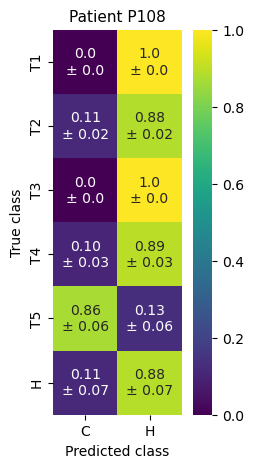

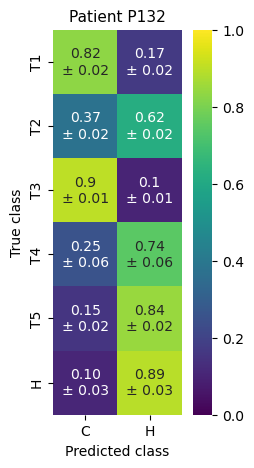

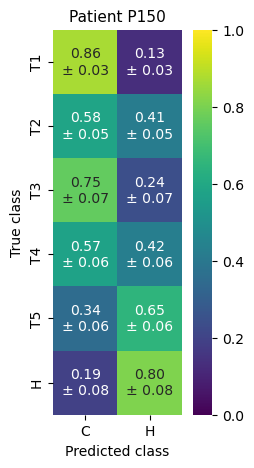

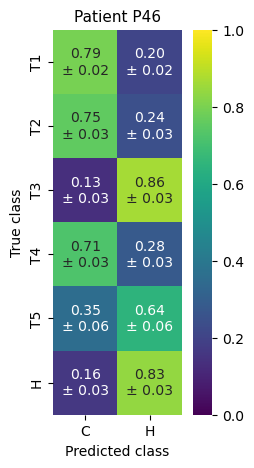

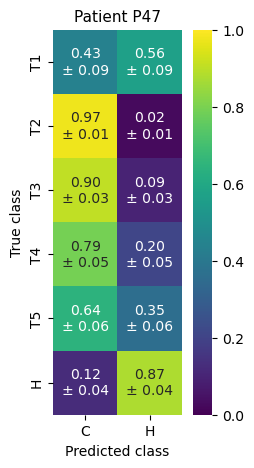

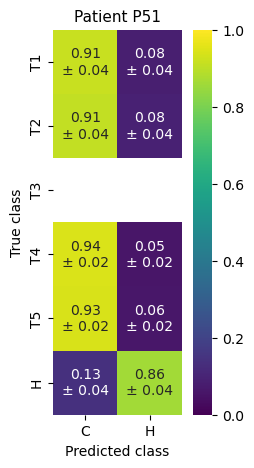

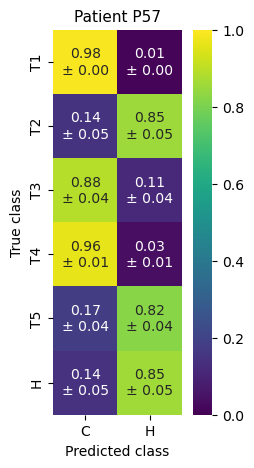

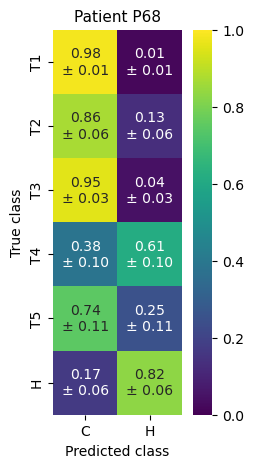

In [260]:
for p in patients:
  cms_mean = np.zeros((6, 2))
  cms_std = np.zeros((6, 2))

  for t in [1, 2, 3, 4, 5]:
    select = np.argwhere((np.array(ps) == p) & (np.array(ts) == t)).flatten()
    cms_t_mean = np.mean(np.array(cms)[select], axis=0)
    cms_t_std = np.std(np.array(cms)[select], axis=0)
    if t == 1:
      # for true label healthy
      cms_mean[-1] = cms_t_mean[1]
      cms_std[-1] = cms_t_std[1]
    # for true label disease at timepoint t
    cms_mean[t-1] = cms_t_mean[0]
    cms_std[t-1] = cms_t_std[0]

  cms_df = pd.DataFrame(cms_mean, index=['T1', 'T2', 'T3', 'T4', 'T5', 'H'], columns=['C', 'H'])
  fig, ax = plt.subplots(figsize=[3, 5])
  ax = sns.heatmap(
      cms_df,
      annot=pd.DataFrame(cms_mean.astype(str)).applymap(lambda x : x[:4]) + '\n± ' + pd.DataFrame(cms_std.astype(str)).applymap(lambda x : x[:4]),
      fmt='s',
      cmap='viridis',
      vmin=0,
      vmax=1,
      # cbar=False,
  )
  ax.set_xlabel('Predicted class')
  ax.set_ylabel('True class')
  ax.set_title(f'Patient {p}', size=11)
  ax.set_aspect(1)
  fig.show()